In [1]:
import cv2 
from fastai.imports import *
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [2]:
PATH = '/home/lc3352/Desktop/Kaggle/'
TRAIN = '/home/lc3352/Desktop/Kaggle/input/train/'
TEST = '/home/lc3352/Desktop/Kaggle/input/test/'
LABELS = '/home/lc3352/Desktop/Kaggle/input/train.csv'
SAMPLE = '/home/lc3352/Desktop/Kaggle/input/sample_submission.csv'

In [3]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [4]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

In [5]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.3, random_state=42)

In [6]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [8]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set（tested in advance）
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [9]:
bs = 16
sz = 512
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 512, 512]), torch.Size([16, 28]))

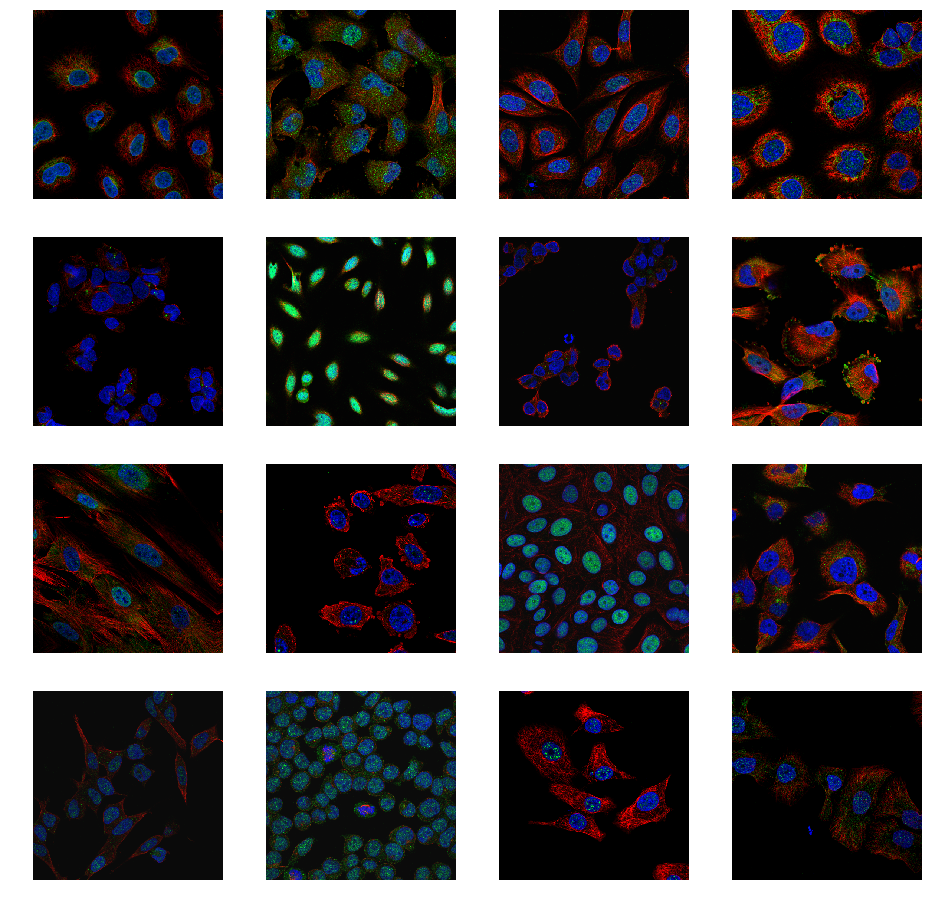

In [10]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [11]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)

for x,y in iter(md.trn_dl):
    
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std

(array([0.08726, 0.06003, 0.06536, 0.08922]),
 array([0.14159, 0.10566, 0.15166, 0.14181]))

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [13]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [14]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight
        w1 = (w[:,:1,:,:]+w[:,1:2,:,:]+w[:,2:3,:,:])/3
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
#         layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        layers[0].weight = torch.nn.Parameter(torch.cat((w,w1),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [15]:
sz = 512 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [16]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

  0%|          | 1/339 [00:04<26:36,  4.72s/it, loss=11.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<20:09,  3.59s/it, loss=11.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:01,  3.22s/it, loss=11.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:08<14:07,  2.53s/it, loss=11.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<14:38,  2.63s/it, loss=11.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:45,  2.12s/it, loss=11.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:51,  2.33s/it, loss=11.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:37,  1.92s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:56,  2.17s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<09:41,  1.77s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<11:10,  2.04s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:20,  1.71s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:38,  1.96s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<08:37,  1.59s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:44,  1.80s/it, loss=11]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<08:06,  1.50s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<10:26,  1.95s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<08:49,  1.65s/it, loss=11]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<10:11,  1.91s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:07,  1.53s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:40<11:33,  2.18s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:41<09:27,  1.79s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<11:11,  2.13s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:45<09:08,  1.74s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<10:36,  2.03s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<08:53,  1.70s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<10:22,  2.00s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:52<08:36,  1.66s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<10:32,  2.04s/it, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<08:35,  1.67s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<09:54,  1.93s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:59<08:18,  1.62s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<09:45,  1.91s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:01,  1.58s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:06<09:46,  1.93s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:06<08:10,  1.62s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<09:26,  1.88s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<07:45,  1.55s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:12<09:05,  1.82s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<07:17,  1.46s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:17<10:38,  2.14s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:17<08:37,  1.74s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:20<09:50,  1.99s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:21<08:09,  1.66s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:23<09:36,  1.96s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:24<07:58,  1.63s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:27<09:22,  1.93s/it, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:28<07:48,  1.61s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:30<09:12,  1.91s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:31<07:42,  1.60s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:34<09:02,  1.88s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:35<07:45,  1.62s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:37<08:48,  1.85s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:38<07:17,  1.54s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:41<09:07,  1.93s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:42<07:35,  1.61s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:44<08:45,  1.87s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:45<07:25,  1.59s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:47<08:28,  1.82s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:48<06:48,  1.47s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:52<09:59,  2.16s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:53<08:08,  1.76s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:55<09:15,  2.01s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [01:56<07:37,  1.66s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [01:59<08:40,  1.90s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [01:59<07:07,  1.57s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:02<08:59,  1.98s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:03<07:27,  1.65s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:06<08:52,  1.97s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:07<07:15,  1.62s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:09<08:13,  1.84s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:10<06:53,  1.55s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:13<08:41,  1.96s/it, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:14<07:06,  1.61s/it, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:16<08:34,  1.95s/it, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:17<07:08,  1.63s/it, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:20<08:00,  1.83s/it, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:21<06:46,  1.56s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:23<07:55,  1.83s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:24<06:22,  1.48s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:27<09:20,  2.17s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:28<07:35,  1.77s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:31<08:49,  2.07s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:32<07:17,  1.71s/it, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:35<08:36,  2.03s/it, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:36<07:03,  1.67s/it, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:38<08:19,  1.98s/it, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:39<06:48,  1.63s/it, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:42<07:53,  1.89s/it, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:43<06:41,  1.61s/it, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:45<07:43,  1.87s/it, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:46<06:37,  1.61s/it, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:49<07:42,  1.88s/it, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:49<06:25,  1.57s/it, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:52<07:52,  1.94s/it, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:53<06:28,  1.60s/it, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:56<07:53,  1.96s/it, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [02:57<06:39,  1.66s/it, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [02:59<07:27,  1.86s/it, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:00<05:57,  1.50s/it, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:03<08:20,  2.10s/it, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:04<06:51,  1.74s/it, loss=10]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:07<07:53,  2.01s/it, loss=9.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:08<06:31,  1.67s/it, loss=9.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:10<07:29,  1.92s/it, loss=9.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:11<06:09,  1.59s/it, loss=9.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:14<07:49,  2.02s/it, loss=9.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:15<06:23,  1.66s/it, loss=9.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:18<07:39,  2.00s/it, loss=9.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:19<06:25,  1.68s/it, loss=9.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:21<07:14,  1.91s/it, loss=9.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:22<06:02,  1.60s/it, loss=9.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:25<07:18,  1.94s/it, loss=9.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:25<06:02,  1.61s/it, loss=9.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:28<07:01,  1.88s/it, loss=9.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:29<05:51,  1.58s/it, loss=9.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:31<06:52,  1.86s/it, loss=9.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:32<05:47,  1.57s/it, loss=9.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:35<06:42,  1.83s/it, loss=9.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:35<05:22,  1.47s/it, loss=9.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:39<07:31,  2.07s/it, loss=9.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:40<06:09,  1.70s/it, loss=9.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:43<07:28,  2.08s/it, loss=9.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:43<06:09,  1.72s/it, loss=8.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:46<07:04,  1.98s/it, loss=8.86]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:47<05:45,  1.62s/it, loss=8.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:50<07:10,  2.03s/it, loss=8.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:51<05:55,  1.69s/it, loss=8.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:53<06:55,  1.98s/it, loss=8.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [03:54<05:39,  1.62s/it, loss=8.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [03:57<06:51,  1.98s/it, loss=8.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [03:58<05:41,  1.65s/it, loss=8.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:00<06:30,  1.90s/it, loss=8.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:01<05:20,  1.56s/it, loss=7.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:04<06:29,  1.91s/it, loss=7.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:05<05:21,  1.59s/it, loss=7.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:07<06:13,  1.85s/it, loss=7.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:08<05:08,  1.54s/it, loss=7.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:10<06:10,  1.85s/it, loss=7.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:11<04:56,  1.49s/it, loss=7.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:15<06:54,  2.09s/it, loss=7.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:15<05:33,  1.69s/it, loss=7.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:18<06:38,  2.03s/it, loss=6.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:19<05:22,  1.65s/it, loss=6.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:22<06:20,  1.96s/it, loss=6.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:22<05:13,  1.62s/it, loss=6.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:25<06:07,  1.92s/it, loss=6.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:26<05:06,  1.60s/it, loss=6.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:28<05:43,  1.81s/it, loss=6.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:29<04:53,  1.55s/it, loss=6.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:32<05:51,  1.87s/it, loss=6.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:33<04:51,  1.56s/it, loss=6.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:35<05:47,  1.87s/it, loss=5.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:36<04:48,  1.56s/it, loss=5.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:39<05:42,  1.86s/it, loss=5.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:39<04:42,  1.54s/it, loss=5.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:42<05:41,  1.87s/it, loss=5.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:43<04:44,  1.57s/it, loss=5.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:45<05:21,  1.79s/it, loss=5.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:46<04:18,  1.44s/it, loss=5.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:50<06:13,  2.10s/it, loss=5.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [04:50<05:09,  1.75s/it, loss=5.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [04:53<05:47,  1.98s/it, loss=5.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [04:54<04:46,  1.64s/it, loss=5.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [04:56<05:36,  1.94s/it, loss=5.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [04:57<04:45,  1.65s/it, loss=4.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:00<05:24,  1.89s/it, loss=4.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:01<04:29,  1.58s/it, loss=4.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:03<05:17,  1.87s/it, loss=4.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:04<04:31,  1.61s/it, loss=4.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:07<05:05,  1.82s/it, loss=4.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:07<04:12,  1.51s/it, loss=4.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:10<05:07,  1.86s/it, loss=4.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:11<04:17,  1.56s/it, loss=4.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:13<05:00,  1.83s/it, loss=4.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:14<04:11,  1.54s/it, loss=4.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:17<04:57,  1.84s/it, loss=4.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:18<04:10,  1.55s/it, loss=4.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:20<04:43,  1.77s/it, loss=4.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:21<03:53,  1.47s/it, loss=4.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:25<05:47,  2.20s/it, loss=4.1] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:26<04:48,  1.84s/it, loss=4.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:28<05:25,  2.09s/it, loss=4.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:29<04:24,  1.70s/it, loss=3.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:32<05:20,  2.08s/it, loss=3.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:33<04:24,  1.73s/it, loss=3.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:36<05:10,  2.04s/it, loss=3.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:37<04:17,  1.70s/it, loss=3.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:39<05:03,  2.02s/it, loss=3.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:40<04:12,  1.69s/it, loss=3.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:43<04:34,  1.86s/it, loss=3.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:43<03:46,  1.54s/it, loss=3.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:46<04:23,  1.81s/it, loss=3.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:47<03:48,  1.58s/it, loss=3.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [05:49<04:32,  1.89s/it, loss=3.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [05:50<03:46,  1.58s/it, loss=3.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [05:53<04:34,  1.93s/it, loss=3.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [05:54<03:50,  1.63s/it, loss=3.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [05:56<04:17,  1.84s/it, loss=3.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [05:57<03:26,  1.49s/it, loss=3.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:01<05:06,  2.22s/it, loss=3.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:02<04:09,  1.82s/it, loss=3.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:04<04:20,  1.92s/it, loss=3.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:05<03:34,  1.59s/it, loss=3.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:07<04:14,  1.90s/it, loss=3.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:08<03:29,  1.57s/it, loss=3.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:11<04:11,  1.90s/it, loss=3.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:12<03:25,  1.57s/it, loss=3.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:14<04:02,  1.87s/it, loss=3.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:15<03:22,  1.57s/it, loss=3.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:18<04:00,  1.88s/it, loss=3.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:19<03:21,  1.59s/it, loss=3.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:21<03:54,  1.86s/it, loss=3.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:22<03:17,  1.58s/it, loss=2.99]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:24<03:39,  1.77s/it, loss=2.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:25<03:14,  1.58s/it, loss=2.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:28<03:44,  1.84s/it, loss=2.95]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:29<03:11,  1.58s/it, loss=2.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:31<03:34,  1.79s/it, loss=2.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:32<02:54,  1.47s/it, loss=2.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:36<04:24,  2.24s/it, loss=2.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:37<03:32,  1.82s/it, loss=2.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:39<03:48,  1.97s/it, loss=2.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:40<03:06,  1.62s/it, loss=2.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:42<03:39,  1.93s/it, loss=2.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:43<03:01,  1.61s/it, loss=2.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [06:46<03:36,  1.93s/it, loss=2.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [06:47<02:57,  1.60s/it, loss=2.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [06:49<03:25,  1.86s/it, loss=2.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [06:50<02:53,  1.60s/it, loss=2.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [06:53<03:31,  1.95s/it, loss=2.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [06:54<02:59,  1.68s/it, loss=2.95]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [06:56<03:18,  1.87s/it, loss=2.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [06:57<02:49,  1.61s/it, loss=3.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:00<03:14,  1.87s/it, loss=3.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:01<02:50,  1.65s/it, loss=3.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:03<03:06,  1.83s/it, loss=3.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:05<02:47,  1.66s/it, loss=3.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:07<02:54,  1.75s/it, loss=3.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:07<02:27,  1.49s/it, loss=3.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:11<03:31,  2.16s/it, loss=3.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:12<02:53,  1.79s/it, loss=3.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:15<03:15,  2.04s/it, loss=3.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:15<02:38,  1.67s/it, loss=3.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:18<03:01,  1.93s/it, loss=4]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:19<02:30,  1.62s/it, loss=4.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:21<02:54,  1.90s/it, loss=4.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:22<02:25,  1.59s/it, loss=4.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:25<02:56,  1.96s/it, loss=4.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:26<02:23,  1.61s/it, loss=4.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:29<02:47,  1.91s/it, loss=4.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:29<02:20,  1.61s/it, loss=5.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:32<02:42,  1.88s/it, loss=5.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:33<02:13,  1.58s/it, loss=5.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:35<02:33,  1.83s/it, loss=5.86]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:36<02:05,  1.52s/it, loss=6.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:39<02:28,  1.81s/it, loss=6.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:39<02:02,  1.52s/it, loss=7]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:42<02:31,  1.89s/it, loss=7.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [07:43<01:59,  1.52s/it, loss=8.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [07:47<02:53,  2.23s/it, loss=8.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [07:48<02:19,  1.81s/it, loss=9.1] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [07:50<02:36,  2.06s/it, loss=9.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [07:51<02:07,  1.70s/it, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [07:54<02:26,  1.99s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [07:55<02:01,  1.67s/it, loss=11.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [07:57<02:01,  1.67s/it, loss=12]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


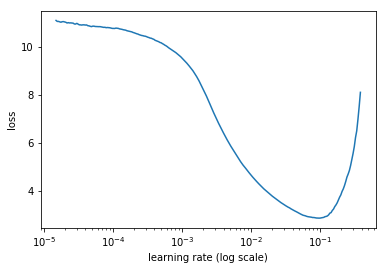

In [17]:
learner.lr_find()
learner.sched.plot()

In [18]:
lr = 2e-2
learner.fit(lr,1)

  0%|          | 1/339 [00:03<21:40,  3.85s/it, loss=11.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:04<16:27,  2.93s/it, loss=11.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<15:52,  2.84s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:08<12:28,  2.23s/it, loss=9.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<13:27,  2.42s/it, loss=8.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:11<11:02,  1.99s/it, loss=7.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:31,  2.08s/it, loss=6.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:15<09:29,  1.72s/it, loss=6.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:59,  2.00s/it, loss=5.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:18<09:14,  1.68s/it, loss=5.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:36,  1.94s/it, loss=5.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:22<08:54,  1.64s/it, loss=4.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<10:18,  1.90s/it, loss=4.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:25<08:25,  1.56s/it, loss=4.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<10:10,  1.88s/it, loss=4.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:29<08:36,  1.60s/it, loss=4.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:51,  1.84s/it, loss=4.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:32<08:16,  1.55s/it, loss=4.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:34<09:40,  1.82s/it, loss=3.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:35<07:45,  1.46s/it, loss=3.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:39<11:48,  2.23s/it, loss=3.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:40<09:34,  1.81s/it, loss=3.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:42<10:59,  2.09s/it, loss=3.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:43<09:10,  1.75s/it, loss=3.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:46<10:08,  1.94s/it, loss=3.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:47<08:24,  1.61s/it, loss=3.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:49<10:21,  1.99s/it, loss=3.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:50<08:34,  1.66s/it, loss=3.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:53<10:08,  1.96s/it, loss=3.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:54<08:28,  1.65s/it, loss=3.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:57<10:24,  2.03s/it, loss=3.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:58<08:30,  1.66s/it, loss=3.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:00<09:19,  1.83s/it, loss=2.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:01<07:45,  1.52s/it, loss=2.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:03<09:16,  1.83s/it, loss=2.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:04<07:40,  1.52s/it, loss=2.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:06<09:02,  1.80s/it, loss=2.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:08<08:05,  1.61s/it, loss=2.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:10<09:05,  1.82s/it, loss=2.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:11<07:18,  1.47s/it, loss=2.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:15<11:06,  2.24s/it, loss=2.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:16<09:01,  1.82s/it, loss=2.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:18<09:47,  1.99s/it, loss=2.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:19<08:06,  1.65s/it, loss=2.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:21<09:22,  1.91s/it, loss=2.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:22<07:44,  1.58s/it, loss=2.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:25<09:30,  1.95s/it, loss=2.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:26<07:57,  1.64s/it, loss=2.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:28<08:53,  1.84s/it, loss=2.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:29<07:30,  1.56s/it, loss=2.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:31<08:39,  1.80s/it, loss=2.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:32<07:21,  1.54s/it, loss=2.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:35<08:46,  1.84s/it, loss=2.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:36<07:26,  1.57s/it, loss=2.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:39<09:25,  1.99s/it, loss=2.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:40<08:01,  1.70s/it, loss=2.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:42<09:13,  1.96s/it, loss=2.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:43<07:42,  1.64s/it, loss=2.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:46<08:42,  1.87s/it, loss=2.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:46<06:58,  1.50s/it, loss=2.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:50<09:53,  2.14s/it, loss=2.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:51<08:17,  1.80s/it, loss=2.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:54<09:34,  2.08s/it, loss=2.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [01:54<07:48,  1.70s/it, loss=2.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [01:57<08:43,  1.91s/it, loss=2.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [01:58<07:16,  1.60s/it, loss=2]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:01<08:49,  1.95s/it, loss=1.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:01<07:12,  1.59s/it, loss=1.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:04<08:24,  1.87s/it, loss=1.95]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:05<06:57,  1.55s/it, loss=1.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:08<08:44,  1.96s/it, loss=1.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:08<07:16,  1.64s/it, loss=1.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:11<08:19,  1.88s/it, loss=1.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:12<06:58,  1.58s/it, loss=1.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:14<08:14,  1.87s/it, loss=1.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:15<06:49,  1.56s/it, loss=1.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:17<07:49,  1.79s/it, loss=1.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:18<06:33,  1.51s/it, loss=1.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:21<07:38,  1.76s/it, loss=1.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:21<06:09,  1.43s/it, loss=1.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:25<09:04,  2.11s/it, loss=1.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:26<07:22,  1.72s/it, loss=1.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:28<08:26,  1.98s/it, loss=1.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:29<06:56,  1.63s/it, loss=1.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:32<08:23,  1.98s/it, loss=1.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:33<06:59,  1.66s/it, loss=1.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:35<07:52,  1.88s/it, loss=1.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:36<06:44,  1.61s/it, loss=1.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:39<07:53,  1.90s/it, loss=1.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:40<06:46,  1.63s/it, loss=1.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:42<07:51,  1.90s/it, loss=1.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:43<06:32,  1.59s/it, loss=1.7] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:46<07:36,  1.86s/it, loss=1.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:47<06:35,  1.61s/it, loss=1.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:49<07:22,  1.81s/it, loss=1.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:50<06:18,  1.56s/it, loss=1.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:52<07:10,  1.78s/it, loss=1.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [02:54<06:27,  1.61s/it, loss=1.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [02:56<07:04,  1.77s/it, loss=1.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [02:56<05:51,  1.47s/it, loss=1.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:00<08:26,  2.13s/it, loss=1.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:01<06:51,  1.74s/it, loss=1.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:03<07:38,  1.94s/it, loss=1.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:04<06:20,  1.62s/it, loss=1.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:07<07:27,  1.91s/it, loss=1.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:08<06:15,  1.61s/it, loss=1.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:11<07:34,  1.96s/it, loss=1.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:11<06:12,  1.61s/it, loss=1.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:14<07:16,  1.90s/it, loss=1.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:15<05:59,  1.57s/it, loss=1.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:17<07:05,  1.87s/it, loss=1.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:18<05:53,  1.56s/it, loss=1.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:20<06:45,  1.80s/it, loss=1.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:21<05:44,  1.53s/it, loss=1.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:24<06:56,  1.86s/it, loss=1.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:25<05:50,  1.57s/it, loss=1.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:27<06:55,  1.87s/it, loss=1.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:29<06:03,  1.65s/it, loss=1.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:31<06:45,  1.84s/it, loss=1.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:31<05:24,  1.48s/it, loss=1.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:35<07:41,  2.12s/it, loss=1.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:36<06:11,  1.71s/it, loss=1.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:39<07:25,  2.06s/it, loss=1.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:40<06:08,  1.72s/it, loss=1.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:42<07:06,  1.99s/it, loss=1.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:43<05:49,  1.64s/it, loss=1.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:46<06:56,  1.97s/it, loss=1.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:47<05:39,  1.61s/it, loss=1.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:49<06:50,  1.95s/it, loss=1.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [03:50<05:44,  1.65s/it, loss=1.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [03:53<06:59,  2.02s/it, loss=1.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [03:54<05:43,  1.66s/it, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [03:57<06:52,  2.00s/it, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [03:58<05:41,  1.66s/it, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:01<06:51,  2.02s/it, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:01<05:37,  1.66s/it, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:04<06:47,  2.02s/it, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:05<05:39,  1.69s/it, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:08<06:24,  1.92s/it, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:08<05:06,  1.54s/it, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:12<07:22,  2.24s/it, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:13<06:05,  1.86s/it, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:16<06:57,  2.13s/it, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:17<05:40,  1.75s/it, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:19<06:23,  1.98s/it, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:20<05:21,  1.67s/it, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:23<06:12,  1.94s/it, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:23<05:03,  1.59s/it, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:26<05:55,  1.87s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:27<04:51,  1.54s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:29<05:47,  1.85s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:30<04:45,  1.53s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:33<06:11,  2.00s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:34<05:13,  1.70s/it, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:37<05:53,  1.92s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:38<05:06,  1.67s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:40<05:34,  1.84s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:41<05:01,  1.66s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:43<05:27,  1.82s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:44<04:27,  1.50s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:48<06:26,  2.17s/it, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [04:49<05:12,  1.77s/it, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [04:52<06:07,  2.09s/it, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [04:52<04:58,  1.70s/it, loss=1.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [04:55<05:38,  1.95s/it, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [04:56<04:36,  1.60s/it, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [04:58<05:24,  1.89s/it, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [04:59<04:47,  1.68s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:02<05:29,  1.94s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:03<04:32,  1.61s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:05<05:21,  1.91s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:06<04:25,  1.59s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:09<05:05,  1.84s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:10<04:20,  1.58s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:12<05:09,  1.89s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:13<04:14,  1.56s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:16<05:02,  1.87s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:17<04:12,  1.57s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:19<04:43,  1.77s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:19<03:47,  1.43s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:23<05:49,  2.21s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:24<04:44,  1.81s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:27<05:04,  1.95s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:27<04:08,  1.60s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:30<04:49,  1.88s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:31<03:56,  1.55s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:34<04:52,  1.92s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:34<03:58,  1.58s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:37<04:53,  1.95s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:38<04:07,  1.66s/it, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:41<04:44,  1.92s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:41<03:51,  1.58s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:44<04:23,  1.80s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:45<03:38,  1.51s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [05:47<04:14,  1.77s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [05:48<03:36,  1.51s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [05:50<04:15,  1.80s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [05:52<03:56,  1.68s/it, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [05:54<04:09,  1.78s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [05:55<03:29,  1.51s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [05:58<04:51,  2.11s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [05:59<03:55,  1.72s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:01<04:24,  1.94s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:02<03:37,  1.61s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:05<04:24,  1.98s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:06<03:42,  1.67s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:09<04:15,  1.94s/it, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:09<03:30,  1.61s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:12<04:11,  1.93s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:13<03:25,  1.59s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:15<03:59,  1.87s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:16<03:19,  1.57s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:19<03:49,  1.82s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:20<03:11,  1.53s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:22<03:41,  1.79s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:23<03:04,  1.50s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:25<03:42,  1.83s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:26<03:06,  1.54s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:29<03:33,  1.78s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:29<02:51,  1.44s/it, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:33<04:14,  2.16s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:34<03:22,  1.73s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:37<04:05,  2.11s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:38<03:21,  1.75s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:40<03:46,  1.98s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:41<03:06,  1.65s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [06:44<03:32,  1.90s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [06:44<02:55,  1.58s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [06:47<03:28,  1.90s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [06:48<02:54,  1.60s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [06:51<03:27,  1.92s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [06:51<02:51,  1.60s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [06:54<03:19,  1.89s/it, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [06:55<02:44,  1.56s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [06:58<03:21,  1.94s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [06:59<02:47,  1.62s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:01<03:22,  1.98s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:02<02:46,  1.65s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:05<03:11,  1.91s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:05<02:31,  1.53s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:09<03:29,  2.13s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:10<02:50,  1.76s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:12<03:05,  1.93s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:13<02:32,  1.61s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:16<03:01,  1.93s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:17<02:29,  1.60s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:19<02:52,  1.87s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:20<02:23,  1.58s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:23<02:50,  1.90s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:23<02:22,  1.60s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:26<02:43,  1.86s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:27<02:14,  1.55s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:29<02:42,  1.89s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:30<02:13,  1.56s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:33<02:48,  2.01s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:34<02:17,  1.65s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:37<02:34,  1.89s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:37<02:06,  1.56s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:40<02:24,  1.80s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [07:40<01:54,  1.45s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [07:44<02:47,  2.15s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [07:45<02:17,  1.78s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [07:48<02:36,  2.07s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [07:49<02:09,  1.72s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [07:51<02:27,  1.99s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [07:52<02:01,  1.66s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [07:55<02:15,  1.89s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [07:55<01:50,  1.56s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [07:58<02:12,  1.90s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [07:59<01:49,  1.59s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:02<02:08,  1.89s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:03<01:47,  1.61s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:05<02:09,  1.96s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:06<01:44,  1.61s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:09<02:01,  1.89s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:10<01:39,  1.58s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:12<01:55,  1.86s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:13<01:34,  1.54s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:15<01:46,  1.77s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:16<01:24,  1.43s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:20<02:03,  2.13s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:20<01:38,  1.73s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:23<01:53,  2.03s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:24<01:32,  1.69s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:27<01:49,  2.02s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:28<01:27,  1.65s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:30<01:42,  1.96s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:31<01:23,  1.63s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:34<01:37,  1.95s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:35<01:19,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:37<01:33,  1.95s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [08:38<01:15,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [08:41<01:26,  1.89s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [08:42<01:10,  1.58s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [08:44<01:25,  1.94s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [08:45<01:09,  1.63s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [08:48<01:22,  1.96s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [08:49<01:06,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [08:51<01:15,  1.90s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [08:52<00:59,  1.52s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [08:56<01:21,  2.16s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [08:56<01:05,  1.76s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [08:59<01:12,  2.00s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:00<00:58,  1.68s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:03<01:08,  2.00s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:04<00:54,  1.66s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:06<01:03,  1.98s/it, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:07<00:50,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:09<00:55,  1.84s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:11<00:48,  1.66s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:13<00:51,  1.82s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:14<00:47,  1.75s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:16<00:47,  1.84s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:18<00:42,  1.68s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:20<00:44,  1.84s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:21<00:38,  1.66s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:24<00:40,  1.86s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:25<00:36,  1.74s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:27<00:34,  1.72s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:28<00:28,  1.51s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:31<00:37,  2.11s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:32<00:29,  1.74s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:35<00:31,  1.95s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [09:35<00:24,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [09:38<00:26,  1.86s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [09:39<00:20,  1.55s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [09:41<00:23,  1.92s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [09:42<00:17,  1.60s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [09:45<00:19,  1.92s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [09:46<00:14,  1.58s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [09:49<00:15,  1.94s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [09:49<00:11,  1.62s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [09:52<00:11,  1.90s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [09:53<00:07,  1.56s/it, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [09:56<00:07,  1.94s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [09:56<00:04,  1.60s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [09:59<00:03,  1.87s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:00<00:01,  1.52s/it, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc        
    0      1.314817   1.223676   0.946973  


[1.2236756903499626, 0.9469726443597621]

In [19]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<25:21,  4.50s/it, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:40,  3.68s/it, loss=1.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:40,  3.16s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:09,  2.71s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:35,  2.44s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:16,  2.21s/it, loss=1.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:13,  2.21s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:37,  2.11s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:40,  2.12s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<11:06,  2.02s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<11:17,  2.07s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:25<10:32,  1.94s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:27<10:32,  1.94s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:12,  1.89s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:31<10:38,  1.97s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:31,  1.95s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:07,  1.89s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<09:57,  1.86s/it, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:38<09:52,  1.85s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:19,  1.75s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:44<13:37,  2.57s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:46<12:21,  2.34s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:31,  2.19s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<10:57,  2.09s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<10:40,  2.04s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:53<10:09,  1.95s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:55<09:54,  1.91s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:31,  1.84s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:59<10:05,  1.95s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:38,  1.87s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:03<10:04,  1.96s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:04<09:39,  1.89s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:06<09:48,  1.92s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:08<09:29,  1.87s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:10<10:08,  2.00s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:12<09:44,  1.93s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:14<09:45,  1.94s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:16<09:27,  1.88s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:18<09:22,  1.88s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:19<08:48,  1.77s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:24<13:12,  2.66s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:26<11:50,  2.39s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:27<10:43,  2.17s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:29<10:04,  2.05s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:31<10:14,  2.09s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:33<09:43,  1.99s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:35<09:30,  1.95s/it, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:37<09:06,  1.88s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:39<09:29,  1.96s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:40<09:02,  1.88s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:43<09:22,  1.95s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:44<08:58,  1.88s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:46<08:52,  1.86s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:48<08:33,  1.80s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:50<09:10,  1.94s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:52<08:52,  1.88s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:54<09:22,  1.99s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:56<08:55,  1.91s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:57<08:38,  1.85s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:59<08:09,  1.75s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:04<12:00,  2.59s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:05<10:49,  2.34s/it, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:07<10:11,  2.22s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:09<09:29,  2.07s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:11<09:24,  2.06s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:13<08:57,  1.97s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:15<08:45,  1.93s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:16<08:27,  1.87s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:18<08:16,  1.84s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:20<08:09,  1.82s/it, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:22<08:36,  1.93s/it, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:24<08:27,  1.90s/it, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:26<08:15,  1.86s/it, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:27<07:59,  1.81s/it, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:29<08:09,  1.85s/it, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:31<07:57,  1.82s/it, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:33<07:51,  1.80s/it, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:35<07:49,  1.80s/it, loss=1.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:36<07:32,  1.74s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:38<07:13,  1.67s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:42<11:00,  2.56s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:44<09:53,  2.31s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:46<09:38,  2.26s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:48<08:52,  2.09s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:50<08:51,  2.09s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:52<08:33,  2.03s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:54<08:13,  1.96s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:55<08:00,  1.91s/it, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:58<08:18,  2.00s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:59<07:55,  1.91s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:01<08:05,  1.96s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:03<07:46,  1.89s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:05<07:56,  1.94s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:07<07:33,  1.85s/it, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:09<07:45,  1.91s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:11<07:25,  1.84s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:12<07:30,  1.86s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:14<07:26,  1.85s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:16<07:19,  1.83s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:18<06:55,  1.74s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:22<10:31,  2.65s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:24<09:35,  2.43s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:26<08:52,  2.26s/it, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:28<08:09,  2.08s/it, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:30<08:02,  2.06s/it, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:32<07:38,  1.97s/it, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:34<07:51,  2.03s/it, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:35<07:26,  1.93s/it, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:37<07:27,  1.95s/it, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:39<07:14,  1.90s/it, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:41<07:29,  1.97s/it, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:43<07:11,  1.90s/it, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:45<07:33,  2.01s/it, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:47<07:21,  1.96s/it, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:49<07:17,  1.96s/it, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:51<07:01,  1.89s/it, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:53<07:10,  1.94s/it, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:55<06:56,  1.88s/it, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:57<06:46,  1.85s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:58<06:22,  1.75s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:03<09:36,  2.64s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:05<08:37,  2.38s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:07<08:24,  2.33s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:08<07:43,  2.16s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:10<07:30,  2.10s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:12<07:11,  2.02s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:14<07:05,  2.01s/it, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:16<06:42,  1.91s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:18<06:40,  1.91s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:20<06:38,  1.91s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:22<06:48,  1.96s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:24<06:29,  1.88s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:26<06:41,  1.95s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:27<06:25,  1.88s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:30<06:40,  1.96s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:31<06:24,  1.89s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:34<06:54,  2.05s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:35<06:30,  1.95s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:37<06:36,  1.98s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:39<06:07,  1.84s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:44<09:06,  2.76s/it, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:46<08:02,  2.45s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:48<07:36,  2.33s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:49<06:58,  2.14s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:51<06:45,  2.09s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:53<06:23,  1.99s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:55<06:30,  2.04s/it, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:57<06:11,  1.94s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:59<06:02,  1.91s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [05:00<05:47,  1.84s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [05:02<05:49,  1.86s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:04<05:48,  1.86s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:06<05:58,  1.93s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:08<05:44,  1.86s/it, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:10<05:42,  1.86s/it, loss=1.1] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:12<05:33,  1.82s/it, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:13<05:35,  1.84s/it, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:15<05:28,  1.82s/it, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:17<05:24,  1.81s/it, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:19<05:07,  1.72s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:23<07:44,  2.61s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:25<06:58,  2.37s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:27<06:30,  2.22s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:29<06:07,  2.10s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:31<05:54,  2.04s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:32<05:34,  1.93s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:34<05:25,  1.89s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:36<05:22,  1.89s/it, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:38<05:12,  1.84s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:39<05:04,  1.80s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:41<05:00,  1.79s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:43<04:59,  1.79s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:45<05:03,  1.83s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:47<04:58,  1.81s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:49<05:16,  1.93s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:51<05:06,  1.88s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:52<05:00,  1.86s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:54<04:54,  1.83s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:56<04:46,  1.79s/it, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:57<04:31,  1.71s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [06:02<06:53,  2.62s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:04<06:16,  2.40s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:06<05:40,  2.18s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:07<05:16,  2.04s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:09<05:09,  2.01s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:11<04:55,  1.93s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:13<04:55,  1.95s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:15<04:44,  1.88s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:17<04:44,  1.90s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:19<04:38,  1.87s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:20<04:35,  1.86s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:22<04:28,  1.83s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:24<04:24,  1.81s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:26<04:18,  1.79s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:28<04:21,  1.82s/it, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:29<04:16,  1.79s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:31<04:12,  1.78s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:33<04:07,  1.76s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:34<04:05,  1.75s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:36<03:53,  1.68s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:41<05:56,  2.59s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:42<05:21,  2.35s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:44<04:57,  2.19s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:46<04:37,  2.05s/it, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:48<04:37,  2.07s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:50<04:22,  1.98s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:52<04:23,  2.00s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:54<04:10,  1.91s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:55<03:59,  1.84s/it, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:57<03:57,  1.84s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:59<03:58,  1.86s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [07:01<03:53,  1.84s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:03<03:52,  1.85s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:05<03:48,  1.83s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:06<03:41,  1.79s/it, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:08<03:39,  1.79s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:10<03:50,  1.89s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:12<03:44,  1.85s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:13<03:31,  1.76s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:15<03:21,  1.69s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:20<05:00,  2.55s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:21<04:26,  2.28s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:23<04:11,  2.17s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:25<03:54,  2.04s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:27<03:49,  2.01s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:29<03:40,  1.95s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:31<03:43,  2.00s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:32<03:33,  1.92s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:34<03:29,  1.90s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:36<03:21,  1.84s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:38<03:16,  1.82s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:40<03:19,  1.86s/it, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:42<03:17,  1.86s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:43<03:13,  1.84s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:45<03:10,  1.84s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:47<03:05,  1.80s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:49<03:09,  1.86s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:51<03:02,  1.81s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:52<02:59,  1.79s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:54<02:48,  1.71s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:59<04:21,  2.67s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [08:00<03:50,  2.38s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:02<03:28,  2.17s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:04<03:13,  2.04s/it, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:06<03:07,  2.00s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:08<03:01,  1.96s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:09<02:56,  1.92s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:11<02:52,  1.89s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:13<02:49,  1.88s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:15<02:44,  1.85s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:17<02:44,  1.87s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:19<02:38,  1.82s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:21<02:43,  1.90s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:22<02:39,  1.87s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:25<02:41,  1.92s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:26<02:38,  1.90s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:28<02:31,  1.85s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:30<02:25,  1.80s/it, loss=1]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:32<02:23,  1.79s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:33<02:15,  1.71s/it, loss=1]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:38<03:21,  2.58s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:39<03:00,  2.34s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:41<02:48,  2.21s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:43<02:37,  2.10s/it, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:45<02:29,  2.03s/it, loss=1]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:47<02:22,  1.96s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:49<02:25,  2.03s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:51<02:18,  1.95s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:53<02:20,  2.01s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:55<02:16,  1.98s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:57<02:13,  1.96s/it, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:59<02:07,  1.91s/it, loss=0.997]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [09:01<02:08,  1.94s/it, loss=0.995]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [09:02<02:00,  1.85s/it, loss=0.993]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:04<02:05,  1.96s/it, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:06<01:58,  1.88s/it, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:08<01:58,  1.91s/it, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:10<01:51,  1.83s/it, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:11<01:46,  1.78s/it, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:13<01:40,  1.70s/it, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:18<02:31,  2.61s/it, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:19<02:13,  2.34s/it, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:22<02:14,  2.40s/it, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:24<02:02,  2.22s/it, loss=0.993]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:25<01:50,  2.05s/it, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:27<01:45,  1.98s/it, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:29<01:44,  2.00s/it, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:31<01:37,  1.91s/it, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:33<01:37,  1.96s/it, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:35<01:32,  1.90s/it, loss=0.983]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:37<01:31,  1.91s/it, loss=0.984]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:38<01:27,  1.85s/it, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:40<01:25,  1.85s/it, loss=0.985]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:42<01:20,  1.79s/it, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:44<01:21,  1.86s/it, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:46<01:19,  1.84s/it, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:48<01:18,  1.86s/it, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:49<01:15,  1.84s/it, loss=0.983]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:51<01:15,  1.88s/it, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:53<01:08,  1.77s/it, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:58<01:39,  2.61s/it, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:59<01:26,  2.33s/it, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [10:01<01:20,  2.23s/it, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [10:03<01:12,  2.08s/it, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:05<01:10,  2.08s/it, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:07<01:04,  1.97s/it, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:09<01:01,  1.94s/it, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:10<00:58,  1.89s/it, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:12<00:55,  1.86s/it, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:14<00:53,  1.83s/it, loss=0.974]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:16<00:54,  1.96s/it, loss=0.974]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:18<00:50,  1.89s/it, loss=0.974]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:20<00:50,  1.96s/it, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:22<00:47,  1.89s/it, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:24<00:47,  1.98s/it, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:26<00:43,  1.90s/it, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:28<00:42,  1.93s/it, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:29<00:39,  1.88s/it, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:31<00:38,  1.90s/it, loss=0.969]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:33<00:33,  1.79s/it, loss=0.97] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:37<00:46,  2.59s/it, loss=0.97]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:39<00:40,  2.37s/it, loss=0.971]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:41<00:36,  2.26s/it, loss=0.973]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:43<00:31,  2.08s/it, loss=0.972]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:45<00:27,  1.99s/it, loss=0.971]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:46<00:24,  1.91s/it, loss=0.968]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:48<00:23,  1.92s/it, loss=0.97] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:50<00:20,  1.86s/it, loss=0.967]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:52<00:18,  1.90s/it, loss=0.967]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:54<00:16,  1.84s/it, loss=0.966]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:56<00:14,  1.84s/it, loss=0.964]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:57<00:12,  1.79s/it, loss=0.963]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:59<00:10,  1.79s/it, loss=0.961]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [11:01<00:08,  1.78s/it, loss=0.958]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [11:03<00:07,  1.82s/it, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [11:04<00:05,  1.79s/it, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:06<00:03,  1.79s/it, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:08<00:01,  1.73s/it, loss=0.959]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                         
    0      0.957665   1.006359   0.953053  
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<26:27,  4.70s/it, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:19,  3.80s/it, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:08,  3.24s/it, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:43,  2.82s/it, loss=0.954]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:37,  2.63s/it, loss=0.952]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:14<13:05,  2.36s/it, loss=0.95] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:04,  2.18s/it, loss=0.949]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:25,  2.07s/it, loss=0.947]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:17,  2.05s/it, loss=0.945]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:46,  1.97s/it, loss=0.945]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:59,  2.01s/it, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:25<10:27,  1.92s/it, loss=0.943]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:27<10:16,  1.89s/it, loss=0.943]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:10,  1.88s/it, loss=0.94] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:20,  1.91s/it, loss=0.939]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<09:49,  1.83s/it, loss=0.937]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<09:43,  1.81s/it, loss=0.933]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<09:34,  1.79s/it, loss=0.932]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:38,  1.81s/it, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:09,  1.72s/it, loss=0.93] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:19,  2.51s/it, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:10,  2.31s/it, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:09,  2.12s/it, loss=0.936]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<10:39,  2.03s/it, loss=0.932]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<10:29,  2.00s/it, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<10:08,  1.94s/it, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<10:05,  1.94s/it, loss=0.933]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:43,  1.88s/it, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<09:47,  1.90s/it, loss=0.936]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:33,  1.85s/it, loss=0.935]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:02<09:50,  1.92s/it, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:04<09:39,  1.89s/it, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:06<09:39,  1.89s/it, loss=0.929]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:07<09:25,  1.85s/it, loss=0.929]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:34,  1.89s/it, loss=0.929]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:11<09:25,  1.86s/it, loss=0.926]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:13<09:21,  1.86s/it, loss=0.927]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:15<09:08,  1.82s/it, loss=0.925]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:16<08:48,  1.76s/it, loss=0.923]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:18<08:24,  1.69s/it, loss=0.922]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:22<12:27,  2.51s/it, loss=0.922]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:24<11:15,  2.27s/it, loss=0.919]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:26<10:50,  2.20s/it, loss=0.915]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<10:08,  2.06s/it, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:29<09:43,  1.98s/it, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:31<09:16,  1.90s/it, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:33<09:09,  1.88s/it, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:35<08:59,  1.85s/it, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:37<08:49,  1.82s/it, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:38<08:37,  1.79s/it, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:40<08:32,  1.78s/it, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:42<08:23,  1.76s/it, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:44<09:23,  1.97s/it, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:46<08:59,  1.89s/it, loss=0.911]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:48<08:51,  1.87s/it, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:49<08:34,  1.82s/it, loss=0.91] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:52<09:01,  1.92s/it, loss=0.908]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:53<08:56,  1.91s/it, loss=0.906]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:55<08:33,  1.84s/it, loss=0.907]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:57<08:06,  1.74s/it, loss=0.909]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:01<12:13,  2.64s/it, loss=0.91] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:03<10:59,  2.38s/it, loss=0.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:05<10:13,  2.22s/it, loss=0.907]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:07<09:28,  2.07s/it, loss=0.905]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:09<09:02,  1.98s/it, loss=0.905]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:10<08:44,  1.92s/it, loss=0.903]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:13<09:09,  2.02s/it, loss=0.903]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:14<08:42,  1.93s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:16<08:37,  1.92s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:18<08:22,  1.87s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:20<08:15,  1.85s/it, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:21<08:08,  1.83s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:23<08:10,  1.84s/it, loss=0.902]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:25<08:01,  1.82s/it, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:27<08:16,  1.88s/it, loss=0.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:29<07:58,  1.82s/it, loss=0.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:31<08:10,  1.87s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:33<07:59,  1.84s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:34<07:43,  1.78s/it, loss=0.901]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:36<07:21,  1.70s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:40<11:14,  2.61s/it, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:42<10:03,  2.35s/it, loss=0.901]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:44<09:40,  2.27s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:46<08:58,  2.11s/it, loss=0.902]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:48<09:12,  2.18s/it, loss=0.902]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:50<08:38,  2.05s/it, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:52<08:20,  1.99s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:54<07:56,  1.90s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:56<08:05,  1.94s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:57<07:51,  1.89s/it, loss=0.894]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:59<07:34,  1.83s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:01<07:25,  1.80s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:03<07:48,  1.90s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:05<07:39,  1.88s/it, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:07<07:38,  1.88s/it, loss=0.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:09<07:28,  1.84s/it, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:10<07:26,  1.84s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:12<07:12,  1.80s/it, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:14<06:57,  1.74s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:15<06:39,  1.67s/it, loss=0.894]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:19<09:35,  2.42s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:21<08:46,  2.22s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:23<08:23,  2.13s/it, loss=0.897]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:25<07:55,  2.02s/it, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:27<08:08,  2.09s/it, loss=0.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:29<07:35,  1.96s/it, loss=0.901]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:31<07:26,  1.92s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:32<07:10,  1.86s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:34<07:02,  1.84s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:36<06:51,  1.80s/it, loss=0.896]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:38<06:50,  1.80s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:39<06:45,  1.79s/it, loss=0.897]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:41<06:41,  1.78s/it, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:43<06:33,  1.75s/it, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:44<06:33,  1.76s/it, loss=0.896]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:46<06:27,  1.74s/it, loss=0.896]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:48<06:26,  1.74s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:50<06:20,  1.72s/it, loss=0.894]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:51<06:09,  1.68s/it, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:53<05:56,  1.63s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:58<09:46,  2.69s/it, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:00<08:38,  2.39s/it, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:02<08:20,  2.32s/it, loss=0.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:03<07:43,  2.15s/it, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:05<07:25,  2.08s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:07<07:08,  2.01s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:09<06:52,  1.94s/it, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:11<06:33,  1.87s/it, loss=0.894]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:13<06:53,  1.97s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:15<06:40,  1.92s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:16<06:25,  1.85s/it, loss=0.893]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:18<06:17,  1.82s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:20<06:09,  1.80s/it, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:22<06:04,  1.78s/it, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:24<06:12,  1.82s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:25<06:01,  1.78s/it, loss=0.894]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:27<05:58,  1.77s/it, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:29<05:55,  1.77s/it, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:30<05:45,  1.73s/it, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:32<05:31,  1.67s/it, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:37<08:38,  2.62s/it, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:39<07:52,  2.40s/it, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:40<07:12,  2.21s/it, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:42<06:38,  2.04s/it, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:44<06:35,  2.04s/it, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:46<06:20,  1.97s/it, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:48<06:24,  2.00s/it, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:50<06:08,  1.93s/it, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:52<06:06,  1.93s/it, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:53<05:53,  1.87s/it, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:55<05:43,  1.83s/it, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:57<05:38,  1.81s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:59<05:32,  1.79s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:00<05:28,  1.78s/it, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:02<05:26,  1.77s/it, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:04<05:27,  1.79s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:06<05:20,  1.76s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:07<05:18,  1.76s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:09<05:29,  1.83s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:11<05:11,  1.74s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:16<07:55,  2.67s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:18<07:05,  2.41s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:19<06:26,  2.20s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:21<05:57,  2.05s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:23<06:08,  2.12s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:25<05:46,  2.00s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:27<05:33,  1.94s/it, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:29<05:27,  1.92s/it, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:30<05:17,  1.87s/it, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:32<05:08,  1.83s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:34<05:12,  1.86s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:36<04:59,  1.79s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:38<05:02,  1.82s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:39<04:58,  1.81s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:41<05:00,  1.83s/it, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:43<04:57,  1.82s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:45<04:53,  1.81s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:47<04:54,  1.83s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:48<04:48,  1.80s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:50<04:32,  1.72s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:55<06:57,  2.64s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:56<06:10,  2.36s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:58<05:43,  2.20s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:00<05:22,  2.08s/it, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:02<05:15,  2.05s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:04<05:05,  1.99s/it, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:06<05:01,  1.99s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:08<04:51,  1.93s/it, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:10<04:51,  1.94s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:11<04:38,  1.87s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:13<04:45,  1.93s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:15<04:32,  1.85s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:17<04:32,  1.87s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:19<04:23,  1.82s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:21<04:28,  1.86s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:23<04:30,  1.89s/it, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:25<04:39,  1.97s/it, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:27<04:28,  1.90s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:28<04:18,  1.85s/it, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:30<04:03,  1.75s/it, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:35<06:11,  2.70s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:36<05:28,  2.40s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:38<05:11,  2.29s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:40<04:47,  2.13s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:42<04:36,  2.06s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:44<04:23,  1.98s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:46<04:12,  1.91s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:47<04:00,  1.84s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:49<04:09,  1.92s/it, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:51<03:59,  1.85s/it, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:53<04:08,  1.94s/it, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:55<04:00,  1.89s/it, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:57<03:56,  1.88s/it, loss=0.858]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:59<03:47,  1.82s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:01<03:58,  1.92s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:03<03:51,  1.88s/it, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:05<03:56,  1.94s/it, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:06<03:46,  1.87s/it, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:08<03:42,  1.85s/it, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:10<03:28,  1.75s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:14<05:06,  2.60s/it, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:16<04:33,  2.34s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:18<04:22,  2.26s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:20<04:04,  2.13s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:22<03:54,  2.05s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:23<03:38,  1.94s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:25<03:29,  1.87s/it, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:27<03:22,  1.82s/it, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:29<03:26,  1.88s/it, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:30<03:17,  1.81s/it, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:32<03:14,  1.80s/it, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:34<03:09,  1.78s/it, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:36<03:07,  1.77s/it, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:37<03:04,  1.76s/it, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:40<03:20,  1.93s/it, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:42<03:16,  1.90s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:44<03:26,  2.02s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:46<03:15,  1.94s/it, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:47<03:07,  1.88s/it, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:49<02:54,  1.77s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:53<04:11,  2.57s/it, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:55<03:43,  2.30s/it, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:57<03:35,  2.25s/it, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:59<03:23,  2.14s/it, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:01<03:15,  2.08s/it, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:03<03:01,  1.95s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:05<02:57,  1.93s/it, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:06<02:51,  1.88s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:08<02:50,  1.89s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:10<02:45,  1.86s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:12<02:41,  1.83s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:14<02:37,  1.81s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:16<02:46,  1.93s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:18<02:40,  1.89s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:19<02:40,  1.91s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:21<02:32,  1.83s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:23<02:35,  1.90s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:25<02:28,  1.84s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:26<02:20,  1.76s/it, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:28<02:12,  1.68s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:32<03:15,  2.51s/it, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:34<02:54,  2.26s/it, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:36<02:43,  2.15s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:38<02:29,  2.00s/it, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:40<02:33,  2.07s/it, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:42<02:24,  1.98s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:43<02:20,  1.95s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:45<02:14,  1.90s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:47<02:16,  1.95s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:49<02:09,  1.87s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:51<02:06,  1.86s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:53<02:01,  1.81s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:55<02:05,  1.90s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:56<02:00,  1.86s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:58<01:58,  1.86s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:00<01:54,  1.82s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:02<01:57,  1.89s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:04<01:53,  1.86s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:06<01:48,  1.81s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:07<01:41,  1.72s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:12<02:30,  2.59s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:13<02:13,  2.35s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:16<02:10,  2.33s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:17<01:56,  2.12s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:19<01:49,  2.03s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:21<01:42,  1.94s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:23<01:40,  1.93s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:25<01:36,  1.89s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:27<01:37,  1.95s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:28<01:32,  1.89s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:30<01:30,  1.88s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:32<01:27,  1.85s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:34<01:23,  1.83s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:36<01:21,  1.81s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:37<01:19,  1.80s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:39<01:16,  1.78s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:41<01:20,  1.91s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:43<01:15,  1.84s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:45<01:13,  1.83s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:46<01:07,  1.74s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:51<01:39,  2.61s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:53<01:26,  2.35s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:55<01:20,  2.23s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:56<01:12,  2.07s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:59<01:13,  2.15s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:01<01:07,  2.05s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:03<01:05,  2.06s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:05<01:01,  1.99s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:06<00:58,  1.95s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:08<00:55,  1.90s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:10<00:56,  2.02s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:12<00:52,  1.95s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:14<00:49,  1.90s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:16<00:46,  1.85s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:18<00:44,  1.83s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:19<00:41,  1.82s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:21<00:40,  1.82s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:23<00:37,  1.80s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:24<00:34,  1.73s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:26<00:31,  1.67s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:31<00:46,  2.57s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:32<00:39,  2.30s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:34<00:34,  2.16s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:36<00:30,  2.06s/it, loss=0.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:38<00:28,  2.04s/it, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:40<00:25,  1.94s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:41<00:22,  1.88s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:43<00:20,  1.88s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:45<00:18,  1.86s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:47<00:16,  1.79s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:49<00:14,  1.84s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:50<00:12,  1.82s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:52<00:11,  1.83s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:54<00:09,  1.81s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:56<00:07,  1.89s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:58<00:05,  1.86s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:00<00:03,  1.85s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:01<00:01,  1.76s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    1      0.81096    0.767329   0.964853                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<26:13,  4.65s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:15,  3.78s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:52,  3.19s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:20,  2.75s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:28,  2.42s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:19,  2.22s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:09,  2.20s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:36,  2.10s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:29,  2.09s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:51,  1.98s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:35,  1.94s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:17,  1.89s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:28,  1.93s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:02,  1.85s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:10,  1.88s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<09:54,  1.84s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:40,  1.99s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<10:12,  1.91s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:38,  1.81s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:08,  1.72s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:31,  2.55s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:10,  2.30s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:51,  2.25s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<11:00,  2.10s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<11:04,  2.12s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:53<10:29,  2.01s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:55<10:05,  1.94s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:40,  1.87s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:59<10:12,  1.98s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:56,  1.93s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:03<10:25,  2.03s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:04<10:00,  1.96s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:06<09:32,  1.87s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:08<09:17,  1.83s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:10<09:25,  1.86s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:11<09:12,  1.82s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:13<09:30,  1.89s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:15<09:11,  1.83s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:17<08:56,  1.79s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:18<08:29,  1.70s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:23<12:41,  2.55s/it, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:25<11:15,  2.27s/it, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:26<10:30,  2.13s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<09:45,  1.98s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:30<09:49,  2.00s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:32<09:25,  1.93s/it, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:34<09:29,  1.95s/it, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:36<09:07,  1.88s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:38<09:20,  1.93s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:39<08:57,  1.86s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:41<09:26,  1.97s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:43<09:00,  1.88s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:45<09:27,  1.98s/it, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:47<08:57,  1.89s/it, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:49<09:12,  1.95s/it, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:51<08:45,  1.86s/it, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:53<09:25,  2.00s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:55<08:53,  1.90s/it, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:56<08:29,  1.82s/it, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:58<08:03,  1.73s/it, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:02<11:46,  2.54s/it, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:04<10:38,  2.31s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:06<10:18,  2.24s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:08<09:28,  2.07s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:10<09:31,  2.08s/it, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:12<08:59,  1.98s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:14<09:04,  2.00s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:16<08:47,  1.95s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:17<08:32,  1.90s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:19<08:17,  1.85s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:21<08:11,  1.83s/it, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:23<08:02,  1.81s/it, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:25<08:15,  1.86s/it, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:26<08:00,  1.81s/it, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:29<08:29,  1.93s/it, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:30<08:19,  1.90s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:32<08:32,  1.96s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:34<08:21,  1.92s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:36<07:56,  1.83s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:37<07:30,  1.74s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:42<11:12,  2.61s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:44<09:57,  2.32s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:46<09:28,  2.22s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:48<08:53,  2.09s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:49<08:28,  2.00s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:51<07:58,  1.89s/it, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:53<08:04,  1.92s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:55<07:50,  1.87s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:56<07:33,  1.81s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:58<07:25,  1.79s/it, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:00<07:48,  1.89s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:02<07:33,  1.83s/it, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:04<07:48,  1.91s/it, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:06<07:28,  1.83s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:08<07:46,  1.91s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:10<07:32,  1.86s/it, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:12<08:29,  2.11s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:14<08:01,  2.00s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:16<07:56,  1.99s/it, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:17<07:21,  1.85s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:22<10:43,  2.70s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:24<09:28,  2.40s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:26<08:46,  2.23s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:27<08:08,  2.08s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:29<08:06,  2.08s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:31<07:40,  1.98s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:33<07:26,  1.93s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:35<07:09,  1.86s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:37<07:22,  1.92s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:38<07:04,  1.85s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:40<06:59,  1.84s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:42<06:49,  1.80s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:44<06:58,  1.85s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:46<06:42,  1.79s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:48<07:09,  1.92s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:50<06:55,  1.86s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:51<06:49,  1.85s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:53<06:43,  1.82s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:55<06:47,  1.85s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:57<06:23,  1.75s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:01<09:27,  2.60s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:03<08:31,  2.36s/it, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:05<07:54,  2.20s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:06<07:22,  2.06s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:09<07:33,  2.12s/it, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:10<07:01,  1.98s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:12<07:02,  1.99s/it, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:14<06:42,  1.91s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:16<06:34,  1.88s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:18<06:22,  1.83s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:19<06:17,  1.82s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:21<06:09,  1.78s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:23<06:34,  1.91s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:25<06:22,  1.87s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:27<06:24,  1.89s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:29<06:17,  1.86s/it, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:31<06:10,  1.83s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:33<06:14,  1.86s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:34<05:56,  1.78s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:36<05:39,  1.70s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:40<08:19,  2.52s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:42<07:31,  2.29s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:44<07:02,  2.16s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:45<06:35,  2.03s/it, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:47<06:16,  1.94s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:49<06:03,  1.88s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:51<06:06,  1.91s/it, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:53<05:56,  1.86s/it, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:55<06:13,  1.96s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:57<06:05,  1.93s/it, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:58<05:55,  1.89s/it, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:00<05:46,  1.85s/it, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:02<05:57,  1.92s/it, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:04<05:41,  1.85s/it, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:06<05:41,  1.86s/it, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:08<05:32,  1.82s/it, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:10<05:44,  1.89s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:12<05:39,  1.88s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:13<05:41,  1.90s/it, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:15<05:18,  1.78s/it, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:20<07:49,  2.64s/it, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:21<06:58,  2.37s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:23<06:40,  2.28s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:25<06:12,  2.13s/it, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:27<06:00,  2.07s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:29<05:45,  2.00s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:31<05:35,  1.95s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:33<05:22,  1.88s/it, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:34<05:19,  1.88s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:36<05:09,  1.83s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:38<05:12,  1.86s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:40<05:02,  1.81s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:42<05:12,  1.88s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:44<05:03,  1.84s/it, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:45<05:00,  1.83s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:47<04:56,  1.82s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:49<05:11,  1.92s/it, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:51<05:01,  1.87s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:53<04:43,  1.77s/it, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:54<04:29,  1.70s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:59<06:43,  2.55s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:00<06:00,  2.29s/it, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:02<05:46,  2.22s/it, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:04<05:24,  2.09s/it, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:06<05:06,  1.99s/it, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:08<04:52,  1.91s/it, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:09<04:41,  1.85s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:11<04:34,  1.82s/it, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:13<04:32,  1.82s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:15<04:28,  1.80s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:17<04:25,  1.80s/it, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:18<04:21,  1.78s/it, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:20<04:37,  1.90s/it, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:22<04:26,  1.84s/it, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:24<04:34,  1.91s/it, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:26<04:26,  1.86s/it, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:28<04:21,  1.84s/it, loss=0.858]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:29<04:13,  1.80s/it, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:31<04:11,  1.80s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:33<03:57,  1.71s/it, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:37<06:01,  2.62s/it, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:39<05:22,  2.35s/it, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:41<05:11,  2.29s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:43<04:43,  2.10s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:45<04:30,  2.02s/it, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:47<04:21,  1.96s/it, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:49<04:22,  1.99s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:50<04:10,  1.92s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:52<04:10,  1.93s/it, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:54<03:58,  1.85s/it, loss=0.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:56<04:03,  1.90s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:58<03:54,  1.85s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:00<04:00,  1.91s/it, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:02<03:53,  1.87s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:03<03:46,  1.83s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:05<03:38,  1.78s/it, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:07<03:42,  1.82s/it, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:09<03:36,  1.79s/it, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:10<03:32,  1.77s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:12<03:21,  1.69s/it, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:17<05:05,  2.59s/it, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:18<04:33,  2.34s/it, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:20<04:19,  2.24s/it, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:22<04:04,  2.13s/it, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:24<04:04,  2.14s/it, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:26<03:48,  2.02s/it, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:28<03:44,  2.01s/it, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:30<03:32,  1.91s/it, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:32<03:30,  1.91s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:34<03:25,  1.89s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:35<03:20,  1.86s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:37<03:17,  1.84s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:39<03:22,  1.91s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:41<03:13,  1.84s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:43<03:18,  1.91s/it, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:45<03:12,  1.87s/it, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:47<03:15,  1.91s/it, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:49<03:09,  1.87s/it, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:50<03:06,  1.87s/it, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:52<02:54,  1.76s/it, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:56<04:16,  2.62s/it, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:58<03:48,  2.36s/it, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:00<03:31,  2.21s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:02<03:18,  2.09s/it, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:04<03:13,  2.06s/it, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:06<03:02,  1.96s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:07<02:52,  1.88s/it, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:09<02:48,  1.85s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:11<02:44,  1.83s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:13<02:43,  1.84s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:15<02:44,  1.87s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:16<02:38,  1.82s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:19<02:45,  1.93s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:20<02:39,  1.88s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:22<02:42,  1.94s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:24<02:38,  1.91s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:26<02:33,  1.87s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:28<02:27,  1.82s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:30<02:29,  1.87s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:31<02:19,  1.76s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:36<03:22,  2.60s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:38<03:00,  2.34s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:39<02:48,  2.22s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:41<02:33,  2.05s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:43<02:31,  2.05s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:45<02:21,  1.94s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:47<02:26,  2.03s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:49<02:17,  1.94s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:51<02:15,  1.94s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:52<02:08,  1.87s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:54<02:04,  1.83s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:56<01:59,  1.79s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:58<02:05,  1.91s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [09:00<02:04,  1.91s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:02<01:57,  1.84s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:03<01:54,  1.81s/it, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:05<01:54,  1.84s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:07<01:50,  1.81s/it, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:09<01:45,  1.75s/it, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:10<01:39,  1.68s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:15<02:25,  2.50s/it, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:16<02:08,  2.25s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:18<02:02,  2.19s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:20<01:53,  2.07s/it, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:22<01:48,  2.01s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:24<01:42,  1.93s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:26<01:38,  1.90s/it, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:27<01:35,  1.87s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:29<01:32,  1.85s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:31<01:29,  1.82s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:33<01:26,  1.81s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:34<01:24,  1.79s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:36<01:25,  1.86s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:38<01:21,  1.81s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:40<01:21,  1.85s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:42<01:18,  1.82s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:44<01:19,  1.88s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:46<01:15,  1.85s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:47<01:11,  1.79s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:49<01:06,  1.71s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:54<01:40,  2.64s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:55<01:28,  2.39s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:57<01:21,  2.28s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:59<01:12,  2.08s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:01<01:12,  2.14s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:03<01:06,  2.02s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:05<01:02,  1.95s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:07<00:59,  1.91s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:09<00:56,  1.87s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:10<00:53,  1.84s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:12<00:53,  1.91s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:14<00:50,  1.88s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:16<00:48,  1.86s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:18<00:45,  1.81s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:20<00:45,  1.89s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:22<00:42,  1.86s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:24<00:42,  1.95s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:25<00:39,  1.89s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:27<00:35,  1.79s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:28<00:32,  1.70s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:33<00:45,  2.50s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:35<00:38,  2.28s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:37<00:35,  2.20s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:38<00:30,  2.07s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:40<00:27,  1.98s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:42<00:25,  1.93s/it, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:44<00:22,  1.89s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:45<00:20,  1.83s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:47<00:18,  1.88s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:49<00:16,  1.85s/it, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:51<00:15,  1.94s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:53<00:13,  1.88s/it, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:55<00:11,  1.88s/it, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:57<00:09,  1.86s/it, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:58<00:07,  1.80s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [11:00<00:05,  1.80s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:02<00:03,  1.78s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:04<00:01,  1.71s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    2      0.819745   0.792645   0.962424                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<27:00,  4.79s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:46,  3.88s/it, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:11,  3.25s/it, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:41,  2.81s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<14:02,  2.52s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:36,  2.27s/it, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:11,  2.20s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:25,  2.07s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:05,  2.02s/it, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:39,  1.94s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:47,  1.98s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:25<10:41,  1.96s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:24,  1.92s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:09,  1.88s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:23,  1.92s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:10,  1.89s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:04,  1.88s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<09:55,  1.86s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:31,  1.78s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:03,  1.70s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:26,  2.54s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:04,  2.28s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:12,  2.13s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:26,  1.99s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:24,  1.99s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<10:03,  1.93s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<10:01,  1.93s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:36,  1.86s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<09:48,  1.90s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:28,  1.84s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:02<10:05,  1.97s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:03<09:38,  1.88s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:05<09:27,  1.85s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:07<09:07,  1.80s/it, loss=0.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:01,  1.78s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<08:53,  1.76s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<09:04,  1.80s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<09:03,  1.80s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:16<08:44,  1.75s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:21,  1.68s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:22<12:46,  2.57s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:24<11:28,  2.32s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:25<10:40,  2.16s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:27<09:59,  2.03s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:29<10:13,  2.09s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:31<09:34,  1.96s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:33<09:28,  1.95s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:35<09:04,  1.87s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:36<09:00,  1.87s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:38<08:48,  1.83s/it, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:40<08:54,  1.86s/it, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:42<08:41,  1.82s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:44<08:34,  1.80s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:45<08:21,  1.76s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:47<08:32,  1.81s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:49<08:19,  1.77s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:51<08:53,  1.89s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:53<08:36,  1.84s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:54<08:11,  1.76s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:56<07:50,  1.69s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:00<11:27,  2.47s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:02<10:24,  2.25s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:04<10:45,  2.34s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:06<09:58,  2.18s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:08<09:32,  2.09s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:10<09:07,  2.01s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:12<08:40,  1.91s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:13<08:22,  1.86s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:15<08:11,  1.82s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:17<08:07,  1.81s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:19<08:11,  1.83s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:20<07:56,  1.79s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:22<07:54,  1.78s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:24<07:44,  1.75s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:26<07:50,  1.78s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:27<07:45,  1.77s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:30<08:06,  1.86s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:31<07:53,  1.82s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:33<08:00,  1.85s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:35<07:34,  1.75s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:40<11:33,  2.69s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:41<10:18,  2.41s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:43<09:35,  2.25s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:45<08:51,  2.08s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:47<08:35,  2.03s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:49<08:14,  1.95s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:51<08:08,  1.94s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:52<07:53,  1.89s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:54<08:02,  1.93s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:56<07:45,  1.87s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:58<07:34,  1.83s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:00<07:38,  1.86s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:01<07:25,  1.81s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:03<07:16,  1.78s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:05<07:20,  1.80s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:07<07:15,  1.79s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:09<07:18,  1.81s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:10<07:12,  1.79s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:12<06:59,  1.75s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:14<06:41,  1.68s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:18<10:13,  2.58s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:20<09:17,  2.35s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:22<08:54,  2.26s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:24<08:23,  2.14s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:26<07:51,  2.01s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:28<07:40,  1.98s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:29<07:21,  1.90s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:31<07:10,  1.86s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:33<07:13,  1.89s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:35<07:03,  1.85s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:37<06:59,  1.84s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:38<06:54,  1.83s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:40<07:02,  1.87s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:42<06:50,  1.82s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:44<07:04,  1.90s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:46<06:49,  1.84s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:48<07:03,  1.91s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:50<06:52,  1.87s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:51<06:30,  1.78s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:53<06:12,  1.70s/it, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:57<09:27,  2.60s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:59<08:32,  2.36s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:01<07:51,  2.18s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:03<07:27,  2.08s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:05<07:33,  2.12s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:07<07:04,  1.99s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:08<06:38,  1.88s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:10<06:26,  1.83s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:12<06:24,  1.83s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:14<06:14,  1.79s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:15<06:17,  1.81s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:17<06:07,  1.77s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:19<06:21,  1.85s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:21<06:15,  1.83s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:23<06:12,  1.83s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:25<06:06,  1.80s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:27<06:20,  1.88s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:28<06:10,  1.84s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:30<05:55,  1.78s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:32<05:38,  1.70s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:36<08:31,  2.58s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:38<07:43,  2.35s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:40<07:24,  2.27s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:42<06:55,  2.13s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:44<07:00,  2.17s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:46<06:34,  2.05s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:48<06:19,  1.98s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:49<06:07,  1.92s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:51<06:00,  1.90s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:53<05:57,  1.89s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:55<05:47,  1.85s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:57<05:36,  1.80s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:59<05:51,  1.89s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:01<05:47,  1.88s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:02<05:46,  1.88s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:04<05:35,  1.83s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:06<05:28,  1.81s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:08<05:24,  1.79s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:10<05:29,  1.83s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:11<05:10,  1.73s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:16<07:38,  2.58s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:17<06:50,  2.32s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:19<06:25,  2.19s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:21<05:57,  2.04s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:23<06:03,  2.09s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:25<05:47,  2.01s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:27<05:39,  1.97s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:29<05:27,  1.92s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:31<05:27,  1.93s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:32<05:15,  1.87s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:34<05:20,  1.91s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:36<05:11,  1.86s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:38<05:19,  1.92s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:40<05:11,  1.89s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:42<05:12,  1.91s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:44<05:01,  1.85s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:46<05:17,  1.96s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:48<05:05,  1.90s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:49<04:50,  1.81s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:51<04:34,  1.72s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:55<06:45,  2.56s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:57<06:04,  2.32s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:59<05:56,  2.28s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:01<05:27,  2.11s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:03<05:16,  2.06s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:05<05:01,  1.97s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:07<05:16,  2.08s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:09<05:01,  1.99s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:11<04:51,  1.94s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:12<04:38,  1.87s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:14<04:33,  1.85s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:16<04:30,  1.84s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:18<04:28,  1.84s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:19<04:17,  1.78s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:21<04:22,  1.82s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:23<04:17,  1.80s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:25<04:25,  1.87s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:27<04:20,  1.85s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:29<04:18,  1.85s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:30<04:03,  1.75s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:35<05:49,  2.53s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:36<05:09,  2.26s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:38<04:53,  2.16s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:40<04:36,  2.05s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:42<04:25,  1.98s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:44<04:21,  1.96s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:45<04:10,  1.90s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:47<04:00,  1.83s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:49<04:11,  1.93s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:51<04:02,  1.88s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:53<04:02,  1.89s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:55<03:58,  1.88s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:57<03:55,  1.87s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:58<03:52,  1.86s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:00<03:47,  1.83s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:02<03:39,  1.79s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:04<03:36,  1.78s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:05<03:33,  1.77s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:07<03:25,  1.71s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:09<03:16,  1.65s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:13<05:06,  2.60s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:15<04:32,  2.33s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:17<04:15,  2.20s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:19<04:03,  2.11s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:21<03:50,  2.02s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:22<03:40,  1.95s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:25<03:43,  1.99s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:26<03:32,  1.92s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:28<03:25,  1.87s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:30<03:19,  1.83s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:32<03:15,  1.81s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:33<03:13,  1.80s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:35<03:08,  1.78s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:37<03:04,  1.76s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:39<03:16,  1.89s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:41<03:08,  1.83s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:42<03:04,  1.81s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:44<03:03,  1.82s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:46<02:55,  1.76s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:47<02:46,  1.68s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:52<04:18,  2.64s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:54<03:49,  2.37s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:56<03:28,  2.17s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:57<03:16,  2.06s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:59<03:07,  1.99s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:01<03:05,  2.00s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:03<02:59,  1.95s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:05<02:53,  1.90s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:07<03:00,  2.01s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:09<02:56,  1.98s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:11<02:48,  1.91s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:13<02:44,  1.89s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:14<02:40,  1.86s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:16<02:36,  1.84s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:18<02:37,  1.87s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:20<02:32,  1.83s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:22<02:31,  1.85s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:24<02:28,  1.84s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:25<02:21,  1.77s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:27<02:13,  1.69s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:31<03:17,  2.53s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:33<02:57,  2.30s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:35<02:49,  2.23s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:37<02:39,  2.12s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:39<02:27,  2.00s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:40<02:19,  1.91s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:42<02:20,  1.95s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:44<02:13,  1.89s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:46<02:16,  1.95s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:48<02:10,  1.89s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:50<02:05,  1.85s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:52<02:03,  1.85s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:54<02:04,  1.88s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:55<02:00,  1.86s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:57<01:56,  1.82s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:59<01:52,  1.79s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:01<01:50,  1.78s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:02<01:48,  1.77s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:04<01:43,  1.73s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:05<01:37,  1.66s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:10<02:26,  2.52s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:12<02:10,  2.30s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:14<02:01,  2.16s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:15<01:50,  2.01s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:17<01:44,  1.94s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:19<01:41,  1.91s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:21<01:37,  1.88s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:22<01:32,  1.82s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:24<01:35,  1.91s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:26<01:30,  1.84s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:28<01:28,  1.84s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:30<01:25,  1.82s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:32<01:23,  1.81s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:33<01:20,  1.80s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:35<01:19,  1.81s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:37<01:15,  1.76s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:39<01:15,  1.81s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:40<01:13,  1.78s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:42<01:11,  1.79s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:44<01:06,  1.71s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:49<01:40,  2.63s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:50<01:27,  2.38s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:52<01:17,  2.16s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:54<01:11,  2.05s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:56<01:08,  2.03s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:57<01:03,  1.93s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:59<01:00,  1.89s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:01<00:57,  1.86s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:03<00:59,  1.98s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:05<00:55,  1.92s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:07<00:53,  1.91s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:09<00:49,  1.85s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:11<00:49,  1.89s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:12<00:45,  1.82s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:14<00:43,  1.82s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:16<00:40,  1.77s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:18<00:41,  1.88s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:20<00:38,  1.84s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:21<00:35,  1.78s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:23<00:32,  1.70s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:28<00:46,  2.60s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:29<00:39,  2.34s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:31<00:34,  2.18s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:33<00:30,  2.01s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:35<00:27,  1.98s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:36<00:24,  1.90s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:38<00:22,  1.88s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:40<00:20,  1.84s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:42<00:18,  1.87s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:44<00:16,  1.83s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:46<00:15,  1.89s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:47<00:12,  1.82s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:49<00:10,  1.82s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:51<00:09,  1.82s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:53<00:07,  1.95s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:55<00:05,  1.89s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:57<00:03,  1.91s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:58<00:01,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    3      0.724052   0.684153   0.968094                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<26:03,  4.62s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:04,  3.75s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:41,  3.16s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:16,  2.74s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:26,  2.42s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:15,  2.21s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:20,  2.05s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:36,  1.92s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:48,  1.96s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:17,  1.88s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:16,  1.88s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:58,  1.83s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:26,  1.92s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<10:03,  1.86s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<10:12,  1.89s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<10:00,  1.86s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<10:20,  1.93s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<10:08,  1.90s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:48,  1.84s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<09:14,  1.74s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:55,  2.63s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:25,  2.35s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:31,  2.19s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:50,  2.07s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:24,  1.99s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<10:03,  1.93s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:39,  1.86s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:33,  1.84s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<09:26,  1.83s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:22,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<09:31,  1.86s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:03<09:28,  1.85s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:05<10:05,  1.98s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:07<09:48,  1.93s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:54,  1.96s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<09:37,  1.91s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:13<09:45,  1.94s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<09:25,  1.88s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:16<08:59,  1.80s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:33,  1.72s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:22<12:54,  2.60s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:24<11:32,  2.33s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:26<11:24,  2.31s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<10:35,  2.15s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:30<10:38,  2.17s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:32<10:04,  2.06s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:34<10:22,  2.13s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:36<09:39,  1.99s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:37<09:08,  1.89s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:39<08:49,  1.83s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:41<09:17,  1.94s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:43<08:57,  1.87s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:45<09:05,  1.91s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:47<08:45,  1.84s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:49<08:59,  1.90s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:50<08:43,  1.85s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:53<09:04,  1.93s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:54<08:46,  1.87s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:56<08:57,  1.92s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:58<08:21,  1.80s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:03<12:32,  2.71s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:05<11:14,  2.44s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:06<10:29,  2.28s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:08<09:50,  2.15s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:10<09:52,  2.16s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:12<09:12,  2.03s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:14<08:46,  1.93s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:16<08:26,  1.87s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:18<08:49,  1.96s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:19<08:25,  1.88s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:21<08:23,  1.88s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:23<08:11,  1.84s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:25<08:34,  1.93s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:27<08:15,  1.87s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:29<08:09,  1.85s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:30<07:52,  1.80s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:32<07:59,  1.83s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:34<08:02,  1.85s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:36<08:04,  1.86s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:38<07:35,  1.76s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:43<11:32,  2.69s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:44<10:16,  2.40s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:46<09:34,  2.24s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:48<08:49,  2.08s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:50<08:36,  2.03s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:51<08:10,  1.94s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:54<08:16,  1.97s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:55<07:53,  1.89s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:57<08:01,  1.93s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:59<07:58,  1.92s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:01<08:13,  1.99s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:03<07:49,  1.90s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:05<07:42,  1.88s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:07<07:30,  1.84s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:08<07:31,  1.85s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:10<07:20,  1.81s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:12<07:16,  1.81s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:14<07:16,  1.81s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:16<07:27,  1.86s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:17<07:00,  1.76s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:22<10:23,  2.62s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:24<09:32,  2.41s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:26<08:39,  2.20s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:27<08:07,  2.07s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:29<07:37,  1.95s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:31<07:20,  1.89s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:33<07:40,  1.98s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:35<07:29,  1.94s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:37<07:14,  1.89s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:38<06:59,  1.83s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:40<07:03,  1.86s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:42<06:54,  1.83s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:44<06:53,  1.83s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:46<06:47,  1.81s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:47<06:41,  1.79s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:49<06:37,  1.78s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:51<06:53,  1.86s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:53<06:44,  1.83s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:55<06:35,  1.80s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:56<06:14,  1.71s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:00<09:06,  2.50s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:02<08:11,  2.26s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:04<07:38,  2.12s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:06<07:13,  2.02s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:08<07:12,  2.02s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:10<07:01,  1.98s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:12<06:59,  1.98s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:13<06:53,  1.96s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:15<06:40,  1.91s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:17<06:30,  1.87s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:19<06:39,  1.92s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:21<06:29,  1.88s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:23<06:25,  1.87s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:24<06:14,  1.83s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:26<06:04,  1.79s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:28<06:03,  1.79s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:30<05:53,  1.75s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:31<05:49,  1.74s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:33<05:55,  1.78s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:35<05:38,  1.70s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:39<08:24,  2.55s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:41<07:26,  2.27s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:43<07:33,  2.31s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:45<06:58,  2.14s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:47<06:54,  2.14s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:49<06:28,  2.01s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:51<06:22,  1.99s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:53<06:09,  1.93s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:54<06:05,  1.92s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:56<05:47,  1.84s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:58<06:07,  1.96s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:00<06:04,  1.95s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:03<06:44,  2.17s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:05<06:16,  2.04s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:07<06:08,  2.00s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:08<05:53,  1.93s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:10<05:50,  1.92s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:12<05:44,  1.91s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:14<05:25,  1.81s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:15<05:08,  1.72s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:20<07:37,  2.57s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:22<06:54,  2.34s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:23<06:24,  2.18s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:25<05:57,  2.04s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:27<05:51,  2.02s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:29<05:36,  1.94s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:31<05:27,  1.91s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:33<05:23,  1.89s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:34<05:18,  1.87s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:36<05:11,  1.84s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:38<05:05,  1.82s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:40<04:57,  1.78s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:42<05:13,  1.89s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:43<05:02,  1.84s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:45<05:09,  1.89s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:47<04:55,  1.81s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:49<04:53,  1.81s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:51<04:50,  1.81s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:52<04:45,  1.79s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:54<04:31,  1.70s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:58<06:28,  2.46s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:00<05:47,  2.21s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:02<05:40,  2.18s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:04<05:20,  2.07s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:05<04:59,  1.95s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:07<04:51,  1.90s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:09<04:49,  1.90s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:11<04:39,  1.85s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:13<04:39,  1.86s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:14<04:33,  1.83s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:16<04:28,  1.81s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:18<04:24,  1.80s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:20<04:27,  1.83s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:22<04:21,  1.80s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:23<04:20,  1.81s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:25<04:15,  1.79s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:27<04:10,  1.76s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:29<04:08,  1.76s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:30<04:07,  1.77s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:32<03:55,  1.69s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:37<05:57,  2.59s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:38<05:16,  2.31s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:41<05:16,  2.33s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:43<04:54,  2.18s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:44<04:42,  2.11s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:46<04:29,  2.02s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:48<04:21,  1.98s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:50<04:16,  1.96s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:52<04:15,  1.96s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:54<04:01,  1.88s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:56<03:59,  1.87s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:57<03:54,  1.85s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:00<04:04,  1.94s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:01<04:01,  1.93s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:03<04:02,  1.96s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:05<03:51,  1.88s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:07<03:56,  1.94s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:09<03:48,  1.89s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:11<03:39,  1.83s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:12<03:26,  1.74s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:17<05:00,  2.54s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:18<04:32,  2.33s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:20<04:17,  2.22s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:22<04:02,  2.10s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:24<03:56,  2.07s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:26<03:41,  1.96s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:28<03:36,  1.93s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:30<03:27,  1.87s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:31<03:25,  1.87s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:33<03:17,  1.81s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:35<03:27,  1.92s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:37<03:23,  1.90s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:39<03:19,  1.88s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:41<03:13,  1.84s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:43<03:15,  1.88s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:45<03:11,  1.86s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:47<03:17,  1.93s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:48<03:13,  1.91s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:50<02:59,  1.79s/it, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:52<02:49,  1.71s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:56<04:10,  2.56s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:58<03:45,  2.33s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:00<03:29,  2.19s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:01<03:14,  2.05s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:03<03:01,  1.93s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:05<02:53,  1.87s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:07<02:48,  1.83s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:08<02:43,  1.79s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:10<02:49,  1.89s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:12<02:45,  1.85s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:14<02:49,  1.92s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:16<02:44,  1.89s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:18<02:38,  1.85s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:20<02:35,  1.83s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:22<02:42,  1.93s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:24<02:38,  1.91s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:25<02:33,  1.87s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:27<02:26,  1.81s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:29<02:25,  1.81s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:30<02:16,  1.73s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:35<03:18,  2.54s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:37<02:57,  2.31s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:39<02:49,  2.22s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:40<02:37,  2.09s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:42<02:25,  1.97s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:44<02:21,  1.94s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:46<02:20,  1.96s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:48<02:14,  1.89s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:50<02:17,  1.96s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:51<02:09,  1.88s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:53<02:10,  1.91s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:55<02:05,  1.87s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:57<02:05,  1.90s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:59<02:03,  1.90s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:01<02:04,  1.94s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:03<01:58,  1.89s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:05<01:59,  1.92s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:07<01:54,  1.88s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:09<01:55,  1.92s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:10<01:46,  1.80s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:15<02:33,  2.65s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:17<02:16,  2.39s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:19<02:11,  2.35s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:21<01:59,  2.18s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:22<01:49,  2.03s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:24<01:42,  1.93s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:26<01:40,  1.93s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:28<01:36,  1.89s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:30<01:32,  1.85s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:31<01:29,  1.83s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:34<01:33,  1.94s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:35<01:28,  1.88s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:37<01:25,  1.87s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:39<01:22,  1.83s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:41<01:26,  1.97s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:43<01:22,  1.93s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:45<01:18,  1.88s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:46<01:14,  1.83s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:48<01:09,  1.74s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:49<01:05,  1.67s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:54<01:34,  2.47s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:56<01:23,  2.26s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:57<01:17,  2.14s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:59<01:11,  2.05s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:01<01:06,  1.96s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:03<01:04,  1.94s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:05<01:00,  1.90s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:07<00:57,  1.86s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:08<00:55,  1.84s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:10<00:52,  1.83s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:12<00:50,  1.80s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:14<00:48,  1.80s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:15<00:46,  1.80s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:17<00:44,  1.76s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:19<00:44,  1.84s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:21<00:41,  1.81s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:23<00:40,  1.82s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:24<00:37,  1.79s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:26<00:34,  1.71s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:27<00:31,  1.65s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:32<00:43,  2.44s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:34<00:38,  2.24s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:36<00:34,  2.17s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:37<00:30,  2.02s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:39<00:27,  1.96s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:41<00:24,  1.92s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:43<00:22,  1.84s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:44<00:20,  1.83s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:46<00:18,  1.82s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:48<00:16,  1.80s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:50<00:14,  1.80s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:51<00:12,  1.76s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:53<00:10,  1.78s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:55<00:08,  1.77s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:57<00:07,  1.76s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:58<00:05,  1.75s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:00<00:03,  1.75s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:02<00:01,  1.73s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    4      0.76209    0.7621     0.96391                     
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:53,  4.24s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<19:44,  3.52s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:47,  3.00s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:41,  2.63s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:47,  2.48s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:38,  2.28s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:19,  2.23s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:25,  2.07s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:22,  2.07s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:49,  1.97s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:37,  1.94s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:12,  1.87s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:03,  1.85s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:00,  1.85s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<09:42,  1.80s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<09:39,  1.79s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:27,  1.76s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<09:22,  1.75s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:03,  1.70s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<08:44,  1.64s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<13:06,  2.47s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<11:50,  2.24s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:10,  2.12s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:31,  2.00s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<10:00,  1.91s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<09:50,  1.89s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:29,  1.83s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:20,  1.80s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:56<09:22,  1.81s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<09:19,  1.81s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<10:08,  1.98s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:41,  1.90s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:29,  1.86s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:25,  1.86s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:08<09:09,  1.81s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<08:52,  1.76s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:11<08:39,  1.72s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:13<08:38,  1.72s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:14<08:24,  1.68s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:06,  1.63s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:20<12:13,  2.46s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:22<11:04,  2.24s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:39,  2.16s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:25<09:56,  2.02s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:27<09:47,  2.00s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:29<09:27,  1.94s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:31<09:15,  1.90s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:33<08:58,  1.85s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<08:59,  1.86s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:36<08:49,  1.83s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:38<09:05,  1.90s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:40<08:50,  1.85s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:50,  1.86s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:38,  1.82s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:33,  1.81s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:47<08:20,  1.77s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:49<08:29,  1.81s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:26,  1.80s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:52<08:03,  1.73s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:54<07:43,  1.66s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<12:09,  2.62s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:01<11:00,  2.39s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:03<10:19,  2.24s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:41,  2.11s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<09:14,  2.02s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:44,  1.92s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:28,  1.87s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:11<08:15,  1.83s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:30,  1.89s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:16,  1.84s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:20,  1.87s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:19<08:11,  1.84s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:21<08:05,  1.82s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<08:02,  1.82s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:24<07:51,  1.79s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:26<07:42,  1.76s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:28<07:51,  1.80s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:29<07:44,  1.78s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:31<07:35,  1.75s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:33<07:15,  1.68s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:37<10:54,  2.54s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:39<09:45,  2.28s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:41<09:02,  2.12s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:42<08:23,  1.97s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:44<08:34,  2.03s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:46<08:13,  1.95s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:48<07:58,  1.90s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:50<07:44,  1.85s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:51<07:34,  1.82s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:53<07:21,  1.77s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:55<07:24,  1.79s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:57<07:22,  1.79s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:59<07:34,  1.85s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:00<07:25,  1.82s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:02<07:26,  1.83s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:04<07:20,  1.81s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:06<07:38,  1.90s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:08<07:39,  1.91s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:10<07:17,  1.82s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<06:53,  1.73s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:16<10:05,  2.54s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:17<09:03,  2.29s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:19<08:27,  2.15s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:21<08:08,  2.08s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:23<07:39,  1.96s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:25<07:26,  1.92s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:17,  1.89s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:28<07:10,  1.86s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<06:58,  1.82s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:32<06:54,  1.81s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:34<06:46,  1.78s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<06:38,  1.76s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:58,  1.85s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:39<06:49,  1.82s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:41<07:04,  1.90s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:43<06:54,  1.86s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:45<07:13,  1.95s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:47<06:50,  1.86s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:48<06:28,  1.77s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:50<06:09,  1.69s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:54<08:59,  2.47s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:56<08:14,  2.28s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:58<08:02,  2.24s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:00<07:24,  2.07s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:02<07:13,  2.02s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:03<06:55,  1.95s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:05<06:53,  1.95s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:07<06:42,  1.91s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:09<06:40,  1.91s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:11<06:32,  1.88s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:13<06:19,  1.82s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:14<06:06,  1.77s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:16<06:25,  1.87s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:18<06:20,  1.86s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:20<06:13,  1.83s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:22<06:03,  1.79s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:23<05:53,  1.75s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:25<05:46,  1.73s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:26<05:36,  1.68s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:28<05:24,  1.63s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:32<08:12,  2.49s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:34<07:23,  2.25s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:36<06:58,  2.14s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:38<06:32,  2.01s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:40<06:17,  1.95s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:41<06:04,  1.89s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:43<05:57,  1.86s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:45<05:42,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:47<05:59,  1.89s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:49<05:47,  1.84s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:51<05:57,  1.90s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:52<05:39,  1.81s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:54<05:40,  1.83s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:56<05:33,  1.80s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:58<05:37,  1.83s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:00<05:31,  1.81s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:01<05:23,  1.78s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:03<05:25,  1.80s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:05<05:10,  1.72s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:06<04:56,  1.66s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:10<07:16,  2.45s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:12<06:36,  2.24s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:14<06:08,  2.09s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:16<05:47,  1.98s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:18<05:45,  1.98s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:19<05:34,  1.93s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:21<05:18,  1.85s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:23<05:13,  1.83s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:25<05:10,  1.83s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:26<05:03,  1.79s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:28<05:00,  1.79s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:30<04:52,  1.75s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:32<04:50,  1.75s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:34<04:57,  1.80s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:35<04:58,  1.82s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:37<04:54,  1.81s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:39<04:51,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:41<04:45,  1.77s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:42<04:43,  1.77s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:44<04:28,  1.69s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:48<06:23,  2.43s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:50<05:45,  2.20s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:52<05:30,  2.12s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:53<05:08,  1.99s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:56<05:12,  2.03s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:57<05:03,  1.99s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:59<04:59,  1.97s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:01<04:48,  1.91s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:03<04:37,  1.85s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:05<04:29,  1.81s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:06<04:27,  1.80s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:08<04:27,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:10<04:23,  1.81s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:12<04:18,  1.78s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:13<04:12,  1.75s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:15<04:10,  1.75s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:17<04:23,  1.85s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:19<04:18,  1.83s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:21<04:04,  1.75s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:22<03:53,  1.68s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:26<05:46,  2.51s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:28<05:10,  2.26s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:30<04:48,  2.12s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:32<04:31,  2.01s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:34<04:27,  2.00s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:35<04:17,  1.94s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:37<04:08,  1.89s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:39<04:02,  1.85s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:41<04:04,  1.88s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:43<03:53,  1.81s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:44<03:52,  1.81s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:46<03:46,  1.79s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:48<03:41,  1.76s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:50<03:41,  1.77s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:51<03:39,  1.77s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:53<03:36,  1.76s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:55<03:38,  1.79s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:57<03:36,  1.79s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:58<03:25,  1.71s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:00<03:16,  1.65s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:04<04:50,  2.46s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:06<04:23,  2.25s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:08<04:11,  2.17s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:10<03:52,  2.02s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:11<03:44,  1.97s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:13<03:34,  1.90s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:15<03:27,  1.85s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:17<03:22,  1.82s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:18<03:17,  1.80s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:20<03:11,  1.76s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:22<03:11,  1.77s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:24<03:08,  1.76s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:26<03:12,  1.81s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:27<03:09,  1.81s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:29<03:10,  1.83s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:31<03:06,  1.81s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:33<03:04,  1.80s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:35<02:59,  1.77s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:36<02:49,  1.69s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:38<02:42,  1.64s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:42<04:03,  2.48s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:44<03:37,  2.24s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:45<03:21,  2.10s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:47<03:09,  2.00s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:49<02:58,  1.90s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:51<02:51,  1.84s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:52<02:47,  1.82s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:54<02:41,  1.77s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:56<02:38,  1.76s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:58<02:38,  1.78s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:00<02:48,  1.92s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:02<02:42,  1.87s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:03<02:35,  1.81s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:05<02:29,  1.76s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:07<02:32,  1.81s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:09<02:28,  1.78s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:10<02:28,  1.81s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:12<02:24,  1.78s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:14<02:16,  1.70s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:15<02:09,  1.64s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:20<03:14,  2.50s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:22<02:58,  2.32s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:23<02:43,  2.15s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:25<02:32,  2.04s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:27<02:26,  1.98s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:29<02:18,  1.90s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:30<02:13,  1.85s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:32<02:09,  1.82s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:34<02:10,  1.86s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:36<02:06,  1.83s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:38<02:03,  1.82s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:39<02:01,  1.82s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:41<02:04,  1.89s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:43<01:59,  1.83s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:45<02:00,  1.89s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:47<01:55,  1.84s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:49<01:52,  1.81s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:50<01:50,  1.81s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:52<01:44,  1.74s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:54<01:38,  1.67s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:58<02:27,  2.54s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:00<02:11,  2.30s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:02<01:58,  2.12s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:03<01:49,  1.99s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:05<01:42,  1.90s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:07<01:38,  1.86s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:09<01:36,  1.86s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:10<01:33,  1.82s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:12<01:30,  1.81s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:14<01:27,  1.80s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:16<01:24,  1.77s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:17<01:22,  1.76s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:19<01:23,  1.81s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:21<01:20,  1.80s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:23<01:18,  1.79s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:25<01:16,  1.79s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:27<01:17,  1.86s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:28<01:14,  1.82s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:30<01:09,  1.74s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:31<01:05,  1.67s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:36<01:34,  2.49s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:37<01:23,  2.26s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:39<01:16,  2.12s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:41<01:09,  1.99s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:43<01:11,  2.09s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:45<01:05,  1.98s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:47<01:00,  1.88s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:48<00:56,  1.83s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:50<00:53,  1.80s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:52<00:52,  1.80s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:54<00:50,  1.80s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:55<00:47,  1.77s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:57<00:46,  1.79s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:59<00:44,  1.77s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:01<00:43,  1.83s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:03<00:40,  1.77s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:04<00:38,  1.77s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:06<00:37,  1.76s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:08<00:34,  1.73s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:09<00:31,  1.67s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:14<00:47,  2.66s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:16<00:40,  2.38s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:18<00:35,  2.19s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:19<00:30,  2.06s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:21<00:27,  1.98s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:23<00:24,  1.90s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:25<00:23,  1.94s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:27<00:21,  1.91s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:29<00:18,  1.86s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:30<00:16,  1.85s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:32<00:14,  1.83s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:34<00:12,  1.82s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:36<00:11,  1.89s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:38<00:09,  1.86s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:40<00:07,  1.97s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:42<00:05,  1.88s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:43<00:03,  1.79s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:45<00:01,  1.71s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    5      0.682849   0.647017   0.969374                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:24,  4.33s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<19:54,  3.54s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:57,  3.03s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:48,  2.65s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:21,  2.40s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:15,  2.21s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:25,  2.07s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:53,  1.97s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:32,  1.92s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:09,  1.85s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:16,  1.88s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<10:03,  1.85s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:55,  1.83s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:45,  1.80s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:29,  1.76s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:23,  1.74s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:24,  1.75s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:21,  1.75s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<09:03,  1.70s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:43,  1.64s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<13:18,  2.51s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<12:04,  2.28s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<11:17,  2.15s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:47<10:30,  2.00s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<10:31,  2.01s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:50<09:57,  1.91s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:52<10:08,  1.95s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:54<09:38,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:56<09:29,  1.84s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<09:18,  1.81s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<09:45,  1.90s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:38,  1.88s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:03<09:40,  1.90s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:05<09:30,  1.87s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<09:31,  1.88s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<09:16,  1.84s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:11<09:52,  1.96s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:13<09:19,  1.86s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:14<08:57,  1.79s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:29,  1.70s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:20<12:38,  2.55s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:22<11:25,  2.31s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:56,  2.22s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:26<10:08,  2.06s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:56,  2.03s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:30<09:20,  1.91s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:31<09:23,  1.93s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:33<09:12,  1.90s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<09:09,  1.89s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:49,  1.83s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:39<08:52,  1.85s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:40<08:37,  1.80s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:27,  1.77s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:19,  1.75s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:39,  1.83s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:48<08:28,  1.80s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:49<08:23,  1.78s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:20,  1.78s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<08:05,  1.73s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:54<07:44,  1.67s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:27,  2.47s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:00<10:24,  2.25s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:02<09:51,  2.14s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:22,  2.04s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<09:11,  2.01s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:47,  1.93s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:35,  1.89s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:11<08:21,  1.85s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:18,  1.85s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:07,  1.81s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:19,  1.86s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:19<08:11,  1.84s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<08:00,  1.81s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<07:48,  1.77s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:24<07:43,  1.76s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:25<07:37,  1.74s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:27<07:29,  1.72s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:29<07:29,  1.72s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:31<07:31,  1.74s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:32<07:11,  1.67s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:37<10:42,  2.49s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:38<09:42,  2.26s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:40<09:12,  2.16s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:42<08:31,  2.01s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:44<08:17,  1.96s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:45<08:02,  1.91s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:47<07:45,  1.85s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:49<07:34,  1.81s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:51<07:24,  1.78s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:52<07:27,  1.80s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:55<07:47,  1.89s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:56<07:38,  1.86s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:58<07:58,  1.94s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:00<07:42,  1.89s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:02<08:02,  1.98s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:04<07:38,  1.89s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:06<07:26,  1.85s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:08<07:12,  1.79s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:09<07:19,  1.83s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<06:55,  1.74s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:16<10:39,  2.69s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:18<09:23,  2.38s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:19<08:35,  2.18s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:21<08:01,  2.05s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:23<07:54,  2.03s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:25<07:34,  1.95s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:11,  1.86s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:28<06:54,  1.80s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<06:49,  1.78s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:32<06:43,  1.76s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:33<06:48,  1.79s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<06:40,  1.76s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:37,  1.76s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:39<06:33,  1.75s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:40<06:27,  1.73s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:42<06:20,  1.71s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:44<06:36,  1.79s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:46<06:28,  1.76s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:47<06:23,  1.74s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:49<06:06,  1.68s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:53<08:57,  2.46s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:55<08:08,  2.25s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:57<07:40,  2.13s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:58<07:11,  2.01s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:01<07:18,  2.05s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:02<06:52,  1.94s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:04<06:44,  1.91s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:06<06:32,  1.86s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:08<06:57,  1.99s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:10<06:40,  1.92s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:12<06:38,  1.92s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:14<06:34,  1.90s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:15<06:19,  1.84s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:17<06:10,  1.81s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:19<06:03,  1.78s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:20<05:54,  1.74s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:22<06:06,  1.82s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:24<05:55,  1.77s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:26<05:41,  1.71s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:27<05:28,  1.65s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:31<08:03,  2.44s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:33<07:19,  2.23s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:35<06:54,  2.11s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:37<06:28,  1.99s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:38<06:10,  1.91s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:40<05:58,  1.86s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:42<05:52,  1.83s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:44<05:43,  1.80s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:45<05:33,  1.76s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:47<05:27,  1.73s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:49<05:23,  1.72s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:50<05:22,  1.72s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:52<05:19,  1.72s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:54<05:16,  1.71s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:56<05:26,  1.78s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:57<05:18,  1.74s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:59<05:11,  1.71s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:01<05:12,  1.73s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:03<05:10,  1.72s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:04<04:57,  1.66s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:09<07:30,  2.53s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:10<06:52,  2.33s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:13<06:34,  2.24s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:14<06:07,  2.10s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:16<05:43,  1.97s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:18<05:27,  1.90s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:19<05:17,  1.85s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:21<05:06,  1.79s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:23<05:12,  1.84s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:25<04:59,  1.77s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:27<05:04,  1.81s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:28<04:59,  1.80s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:30<04:54,  1.77s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:32<04:52,  1.77s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:34<04:58,  1.82s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:35<04:53,  1.80s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:37<04:57,  1.84s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:39<04:53,  1.82s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:41<04:48,  1.80s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:42<04:32,  1.71s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:47<06:45,  2.57s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:49<06:07,  2.34s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:50<05:34,  2.14s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:52<05:16,  2.04s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:54<05:04,  1.97s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:56<04:47,  1.88s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:58<04:46,  1.89s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:59<04:41,  1.86s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:01<04:36,  1.85s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:03<04:27,  1.80s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:05<04:21,  1.77s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:06<04:16,  1.75s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:08<04:26,  1.83s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:10<04:21,  1.81s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:12<04:37,  1.93s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:14<04:23,  1.84s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:16<04:19,  1.83s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:18<04:12,  1.79s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:19<04:14,  1.82s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:21<03:59,  1.73s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:25<05:48,  2.52s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:27<05:13,  2.29s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:29<04:46,  2.11s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:30<04:28,  1.99s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:32<04:19,  1.94s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:34<04:11,  1.89s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:36<04:06,  1.87s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:37<03:56,  1.80s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:40<04:04,  1.88s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:41<03:56,  1.83s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:43<03:56,  1.85s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:45<03:49,  1.81s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:47<03:43,  1.77s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:48<03:40,  1.76s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:50<03:45,  1.81s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:52<03:41,  1.80s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:54<03:36,  1.78s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:56<03:36,  1.79s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:57<03:26,  1.72s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:59<03:17,  1.66s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:03<04:53,  2.49s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:05<04:24,  2.26s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:07<04:05,  2.12s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:08<03:55,  2.05s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:11<03:57,  2.08s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:13<03:49,  2.03s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:14<03:41,  1.98s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:16<03:31,  1.91s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:18<03:26,  1.87s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:20<03:20,  1.84s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:21<03:13,  1.80s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:23<03:10,  1.78s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:25<03:06,  1.76s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:27<03:05,  1.77s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:28<03:03,  1.77s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:30<02:58,  1.74s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:32<02:58,  1.75s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:34<02:57,  1.76s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:35<02:49,  1.70s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:37<02:42,  1.64s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:41<04:02,  2.48s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:43<03:38,  2.25s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:45<03:20,  2.09s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:46<03:08,  1.98s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:48<03:04,  1.96s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:50<02:59,  1.93s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:52<02:57,  1.93s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:54<02:49,  1.87s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:56<02:47,  1.87s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:57<02:40,  1.80s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:59<02:45,  1.88s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:01<02:40,  1.84s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:03<02:40,  1.87s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:05<02:36,  1.84s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:07<02:43,  1.95s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:09<02:37,  1.90s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:11<02:41,  1.97s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:13<02:32,  1.88s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:14<02:25,  1.82s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:16<02:16,  1.72s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:20<03:14,  2.50s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:22<02:55,  2.28s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:24<02:42,  2.13s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:25<02:33,  2.04s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:27<02:26,  1.98s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:29<02:20,  1.92s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:31<02:11,  1.83s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:32<02:07,  1.80s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:34<02:07,  1.82s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:36<02:06,  1.83s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:38<02:02,  1.80s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:40<01:59,  1.79s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:41<01:56,  1.77s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:43<01:53,  1.75s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:45<01:51,  1.74s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:46<01:49,  1.73s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:48<01:50,  1.78s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:50<01:47,  1.75s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:52<01:42,  1.71s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:53<01:37,  1.65s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:58<02:27,  2.54s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:59<02:11,  2.30s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:01<02:03,  2.21s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:03<01:54,  2.09s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:05<01:49,  2.04s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:07<01:43,  1.94s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:09<01:38,  1.89s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:10<01:34,  1.85s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:13<01:43,  2.07s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:15<01:37,  1.99s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:17<01:32,  1.93s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:18<01:27,  1.87s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:20<01:25,  1.86s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:22<01:24,  1.88s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:24<01:20,  1.82s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:25<01:17,  1.79s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:27<01:15,  1.81s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:29<01:13,  1.79s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:31<01:13,  1.83s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:33<01:07,  1.73s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:37<01:37,  2.56s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:39<01:25,  2.30s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:40<01:16,  2.14s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:42<01:10,  2.02s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:44<01:05,  1.93s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:46<01:01,  1.86s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:47<00:58,  1.84s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:49<00:55,  1.80s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:51<00:57,  1.90s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:53<00:53,  1.85s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:55<00:51,  1.83s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:57<00:48,  1.81s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:59<00:49,  1.92s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:00<00:45,  1.84s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:02<00:44,  1.85s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:04<00:42,  1.84s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:06<00:39,  1.79s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:07<00:37,  1.78s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:09<00:34,  1.70s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:11<00:31,  1.65s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:15<00:45,  2.55s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:17<00:39,  2.30s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:19<00:34,  2.16s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:20<00:30,  2.01s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:22<00:27,  1.96s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:24<00:24,  1.89s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:26<00:22,  1.86s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:27<00:19,  1.80s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:29<00:18,  1.84s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:31<00:16,  1.82s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:33<00:14,  1.81s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:35<00:12,  1.77s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:36<00:10,  1.79s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:38<00:08,  1.79s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:40<00:07,  1.79s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:42<00:05,  1.77s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:43<00:03,  1.76s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:45<00:01,  1.71s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    6      0.73053    0.723446   0.965937                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<25:26,  4.52s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:40,  3.68s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<17:19,  3.10s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:03,  2.70s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:25,  2.41s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:14,  2.21s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:33,  2.09s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:55,  1.98s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:29,  1.91s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:16,  1.87s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:10,  1.86s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:54,  1.82s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<10:07,  1.86s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:45,  1.80s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<10:27,  1.94s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<10:01,  1.86s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:58,  1.86s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:35,  1.79s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:36,  1.80s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<09:06,  1.71s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<13:37,  2.57s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<12:25,  2.35s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:17,  2.15s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:47<10:27,  1.99s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<09:55,  1.90s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<09:38,  1.85s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<10:05,  1.94s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:42,  1.87s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<10:09,  1.97s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:39,  1.88s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<09:59,  1.95s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:36,  1.88s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:38,  1.89s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:22,  1.84s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:08<09:23,  1.86s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<09:10,  1.82s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<09:23,  1.86s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<09:21,  1.86s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:15<08:48,  1.76s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:23,  1.69s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:21<12:30,  2.52s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:23<11:20,  2.29s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:18,  2.09s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:26<09:47,  1.99s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:46,  1.99s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:30<09:31,  1.95s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:32<09:24,  1.93s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:34<09:04,  1.87s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:36<09:08,  1.89s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:51,  1.84s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:39<08:40,  1.81s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:41<08:35,  1.80s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:24,  1.76s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:18,  1.75s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:45,  1.85s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:48<08:28,  1.80s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:50<08:31,  1.81s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:52<08:26,  1.80s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<08:06,  1.74s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:55<07:45,  1.67s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:32,  2.49s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:01<10:31,  2.28s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:03<09:47,  2.13s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:13,  2.01s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<08:49,  1.93s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:32,  1.88s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:42,  1.92s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:12<08:46,  1.94s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:14<08:29,  1.89s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:14,  1.84s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:00,  1.79s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:19<07:52,  1.77s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<07:47,  1.76s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<07:40,  1.74s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:24<07:54,  1.80s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:26<07:51,  1.79s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:28<08:07,  1.86s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:30<07:47,  1.79s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:31<07:51,  1.81s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:33<07:26,  1.72s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:37<10:39,  2.48s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:39<09:38,  2.25s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:41<08:53,  2.08s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:42<08:31,  2.00s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:44<08:04,  1.91s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:46<07:55,  1.88s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:48<07:46,  1.85s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:49<07:35,  1.82s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:51<07:31,  1.81s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:53<07:22,  1.78s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:55<07:31,  1.82s/it, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:57<07:23,  1.80s/it, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:59<07:43,  1.88s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:00<07:29,  1.83s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:02<07:22,  1.81s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:04<07:14,  1.79s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:06<07:18,  1.81s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:07<07:12,  1.79s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:09<07:08,  1.79s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<06:47,  1.70s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:15<09:47,  2.47s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:17<08:53,  2.25s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:19<08:18,  2.11s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:20<07:45,  1.98s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:22<07:34,  1.94s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:24<07:11,  1.85s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:15,  1.88s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:27<07:07,  1.85s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<07:45,  2.02s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:31<07:15,  1.90s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:33<07:09,  1.88s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<06:53,  1.82s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:39,  1.77s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:38<06:36,  1.76s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:41<06:59,  1.87s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:42<06:56,  1.87s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:44<06:52,  1.86s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:46<06:42,  1.82s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:48<06:24,  1.75s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:49<06:06,  1.68s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:54<09:09,  2.52s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:55<08:12,  2.27s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:57<07:54,  2.20s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:59<07:16,  2.03s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:01<06:57,  1.95s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:02<06:44,  1.90s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:04<06:30,  1.84s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:06<06:19,  1.80s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:08<06:42,  1.92s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:10<06:27,  1.85s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:12<06:23,  1.84s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:13<06:13,  1.80s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:15<06:08,  1.79s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:17<06:01,  1.76s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:19<06:02,  1.78s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:20<05:57,  1.76s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:22<06:07,  1.82s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:24<06:12,  1.85s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:26<05:58,  1.79s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:27<05:40,  1.71s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:32<08:24,  2.55s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:34<07:36,  2.32s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:35<07:05,  2.17s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:37<06:38,  2.05s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:39<06:38,  2.06s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:41<06:17,  1.96s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:43<06:11,  1.93s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:45<05:58,  1.88s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:46<05:50,  1.85s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:48<05:46,  1.84s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:50<05:41,  1.82s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:52<05:32,  1.78s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:54<05:36,  1.81s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:55<05:29,  1.78s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:57<05:28,  1.78s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:59<05:25,  1.78s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:01<05:22,  1.77s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:02<05:19,  1.76s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:04<05:03,  1.69s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:05<04:53,  1.64s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:10<07:26,  2.51s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:12<06:45,  2.29s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:14<06:22,  2.17s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:15<05:52,  2.02s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:17<05:39,  1.95s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:19<05:29,  1.91s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:20<05:14,  1.83s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:22<05:05,  1.79s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:24<05:10,  1.83s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:26<04:59,  1.78s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:28<05:16,  1.88s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:30<05:08,  1.85s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:31<04:56,  1.79s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:33<04:53,  1.78s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:35<04:49,  1.76s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:36<04:43,  1.74s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:39<05:05,  1.88s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:40<04:55,  1.83s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:42<04:59,  1.87s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:44<04:40,  1.76s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:48<06:53,  2.62s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:50<06:11,  2.37s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:52<05:46,  2.22s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:54<05:19,  2.06s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:56<05:17,  2.06s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:58<05:00,  1.96s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:59<04:47,  1.89s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:01<04:40,  1.86s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:03<04:42,  1.88s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:05<04:31,  1.82s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:07<04:32,  1.84s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:08<04:23,  1.79s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:10<04:35,  1.89s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:12<04:25,  1.83s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:14<04:37,  1.93s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:16<04:27,  1.87s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:18<04:25,  1.87s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:20<04:19,  1.84s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:21<04:16,  1.83s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:23<04:02,  1.75s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:27<05:51,  2.54s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:29<05:16,  2.31s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:31<04:58,  2.19s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:33<04:41,  2.08s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:35<04:32,  2.04s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:37<04:25,  2.00s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:38<04:13,  1.92s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:40<04:03,  1.86s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:42<03:54,  1.80s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:44<03:51,  1.79s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:45<03:49,  1.79s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:47<03:42,  1.75s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:49<03:45,  1.79s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:51<03:38,  1.75s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:52<03:41,  1.78s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:54<03:36,  1.76s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:56<03:50,  1.89s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:58<03:42,  1.84s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:00<03:37,  1.82s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:01<03:25,  1.72s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:06<05:08,  2.61s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:08<04:32,  2.33s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:10<04:12,  2.18s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:11<03:55,  2.05s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:13<03:47,  2.00s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:15<03:38,  1.94s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:17<03:30,  1.88s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:18<03:23,  1.83s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:20<03:16,  1.78s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:22<03:17,  1.81s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:24<03:15,  1.81s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:25<03:09,  1.77s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:27<03:08,  1.78s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:29<03:04,  1.75s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:31<03:07,  1.80s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:33<03:04,  1.80s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:35<03:04,  1.81s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:36<03:01,  1.80s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:38<02:59,  1.79s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:40<02:49,  1.71s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:44<04:02,  2.47s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:46<03:40,  2.28s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:48<03:31,  2.20s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:49<03:18,  2.09s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:51<03:05,  1.98s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:53<02:54,  1.87s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:55<03:00,  1.97s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:57<02:53,  1.90s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:59<02:51,  1.90s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:00<02:42,  1.82s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:02<02:46,  1.89s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:04<02:41,  1.85s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:06<02:41,  1.88s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:08<02:34,  1.81s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:10<02:38,  1.89s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:12<02:32,  1.84s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:13<02:33,  1.87s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:15<02:29,  1.85s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:17<02:26,  1.83s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:19<02:17,  1.74s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:24<03:41,  2.84s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:26<03:13,  2.51s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:28<02:55,  2.31s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:29<02:39,  2.12s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:32<02:40,  2.17s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:33<02:29,  2.05s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:35<02:29,  2.08s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:37<02:22,  2.00s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:39<02:15,  1.94s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:41<02:09,  1.88s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:43<02:12,  1.94s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:45<02:06,  1.88s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:46<02:02,  1.86s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:48<02:00,  1.85s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:50<01:55,  1.81s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:52<01:52,  1.78s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:53<01:49,  1.77s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:55<01:47,  1.76s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:57<01:45,  1.77s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:58<01:39,  1.69s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:03<02:26,  2.53s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:05<02:08,  2.26s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:07<02:01,  2.17s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:08<01:52,  2.04s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:10<01:46,  1.97s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:12<01:39,  1.87s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:14<01:38,  1.90s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:16<01:35,  1.87s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:17<01:31,  1.82s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:19<01:27,  1.79s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:21<01:25,  1.79s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:22<01:23,  1.78s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:24<01:22,  1.80s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:26<01:20,  1.78s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:28<01:16,  1.74s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:30<01:15,  1.77s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:31<01:13,  1.74s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:33<01:11,  1.75s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:35<01:08,  1.72s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:36<01:04,  1.66s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:41<01:36,  2.53s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:42<01:24,  2.28s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:44<01:17,  2.15s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:46<01:11,  2.05s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:48<01:06,  1.95s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:49<01:01,  1.87s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:51<00:58,  1.82s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:53<00:55,  1.80s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:55<00:55,  1.84s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:57<00:52,  1.81s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:58<00:50,  1.79s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:00<00:47,  1.75s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:02<00:46,  1.77s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:04<00:44,  1.79s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:05<00:42,  1.76s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:07<00:40,  1.74s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:09<00:38,  1.75s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:11<00:36,  1.75s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:12<00:33,  1.69s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:14<00:31,  1.64s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:18<00:45,  2.52s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:20<00:38,  2.29s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:22<00:36,  2.31s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:24<00:31,  2.11s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:26<00:29,  2.09s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:28<00:25,  1.98s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:29<00:22,  1.90s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:31<00:20,  1.87s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:33<00:18,  1.83s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:35<00:16,  1.82s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:37<00:15,  1.88s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:38<00:12,  1.82s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:40<00:11,  1.86s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:42<00:09,  1.83s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:44<00:07,  1.93s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:46<00:05,  1.87s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:48<00:03,  1.88s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:50<00:01,  1.78s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    7      0.66305    0.631429   0.969795                    


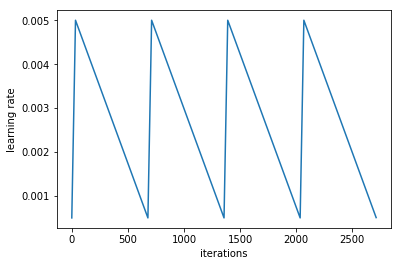

In [20]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

###add
learner.sched.plot_lr()

In [21]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<25:38,  4.55s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:47,  3.70s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:27,  3.12s/it, loss=0.633]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:01,  2.69s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:31,  2.43s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:24,  2.23s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:29,  2.08s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:48,  1.96s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:31,  1.91s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:18,  1.88s/it, loss=0.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:04,  1.84s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:56,  1.83s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:53,  1.82s/it, loss=0.633]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:54,  1.83s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:52,  1.83s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<09:41,  1.80s/it, loss=0.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:35,  1.79s/it, loss=0.633]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:28,  1.77s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:21,  1.75s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:56,  1.68s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<13:58,  2.64s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<12:37,  2.39s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:48,  2.24s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<11:01,  2.10s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:39,  2.04s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<10:23,  1.99s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<10:00,  1.93s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:49,  1.90s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<09:32,  1.85s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<09:18,  1.81s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<09:15,  1.80s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:16,  1.81s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:23,  1.84s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:08,  1.80s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<09:03,  1.79s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<08:53,  1.76s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:11<09:17,  1.84s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:13<09:10,  1.83s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:15<08:43,  1.74s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:21,  1.68s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:21<12:33,  2.53s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:22<11:20,  2.29s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:31,  2.13s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:26<09:45,  1.98s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:29,  1.94s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:29<09:14,  1.89s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:31<09:12,  1.89s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:33<08:56,  1.84s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<09:09,  1.89s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:57,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:38<08:44,  1.82s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:40<08:41,  1.82s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:37,  1.81s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:38,  1.82s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:34,  1.81s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:47<08:29,  1.80s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:49<08:18,  1.77s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:22,  1.79s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<08:07,  1.74s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:54<07:46,  1.67s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:44,  2.53s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:00<10:28,  2.27s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:02<09:53,  2.15s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:16,  2.02s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<08:56,  1.96s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:07<08:28,  1.86s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:09<08:15,  1.82s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:11<08:12,  1.82s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:02,  1.79s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:14<07:59,  1.78s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:16<07:54,  1.77s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:18<07:46,  1.75s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<07:46,  1.75s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:21<07:42,  1.75s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:23<07:40,  1.74s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:25<07:43,  1.76s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:27<07:30,  1.72s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:28<07:28,  1.72s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:30<07:23,  1.71s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:31<07:06,  1.65s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:36<10:21,  2.41s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:37<09:20,  2.18s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:39<09:05,  2.13s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:41<08:30,  2.00s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:43<08:07,  1.92s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:44<07:53,  1.87s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:46<08:00,  1.91s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:48<07:44,  1.85s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:50<07:31,  1.81s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:52<07:23,  1.78s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:53<07:29,  1.81s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:55<07:22,  1.79s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:57<07:10,  1.75s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:59<07:13,  1.77s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:00<07:12,  1.77s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:02<07:06,  1.76s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:04<07:06,  1.76s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:06<07:00,  1.75s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:08<07:10,  1.79s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:09<06:49,  1.71s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:14<10:03,  2.54s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:15<09:01,  2.29s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:17<08:40,  2.21s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:19<08:06,  2.07s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:21<07:47,  2.00s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:23<07:28,  1.92s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:24<07:13,  1.87s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:26<07:05,  1.84s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:28<07:10,  1.87s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:30<07:01,  1.84s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:32<07:28,  1.97s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:34<07:08,  1.89s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:36<07:04,  1.88s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:37<06:58,  1.86s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:39<06:54,  1.85s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:41<06:41,  1.80s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:43<06:37,  1.79s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:44<06:29,  1.76s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:46<06:43,  1.84s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:48<06:20,  1.74s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:53<09:38,  2.65s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:54<08:34,  2.37s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:56<07:57,  2.21s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:58<07:27,  2.08s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:00<07:01,  1.97s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:02<06:42,  1.89s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:03<06:37,  1.88s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:05<06:25,  1.83s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:07<06:22,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:09<06:15,  1.79s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:10<06:18,  1.82s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:12<06:08,  1.78s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:14<06:20,  1.85s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:16<06:15,  1.83s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:18<06:04,  1.79s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:19<06:04,  1.79s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:21<06:00,  1.78s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:23<05:53,  1.76s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:25<05:48,  1.74s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:26<05:32,  1.67s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:31<08:16,  2.51s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:32<07:32,  2.30s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:34<06:53,  2.11s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:36<06:28,  1.99s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:38<06:14,  1.93s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:39<05:57,  1.85s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:41<05:46,  1.81s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:43<05:36,  1.76s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:44<05:40,  1.79s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:46<05:34,  1.77s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:48<05:38,  1.80s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:50<05:35,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:52<05:32,  1.79s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:53<05:32,  1.80s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:55<05:34,  1.82s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:57<05:29,  1.80s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:59<05:26,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:01<05:21,  1.78s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:02<05:07,  1.71s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:04<04:55,  1.65s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:08<07:12,  2.43s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:10<06:32,  2.22s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:11<06:05,  2.08s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:13<05:44,  1.97s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:15<05:39,  1.95s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:17<05:21,  1.86s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:19<05:23,  1.88s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:20<05:12,  1.83s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:22<05:09,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:24<05:01,  1.78s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:26<05:06,  1.83s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:27<05:00,  1.80s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:29<04:55,  1.78s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:31<04:49,  1.75s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:33<05:19,  1.95s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:35<05:03,  1.86s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:37<05:13,  1.93s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:39<05:02,  1.88s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:40<04:52,  1.83s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:42<04:35,  1.73s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:46<06:39,  2.53s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:48<05:59,  2.29s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:50<05:36,  2.16s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:52<05:17,  2.05s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:54<05:05,  1.98s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:55<04:48,  1.88s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:57<04:48,  1.90s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:59<04:38,  1.84s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:01<04:35,  1.84s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:02<04:26,  1.79s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:04<04:36,  1.87s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:06<04:30,  1.84s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:08<04:28,  1.84s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:10<04:18,  1.78s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:11<04:17,  1.79s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:13<04:16,  1.80s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:15<04:14,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:17<04:10,  1.78s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:19<04:11,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:20<03:57,  1.71s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:24<05:43,  2.49s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:26<05:10,  2.27s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:28<04:46,  2.11s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:30<04:33,  2.03s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:32<04:22,  1.96s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:33<04:11,  1.89s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:35<04:00,  1.82s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:37<03:52,  1.77s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:38<03:52,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:40<03:51,  1.79s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:42<03:53,  1.82s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:44<03:48,  1.80s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:46<03:43,  1.77s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:47<03:38,  1.75s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:49<03:39,  1.77s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:51<03:38,  1.78s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:53<03:36,  1.78s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:54<03:33,  1.77s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:56<03:30,  1.76s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:58<03:20,  1.68s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:02<04:52,  2.48s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:04<04:21,  2.24s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:06<04:08,  2.14s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:07<03:52,  2.02s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:09<03:41,  1.94s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:11<03:32,  1.88s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:13<03:29,  1.87s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:14<03:20,  1.81s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:16<03:16,  1.78s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:18<03:14,  1.78s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:20<03:08,  1.75s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:21<03:11,  1.79s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:23<03:12,  1.82s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:25<03:10,  1.81s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:27<03:10,  1.83s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:29<03:04,  1.80s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:31<03:10,  1.87s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:32<03:04,  1.83s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:35<03:12,  1.93s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:36<02:58,  1.80s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:41<04:13,  2.59s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:42<03:45,  2.32s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:44<03:27,  2.16s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:46<03:13,  2.04s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:48<03:03,  1.95s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:49<02:57,  1.91s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:51<02:53,  1.89s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:53<02:46,  1.83s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:55<02:51,  1.91s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:57<02:48,  1.89s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:59<02:41,  1.84s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:00<02:39,  1.83s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:02<02:35,  1.81s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:04<02:33,  1.81s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:06<02:29,  1.78s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:07<02:25,  1.75s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:09<02:22,  1.74s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:11<02:19,  1.72s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:12<02:13,  1.67s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:14<02:08,  1.62s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:19<03:21,  2.59s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:20<03:01,  2.36s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:22<02:45,  2.18s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:24<02:32,  2.03s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:26<02:24,  1.96s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:27<02:16,  1.88s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:29<02:17,  1.91s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:31<02:11,  1.85s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:33<02:11,  1.88s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:35<02:07,  1.85s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:37<02:07,  1.88s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:39<02:03,  1.84s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:40<01:58,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:42<01:56,  1.79s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:44<01:56,  1.82s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:46<01:51,  1.78s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:47<01:52,  1.82s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:49<01:49,  1.80s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:51<01:45,  1.75s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:52<01:39,  1.68s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:57<02:29,  2.58s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:59<02:12,  2.32s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:01<02:00,  2.15s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:02<01:53,  2.07s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:04<01:48,  2.00s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:06<01:42,  1.93s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:08<01:40,  1.93s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:10<01:35,  1.87s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:12<01:37,  1.96s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:14<01:32,  1.89s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:15<01:27,  1.83s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:17<01:23,  1.78s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:19<01:23,  1.80s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:20<01:19,  1.77s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:22<01:18,  1.77s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:24<01:16,  1.78s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:26<01:15,  1.79s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:27<01:11,  1.74s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:30<01:13,  1.83s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:31<01:07,  1.74s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:35<01:36,  2.54s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:37<01:24,  2.28s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:39<01:18,  2.18s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:41<01:12,  2.07s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:43<01:08,  2.02s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:45<01:05,  1.98s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:46<01:00,  1.89s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:48<00:57,  1.86s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:50<00:54,  1.83s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:52<00:52,  1.80s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:53<00:49,  1.76s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:55<00:46,  1.73s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:57<00:45,  1.76s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:58<00:43,  1.74s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:00<00:41,  1.74s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:02<00:39,  1.72s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:04<00:40,  1.82s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:06<00:37,  1.79s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:07<00:35,  1.80s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:09<00:32,  1.71s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:14<00:46,  2.57s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:15<00:39,  2.30s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:17<00:34,  2.15s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:19<00:30,  2.04s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:21<00:28,  2.04s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:23<00:25,  1.96s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:24<00:22,  1.89s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:26<00:20,  1.86s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:28<00:18,  1.83s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:30<00:16,  1.79s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:31<00:14,  1.78s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:33<00:12,  1.75s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:35<00:10,  1.74s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:37<00:08,  1.77s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:38<00:07,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:40<00:05,  1.79s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:42<00:03,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:44<00:01,  1.74s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                         
    0      0.725373   0.732797   0.966516  
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:36,  4.37s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:03,  3.57s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<17:01,  3.04s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:47,  2.65s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:29,  2.42s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:21,  2.23s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:37,  2.10s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:58,  1.99s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:24,  1.89s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:16,  1.87s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<09:57,  1.82s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:49,  1.80s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:38,  1.78s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:39,  1.78s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:27,  1.75s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:21,  1.74s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:20,  1.74s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:12,  1.72s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:58,  1.68s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:41,  1.63s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<14:15,  2.69s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<13:02,  2.47s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<12:51,  2.44s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<11:42,  2.23s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<11:25,  2.18s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<10:40,  2.05s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<10:17,  1.98s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:45,  1.88s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<10:09,  1.97s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:42,  1.89s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<09:23,  1.83s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:07,  1.78s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:29,  1.86s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:18,  1.83s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:08<09:21,  1.85s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<09:09,  1.81s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<09:00,  1.79s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:13<08:46,  1.75s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:15<08:35,  1.72s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:15,  1.66s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:21<12:17,  2.48s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:23<11:12,  2.26s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:29,  2.13s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:26<10:00,  2.03s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:35,  1.96s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:30<09:15,  1.90s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:32<09:15,  1.90s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:33<09:04,  1.87s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<08:55,  1.85s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:37,  1.79s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:39<08:37,  1.80s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:40<08:31,  1.78s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:50,  1.86s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:38,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:44,  1.85s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:48<08:35,  1.82s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:50<08:25,  1.79s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:16,  1.77s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<07:57,  1.70s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:54<07:39,  1.65s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:24,  2.46s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:00<10:15,  2.22s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:02<09:42,  2.11s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:03,  1.98s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<08:48,  1.93s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:48,  1.93s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:09<08:26,  1.86s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:11<08:13,  1.82s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:04,  1.79s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:06,  1.81s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:16<08:04,  1.81s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:18<08:01,  1.80s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<07:52,  1.78s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<07:44,  1.75s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:23<07:38,  1.74s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:25<07:38,  1.74s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:27<07:34,  1.73s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:29<07:30,  1.73s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:30<07:15,  1.68s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:32<07:01,  1.63s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:36<10:23,  2.42s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:38<09:28,  2.21s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:40<09:26,  2.21s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:42<08:54,  2.10s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:44<08:54,  2.10s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:45<08:17,  1.97s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:48<08:44,  2.08s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:50<08:17,  1.98s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:51<07:51,  1.89s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:53<07:40,  1.85s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:55<07:39,  1.85s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:57<07:32,  1.83s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:58<07:21,  1.79s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:00<07:13,  1.77s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:02<07:15,  1.79s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:04<07:13,  1.78s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:05<07:17,  1.81s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:07<07:13,  1.80s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:09<06:59,  1.75s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:10<06:40,  1.68s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:15<09:44,  2.45s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:16<08:52,  2.25s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:18<08:17,  2.11s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:20<08:02,  2.05s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:22<07:59,  2.05s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:24<07:30,  1.94s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:37,  1.97s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:28<07:21,  1.91s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<07:28,  1.95s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:31<07:12,  1.89s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:33<07:10,  1.89s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<07:01,  1.86s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:56,  1.84s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:39<06:44,  1.80s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:40<06:45,  1.81s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:42<06:40,  1.80s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:44<06:34,  1.78s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:46<06:28,  1.76s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:47<06:15,  1.71s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:49<06:00,  1.65s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:53<08:46,  2.41s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:55<08:04,  2.23s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:57<07:28,  2.08s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:58<07:04,  1.98s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:00<06:42,  1.88s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:02<06:28,  1.82s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:04<06:33,  1.85s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:05<06:26,  1.83s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:07<06:25,  1.83s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:09<06:13,  1.79s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:11<06:19,  1.83s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:12<06:11,  1.79s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:14<06:08,  1.79s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:16<06:04,  1.78s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:18<06:02,  1.78s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:20<05:59,  1.77s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:21<05:56,  1.77s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:23<05:51,  1.75s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:25<05:35,  1.68s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:26<05:23,  1.63s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:30<08:06,  2.46s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:32<07:16,  2.22s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:34<06:51,  2.10s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:36<06:33,  2.02s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:37<06:14,  1.93s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:39<05:59,  1.86s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:41<05:54,  1.85s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:43<05:50,  1.84s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:45<05:49,  1.84s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:46<05:47,  1.84s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:48<05:54,  1.89s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:50<05:43,  1.84s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:52<05:51,  1.89s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:54<05:49,  1.89s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:56<05:40,  1.85s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:57<05:28,  1.80s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:59<05:23,  1.78s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:01<05:19,  1.77s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:03<05:07,  1.71s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:04<04:55,  1.65s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:09<07:25,  2.50s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:10<06:38,  2.25s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:12<06:09,  2.10s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:14<05:50,  2.00s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:16<05:36,  1.94s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:17<05:24,  1.88s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:19<05:17,  1.85s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:21<05:07,  1.80s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:23<05:10,  1.83s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:24<05:00,  1.78s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:26<05:02,  1.80s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:28<04:57,  1.78s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:30<05:01,  1.82s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:31<04:55,  1.79s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:33<04:59,  1.83s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:35<04:57,  1.83s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:37<04:53,  1.81s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:39<04:47,  1.79s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:40<04:34,  1.71s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:42<04:22,  1.65s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:46<06:21,  2.42s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:48<05:53,  2.25s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:50<05:28,  2.11s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:51<05:06,  1.98s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:53<04:56,  1.92s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:55<04:41,  1.84s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:57<04:54,  1.94s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:59<04:47,  1.90s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:01<04:50,  1.93s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:02<04:40,  1.88s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:04<04:39,  1.89s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:06<04:32,  1.85s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:08<04:25,  1.82s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:10<04:22,  1.81s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:11<04:18,  1.80s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:13<04:17,  1.80s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:15<04:12,  1.78s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:17<04:09,  1.77s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:18<03:58,  1.70s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:20<03:49,  1.65s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:24<05:42,  2.48s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:26<05:12,  2.28s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:28<04:52,  2.15s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:30<04:30,  2.00s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:32<04:36,  2.07s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:34<04:24,  1.99s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:35<04:13,  1.92s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:37<03:59,  1.83s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:39<04:00,  1.85s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:41<03:52,  1.80s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:43<04:04,  1.91s/it, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:45<03:58,  1.88s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:47<04:11,  1.99s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:49<03:59,  1.92s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:50<03:48,  1.84s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:52<03:41,  1.80s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:54<03:39,  1.80s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:55<03:33,  1.77s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:57<03:24,  1.70s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:58<03:16,  1.65s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:03<05:02,  2.57s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:05<04:30,  2.31s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:07<04:10,  2.16s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:09<03:56,  2.06s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:10<03:43,  1.96s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:12<03:34,  1.90s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:14<03:28,  1.86s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:16<03:23,  1.83s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:17<03:16,  1.79s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:19<03:14,  1.78s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:21<03:09,  1.75s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:22<03:06,  1.74s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:24<03:11,  1.80s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:26<03:07,  1.79s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:28<03:05,  1.78s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:30<03:00,  1.75s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:31<02:56,  1.73s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:33<02:54,  1.73s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:35<02:53,  1.74s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:36<02:45,  1.67s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:41<04:00,  2.46s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:42<03:37,  2.25s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:44<03:18,  2.07s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:46<03:04,  1.94s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:48<03:02,  1.94s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:49<02:55,  1.89s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:51<02:53,  1.89s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:53<02:50,  1.87s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:55<02:44,  1.83s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:56<02:38,  1.78s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:58<02:41,  1.83s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:00<02:37,  1.82s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:02<02:34,  1.80s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:04<02:30,  1.77s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:05<02:29,  1.78s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:07<02:27,  1.78s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:09<02:31,  1.84s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:11<02:25,  1.79s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:13<02:23,  1.79s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:14<02:14,  1.70s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:18<03:12,  2.47s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:20<02:51,  2.23s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:22<02:46,  2.19s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:24<02:33,  2.04s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:26<02:28,  2.01s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:27<02:18,  1.90s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:30<02:22,  1.98s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:31<02:14,  1.90s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:33<02:11,  1.88s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:35<02:07,  1.85s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:37<02:04,  1.84s/it, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:38<01:59,  1.79s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:40<01:58,  1.80s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:42<01:56,  1.80s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:44<01:58,  1.84s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:46<01:56,  1.84s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:48<02:06,  2.04s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:50<01:59,  1.97s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:52<01:50,  1.85s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:53<01:43,  1.75s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:58<02:27,  2.55s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:59<02:09,  2.27s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:01<01:59,  2.13s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:03<01:50,  2.01s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:04<01:44,  1.93s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:06<01:41,  1.91s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:08<01:38,  1.89s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:10<01:33,  1.83s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:12<01:32,  1.85s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:13<01:28,  1.81s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:15<01:27,  1.82s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:17<01:25,  1.81s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:19<01:23,  1.81s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:21<01:20,  1.79s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:22<01:17,  1.76s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:24<01:16,  1.78s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:26<01:15,  1.80s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:28<01:14,  1.81s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:29<01:09,  1.74s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:31<01:05,  1.68s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:36<01:36,  2.54s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:37<01:25,  2.32s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:39<01:17,  2.15s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:41<01:10,  2.02s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:43<01:09,  2.03s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:45<01:04,  1.95s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:46<01:00,  1.89s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:48<00:57,  1.84s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:50<00:54,  1.83s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:52<00:51,  1.78s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:53<00:50,  1.82s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:55<00:47,  1.77s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:57<00:46,  1.80s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:59<00:45,  1.83s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:01<00:43,  1.83s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:03<00:41,  1.81s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:04<00:39,  1.80s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:06<00:37,  1.77s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:08<00:34,  1.70s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:09<00:31,  1.65s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:14<00:45,  2.55s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:15<00:38,  2.28s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:17<00:33,  2.11s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:19<00:29,  1.97s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:20<00:26,  1.91s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:22<00:24,  1.86s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:24<00:22,  1.89s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:26<00:20,  1.88s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:28<00:18,  1.89s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:30<00:16,  1.85s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:32<00:14,  1.84s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:33<00:12,  1.81s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:35<00:10,  1.80s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:37<00:08,  1.79s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:39<00:07,  1.75s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:40<00:05,  1.73s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:42<00:03,  1.79s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:44<00:01,  1.73s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    1      0.691812   0.666204   0.968228                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<27:09,  4.82s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:54,  3.90s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:19,  3.27s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:46,  2.82s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:19,  2.57s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:57,  2.34s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:24,  2.24s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:40,  2.12s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<10:57,  1.99s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:24,  1.90s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:14,  1.87s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:01,  1.84s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<09:49,  1.81s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<09:42,  1.79s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<09:53,  1.83s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<09:45,  1.81s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:25,  1.76s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<09:21,  1.75s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:04,  1.70s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<08:46,  1.65s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:41,  2.58s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<12:11,  2.31s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:55,  2.26s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:58,  2.09s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:16,  1.96s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<09:55,  1.90s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:40,  1.86s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:30,  1.84s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<09:16,  1.80s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:25,  1.83s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<09:06,  1.77s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:05,  1.78s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<08:51,  1.74s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<08:50,  1.74s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<08:46,  1.73s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<08:53,  1.76s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:11<08:49,  1.75s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:13<08:41,  1.73s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:14<08:25,  1.68s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:07,  1.63s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:20<12:21,  2.49s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:22<11:09,  2.25s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:25,  2.11s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:25<09:53,  2.01s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:27<09:33,  1.95s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:29<09:05,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:30<08:48,  1.81s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:32<08:48,  1.81s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:34<08:47,  1.82s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:36<08:45,  1.82s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:38<08:54,  1.86s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:40<08:41,  1.82s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:52,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:43<08:41,  1.83s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:45<08:24,  1.78s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:47<08:25,  1.79s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:49<08:19,  1.77s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:50<08:15,  1.76s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:52<08:04,  1.73s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:53<07:44,  1.66s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:58<12:03,  2.60s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:00<10:54,  2.36s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:02<10:41,  2.32s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:43,  2.12s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<09:20,  2.05s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:55,  1.96s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:51,  1.95s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:11<08:29,  1.88s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:14,  1.83s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:05,  1.80s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:06,  1.82s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:18<07:52,  1.77s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<08:28,  1.91s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<08:18,  1.88s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:24<08:01,  1.82s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:26<07:53,  1.80s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:28<08:15,  1.89s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:30<08:02,  1.85s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:31<07:58,  1.84s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:33<07:31,  1.74s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:38<11:23,  2.65s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:39<10:14,  2.39s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:41<09:28,  2.22s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:43<08:46,  2.07s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:45<08:14,  1.95s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:46<07:48,  1.85s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:48<07:48,  1.86s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:50<07:35,  1.81s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:52<07:33,  1.82s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:53<07:23,  1.78s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:55<07:35,  1.84s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:57<07:20,  1.79s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:59<07:22,  1.80s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:01<07:23,  1.81s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:02<07:21,  1.81s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:04<07:18,  1.80s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:06<07:33,  1.87s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:08<07:23,  1.84s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:10<07:03,  1.76s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<06:43,  1.69s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:16<10:01,  2.53s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:17<08:58,  2.27s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:19<08:29,  2.16s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:21<08:06,  2.07s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:23<07:47,  2.00s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:25<07:29,  1.93s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:27<07:46,  2.01s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:29<07:28,  1.94s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:31<07:28,  1.95s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:32<07:12,  1.89s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:34<07:03,  1.86s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:36<06:53,  1.82s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:38<07:00,  1.86s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:40<06:50,  1.82s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:41<06:49,  1.83s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:43<06:40,  1.80s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:45<06:46,  1.83s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:47<06:39,  1.81s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:49<06:45,  1.84s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:50<06:22,  1.75s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:55<09:31,  2.62s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:57<08:35,  2.38s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:59<08:20,  2.31s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:01<07:45,  2.16s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:03<07:42,  2.16s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:05<07:11,  2.02s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:06<06:45,  1.91s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:08<06:29,  1.84s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:10<06:34,  1.88s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:12<06:25,  1.85s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:13<06:20,  1.83s/it, loss=0.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:15<06:10,  1.79s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:17<06:10,  1.80s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:19<06:06,  1.79s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:21<06:12,  1.83s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:22<06:06,  1.80s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:24<06:06,  1.81s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:26<05:59,  1.79s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:28<05:48,  1.74s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:29<05:32,  1.67s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:34<08:21,  2.53s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:35<07:35,  2.31s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:37<06:59,  2.14s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:39<06:31,  2.01s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:41<06:15,  1.94s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:42<05:57,  1.85s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:44<05:54,  1.85s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:46<05:46,  1.81s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:48<05:38,  1.78s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:49<05:34,  1.77s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:51<05:36,  1.79s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:53<05:41,  1.83s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:55<05:33,  1.79s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:56<05:25,  1.76s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:58<05:36,  1.83s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:00<05:31,  1.81s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:02<05:31,  1.82s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:04<05:21,  1.77s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:05<05:10,  1.73s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:07<04:57,  1.66s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:11<07:24,  2.50s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:13<06:50,  2.32s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:15<06:18,  2.15s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:17<05:55,  2.03s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:19<05:59,  2.07s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:21<05:45,  2.00s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:23<05:37,  1.96s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:24<05:23,  1.89s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:26<05:18,  1.87s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:28<05:10,  1.83s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:30<05:02,  1.80s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:31<04:54,  1.77s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:33<05:07,  1.85s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:35<04:58,  1.81s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:37<04:54,  1.80s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:39<04:49,  1.77s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:40<04:50,  1.79s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:42<04:44,  1.77s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:44<04:38,  1.74s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:45<04:26,  1.68s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:50<06:36,  2.51s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:51<05:53,  2.25s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:53<05:36,  2.15s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:55<05:21,  2.07s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:57<05:23,  2.10s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:59<05:13,  2.05s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:01<05:16,  2.08s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:03<05:00,  1.99s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:05<05:06,  2.04s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:07<04:52,  1.96s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:09<04:47,  1.94s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:11<04:35,  1.88s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:13<04:28,  1.84s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:14<04:19,  1.79s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:16<04:11,  1.75s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:18<04:12,  1.76s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:19<04:07,  1.74s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:21<04:04,  1.73s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:23<03:55,  1.68s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:24<03:46,  1.63s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:29<05:39,  2.46s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:30<05:06,  2.24s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:32<04:45,  2.10s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:34<04:25,  1.96s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:36<04:20,  1.95s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:37<04:07,  1.86s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:39<04:08,  1.88s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:41<04:03,  1.86s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:43<04:02,  1.86s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:45<03:55,  1.82s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:47<04:00,  1.88s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:48<03:52,  1.83s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:50<03:49,  1.83s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:52<03:45,  1.80s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:54<03:44,  1.81s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:55<03:39,  1.79s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:57<03:36,  1.78s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:59<03:35,  1.78s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:00<03:24,  1.70s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:02<03:15,  1.64s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:06<04:51,  2.47s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:08<04:22,  2.24s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:10<04:01,  2.09s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:12<03:49,  1.99s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:13<03:44,  1.97s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:15<03:36,  1.92s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:17<03:27,  1.85s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:19<03:22,  1.83s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:21<03:20,  1.83s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:22<03:13,  1.78s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:24<03:13,  1.79s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:26<03:10,  1.78s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:28<03:07,  1.77s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:29<03:04,  1.75s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:31<03:05,  1.79s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:33<03:04,  1.79s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:35<03:01,  1.78s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:37<03:00,  1.79s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:38<02:52,  1.72s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:40<02:44,  1.66s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:44<04:11,  2.57s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:46<03:44,  2.32s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:48<03:25,  2.14s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:49<03:10,  2.00s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:52<03:15,  2.08s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:54<03:07,  2.01s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:55<03:00,  1.96s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:57<02:52,  1.90s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:59<02:59,  1.99s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:01<02:56,  1.98s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:03<02:50,  1.94s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:05<02:42,  1.87s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:07<02:45,  1.92s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:09<02:38,  1.86s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:10<02:34,  1.84s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:12<02:32,  1.83s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:14<02:28,  1.82s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:16<02:26,  1.81s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:17<02:19,  1.74s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:19<02:12,  1.68s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:23<03:14,  2.50s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:25<02:55,  2.28s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:27<02:38,  2.09s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:28<02:29,  1.99s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:30<02:23,  1.94s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:32<02:17,  1.88s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:34<02:16,  1.90s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:36<02:11,  1.85s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:38<02:13,  1.91s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:40<02:08,  1.86s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:42<02:11,  1.93s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:43<02:06,  1.88s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:45<02:00,  1.83s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:47<01:58,  1.83s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:49<01:55,  1.81s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:50<01:53,  1.80s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:52<01:50,  1.78s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:54<01:46,  1.75s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:55<01:41,  1.69s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:57<01:36,  1.64s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:01<02:23,  2.47s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:03<02:07,  2.24s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:05<01:57,  2.11s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:07<01:50,  2.00s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:08<01:44,  1.94s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:10<01:40,  1.89s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:12<01:37,  1.88s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:14<01:33,  1.83s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:16<01:32,  1.86s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:17<01:29,  1.82s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:19<01:28,  1.84s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:21<01:24,  1.80s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:23<01:21,  1.77s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:24<01:18,  1.75s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:26<01:21,  1.84s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:28<01:17,  1.81s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:30<01:16,  1.83s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:32<01:13,  1.79s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:33<01:09,  1.74s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:35<01:05,  1.68s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:40<01:40,  2.64s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:42<01:27,  2.36s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:43<01:20,  2.23s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:45<01:13,  2.10s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:47<01:07,  1.99s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:49<01:02,  1.89s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:51<01:01,  1.92s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:52<00:58,  1.88s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:54<00:54,  1.83s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:56<00:51,  1.79s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:58<00:52,  1.88s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:00<00:50,  1.89s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:02<00:51,  1.98s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:04<00:47,  1.91s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:06<00:45,  1.91s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:07<00:42,  1.87s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:09<00:40,  1.83s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:11<00:37,  1.77s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:13<00:36,  1.82s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:14<00:32,  1.73s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:19<00:47,  2.65s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:21<00:40,  2.37s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:23<00:34,  2.19s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:24<00:30,  2.05s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:26<00:27,  1.99s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:28<00:24,  1.92s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:30<00:23,  1.92s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:31<00:20,  1.86s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:33<00:18,  1.84s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:35<00:16,  1.81s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:37<00:14,  1.79s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:38<00:12,  1.76s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:40<00:10,  1.83s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:42<00:09,  1.83s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:44<00:07,  1.82s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:46<00:05,  1.83s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:48<00:03,  1.87s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:49<00:01,  1.79s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    2      0.643366   0.638938   0.969435                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<26:58,  4.79s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:46,  3.88s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:15,  3.26s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:41,  2.81s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:10,  2.55s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:49,  2.31s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:54,  2.15s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:04,  2.01s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<10:47,  1.96s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:19,  1.88s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:16,  1.88s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:01,  1.84s/it, loss=0.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<09:47,  1.80s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:31,  1.76s/it, loss=0.636]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:30,  1.76s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<09:22,  1.74s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:08,  1.70s/it, loss=0.631]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:05,  1.70s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<08:58,  1.68s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:40,  1.63s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<13:04,  2.47s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<12:01,  2.28s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<11:14,  2.13s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:47<10:31,  2.00s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<10:27,  2.00s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<10:02,  1.93s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:53,  1.90s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:54<09:32,  1.84s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:56<09:18,  1.80s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<09:16,  1.80s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<09:57,  1.94s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:32,  1.86s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:49,  1.93s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:36,  1.89s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:08<09:47,  1.93s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<09:37,  1.91s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<10:04,  2.00s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<09:44,  1.94s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:15<09:31,  1.91s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:55,  1.79s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:21<12:52,  2.59s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:23<11:31,  2.33s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:25<10:45,  2.18s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:27<10:10,  2.07s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:37,  1.96s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:30<09:13,  1.89s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:32<09:09,  1.88s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:34<08:52,  1.83s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<08:47,  1.82s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:39,  1.80s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:39<08:35,  1.79s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:41<08:31,  1.78s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:42<08:24,  1.77s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:44<08:26,  1.78s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:22,  1.77s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:48<08:20,  1.77s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:50<08:17,  1.77s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:19,  1.78s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<08:04,  1.73s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:55<07:44,  1.67s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:35,  2.50s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:01<10:29,  2.27s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:03<09:59,  2.17s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:04<09:24,  2.05s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:06<08:59,  1.97s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:50,  1.94s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:29,  1.87s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:12<08:21,  1.85s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:13<08:10,  1.82s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<07:59,  1.78s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:01,  1.80s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:19<07:48,  1.75s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:20<07:41,  1.73s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:22<07:44,  1.75s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:24<07:42,  1.75s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:26<07:42,  1.76s/it, loss=0.633]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:27<07:50,  1.80s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:29<07:43,  1.77s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:31<07:39,  1.77s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:32<07:18,  1.69s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:37<11:02,  2.57s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:39<09:54,  2.31s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:40<09:00,  2.11s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:42<08:42,  2.05s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:44<08:26,  1.99s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:46<08:05,  1.92s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:48<07:48,  1.86s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:49<07:44,  1.85s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:51<07:30,  1.80s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:53<07:20,  1.77s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:54<07:09,  1.73s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:56<07:07,  1.73s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:58<07:11,  1.75s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:00<07:02,  1.72s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:01<06:59,  1.72s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:03<07:04,  1.74s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:05<07:28,  1.85s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:07<07:22,  1.84s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:09<07:42,  1.93s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<07:11,  1.81s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:15<10:02,  2.53s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:17<09:03,  2.29s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:19<09:07,  2.32s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:21<08:19,  2.13s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:22<07:46,  2.00s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:24<07:30,  1.93s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:12,  1.87s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:28<07:01,  1.83s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<07:03,  1.84s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:31<06:51,  1.80s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:33<06:52,  1.81s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<06:47,  1.80s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:42,  1.78s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:38<06:41,  1.78s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:40<06:32,  1.75s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:42<06:26,  1.73s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:44<06:34,  1.78s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:45<06:37,  1.80s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:47<06:19,  1.73s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:49<06:03,  1.66s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:53<09:18,  2.56s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:55<08:16,  2.29s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:57<07:58,  2.22s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:59<07:23,  2.06s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:00<06:54,  1.94s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:02<06:42,  1.89s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:04<06:56,  1.96s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:06<06:42,  1.91s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:08<06:35,  1.89s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:10<06:28,  1.86s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:11<06:28,  1.87s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:13<06:21,  1.84s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:15<06:12,  1.81s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:17<06:13,  1.82s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:19<06:15,  1.84s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:20<06:06,  1.80s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:22<06:00,  1.78s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:24<05:53,  1.76s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:25<05:41,  1.71s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:27<05:27,  1.65s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:31<08:09,  2.47s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:33<07:20,  2.24s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:35<06:47,  2.08s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:37<06:32,  2.01s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:38<06:19,  1.95s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:40<06:09,  1.91s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:42<05:58,  1.87s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:44<05:51,  1.84s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:45<05:43,  1.81s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:47<05:33,  1.76s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:49<05:50,  1.86s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:51<05:43,  1.84s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:53<05:39,  1.83s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:55<05:37,  1.82s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:56<05:33,  1.81s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:58<05:30,  1.80s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:00<05:30,  1.82s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:02<05:28,  1.81s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:04<05:19,  1.78s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:05<05:04,  1.70s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:10<08:19,  2.80s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:12<07:21,  2.50s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:14<06:44,  2.30s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:16<06:15,  2.14s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:18<05:51,  2.02s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:19<05:30,  1.91s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:21<05:21,  1.87s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:23<05:14,  1.84s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:24<05:03,  1.78s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:26<04:54,  1.74s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:28<05:04,  1.81s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:30<04:55,  1.77s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:32<05:01,  1.82s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:33<04:55,  1.79s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:35<04:56,  1.81s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:37<04:59,  1.83s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:39<04:55,  1.83s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:41<04:54,  1.83s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:42<04:40,  1.75s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:44<04:26,  1.68s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:48<06:25,  2.44s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:50<05:49,  2.23s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:52<05:33,  2.14s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:54<05:16,  2.04s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:55<05:01,  1.96s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:57<04:50,  1.90s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:59<04:43,  1.86s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:01<04:36,  1.83s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:03<04:40,  1.87s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:04<04:33,  1.84s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:06<04:39,  1.89s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:08<04:28,  1.83s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:10<04:39,  1.91s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:12<04:30,  1.87s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:14<04:31,  1.88s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:16<04:25,  1.86s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:18<04:33,  1.93s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:19<04:25,  1.88s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:21<04:07,  1.77s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:23<03:55,  1.69s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:27<05:55,  2.58s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:29<05:19,  2.33s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:31<04:56,  2.18s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:32<04:35,  2.04s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:34<04:27,  1.99s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:36<04:13,  1.91s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:38<04:13,  1.92s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:40<04:05,  1.88s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:42<04:07,  1.90s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:43<03:57,  1.84s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:45<04:04,  1.91s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:47<03:58,  1.87s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:49<03:51,  1.84s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:51<03:45,  1.80s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:52<03:40,  1.78s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:54<03:38,  1.77s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:56<03:40,  1.81s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:58<03:32,  1.76s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:00<03:34,  1.79s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:01<03:23,  1.71s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:06<04:59,  2.54s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:07<04:29,  2.31s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:10<04:29,  2.33s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:12<04:12,  2.19s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:13<03:53,  2.05s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:15<03:39,  1.94s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:17<03:35,  1.92s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:19<03:28,  1.87s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:21<03:27,  1.89s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:22<03:20,  1.84s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:24<03:14,  1.81s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:26<03:12,  1.79s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:28<03:09,  1.79s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:29<03:07,  1.78s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:31<03:04,  1.77s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:33<03:00,  1.75s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:35<03:02,  1.79s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:36<02:58,  1.76s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:38<02:49,  1.70s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:39<02:42,  1.64s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:44<03:57,  2.42s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:45<03:33,  2.20s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:47<03:21,  2.10s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:49<03:08,  1.99s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:51<02:56,  1.88s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:52<02:51,  1.84s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:54<02:49,  1.84s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:56<02:45,  1.82s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:58<02:43,  1.81s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:00<02:42,  1.82s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:01<02:40,  1.82s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:03<02:35,  1.79s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:05<02:40,  1.87s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:07<02:33,  1.81s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:09<02:37,  1.87s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:11<02:32,  1.84s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:13<02:36,  1.90s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:14<02:31,  1.87s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:16<02:20,  1.76s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:18<02:13,  1.69s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:22<03:19,  2.56s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:24<02:57,  2.31s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:26<02:48,  2.22s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:28<02:35,  2.08s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:30<02:31,  2.04s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:31<02:23,  1.97s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:33<02:16,  1.89s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:35<02:10,  1.83s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:37<02:07,  1.82s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:38<02:04,  1.81s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:40<02:03,  1.81s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:42<01:59,  1.79s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:44<01:56,  1.77s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:45<01:55,  1.77s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:47<01:51,  1.75s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:49<01:52,  1.79s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:51<01:51,  1.80s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:53<01:48,  1.78s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:54<01:43,  1.73s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:56<01:38,  1.66s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:00<02:28,  2.56s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:02<02:11,  2.32s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:04<02:01,  2.17s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:06<01:53,  2.06s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:08<01:53,  2.10s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:10<01:48,  2.04s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:12<01:48,  2.08s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:14<01:41,  2.00s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:15<01:36,  1.93s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:17<01:32,  1.89s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:19<01:28,  1.85s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:21<01:26,  1.84s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:23<01:27,  1.91s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:25<01:24,  1.88s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:26<01:20,  1.84s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:28<01:18,  1.83s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:30<01:17,  1.84s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:32<01:14,  1.81s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:33<01:09,  1.73s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:35<01:04,  1.67s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:39<01:33,  2.47s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:41<01:24,  2.28s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:43<01:16,  2.12s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:45<01:10,  2.01s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:46<01:06,  1.96s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:48<01:03,  1.92s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:50<01:01,  1.92s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:52<00:57,  1.87s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:54<00:55,  1.86s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:56<00:54,  1.87s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:58<00:51,  1.85s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:59<00:49,  1.82s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:01<00:46,  1.77s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:03<00:43,  1.76s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:05<00:43,  1.81s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:06<00:41,  1.78s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:08<00:38,  1.75s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:10<00:37,  1.76s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:11<00:34,  1.74s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:13<00:31,  1.68s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:18<00:47,  2.65s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:20<00:40,  2.37s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:21<00:34,  2.16s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:23<00:30,  2.05s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:25<00:27,  1.94s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:26<00:24,  1.88s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:28<00:22,  1.86s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:30<00:20,  1.83s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:32<00:18,  1.86s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:34<00:16,  1.80s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:36<00:15,  1.90s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:38<00:13,  1.87s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:39<00:10,  1.83s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:41<00:09,  1.81s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:43<00:07,  1.81s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:45<00:05,  1.77s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:46<00:03,  1.80s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:48<00:01,  1.72s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    3      0.600847   0.591183   0.971979                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:48,  4.40s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:09,  3.59s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:23,  3.11s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:56,  2.68s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:24,  2.41s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:25,  2.24s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:32,  2.09s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:59,  1.99s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:21,  2.06s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:44,  1.96s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<11:17,  2.07s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:53,  2.00s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:27<11:16,  2.08s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:29<10:51,  2.01s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:30,  1.95s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:15,  1.91s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:01,  1.87s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<09:55,  1.86s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:25,  1.77s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<08:59,  1.69s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:00,  2.45s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<11:47,  2.23s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:22,  2.16s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<10:41,  2.04s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:13,  1.95s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<09:55,  1.90s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<09:35,  1.84s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:41,  1.87s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<09:25,  1.82s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:16,  1.80s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<09:27,  1.84s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:03<09:12,  1.80s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:05<09:14,  1.81s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:06<09:10,  1.81s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:08<09:18,  1.84s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<09:01,  1.79s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<08:56,  1.78s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<08:51,  1.77s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:15<08:32,  1.71s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:12,  1.65s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:21<12:38,  2.55s/it, loss=0.606]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:23<11:24,  2.30s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:25<10:29,  2.13s/it, loss=0.604]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:27<10:01,  2.04s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:28<09:42,  1.98s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:30<09:11,  1.88s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:32<08:53,  1.83s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:34<08:45,  1.81s/it, loss=0.606]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:35<08:48,  1.82s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:37<08:43,  1.81s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:39<08:41,  1.81s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:41<08:29,  1.78s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:43<08:46,  1.84s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:45<08:46,  1.85s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:46<08:37,  1.82s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:48<08:27,  1.79s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:50<08:19,  1.77s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:51<08:14,  1.76s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:53<07:57,  1.71s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:55<07:40,  1.65s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:59<11:35,  2.50s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:01<10:26,  2.26s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:03<10:15,  2.23s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:05<09:30,  2.08s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:07<09:23,  2.06s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:08<08:49,  1.94s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:10<08:33,  1.89s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:12<08:15,  1.83s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:14<08:11,  1.82s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:15<08:04,  1.80s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:17<08:06,  1.81s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:19<08:02,  1.81s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:21<08:29,  1.92s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:23<08:23,  1.90s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:25<08:23,  1.91s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:27<08:14,  1.88s/it, loss=0.635]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:29<08:12,  1.88s/it, loss=0.637]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:30<08:02,  1.85s/it, loss=0.637]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:32<07:45,  1.79s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:34<07:22,  1.71s/it, loss=0.639]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:38<10:46,  2.50s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:40<09:43,  2.27s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:42<09:15,  2.17s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:43<08:47,  2.07s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:45<08:22,  1.98s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:47<08:03,  1.91s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:49<07:44,  1.84s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:50<07:29,  1.79s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:52<07:28,  1.79s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:54<07:19,  1.77s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:56<07:19,  1.77s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:57<07:22,  1.79s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:59<07:15,  1.77s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:01<07:12,  1.77s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:03<07:22,  1.81s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:05<07:15,  1.79s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:06<07:05,  1.76s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:08<07:08,  1.78s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:10<06:53,  1.72s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:11<06:36,  1.66s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:16<10:12,  2.57s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:17<09:02,  2.29s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:20<08:44,  2.22s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:21<08:03,  2.06s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:23<07:41,  1.97s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:25<07:22,  1.90s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:26<07:06,  1.84s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:28<06:54,  1.80s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:30<06:44,  1.76s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:32<06:44,  1.77s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:33<06:41,  1.76s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:35<06:38,  1.76s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:37<06:46,  1.80s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:39<06:51,  1.83s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:41<07:15,  1.94s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:43<06:59,  1.88s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:45<07:03,  1.91s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:47<06:48,  1.85s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:48<06:42,  1.83s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:50<06:19,  1.73s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:54<09:25,  2.59s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:56<08:28,  2.35s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:58<08:04,  2.25s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:00<07:33,  2.11s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:02<07:14,  2.03s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:04<07:01,  1.98s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:06<06:55,  1.96s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:07<06:42,  1.91s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:09<06:33,  1.87s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:11<06:26,  1.85s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:13<06:29,  1.87s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:15<06:21,  1.84s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:16<06:13,  1.81s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:18<06:14,  1.83s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:20<06:15,  1.84s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:22<06:07,  1.81s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:24<06:28,  1.92s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:26<06:12,  1.85s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:27<06:02,  1.81s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:29<05:42,  1.72s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:33<08:19,  2.52s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:35<07:28,  2.28s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:37<07:07,  2.18s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:39<06:43,  2.07s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:40<06:17,  1.95s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:42<06:05,  1.90s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:44<05:57,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:46<05:50,  1.83s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:48<05:41,  1.80s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:49<05:34,  1.77s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:51<05:30,  1.76s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:53<05:32,  1.78s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:55<05:30,  1.78s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:56<05:25,  1.76s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:58<05:26,  1.78s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:00<05:26,  1.79s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:02<05:30,  1.82s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:04<05:26,  1.80s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:05<05:24,  1.80s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:07<05:07,  1.72s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:11<07:36,  2.56s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:13<06:47,  2.30s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:15<06:14,  2.13s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:17<05:47,  1.99s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:18<05:43,  1.98s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:20<05:30,  1.91s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:22<05:21,  1.87s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:24<05:14,  1.84s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:26<05:20,  1.88s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:28<05:12,  1.85s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:29<05:10,  1.85s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:31<05:04,  1.82s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:33<05:14,  1.89s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:35<05:04,  1.85s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:37<05:05,  1.86s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:39<05:00,  1.84s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:40<04:58,  1.84s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:42<04:50,  1.80s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:44<04:37,  1.73s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:45<04:24,  1.67s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:50<06:26,  2.45s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:51<05:53,  2.25s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:53<05:38,  2.17s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:55<05:15,  2.03s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:57<05:01,  1.96s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:59<04:48,  1.89s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:00<04:43,  1.87s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:02<04:35,  1.82s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:04<04:29,  1.79s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:05<04:21,  1.76s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:08<04:53,  1.98s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:10<04:39,  1.90s/it, loss=0.68] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:11<04:29,  1.85s/it, loss=0.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:13<04:28,  1.85s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:15<04:22,  1.82s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:17<04:18,  1.81s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:19<04:25,  1.87s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:21<04:19,  1.84s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:23<04:25,  1.90s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:24<04:07,  1.78s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:28<05:54,  2.57s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:30<05:13,  2.29s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:32<04:57,  2.19s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:34<04:37,  2.06s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:36<04:23,  1.96s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:37<04:09,  1.88s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:39<04:01,  1.83s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:41<03:53,  1.78s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:42<03:50,  1.77s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:44<03:44,  1.74s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:46<03:51,  1.81s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:48<03:49,  1.81s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:50<03:50,  1.83s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:51<03:45,  1.80s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:53<03:49,  1.85s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:55<03:41,  1.80s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:57<03:47,  1.87s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:59<03:39,  1.82s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:01<03:35,  1.80s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:02<03:23,  1.71s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:06<04:51,  2.47s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:08<04:21,  2.24s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:10<04:07,  2.13s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:12<03:52,  2.02s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:13<03:40,  1.94s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:15<03:29,  1.85s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:17<03:23,  1.82s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:19<03:20,  1.81s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:20<03:16,  1.78s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:22<03:16,  1.80s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:24<03:14,  1.80s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:26<03:10,  1.78s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:27<03:06,  1.76s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:29<03:04,  1.75s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:31<03:02,  1.75s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:33<02:59,  1.74s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:35<03:08,  1.85s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:37<03:05,  1.84s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:38<02:57,  1.77s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:40<02:47,  1.69s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:44<04:04,  2.50s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:46<03:41,  2.29s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:48<03:27,  2.16s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:49<03:13,  2.04s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:51<03:02,  1.94s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:53<02:57,  1.91s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:55<02:56,  1.92s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:57<02:49,  1.86s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:58<02:45,  1.83s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:00<02:40,  1.80s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:02<02:39,  1.81s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:04<02:33,  1.77s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:05<02:33,  1.78s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:07<02:34,  1.82s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:09<02:36,  1.86s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:11<02:30,  1.82s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:13<02:27,  1.79s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:14<02:22,  1.76s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:16<02:26,  1.83s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:18<02:17,  1.74s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:23<03:30,  2.69s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:25<03:05,  2.41s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:26<02:48,  2.22s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:28<02:36,  2.09s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:30<02:27,  1.99s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:32<02:21,  1.94s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:34<02:16,  1.90s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:35<02:12,  1.86s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:37<02:07,  1.82s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:39<02:03,  1.79s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:41<02:01,  1.79s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:42<02:00,  1.80s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:44<01:58,  1.79s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:46<01:55,  1.78s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:48<01:53,  1.78s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:49<01:50,  1.75s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:51<01:50,  1.79s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:53<01:49,  1.79s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:55<01:43,  1.73s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:56<01:38,  1.67s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:01<02:26,  2.53s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:03<02:11,  2.30s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:04<02:02,  2.18s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:06<01:53,  2.07s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:08<01:45,  1.95s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:10<01:38,  1.86s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:12<01:39,  1.90s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:13<01:35,  1.86s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:15<01:34,  1.89s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:17<01:29,  1.83s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:19<01:26,  1.79s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:21<01:25,  1.81s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:22<01:20,  1.75s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:24<01:18,  1.75s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:26<01:15,  1.71s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:27<01:13,  1.72s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:29<01:13,  1.74s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:31<01:11,  1.74s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:32<01:07,  1.68s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:34<01:03,  1.63s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:38<01:34,  2.48s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:40<01:24,  2.27s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:42<01:15,  2.10s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:44<01:10,  2.01s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:45<01:05,  1.92s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:47<01:00,  1.84s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:49<00:58,  1.84s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:51<00:56,  1.82s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:52<00:54,  1.81s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:54<00:51,  1.78s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:56<00:51,  1.84s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:58<00:49,  1.84s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:00<00:47,  1.84s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:01<00:45,  1.80s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:03<00:42,  1.77s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:05<00:40,  1.74s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:06<00:37,  1.73s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:08<00:36,  1.76s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:10<00:35,  1.80s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:12<00:32,  1.71s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:16<00:46,  2.59s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:18<00:40,  2.41s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:20<00:36,  2.26s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:22<00:31,  2.11s/it, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:24<00:29,  2.12s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:26<00:25,  2.00s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:28<00:24,  2.00s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:30<00:20,  1.90s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:32<00:19,  1.92s/it, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:33<00:16,  1.87s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:35<00:15,  1.92s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:37<00:13,  1.87s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:39<00:11,  1.89s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:41<00:09,  1.86s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:43<00:07,  1.82s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:44<00:05,  1.81s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:46<00:03,  1.83s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:48<00:01,  1.74s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    4      0.687839   0.681463   0.967086                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<26:04,  4.63s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<21:03,  3.75s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<18:25,  3.29s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:52,  2.84s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:30,  2.61s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:14<13:00,  2.34s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:16<12:17,  2.22s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:37,  2.11s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:16,  2.05s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<11:09,  2.03s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:39,  1.95s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:25<10:16,  1.89s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<09:54,  1.82s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<09:47,  1.81s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:05,  1.87s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<09:51,  1.83s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:16,  1.92s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:36<10:04,  1.88s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:38<09:33,  1.79s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:05,  1.71s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:15,  2.50s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<11:51,  2.24s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:35,  2.20s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<10:52,  2.07s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<10:19,  1.97s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<09:57,  1.91s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<09:57,  1.92s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:35,  1.85s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<09:19,  1.81s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<09:08,  1.77s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:01<09:05,  1.77s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:03<09:03,  1.77s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:05<09:16,  1.82s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:07<09:11,  1.81s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:13,  1.82s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:10<09:07,  1.81s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:12<09:21,  1.86s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:14<09:17,  1.85s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:16<09:12,  1.84s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:17<08:42,  1.75s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:22<12:51,  2.59s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:24<11:41,  2.36s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:26<11:02,  2.24s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<10:16,  2.09s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:30<10:28,  2.14s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:32<10:06,  2.07s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:34<10:25,  2.14s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:36<09:55,  2.05s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:38<09:44,  2.02s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:40<09:21,  1.94s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:41<09:10,  1.91s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:43<09:02,  1.89s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:45<08:59,  1.89s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:47<08:47,  1.85s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:49<09:07,  1.93s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:51<08:50,  1.87s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:53<08:39,  1.84s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:54<08:28,  1.81s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:56<08:32,  1.83s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:58<08:05,  1.74s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:03<12:44,  2.75s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:05<11:26,  2.48s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:06<10:22,  2.25s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:08<09:41,  2.11s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:10<09:04,  1.99s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:12<08:48,  1.94s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:13<08:22,  1.85s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:15<08:09,  1.81s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:17<08:25,  1.87s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:19<08:22,  1.87s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:21<08:22,  1.88s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:22<08:08,  1.83s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:24<08:17,  1.87s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:26<07:58,  1.81s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:28<08:23,  1.91s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:30<07:59,  1.82s/it, loss=0.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:32<08:12,  1.88s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:34<08:12,  1.89s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:36<08:00,  1.85s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:37<07:33,  1.75s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:42<11:36,  2.70s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:44<10:22,  2.42s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:46<09:39,  2.26s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:47<09:01,  2.13s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:50<09:01,  2.13s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:51<08:27,  2.01s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:53<08:20,  1.98s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:55<08:01,  1.92s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:57<07:56,  1.91s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:59<07:48,  1.88s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:00<07:37,  1.84s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:02<07:34,  1.84s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:04<07:39,  1.87s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:06<07:26,  1.82s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:08<07:34,  1.86s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:10<07:32,  1.86s/it, loss=0.671]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:12<07:30,  1.86s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:13<07:23,  1.84s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:15<07:01,  1.76s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:17<06:43,  1.69s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:21<10:18,  2.60s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:23<09:10,  2.32s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:25<09:07,  2.32s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:27<08:39,  2.21s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:30<08:51,  2.27s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:32<08:28,  2.18s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:34<08:21,  2.16s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:35<07:45,  2.02s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:37<07:34,  1.97s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:39<07:11,  1.88s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:41<07:17,  1.92s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:43<07:15,  1.92s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:45<07:35,  2.01s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:47<07:07,  1.90s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:49<07:19,  1.96s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:51<07:01,  1.89s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:52<06:47,  1.84s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:54<06:41,  1.82s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:56<06:25,  1.75s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:57<06:07,  1.68s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:02<09:35,  2.64s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:04<08:34,  2.37s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:06<08:06,  2.25s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:08<07:34,  2.11s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:09<07:20,  2.06s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:11<06:58,  1.97s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:13<06:48,  1.93s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:15<06:35,  1.87s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:17<06:36,  1.89s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:18<06:28,  1.86s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:20<06:33,  1.89s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:22<06:17,  1.82s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:24<06:13,  1.81s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:26<06:05,  1.78s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:27<06:01,  1.77s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:29<05:56,  1.76s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:31<05:55,  1.76s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:33<05:53,  1.76s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:34<05:54,  1.77s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:36<05:37,  1.70s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:41<08:36,  2.61s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:42<07:45,  2.36s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:45<07:23,  2.26s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:46<06:50,  2.11s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:48<06:33,  2.03s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:50<06:17,  1.96s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:52<06:28,  2.03s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:54<06:10,  1.94s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:56<06:04,  1.92s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:57<05:53,  1.87s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:59<05:46,  1.84s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:01<05:41,  1.83s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:03<05:48,  1.87s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:05<05:35,  1.81s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:07<05:49,  1.90s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:09<05:41,  1.86s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:10<05:43,  1.89s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:12<05:40,  1.88s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:14<05:36,  1.87s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:16<05:15,  1.76s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:21<07:59,  2.69s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:22<07:06,  2.41s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:24<06:42,  2.29s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:26<06:17,  2.15s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:28<06:13,  2.15s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:30<05:54,  2.05s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:32<05:56,  2.07s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:34<05:43,  2.01s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:36<05:33,  1.96s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:38<05:14,  1.86s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:40<05:28,  1.95s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:42<05:19,  1.91s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:43<05:05,  1.84s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:45<04:58,  1.81s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:47<05:18,  1.94s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:49<05:04,  1.87s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:51<05:14,  1.94s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:53<05:05,  1.90s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:55<04:55,  1.85s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:56<04:37,  1.75s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [06:00<06:40,  2.54s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:02<06:00,  2.30s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:04<05:59,  2.30s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:06<05:38,  2.18s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:08<05:17,  2.06s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:10<05:00,  1.96s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:12<04:59,  1.97s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:14<04:48,  1.91s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:16<04:55,  1.97s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:18<04:44,  1.91s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:20<04:46,  1.94s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:21<04:42,  1.92s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:23<04:38,  1.90s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:25<04:26,  1.84s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:27<04:43,  1.97s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:29<04:35,  1.93s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:31<04:38,  1.96s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:33<04:27,  1.90s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:34<04:12,  1.80s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:36<03:58,  1.71s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:41<05:54,  2.57s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:42<05:15,  2.30s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:44<05:03,  2.23s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:46<04:42,  2.09s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:48<04:30,  2.02s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:50<04:19,  1.95s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:52<04:18,  1.95s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:54<04:15,  1.95s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:55<04:08,  1.91s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:57<03:58,  1.85s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:59<03:51,  1.81s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [07:01<03:48,  1.80s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:02<03:41,  1.76s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:04<03:44,  1.80s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:06<03:43,  1.80s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:08<03:38,  1.77s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:10<03:40,  1.81s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:11<03:36,  1.79s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:13<03:38,  1.82s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:15<03:25,  1.73s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:19<05:00,  2.55s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:21<04:30,  2.31s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:23<04:20,  2.24s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:25<04:01,  2.10s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:27<04:05,  2.15s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:29<03:59,  2.12s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:31<04:04,  2.18s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:33<03:54,  2.11s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:35<03:44,  2.04s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:37<03:34,  1.96s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:39<03:38,  2.02s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:41<03:24,  1.91s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:43<03:28,  1.97s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:45<03:19,  1.90s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:47<03:15,  1.88s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:48<03:09,  1.84s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:50<03:15,  1.92s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:52<03:12,  1.91s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:54<03:02,  1.83s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:55<02:52,  1.74s/it, loss=0.657]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [08:00<04:15,  2.61s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [08:02<03:47,  2.35s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:04<03:29,  2.18s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:05<03:14,  2.05s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:07<03:11,  2.04s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:09<03:01,  1.95s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:11<02:59,  1.95s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:13<02:55,  1.93s/it, loss=0.654]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:15<02:51,  1.90s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:16<02:43,  1.84s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:18<02:42,  1.85s/it, loss=0.656]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:20<02:38,  1.82s/it, loss=0.658]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:22<02:46,  1.93s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:24<02:42,  1.91s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:26<02:39,  1.89s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:28<02:33,  1.85s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:30<02:31,  1.85s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:31<02:27,  1.82s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:33<02:20,  1.76s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:34<02:13,  1.69s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:39<03:26,  2.64s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:41<03:01,  2.36s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:43<02:48,  2.22s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:45<02:35,  2.07s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:46<02:27,  1.99s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:48<02:18,  1.90s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:50<02:15,  1.88s/it, loss=0.662]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:52<02:11,  1.85s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:53<02:06,  1.81s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:55<02:02,  1.77s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:57<02:07,  1.87s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:59<02:01,  1.82s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [09:01<02:01,  1.84s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [09:02<01:56,  1.78s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:05<01:59,  1.87s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:06<01:55,  1.84s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:08<01:55,  1.86s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:10<01:49,  1.80s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:12<01:51,  1.86s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:13<01:43,  1.76s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:18<02:25,  2.51s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:19<02:10,  2.29s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:21<02:02,  2.20s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:23<01:55,  2.09s/it, loss=0.665]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:25<01:47,  2.00s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:27<01:42,  1.93s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:29<01:45,  2.04s/it, loss=0.668]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:31<01:40,  1.97s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:33<01:39,  1.99s/it, loss=0.67] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:35<01:34,  1.92s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:37<01:35,  1.98s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:39<01:29,  1.90s/it, loss=0.664]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:40<01:27,  1.89s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:42<01:22,  1.84s/it, loss=0.663]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:44<01:22,  1.87s/it, loss=0.66] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:46<01:18,  1.83s/it, loss=0.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:48<01:20,  1.91s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:50<01:15,  1.85s/it, loss=0.659]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:51<01:11,  1.79s/it, loss=0.655]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:53<01:06,  1.71s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:57<01:36,  2.53s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:59<01:24,  2.30s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [10:01<01:19,  2.21s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [10:03<01:12,  2.07s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:05<01:07,  1.99s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:06<01:03,  1.92s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:08<00:58,  1.84s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:10<00:55,  1.81s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:11<00:53,  1.79s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:13<00:51,  1.78s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:15<00:49,  1.78s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:17<00:48,  1.80s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:19<00:48,  1.85s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:20<00:45,  1.81s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:23<00:45,  1.90s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:24<00:43,  1.87s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:26<00:41,  1.90s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:28<00:39,  1.86s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:30<00:37,  1.86s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:32<00:33,  1.76s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:36<00:46,  2.58s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:38<00:39,  2.33s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:40<00:35,  2.20s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:41<00:30,  2.06s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:43<00:28,  2.05s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:45<00:25,  1.95s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:47<00:22,  1.87s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:49<00:20,  1.84s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:51<00:18,  1.90s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:52<00:16,  1.85s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:54<00:15,  1.88s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:56<00:12,  1.82s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:58<00:10,  1.80s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:59<00:08,  1.77s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [11:01<00:07,  1.79s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [11:03<00:05,  1.79s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:05<00:03,  1.77s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:06<00:01,  1.72s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    5      0.648397   0.648883   0.969374                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:27,  4.34s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<19:58,  3.56s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:24,  3.11s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<15:14,  2.73s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:43,  2.47s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:34,  2.27s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:20,  2.23s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:40,  2.12s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:14,  2.04s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:44,  1.96s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:50,  1.98s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:25<10:31,  1.93s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:16,  1.89s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:05,  1.86s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<09:50,  1.82s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<09:45,  1.81s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<09:42,  1.81s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<09:32,  1.78s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:26,  1.77s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:01,  1.70s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:40,  2.58s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:20,  2.34s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:45,  2.23s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<11:00,  2.10s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<10:49,  2.07s/it, loss=0.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:53<10:24,  2.00s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<09:59,  1.92s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:43,  1.87s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<09:58,  1.93s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:35,  1.86s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:02<09:35,  1.87s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:03<09:13,  1.80s/it, loss=0.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:06<10:09,  1.99s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:07<09:40,  1.90s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:47,  1.93s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:11<09:30,  1.88s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:13<09:51,  1.96s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:15<09:28,  1.89s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:17<09:34,  1.91s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:19<08:56,  1.79s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:23<12:52,  2.59s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:25<11:37,  2.35s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:27<10:38,  2.16s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<10:07,  2.06s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:30<09:49,  2.01s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:32<09:30,  1.95s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:34<09:34,  1.97s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:36<09:19,  1.92s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:38<09:03,  1.87s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:39<08:43,  1.81s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:41<09:11,  1.92s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:43<08:50,  1.85s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:45<09:19,  1.96s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:47<09:08,  1.93s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:49<08:55,  1.89s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:51<08:44,  1.85s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:53<09:05,  1.94s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:55<08:45,  1.87s/it, loss=0.649]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:57<08:48,  1.89s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:58<08:16,  1.78s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:03<11:55,  2.58s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:04<10:41,  2.32s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:06<10:11,  2.22s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:08<09:27,  2.06s/it, loss=0.652]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:10<09:26,  2.07s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:12<09:03,  1.99s/it, loss=0.653]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:14<08:53,  1.96s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:15<08:35,  1.90s/it, loss=0.651]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:18<09:53,  2.20s/it, loss=0.65] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:20<09:17,  2.07s/it, loss=0.648]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:23<09:50,  2.20s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:25<09:27,  2.13s/it, loss=0.646]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:26<08:46,  1.98s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:28<08:22,  1.89s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:30<08:29,  1.93s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:32<08:15,  1.89s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:33<08:04,  1.85s/it, loss=0.639]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:35<07:58,  1.83s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:37<07:42,  1.78s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:38<07:20,  1.70s/it, loss=0.637]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:43<11:36,  2.70s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:45<10:12,  2.38s/it, loss=0.637]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:47<09:27,  2.22s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:49<08:49,  2.08s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:51<08:45,  2.07s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:53<08:21,  1.98s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:55<08:44,  2.08s/it, loss=0.639]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:57<08:19,  1.99s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:58<08:03,  1.94s/it, loss=0.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [03:00<07:51,  1.89s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:02<07:41,  1.86s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:04<07:29,  1.82s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:06<07:31,  1.83s/it, loss=0.647]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:07<07:22,  1.81s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:09<07:43,  1.90s/it, loss=0.644]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:11<07:23,  1.82s/it, loss=0.645]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:13<07:34,  1.88s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:15<07:24,  1.84s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:17<07:19,  1.83s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:18<06:56,  1.74s/it, loss=0.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:23<10:03,  2.54s/it, loss=0.643]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:24<09:03,  2.29s/it, loss=0.64] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:27<09:09,  2.33s/it, loss=0.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:29<08:29,  2.17s/it, loss=0.639]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:30<08:02,  2.06s/it, loss=0.639]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:32<07:36,  1.96s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:34<07:32,  1.95s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:36<07:12,  1.87s/it, loss=0.641]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:38<07:15,  1.89s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:39<07:00,  1.84s/it, loss=0.642]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:42<07:23,  1.95s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:43<07:04,  1.87s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:45<07:28,  1.99s/it, loss=0.638]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:47<07:12,  1.92s/it, loss=0.637]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:49<07:23,  1.98s/it, loss=0.634]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:51<07:09,  1.93s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:53<07:07,  1.92s/it, loss=0.632]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:55<06:58,  1.90s/it, loss=0.631]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:57<06:52,  1.87s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:58<06:27,  1.77s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:03<09:17,  2.56s/it, loss=0.631]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:04<08:15,  2.28s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:07<08:12,  2.28s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:08<07:42,  2.15s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:10<07:17,  2.05s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:12<07:00,  1.97s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:14<06:47,  1.92s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:16<06:31,  1.85s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:18<06:40,  1.91s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:19<06:31,  1.87s/it, loss=0.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:22<07:16,  2.10s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:24<06:58,  2.02s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:26<07:08,  2.08s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:28<06:51,  2.01s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:30<06:40,  1.96s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:32<06:29,  1.92s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:34<06:31,  1.94s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:35<06:22,  1.90s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:37<06:10,  1.85s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:39<05:48,  1.75s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:43<08:23,  2.54s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:45<07:35,  2.31s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:47<07:19,  2.24s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:49<06:56,  2.14s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:50<06:30,  2.01s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:52<06:12,  1.93s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:54<06:20,  1.98s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:56<06:10,  1.94s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:58<05:57,  1.88s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [05:00<05:53,  1.87s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [05:02<06:02,  1.93s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:04<05:53,  1.89s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:05<05:46,  1.86s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:07<05:35,  1.81s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:09<05:50,  1.90s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:11<05:42,  1.87s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:13<05:36,  1.85s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:15<05:28,  1.82s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:16<05:19,  1.78s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:18<05:03,  1.70s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:22<07:43,  2.60s/it, loss=0.631]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:24<06:56,  2.35s/it, loss=0.631]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:26<06:28,  2.21s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:28<05:58,  2.05s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:30<05:41,  1.96s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:31<05:27,  1.89s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:33<05:31,  1.93s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:35<05:22,  1.88s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:37<05:14,  1.85s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:39<05:09,  1.83s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:40<05:06,  1.83s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:42<04:57,  1.78s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:44<04:58,  1.80s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:46<04:59,  1.82s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:48<05:10,  1.89s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:50<05:00,  1.84s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:51<04:54,  1.82s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:53<04:43,  1.76s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:55<04:34,  1.71s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:56<04:23,  1.65s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [06:01<06:38,  2.52s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:02<05:59,  2.29s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:04<05:45,  2.22s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:06<05:21,  2.07s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:08<05:04,  1.98s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:10<04:51,  1.91s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:12<04:49,  1.91s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:13<04:37,  1.84s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:15<04:52,  1.95s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:17<04:46,  1.92s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:20<05:01,  2.04s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:22<04:58,  2.03s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:24<04:52,  2.00s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:25<04:41,  1.94s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:27<04:32,  1.89s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:29<04:25,  1.85s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:31<04:42,  1.99s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:33<04:29,  1.91s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:35<04:11,  1.80s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:36<03:58,  1.71s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:41<06:00,  2.61s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:42<05:21,  2.35s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:44<04:52,  2.15s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:46<04:35,  2.04s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:48<04:23,  1.97s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:49<04:10,  1.89s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:51<04:12,  1.91s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:53<04:09,  1.90s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:55<04:05,  1.89s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:57<03:58,  1.85s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:59<03:54,  1.83s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [07:00<03:49,  1.81s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:02<03:54,  1.86s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:04<03:47,  1.82s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:06<03:50,  1.86s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:08<03:44,  1.82s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:10<03:45,  1.85s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:12<03:44,  1.86s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:13<03:39,  1.83s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:15<03:26,  1.74s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:19<05:02,  2.56s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:21<04:30,  2.31s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:23<04:10,  2.16s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:25<03:55,  2.05s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:27<03:59,  2.10s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:29<03:48,  2.02s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:31<03:38,  1.95s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:32<03:30,  1.90s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:34<03:31,  1.92s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:36<03:23,  1.87s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:38<03:32,  1.97s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:40<03:24,  1.91s/it, loss=0.617]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:42<03:17,  1.86s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:44<03:14,  1.85s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:46<03:20,  1.93s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:47<03:13,  1.88s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:49<03:14,  1.91s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:51<03:07,  1.86s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:53<02:59,  1.80s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:54<02:49,  1.71s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:59<04:24,  2.70s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [08:01<03:52,  2.40s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:03<03:36,  2.25s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:05<03:18,  2.09s/it, loss=0.624]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:06<03:08,  2.00s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:08<03:01,  1.95s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:10<03:00,  1.97s/it, loss=0.626]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:12<02:51,  1.89s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:14<02:48,  1.87s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:16<02:46,  1.87s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:18<03:00,  2.05s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:20<02:49,  1.95s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:22<02:54,  2.03s/it, loss=0.628]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:24<02:49,  2.00s/it, loss=0.63] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:26<02:42,  1.93s/it, loss=0.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:28<02:34,  1.86s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:29<02:30,  1.83s/it, loss=0.629]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:31<02:26,  1.81s/it, loss=0.627]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:33<02:23,  1.79s/it, loss=0.625]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:34<02:14,  1.71s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:39<03:27,  2.66s/it, loss=0.623]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:41<03:04,  2.39s/it, loss=0.621]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:43<02:53,  2.29s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:45<02:42,  2.16s/it, loss=0.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:47<02:36,  2.11s/it, loss=0.622]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:48<02:23,  1.97s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:51<02:27,  2.05s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:53<02:19,  1.97s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:55<02:21,  2.02s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:56<02:14,  1.95s/it, loss=0.62] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:58<02:12,  1.95s/it, loss=0.619]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [09:00<02:10,  1.95s/it, loss=0.618]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [09:02<02:06,  1.91s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [09:04<02:00,  1.85s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:06<01:59,  1.86s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:07<01:54,  1.82s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:09<01:52,  1.81s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:11<01:47,  1.77s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:13<01:50,  1.84s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:14<01:42,  1.75s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:19<02:26,  2.52s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:21<02:10,  2.28s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:22<02:01,  2.17s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:24<01:51,  2.03s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:26<01:47,  1.99s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:28<01:40,  1.89s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:30<01:42,  1.97s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:32<01:36,  1.89s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:34<01:36,  1.93s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:35<01:31,  1.88s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:37<01:27,  1.83s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:39<01:24,  1.80s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:41<01:27,  1.91s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:43<01:24,  1.88s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:45<01:21,  1.85s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:46<01:18,  1.82s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:48<01:18,  1.86s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:50<01:16,  1.86s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:52<01:15,  1.89s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:54<01:09,  1.77s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:58<01:41,  2.66s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [10:00<01:28,  2.38s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [10:02<01:19,  2.21s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [10:04<01:12,  2.06s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:06<01:10,  2.06s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:07<01:04,  1.95s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:09<01:01,  1.93s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:11<00:58,  1.88s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:13<01:00,  2.00s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:15<00:55,  1.92s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:17<00:52,  1.87s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:19<00:50,  1.88s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:21<00:51,  2.00s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:23<00:48,  1.94s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:25<00:49,  2.06s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:27<00:45,  1.98s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:29<00:42,  1.92s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:30<00:39,  1.87s/it, loss=0.612]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:32<00:36,  1.84s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:34<00:33,  1.74s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:38<00:46,  2.60s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:40<00:39,  2.34s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:42<00:36,  2.30s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:44<00:32,  2.16s/it, loss=0.613]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:46<00:28,  2.07s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:48<00:25,  1.97s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:50<00:23,  1.96s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:51<00:20,  1.87s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:53<00:18,  1.86s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:55<00:16,  1.86s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:57<00:15,  1.97s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:59<00:13,  1.92s/it, loss=0.615]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [11:01<00:11,  1.85s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [11:02<00:09,  1.83s/it, loss=0.616]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [11:04<00:07,  1.91s/it, loss=0.614]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [11:06<00:05,  1.88s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:08<00:03,  1.83s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:10<00:01,  1.76s/it, loss=0.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    6      0.612089   0.618051   0.97014                     
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<25:33,  4.54s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:42,  3.69s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<17:55,  3.20s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<15:33,  2.79s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:00,  2.52s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:45,  2.30s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<12:02,  2.18s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:24,  2.07s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<11:06,  2.02s/it, loss=0.609]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:37,  1.94s/it, loss=0.611]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<10:36,  1.94s/it, loss=0.61] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:14,  1.88s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:08,  1.87s/it, loss=0.606]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<09:50,  1.82s/it, loss=0.607]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:25,  1.93s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:14,  1.90s/it, loss=0.608]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<09:54,  1.85s/it, loss=0.605]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<09:37,  1.80s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<10:00,  1.88s/it, loss=0.603]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:39<09:25,  1.77s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:44<13:58,  2.64s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:45<12:35,  2.38s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:47<11:42,  2.22s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:49<11:00,  2.10s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:51<10:42,  2.05s/it, loss=0.602]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:53<10:13,  1.96s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:55<09:59,  1.92s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:56<09:46,  1.89s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<10:05,  1.95s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [01:00<09:43,  1.89s/it, loss=0.597]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:03<11:25,  2.23s/it, loss=0.597]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:05<11:12,  2.19s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:08<11:41,  2.29s/it, loss=0.597]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:10<10:55,  2.15s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:12<10:54,  2.15s/it, loss=0.594]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:14<10:13,  2.03s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:15<09:48,  1.95s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:17<09:39,  1.92s/it, loss=0.6]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:19<09:21,  1.87s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:20<08:48,  1.77s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:25<12:51,  2.59s/it, loss=0.601]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:27<11:36,  2.35s/it, loss=0.599]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:29<10:57,  2.22s/it, loss=0.597]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:30<10:16,  2.09s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:32<10:07,  2.07s/it, loss=0.597]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:34<09:30,  1.95s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:37<10:07,  2.08s/it, loss=0.596]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:38<09:32,  1.97s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:40<09:10,  1.90s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:42<08:54,  1.85s/it, loss=0.598]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:44<08:57,  1.86s/it, loss=0.595]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:45<08:47,  1.84s/it, loss=0.595]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:47<08:47,  1.85s/it, loss=0.595]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:49<08:37,  1.82s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:51<08:56,  1.89s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:53<08:44,  1.85s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:55<08:43,  1.86s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:56<08:36,  1.84s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:58<08:19,  1.78s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [02:00<07:54,  1.70s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:04<11:31,  2.49s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:06<10:40,  2.31s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:08<09:54,  2.16s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:09<09:25,  2.06s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:11<09:01,  1.98s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:13<08:45,  1.93s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:15<09:03,  2.00s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:17<08:54,  1.97s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:19<08:33,  1.90s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:21<08:25,  1.88s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:23<08:28,  1.90s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:24<08:19,  1.87s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:26<08:05,  1.83s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:28<07:59,  1.81s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:30<08:08,  1.85s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:32<07:57,  1.82s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:34<08:00,  1.83s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:35<07:51,  1.81s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:37<08:00,  1.85s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:39<07:33,  1.75s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:43<11:25,  2.66s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:45<10:09,  2.37s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:48<10:04,  2.36s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:49<09:14,  2.17s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:51<08:43,  2.06s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:53<08:16,  1.96s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:55<08:19,  1.98s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:57<08:06,  1.94s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:59<08:22,  2.01s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [03:01<08:00,  1.93s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [03:03<08:34,  2.07s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:05<08:22,  2.03s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:07<08:26,  2.06s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:09<08:01,  1.97s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:11<07:48,  1.92s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:12<07:24,  1.83s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:14<07:46,  1.93s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:16<07:31,  1.87s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:18<07:22,  1.84s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:19<06:56,  1.74s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:24<10:14,  2.58s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:26<09:09,  2.32s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:28<09:01,  2.29s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:30<08:29,  2.17s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:32<08:15,  2.12s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:34<07:50,  2.02s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:35<07:28,  1.93s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:37<07:24,  1.92s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:39<07:19,  1.91s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:41<07:09,  1.88s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:43<07:27,  1.96s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:45<07:17,  1.93s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:47<07:12,  1.91s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:49<07:15,  1.93s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:51<07:04,  1.89s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:52<06:54,  1.86s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:54<07:08,  1.93s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:56<06:50,  1.86s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:58<06:37,  1.81s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:59<06:17,  1.72s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [04:04<09:12,  2.54s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:06<08:21,  2.31s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:07<07:47,  2.16s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:09<07:17,  2.03s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:11<07:21,  2.06s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:13<07:03,  1.99s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:15<06:53,  1.95s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:17<06:38,  1.89s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:19<06:48,  1.95s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:20<06:29,  1.86s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:23<06:50,  1.97s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:25<06:43,  1.95s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:27<06:44,  1.97s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:28<06:24,  1.87s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:30<06:43,  1.98s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:32<06:28,  1.92s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:34<06:25,  1.91s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:36<06:20,  1.89s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:38<06:14,  1.87s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:39<05:51,  1.77s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:44<08:46,  2.66s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:46<07:58,  2.43s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:48<07:28,  2.29s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:50<06:53,  2.12s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:51<06:33,  2.03s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:53<06:16,  1.95s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:55<06:05,  1.90s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:57<05:56,  1.87s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:59<06:10,  1.95s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [05:01<06:04,  1.93s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [05:03<06:23,  2.04s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [05:05<06:05,  1.95s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:07<06:24,  2.07s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:09<06:04,  1.97s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:11<05:54,  1.92s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:12<05:39,  1.85s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:14<05:39,  1.87s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:16<05:27,  1.81s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:18<05:14,  1.75s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:19<05:00,  1.68s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:23<07:20,  2.48s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:25<06:43,  2.28s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:27<06:28,  2.21s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:29<06:04,  2.08s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:31<05:56,  2.05s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:33<05:36,  1.94s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:35<05:33,  1.94s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:36<05:24,  1.90s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:39<05:35,  1.98s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:40<05:24,  1.92s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:42<05:13,  1.87s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:44<05:10,  1.86s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:46<05:29,  1.98s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:48<05:14,  1.91s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:50<05:23,  1.97s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:52<05:15,  1.94s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:54<05:13,  1.94s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:56<05:04,  1.89s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:57<04:53,  1.83s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:59<04:36,  1.74s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [06:03<06:47,  2.58s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [06:05<06:04,  2.32s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [06:07<05:50,  2.24s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:09<05:23,  2.09s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:11<05:19,  2.07s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:13<05:01,  1.97s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:15<04:54,  1.94s/it, loss=0.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:16<04:43,  1.88s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:18<04:37,  1.85s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:20<04:29,  1.81s/it, loss=0.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:22<04:37,  1.88s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:24<04:38,  1.89s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:26<04:37,  1.90s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:28<04:35,  1.90s/it, loss=0.594]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:30<04:34,  1.91s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:31<04:26,  1.86s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:33<04:33,  1.93s/it, loss=0.594]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:35<04:25,  1.88s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:37<04:08,  1.77s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:38<03:55,  1.70s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:43<05:51,  2.55s/it, loss=0.591]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:44<05:16,  2.31s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:46<04:58,  2.20s/it, loss=0.592]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:48<04:40,  2.08s/it, loss=0.593]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:50<04:40,  2.09s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:52<04:30,  2.03s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:54<04:28,  2.03s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:56<04:17,  1.97s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:58<04:16,  1.98s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [07:00<04:06,  1.91s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [07:02<04:16,  2.00s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [07:04<04:11,  1.98s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [07:06<04:11,  2.00s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [07:08<04:02,  1.94s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [07:10<04:06,  1.99s/it, loss=0.59] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:12<03:52,  1.89s/it, loss=0.589]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:14<03:52,  1.91s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:15<03:44,  1.86s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:17<03:37,  1.81s/it, loss=0.588]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:19<03:25,  1.72s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:23<05:10,  2.63s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:25<04:33,  2.34s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:27<04:11,  2.17s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:28<03:54,  2.04s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:30<03:46,  1.99s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:32<03:35,  1.91s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:34<03:28,  1.86s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:36<03:22,  1.83s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:38<03:31,  1.93s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:39<03:22,  1.86s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:41<03:21,  1.87s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:43<03:17,  1.85s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:45<03:21,  1.90s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:47<03:14,  1.85s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:49<03:16,  1.89s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:51<03:10,  1.85s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:52<03:07,  1.84s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:54<03:05,  1.83s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:56<03:00,  1.80s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:57<02:50,  1.72s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [08:02<04:16,  2.62s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [08:04<03:46,  2.33s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [08:06<03:35,  2.25s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [08:08<03:16,  2.06s/it, loss=0.582]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [08:10<03:18,  2.11s/it, loss=0.584]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:12<03:07,  2.02s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:13<02:59,  1.95s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:15<02:50,  1.87s/it, loss=0.586]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:17<02:59,  2.00s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:19<02:51,  1.93s/it, loss=0.587]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:21<02:46,  1.89s/it, loss=0.585]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:23<02:40,  1.84s/it, loss=0.583]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:25<02:40,  1.87s/it, loss=0.581]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:26<02:36,  1.84s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:28<02:39,  1.90s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:30<02:33,  1.84s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:32<02:31,  1.85s/it, loss=0.58] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:34<02:29,  1.85s/it, loss=0.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:35<02:22,  1.78s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:37<02:14,  1.71s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:42<03:23,  2.60s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:43<02:59,  2.33s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:45<02:45,  2.18s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:47<02:34,  2.06s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:49<02:26,  1.98s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:50<02:19,  1.91s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:52<02:19,  1.94s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:54<02:14,  1.89s/it, loss=0.579]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:56<02:08,  1.84s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:58<02:05,  1.82s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [09:00<02:12,  1.95s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [09:02<02:10,  1.94s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [09:04<02:16,  2.07s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [09:06<02:09,  1.99s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [09:08<02:13,  2.08s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [09:10<02:04,  1.97s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:12<02:01,  1.95s/it, loss=0.577]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:14<01:55,  1.90s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:16<01:51,  1.86s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:17<01:44,  1.76s/it, loss=0.573]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:22<02:33,  2.65s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:24<02:15,  2.37s/it, loss=0.573]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:25<02:05,  2.25s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:27<01:56,  2.11s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:29<01:48,  2.01s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:31<01:43,  1.95s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:33<01:39,  1.91s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:34<01:35,  1.87s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:36<01:34,  1.89s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:38<01:31,  1.87s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:40<01:28,  1.84s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:42<01:25,  1.83s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:43<01:22,  1.79s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:45<01:20,  1.79s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:47<01:20,  1.83s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:49<01:17,  1.80s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:51<01:16,  1.83s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:53<01:15,  1.84s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:54<01:10,  1.75s/it, loss=0.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:56<01:05,  1.69s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [10:01<01:38,  2.60s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [10:02<01:25,  2.32s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [10:04<01:16,  2.12s/it, loss=0.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [10:06<01:10,  2.00s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [10:08<01:09,  2.04s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [10:10<01:06,  2.01s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [10:11<01:02,  1.96s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [10:13<00:59,  1.91s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:15<00:58,  1.95s/it, loss=0.567]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:17<00:54,  1.87s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:19<00:51,  1.85s/it, loss=0.568]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:21<00:49,  1.82s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:23<00:48,  1.88s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:24<00:46,  1.87s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:26<00:45,  1.88s/it, loss=0.569]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:28<00:42,  1.83s/it, loss=0.571]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:30<00:40,  1.85s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:32<00:38,  1.81s/it, loss=0.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:33<00:35,  1.79s/it, loss=0.572]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:35<00:32,  1.71s/it, loss=0.573]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:40<00:46,  2.58s/it, loss=0.57] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:41<00:39,  2.33s/it, loss=0.572]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:43<00:36,  2.28s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:45<00:31,  2.12s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:47<00:29,  2.08s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:49<00:26,  2.00s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:51<00:24,  2.02s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:53<00:21,  1.93s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:55<00:20,  2.06s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:57<00:17,  1.98s/it, loss=0.578]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:59<00:15,  1.91s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [11:00<00:13,  1.89s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [11:03<00:12,  2.14s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [11:05<00:10,  2.04s/it, loss=0.576]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [11:07<00:08,  2.04s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [11:09<00:05,  1.98s/it, loss=0.574]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [11:11<00:03,  1.92s/it, loss=0.575]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [11:12<00:01,  1.82s/it, loss=0.573]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    7      0.574966   0.577871   0.972504                    


[0.5778712891785532, 0.9725036446154565]

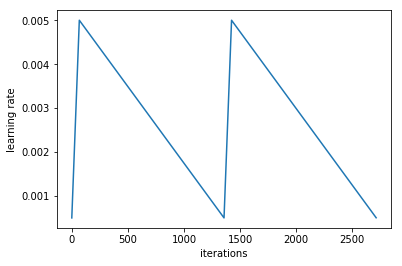

In [22]:
learner.sched.plot_lr()

  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:29,  4.35s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<20:01,  3.56s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:55,  3.02s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:41,  2.63s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:21,  2.40s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:04,  2.17s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:28,  2.07s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<11:07,  2.02s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:56,  1.99s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:35,  1.93s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:23<11:31,  2.11s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:57,  2.01s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<10:58,  2.02s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:27,  1.93s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<10:19,  1.91s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:01,  1.86s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:52,  1.84s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<09:36,  1.80s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:11,  1.72s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<08:48,  1.66s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:43<13:22,  2.52s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<12:02,  2.28s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:15,  2.14s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:25,  1.99s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:01,  1.91s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:52<09:51,  1.89s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:36,  1.85s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<09:22,  1.81s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<09:09,  1.77s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<08:56,  1.74s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<08:46,  1.71s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<08:53,  1.74s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<08:51,  1.74s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:05<08:48,  1.73s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<08:47,  1.73s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<08:42,  1.73s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:10<08:48,  1.75s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:12<08:40,  1.73s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:14<08:50,  1.77s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:16<08:25,  1.69s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:20<12:56,  2.61s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:22<11:36,  2.35s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:24<10:35,  2.15s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:25<09:56,  2.02s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:27<09:28,  1.94s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:29<09:09,  1.88s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:31<08:57,  1.84s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:32<08:39,  1.79s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:34<08:28,  1.75s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:36<08:32,  1.77s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:37<08:23,  1.75s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:39<08:26,  1.76s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:41<08:15,  1.73s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:43<08:13,  1.73s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:45<08:21,  1.77s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:46<08:08,  1.73s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:48<08:33,  1.82s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:50<08:24,  1.80s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:52<08:18,  1.78s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:53<07:53,  1.70s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:58<11:35,  2.50s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:59<10:20,  2.24s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:01<09:29,  2.06s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:03<08:53,  1.94s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:05<09:02,  1.98s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:06<08:49,  1.94s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:08<08:36,  1.90s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:10<08:22,  1.85s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:12<08:02,  1.79s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:13<07:49,  1.74s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:15<07:46,  1.74s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:17<07:42,  1.73s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:18<07:37,  1.72s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:20<07:31,  1.71s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:22<07:34,  1.72s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:23<07:27,  1.70s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:25<07:39,  1.75s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:27<07:33,  1.74s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:29<07:17,  1.68s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:30<07:01,  1.63s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:35<10:35,  2.46s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:36<09:37,  2.25s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:38<08:59,  2.11s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:40<08:24,  1.98s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:41<08:01,  1.90s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:43<07:47,  1.85s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:45<07:41,  1.83s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:47<07:37,  1.82s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:48<07:22,  1.77s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:50<07:16,  1.75s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:52<07:11,  1.74s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:54<07:13,  1.76s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:55<07:19,  1.79s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:57<07:13,  1.77s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:59<07:05,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:01<06:59,  1.73s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:02<06:50,  1.70s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:04<06:52,  1.71s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:05<06:35,  1.65s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:07<06:23,  1.61s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:11<09:43,  2.45s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:13<08:44,  2.21s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:15<08:05,  2.06s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:16<07:37,  1.95s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:18<07:20,  1.88s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:20<07:11,  1.85s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:22<07:06,  1.84s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:24<07:00,  1.82s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:25<06:45,  1.76s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:27<06:41,  1.75s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:29<06:49,  1.80s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:30<06:41,  1.77s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:32<06:40,  1.77s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:34<06:37,  1.76s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:36<06:35,  1.76s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:37<06:29,  1.75s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:39<06:27,  1.75s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:41<06:18,  1.71s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:42<06:06,  1.67s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:44<05:53,  1.62s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:49<09:43,  2.68s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:51<08:43,  2.41s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:53<08:47,  2.44s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:55<07:58,  2.22s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:57<07:40,  2.15s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:59<07:08,  2.01s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:01<07:00,  1.99s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:02<06:37,  1.89s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:04<06:38,  1.90s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:06<06:29,  1.86s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:08<06:36,  1.91s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:10<06:28,  1.88s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:12<06:14,  1.82s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:13<06:08,  1.80s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:15<06:03,  1.78s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:17<06:03,  1.79s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:19<06:02,  1.80s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:20<06:00,  1.79s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:22<05:45,  1.73s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:24<05:30,  1.66s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:28<08:11,  2.48s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:30<07:24,  2.26s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:31<06:51,  2.10s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:33<06:27,  1.99s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:35<06:08,  1.90s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:37<06:07,  1.90s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:39<06:00,  1.88s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:40<05:51,  1.84s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:42<05:42,  1.80s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:44<05:34,  1.77s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:45<05:35,  1.78s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:47<05:29,  1.76s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:49<05:23,  1.74s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:51<05:16,  1.71s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:52<05:10,  1.69s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:54<05:09,  1.69s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:56<05:06,  1.68s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:57<05:05,  1.69s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:59<05:17,  1.76s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:01<05:01,  1.68s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:05<07:24,  2.50s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:07<06:47,  2.30s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:09<06:11,  2.11s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:10<05:50,  2.00s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:12<05:33,  1.91s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:14<05:21,  1.86s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:16<05:26,  1.90s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:17<05:15,  1.85s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:19<05:12,  1.84s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:21<05:06,  1.82s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:23<05:09,  1.84s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:25<05:04,  1.82s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:27<05:06,  1.85s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:28<04:56,  1.79s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:30<04:57,  1.81s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:32<04:48,  1.77s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:34<04:56,  1.83s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:36<04:49,  1.80s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:37<04:45,  1.79s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:39<04:30,  1.70s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:43<06:30,  2.47s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:45<05:54,  2.26s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:47<05:27,  2.10s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:48<05:07,  1.99s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:50<04:54,  1.91s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:52<04:46,  1.87s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:54<04:38,  1.83s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:55<04:31,  1.80s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:57<04:25,  1.77s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:59<04:21,  1.76s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:01<04:37,  1.88s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:03<04:28,  1.83s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:04<04:26,  1.82s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:06<04:16,  1.77s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:08<04:22,  1.82s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:10<04:17,  1.80s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:11<04:12,  1.78s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:13<04:12,  1.79s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:15<04:01,  1.73s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:16<03:51,  1.66s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:21<05:46,  2.51s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:23<05:11,  2.28s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:24<04:53,  2.16s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:26<04:29,  2.00s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:28<04:16,  1.92s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:30<04:08,  1.87s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:31<03:57,  1.80s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:33<03:53,  1.78s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:35<03:54,  1.81s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:37<03:54,  1.82s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:39<03:55,  1.84s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:40<03:51,  1.82s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:42<03:50,  1.83s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:44<03:46,  1.81s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:46<03:43,  1.80s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:47<03:35,  1.75s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:49<03:46,  1.86s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:51<03:39,  1.82s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:53<03:31,  1.77s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:54<03:20,  1.68s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:59<04:51,  2.47s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:00<04:22,  2.24s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:02<03:58,  2.06s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:04<03:41,  1.93s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:06<03:40,  1.94s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:07<03:32,  1.88s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:09<03:23,  1.81s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:11<03:18,  1.79s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:12<03:13,  1.76s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:14<03:09,  1.74s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:16<03:27,  1.92s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:18<03:21,  1.89s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:20<03:27,  1.96s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:22<03:16,  1.87s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:24<03:31,  2.03s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:26<03:23,  1.98s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:28<03:18,  1.95s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:30<03:10,  1.88s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:32<03:01,  1.81s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:33<02:50,  1.72s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:37<04:03,  2.48s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:39<03:38,  2.25s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:41<03:21,  2.09s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:42<03:08,  1.98s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:44<02:58,  1.90s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:46<02:50,  1.83s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:47<02:42,  1.77s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:49<02:38,  1.74s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:51<02:36,  1.73s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:52<02:31,  1.71s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:54<02:30,  1.71s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:56<02:27,  1.69s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:58<02:26,  1.70s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:59<02:25,  1.71s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:01<02:25,  1.73s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:03<02:25,  1.75s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:05<02:31,  1.85s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:07<02:26,  1.80s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:08<02:16,  1.71s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:10<02:10,  1.65s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:14<03:09,  2.43s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:16<02:50,  2.21s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:17<02:34,  2.04s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:19<02:24,  1.93s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:21<02:17,  1.86s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:22<02:14,  1.85s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:24<02:10,  1.82s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:26<02:07,  1.79s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:28<02:01,  1.74s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:29<02:01,  1.77s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:31<01:58,  1.75s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:33<01:58,  1.77s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:35<01:54,  1.74s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:36<01:54,  1.76s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:38<01:55,  1.81s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:40<01:52,  1.78s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:42<01:48,  1.75s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:43<01:45,  1.73s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:45<01:39,  1.66s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:46<01:35,  1.61s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:50<02:15,  2.34s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:52<02:02,  2.15s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:54<01:55,  2.05s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:56<01:48,  1.96s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:57<01:42,  1.90s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:59<01:38,  1.85s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:01<01:32,  1.78s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:03<01:30,  1.78s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:04<01:28,  1.78s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:06<01:25,  1.75s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:08<01:24,  1.77s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:10<01:22,  1.76s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:11<01:21,  1.78s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:13<01:19,  1.77s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:15<01:17,  1.76s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:17<01:14,  1.73s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:18<01:12,  1.74s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:20<01:10,  1.72s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:22<01:06,  1.66s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:23<01:02,  1.61s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:27<01:33,  2.46s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:29<01:23,  2.26s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:31<01:16,  2.13s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:33<01:09,  2.00s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:35<01:05,  1.92s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:36<01:00,  1.85s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:38<00:59,  1.85s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:40<00:55,  1.80s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:42<00:54,  1.82s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:43<00:51,  1.78s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:45<00:50,  1.80s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:47<00:48,  1.79s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:49<00:45,  1.76s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:50<00:44,  1.77s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:52<00:41,  1.74s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:54<00:39,  1.73s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:56<00:38,  1.74s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:57<00:36,  1.72s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:59<00:33,  1.65s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:00<00:30,  1.60s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:05<00:44,  2.45s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:06<00:37,  2.20s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:08<00:33,  2.07s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:10<00:29,  1.96s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:11<00:26,  1.89s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:13<00:23,  1.84s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:15<00:21,  1.80s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:17<00:19,  1.79s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:18<00:17,  1.76s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:20<00:15,  1.76s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:22<00:14,  1.75s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:23<00:12,  1.73s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:25<00:10,  1.81s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:27<00:08,  1.77s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:29<00:06,  1.73s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:30<00:05,  1.71s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:32<00:03,  1.71s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:34<00:01,  1.65s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                         
    0      0.488856   0.576419   0.973029  
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:18,  4.32s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<19:52,  3.54s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<17:01,  3.04s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:54,  2.67s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<14:00,  2.52s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:13<12:41,  2.29s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:52,  2.14s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:04,  2.01s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:33,  1.92s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:08,  1.85s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<09:56,  1.82s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:43,  1.78s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:31,  1.75s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:23,  1.73s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:13,  1.71s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:19,  1.73s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:17,  1.73s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:07,  1.71s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:49,  1.65s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:32,  1.61s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<12:22,  2.34s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:12,  2.12s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<10:35,  2.01s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:07,  1.93s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<09:43,  1.86s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:29,  1.82s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:50,  1.89s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:24,  1.82s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<09:24,  1.82s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:57<09:17,  1.80s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<09:00,  1.76s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<08:56,  1.75s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<08:57,  1.76s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:52,  1.75s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:05<08:57,  1.77s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:07<08:52,  1.76s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<08:57,  1.78s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:11<08:55,  1.78s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:12<08:35,  1.72s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:14<08:13,  1.65s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:18<12:15,  2.47s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<11:07,  2.25s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:24,  2.11s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:23<09:43,  1.98s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:25<09:46,  1.99s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<09:12,  1.88s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<09:12,  1.89s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<08:58,  1.85s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:32<08:48,  1.82s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<08:32,  1.77s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:33,  1.78s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:37<08:18,  1.74s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:17,  1.74s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:41<08:25,  1.77s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:23,  1.77s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:26,  1.79s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:47<08:46,  1.87s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<08:36,  1.84s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<08:53,  1.91s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:52<08:18,  1.79s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:33,  2.50s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:58<10:20,  2.24s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:27,  2.06s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<08:52,  1.94s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:32,  1.87s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:05<08:27,  1.86s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:08,  1.79s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:02,  1.78s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<07:56,  1.77s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<07:48,  1.74s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<07:40,  1.72s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:39,  1.72s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<07:55,  1.79s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:19<07:49,  1.77s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:50,  1.78s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:44,  1.77s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:24<07:48,  1.79s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:26<07:44,  1.78s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:27<07:20,  1.69s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:29<07:03,  1.64s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:33<10:48,  2.52s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:35<09:45,  2.28s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:37<09:17,  2.18s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:39<08:46,  2.06s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<08:12,  1.94s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:42<07:51,  1.86s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:44<07:40,  1.83s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:45<07:32,  1.80s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:47<07:25,  1.78s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:49<07:16,  1.75s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:51<07:13,  1.75s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<07:15,  1.76s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:54<07:06,  1.73s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:56<07:07,  1.75s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:58<07:07,  1.75s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:59<07:03,  1.74s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:01<07:04,  1.75s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:03<06:57,  1.73s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:04<06:38,  1.66s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:06<06:25,  1.61s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:10<09:47,  2.47s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:12<08:49,  2.24s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:14<08:06,  2.06s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:15<07:42,  1.97s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:17<07:19,  1.88s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:19<07:05,  1.83s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:21<07:00,  1.81s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:22<07:00,  1.82s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:24<06:54,  1.80s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:26<06:44,  1.77s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:28<06:43,  1.77s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:29<06:36,  1.75s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:31<06:32,  1.74s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:33<06:28,  1.73s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:34<06:28,  1.73s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:36<06:21,  1.71s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:38<06:18,  1.71s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:40<06:15,  1.70s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:41<06:02,  1.65s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:43<05:50,  1.60s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:47<08:48,  2.43s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:49<08:07,  2.25s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:50<07:28,  2.08s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:52<07:03,  1.97s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:54<06:44,  1.89s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:56<06:31,  1.84s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:57<06:22,  1.81s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:59<06:17,  1.79s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:01<06:10,  1.77s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:02<06:02,  1.73s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:04<05:59,  1.73s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:06<05:56,  1.72s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:08<05:53,  1.72s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:09<05:56,  1.74s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:11<05:57,  1.75s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:13<05:49,  1.72s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:14<05:40,  1.69s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:16<05:37,  1.68s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:18<05:27,  1.64s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:19<05:17,  1.59s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:24<08:07,  2.46s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:25<07:18,  2.23s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:27<06:48,  2.08s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:29<06:23,  1.97s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:30<06:06,  1.89s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:32<05:56,  1.84s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:34<05:48,  1.81s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:36<05:42,  1.79s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:37<05:39,  1.79s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:39<05:43,  1.82s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:41<05:32,  1.77s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:43<05:28,  1.76s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:45<05:42,  1.84s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:46<05:39,  1.83s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:48<05:33,  1.81s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:50<05:25,  1.78s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:52<05:15,  1.74s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:53<05:13,  1.73s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:55<05:22,  1.79s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:57<05:05,  1.71s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:01<07:43,  2.60s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:03<06:55,  2.35s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:05<06:26,  2.20s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:07<05:58,  2.05s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:08<05:41,  1.96s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:10<05:28,  1.90s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:12<05:17,  1.85s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:14<05:19,  1.87s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:17<05:56,  2.10s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:18<05:37,  2.00s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:21<06:01,  2.15s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:23<05:41,  2.05s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:25<05:44,  2.07s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:27<05:31,  2.01s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:29<05:25,  1.98s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:30<05:15,  1.94s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:32<05:05,  1.89s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:34<04:53,  1.82s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:35<04:37,  1.73s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:37<04:24,  1.66s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:41<06:21,  2.41s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:43<05:47,  2.22s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:45<05:34,  2.14s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:46<05:13,  2.02s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:48<04:55,  1.92s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:50<04:46,  1.87s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:52<04:45,  1.88s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:54<04:41,  1.87s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:55<04:33,  1.82s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:57<04:30,  1.81s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:59<04:23,  1.78s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:01<04:20,  1.77s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:02<04:15,  1.75s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:04<04:09,  1.72s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:06<04:05,  1.70s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:07<04:01,  1.69s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:09<04:04,  1.72s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:11<04:01,  1.71s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:12<03:51,  1.65s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:14<03:42,  1.60s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:18<05:45,  2.50s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:20<05:11,  2.27s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:22<04:47,  2.11s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:24<04:30,  2.00s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:25<04:14,  1.90s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:27<04:05,  1.85s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:29<04:00,  1.82s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:30<03:50,  1.76s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:32<03:51,  1.78s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:34<03:46,  1.76s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:36<03:45,  1.76s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:37<03:40,  1.74s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:39<03:37,  1.73s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:41<03:34,  1.71s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:42<03:32,  1.71s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:44<03:33,  1.74s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:46<03:30,  1.73s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:48<03:26,  1.71s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:49<03:20,  1.67s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:51<03:12,  1.62s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:55<04:38,  2.36s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:56<04:13,  2.16s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:58<03:56,  2.04s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:00<03:44,  1.95s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:02<03:36,  1.90s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:03<03:28,  1.84s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:05<03:24,  1.82s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:07<03:19,  1.80s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:09<03:13,  1.76s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:10<03:09,  1.74s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:12<03:05,  1.72s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:14<03:02,  1.70s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:15<03:03,  1.73s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:17<02:59,  1.71s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:19<02:57,  1.71s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:21<02:58,  1.73s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:22<02:55,  1.72s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:24<02:52,  1.71s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:26<02:46,  1.66s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:27<02:40,  1.62s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:31<04:01,  2.47s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:33<03:37,  2.25s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:35<03:21,  2.10s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:37<03:09,  1.99s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:38<02:58,  1.90s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:40<02:51,  1.85s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:42<02:48,  1.83s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:44<02:43,  1.80s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:45<02:42,  1.81s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:47<02:36,  1.76s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:49<02:42,  1.85s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:51<02:36,  1.80s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:53<02:35,  1.80s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:54<02:32,  1.79s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:56<02:27,  1.75s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:58<02:24,  1.74s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:00<02:25,  1.78s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:01<02:21,  1.75s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:03<02:15,  1.70s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:04<02:09,  1.64s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:09<03:10,  2.44s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:10<02:51,  2.22s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:12<02:36,  2.05s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:14<02:26,  1.96s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:16<02:24,  1.95s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:17<02:15,  1.86s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:19<02:16,  1.90s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:21<02:09,  1.82s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:23<02:05,  1.80s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:24<02:00,  1.75s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:26<02:03,  1.82s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:28<01:58,  1.77s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:30<01:56,  1.77s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:32<01:53,  1.75s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:33<01:51,  1.75s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:35<01:51,  1.77s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:37<01:48,  1.75s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:39<01:48,  1.77s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:40<01:41,  1.69s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:42<01:36,  1.63s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:47<02:33,  2.64s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:48<02:14,  2.37s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:51<02:09,  2.32s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:52<02:00,  2.20s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:54<01:53,  2.11s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:56<01:46,  2.01s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:58<01:41,  1.95s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:00<01:35,  1.88s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:01<01:31,  1.83s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:03<01:28,  1.81s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:05<01:24,  1.77s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:07<01:22,  1.76s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:08<01:21,  1.76s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:10<01:19,  1.77s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:12<01:17,  1.76s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:14<01:15,  1.76s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:15<01:12,  1.74s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:17<01:10,  1.72s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:18<01:06,  1.65s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:20<01:02,  1.60s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:24<01:32,  2.44s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:26<01:22,  2.22s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:28<01:14,  2.07s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:30<01:08,  1.96s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:31<01:04,  1.89s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:33<01:00,  1.84s/it, loss=0.491]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:35<00:57,  1.81s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:36<00:54,  1.76s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:38<00:51,  1.73s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:40<00:50,  1.73s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:42<00:49,  1.76s/it, loss=0.494]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:43<00:47,  1.74s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:45<00:46,  1.77s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:47<00:43,  1.73s/it, loss=0.497]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:48<00:41,  1.71s/it, loss=0.498]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:50<00:40,  1.76s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:52<00:39,  1.80s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:54<00:36,  1.76s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:55<00:34,  1.72s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:57<00:31,  1.66s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:01<00:43,  2.43s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:03<00:37,  2.23s/it, loss=0.497]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:05<00:33,  2.11s/it, loss=0.497]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:06<00:29,  1.97s/it, loss=0.497]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:08<00:27,  1.98s/it, loss=0.498]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:10<00:24,  1.90s/it, loss=0.499]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:12<00:22,  1.90s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:14<00:20,  1.89s/it, loss=0.497]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:16<00:18,  1.84s/it, loss=0.496]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:17<00:16,  1.82s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:19<00:14,  1.79s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:21<00:12,  1.79s/it, loss=0.495]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:23<00:10,  1.79s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:24<00:08,  1.76s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:26<00:07,  1.76s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:28<00:05,  1.76s/it, loss=0.493]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:30<00:03,  1.73s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:31<00:01,  1.68s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    1      0.492091   0.573581   0.9735                      
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:38,  4.20s/it, loss=0.492]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:28,  3.47s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:25,  2.93s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:15,  2.55s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:40,  2.28s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:35,  2.09s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<10:46,  1.95s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:15<10:17,  1.87s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:38,  1.93s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:13,  1.86s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:14,  1.87s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<10:01,  1.84s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:47,  1.80s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:37,  1.78s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:37,  1.78s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:40,  1.80s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:28,  1.76s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:20,  1.75s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:57,  1.68s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:39,  1.63s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<13:07,  2.48s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:51,  2.24s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<10:58,  2.08s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:31,  2.01s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<10:03,  1.92s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:50<09:48,  1.88s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:35,  1.84s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:22,  1.81s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<09:15,  1.79s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:57<09:17,  1.80s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<09:03,  1.76s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<08:52,  1.74s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<09:23,  1.84s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:04<09:14,  1.82s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:06<09:06,  1.80s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:07<09:04,  1.80s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<08:58,  1.78s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:11<08:46,  1.75s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:12<08:30,  1.70s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:14<08:10,  1.64s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:18<12:05,  2.43s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<10:55,  2.21s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:49,  2.19s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:24<10:01,  2.04s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:25<09:26,  1.93s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<09:00,  1.85s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<09:00,  1.85s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<08:51,  1.83s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:32<08:51,  1.83s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<08:41,  1.81s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:29,  1.77s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:38<08:20,  1.75s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:15,  1.73s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:41<08:11,  1.72s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:20,  1.76s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:44<08:07,  1.72s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:46<08:00,  1.71s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<08:05,  1.73s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:49<07:45,  1.66s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:51<07:29,  1.61s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:55<11:22,  2.46s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:18,  2.23s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:38,  2.09s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:07,  1.99s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:02<08:50,  1.94s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:23,  1.85s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:08,  1.80s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:07<08:02,  1.78s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:09<07:52,  1.75s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<07:50,  1.75s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<07:47,  1.74s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:14<07:45,  1.74s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:16<07:39,  1.73s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<07:32,  1.71s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:53,  1.79s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:21<07:43,  1.76s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:23<07:37,  1.75s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:32,  1.74s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:26<07:26,  1.72s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<07:08,  1.65s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:32<10:39,  2.48s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:34<09:39,  2.25s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<08:57,  2.10s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:38<08:35,  2.02s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:39<08:09,  1.93s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:41<07:54,  1.88s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:43<07:46,  1.85s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:45<07:38,  1.83s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:46<07:32,  1.81s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:48<07:27,  1.80s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:50<07:20,  1.78s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<07:18,  1.77s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:54<07:34,  1.85s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:56<07:30,  1.84s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:57<07:15,  1.79s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:59<07:09,  1.77s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:01<07:07,  1.77s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:02<07:01,  1.75s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:04<07:08,  1.78s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:06<06:47,  1.70s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:10<10:10,  2.56s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:12<09:22,  2.37s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:14<08:45,  2.23s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:16<08:19,  2.12s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:18<08:34,  2.20s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:20<07:56,  2.04s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:23<08:18,  2.15s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:24<07:40,  1.99s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:26<07:55,  2.07s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:28<07:27,  1.96s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:30<07:10,  1.89s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:32<06:59,  1.85s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:33<06:52,  1.83s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:35<06:57,  1.85s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:37<06:48,  1.82s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:39<06:40,  1.80s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:41<07:02,  1.90s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:43<06:53,  1.87s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:44<06:35,  1.80s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:46<06:15,  1.72s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:50<09:08,  2.52s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:52<08:14,  2.28s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:54<07:51,  2.18s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:56<07:21,  2.05s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:58<07:07,  2.00s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:59<06:49,  1.92s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:01<06:41,  1.89s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:03<06:29,  1.84s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:05<06:51,  1.96s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:07<06:38,  1.91s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:09<06:39,  1.92s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:11<06:25,  1.86s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:13<06:33,  1.91s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:14<06:20,  1.86s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:16<06:19,  1.86s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:18<06:07,  1.81s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:20<06:16,  1.86s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:22<06:12,  1.85s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:23<05:59,  1.80s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:25<05:41,  1.71s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:29<08:30,  2.58s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:31<07:40,  2.34s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:33<07:12,  2.21s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:35<06:44,  2.07s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:37<06:40,  2.06s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:39<06:14,  1.94s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:41<06:11,  1.93s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:42<05:57,  1.87s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:44<05:44,  1.81s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:46<05:46,  1.83s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:48<05:42,  1.82s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:49<05:37,  1.80s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:51<05:32,  1.79s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:53<05:26,  1.76s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:55<05:37,  1.83s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:57<05:31,  1.81s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:59<05:38,  1.86s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:00<05:34,  1.85s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:02<05:28,  1.83s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:04<05:09,  1.73s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:08<07:33,  2.55s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:10<06:48,  2.31s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:12<06:25,  2.19s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:14<06:04,  2.09s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:15<05:47,  1.99s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:17<05:42,  1.98s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:19<05:26,  1.90s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:21<05:11,  1.82s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:23<05:11,  1.83s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:24<04:58,  1.77s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:26<05:18,  1.89s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:28<05:08,  1.85s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:30<05:00,  1.81s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:32<04:52,  1.77s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:34<05:20,  1.95s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:36<05:08,  1.89s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:38<05:10,  1.92s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:39<05:00,  1.87s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:41<04:57,  1.86s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:43<04:39,  1.76s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:47<06:49,  2.59s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:49<06:03,  2.31s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:51<05:34,  2.14s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:52<05:12,  2.02s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:54<05:03,  1.97s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:56<04:47,  1.88s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:58<04:53,  1.93s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:00<04:40,  1.86s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:02<04:43,  1.89s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:04<04:42,  1.90s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:05<04:36,  1.87s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:07<04:30,  1.84s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:09<04:36,  1.89s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:11<04:24,  1.83s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:13<04:17,  1.79s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:14<04:15,  1.78s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:16<04:10,  1.76s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:18<04:14,  1.80s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:20<04:19,  1.86s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:21<04:03,  1.75s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:26<06:01,  2.62s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:28<05:22,  2.35s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:30<05:09,  2.28s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:32<04:47,  2.13s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:34<04:43,  2.12s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:35<04:24,  1.99s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:38<04:26,  2.02s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:39<04:10,  1.92s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:41<04:06,  1.90s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:43<03:59,  1.86s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:45<04:13,  1.98s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:47<04:10,  1.97s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:49<04:04,  1.94s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:51<03:57,  1.90s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:53<04:15,  2.06s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:55<04:02,  1.97s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:57<04:13,  2.08s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:59<04:00,  1.99s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:01<03:50,  1.92s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:02<03:34,  1.80s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:07<05:02,  2.56s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:08<04:34,  2.35s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:10<04:10,  2.16s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:12<03:54,  2.04s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:14<03:54,  2.05s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:16<03:42,  1.97s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:18<03:42,  1.99s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:20<03:34,  1.93s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:22<03:32,  1.93s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:23<03:24,  1.88s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:25<03:15,  1.81s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:27<03:08,  1.77s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:28<03:09,  1.78s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:30<03:03,  1.75s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:32<03:07,  1.80s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:34<03:02,  1.77s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:36<03:05,  1.81s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:37<03:00,  1.79s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:39<02:57,  1.78s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:41<02:48,  1.70s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:45<04:09,  2.55s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:47<03:41,  2.29s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:49<03:22,  2.11s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:50<03:07,  1.97s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:52<03:09,  2.01s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:54<02:58,  1.92s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:56<02:58,  1.94s/it, loss=0.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:58<02:52,  1.90s/it, loss=0.489]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:00<02:52,  1.92s/it, loss=0.49] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:01<02:44,  1.85s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:03<02:41,  1.83s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:05<02:33,  1.77s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:07<02:40,  1.87s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:09<02:37,  1.85s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:11<02:32,  1.81s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:12<02:26,  1.77s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:14<02:25,  1.77s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:16<02:21,  1.75s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:18<02:27,  1.84s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:19<02:17,  1.75s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:24<03:19,  2.56s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:25<02:58,  2.32s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:27<02:43,  2.16s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:29<02:33,  2.04s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:31<02:24,  1.95s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:32<02:16,  1.87s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:34<02:16,  1.89s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:36<02:11,  1.86s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:38<02:07,  1.83s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:40<02:01,  1.76s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:42<02:09,  1.90s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:43<02:02,  1.84s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:45<01:59,  1.82s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:47<01:57,  1.80s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:49<01:53,  1.77s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:50<01:49,  1.73s/it, loss=0.487]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:52<01:47,  1.73s/it, loss=0.488]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:54<01:45,  1.73s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:55<01:43,  1.73s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:57<01:38,  1.67s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:01<02:22,  2.46s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:03<02:07,  2.24s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:05<02:01,  2.16s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:07<01:51,  2.03s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:08<01:43,  1.92s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:10<01:39,  1.88s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:12<01:37,  1.87s/it, loss=0.486]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:14<01:33,  1.84s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:16<01:30,  1.81s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:17<01:26,  1.77s/it, loss=0.485]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:19<01:28,  1.84s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:21<01:25,  1.83s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:23<01:24,  1.83s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:25<01:21,  1.80s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:26<01:20,  1.84s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:28<01:17,  1.80s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:30<01:14,  1.78s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:32<01:13,  1.79s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:34<01:11,  1.78s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:35<01:06,  1.70s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:39<01:34,  2.49s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:41<01:24,  2.27s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:43<01:20,  2.24s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:45<01:12,  2.08s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:47<01:10,  2.06s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:49<01:04,  1.97s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:51<01:02,  1.94s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:53<00:59,  1.92s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:54<00:55,  1.86s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:56<00:52,  1.81s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:58<00:53,  1.90s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:00<00:50,  1.89s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:02<00:49,  1.90s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:04<00:46,  1.88s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:05<00:44,  1.86s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:07<00:41,  1.82s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:09<00:39,  1.81s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:11<00:39,  1.86s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:13<00:35,  1.78s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:14<00:32,  1.70s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:19<00:50,  2.78s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:21<00:42,  2.51s/it, loss=0.484]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:24<00:39,  2.46s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:25<00:33,  2.24s/it, loss=0.483]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:27<00:29,  2.08s/it, loss=0.482]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:29<00:25,  1.96s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:31<00:23,  1.92s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:32<00:20,  1.86s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:34<00:18,  1.81s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:36<00:15,  1.78s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:37<00:14,  1.79s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:39<00:12,  1.80s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:41<00:10,  1.81s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:43<00:08,  1.78s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:45<00:07,  1.76s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:46<00:05,  1.76s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:48<00:03,  1.76s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:50<00:01,  1.70s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    2      0.478894   0.564763   0.973159                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:26,  4.16s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:18,  3.44s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:29,  2.94s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:27,  2.59s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<12:58,  2.33s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:55,  2.15s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:19,  2.05s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:39,  1.93s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:26,  1.90s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:02,  1.83s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:40,  1.95s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<10:19,  1.89s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<10:04,  1.86s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:50,  1.82s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<10:25,  1.93s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<10:04,  1.87s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:47,  1.82s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:45,  1.82s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:28,  1.78s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<09:01,  1.70s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<13:42,  2.59s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<12:17,  2.33s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<11:38,  2.21s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:52,  2.07s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:50<10:50,  2.07s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<10:15,  1.97s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:54<10:39,  2.05s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<10:15,  1.98s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:58<10:25,  2.02s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<10:06,  1.96s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:02<10:44,  2.09s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:04<10:22,  2.03s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:06<10:33,  2.07s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:08<10:11,  2.00s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:09<09:46,  1.93s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:11<09:29,  1.88s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:13<09:44,  1.93s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:15<09:23,  1.87s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:17<09:41,  1.94s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:19<09:00,  1.81s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:23<12:53,  2.60s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:25<11:30,  2.32s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:26<10:37,  2.16s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:28<10:00,  2.04s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:30<10:03,  2.05s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:32<09:35,  1.96s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:34<09:31,  1.96s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:36<09:01,  1.86s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:37<08:55,  1.85s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:39<08:47,  1.82s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:41<09:18,  1.94s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:43<08:56,  1.87s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:45<08:41,  1.82s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:47<08:32,  1.80s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:49<08:57,  1.89s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:50<08:37,  1.83s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:53<09:07,  1.94s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:54<08:51,  1.89s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:56<08:31,  1.83s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:58<08:02,  1.73s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [02:02<12:18,  2.66s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [02:04<10:54,  2.36s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:06<10:09,  2.21s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:08<09:29,  2.07s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:10<09:23,  2.05s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:11<08:57,  1.97s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:14<09:09,  2.02s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:15<08:45,  1.94s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:17<08:41,  1.93s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:19<08:20,  1.86s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:21<08:12,  1.84s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:22<07:58,  1.79s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:25<08:22,  1.89s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:26<08:12,  1.86s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:28<08:04,  1.84s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:30<07:56,  1.81s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:32<08:14,  1.89s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:34<08:01,  1.85s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:35<07:52,  1.82s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:37<07:26,  1.73s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:42<11:18,  2.63s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:44<10:15,  2.40s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:45<09:25,  2.21s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:47<08:45,  2.06s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:49<08:19,  1.97s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:50<07:59,  1.90s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:52<08:04,  1.92s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:54<07:54,  1.89s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:56<07:43,  1.85s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:58<07:27,  1.80s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:59<07:19,  1.77s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [03:01<07:16,  1.77s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [03:03<07:22,  1.80s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [03:05<07:21,  1.80s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:07<07:47,  1.92s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:09<07:31,  1.86s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:11<07:21,  1.82s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:12<07:24,  1.85s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:14<07:03,  1.77s/it, loss=0.48] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:16<06:43,  1.69s/it, loss=0.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:20<10:09,  2.56s/it, loss=0.481]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:22<09:10,  2.32s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:24<08:33,  2.18s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:26<08:07,  2.07s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:27<07:44,  1.98s/it, loss=0.479]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:29<07:25,  1.91s/it, loss=0.478]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:31<07:18,  1.89s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:33<07:09,  1.86s/it, loss=0.476]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:35<07:06,  1.85s/it, loss=0.477]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:36<06:56,  1.82s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:38<07:18,  1.93s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:40<06:56,  1.83s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:42<07:25,  1.97s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:44<07:05,  1.89s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:46<07:08,  1.91s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:48<06:55,  1.86s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:50<07:07,  1.92s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:51<06:47,  1.84s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:53<06:45,  1.84s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:55<06:21,  1.74s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:59<09:18,  2.56s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [04:01<08:24,  2.33s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [04:03<07:52,  2.19s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [04:05<07:14,  2.02s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [04:07<07:09,  2.01s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [04:08<06:48,  1.92s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:10<06:48,  1.92s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:12<06:36,  1.88s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:14<06:24,  1.83s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:15<06:16,  1.80s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:17<06:21,  1.84s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:19<06:14,  1.81s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:21<06:18,  1.84s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:23<06:16,  1.84s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:25<06:48,  2.00s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:27<06:26,  1.91s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:29<06:48,  2.02s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:31<06:39,  1.99s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:33<06:35,  1.98s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:35<06:05,  1.84s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:39<08:41,  2.63s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:41<07:50,  2.39s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:43<07:09,  2.19s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:44<06:43,  2.07s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:46<06:21,  1.96s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:48<06:05,  1.89s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:50<06:10,  1.93s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:52<05:54,  1.86s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:53<05:56,  1.88s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:55<05:43,  1.82s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:57<05:46,  1.85s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:59<05:36,  1.80s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [05:01<05:35,  1.81s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [05:02<05:31,  1.79s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [05:04<05:38,  1.84s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [05:06<05:28,  1.80s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [05:08<05:37,  1.86s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [05:10<05:26,  1.80s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:12<05:38,  1.88s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:13<05:17,  1.77s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:18<07:46,  2.62s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:20<06:56,  2.35s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:21<06:20,  2.16s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:23<05:56,  2.04s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:25<05:37,  1.94s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:26<05:22,  1.86s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:28<05:17,  1.84s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:30<05:09,  1.81s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:32<05:08,  1.82s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:33<05:00,  1.78s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:35<04:54,  1.76s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:37<04:48,  1.73s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:39<04:49,  1.74s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:40<04:48,  1.75s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:42<04:55,  1.80s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:44<04:50,  1.78s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:46<04:58,  1.84s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:48<04:56,  1.84s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:49<04:45,  1.78s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:51<04:31,  1.70s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:56<06:49,  2.59s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:57<06:05,  2.33s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:59<05:36,  2.16s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [06:01<05:14,  2.03s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [06:03<05:09,  2.01s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [06:04<04:49,  1.89s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [06:07<04:55,  1.94s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [06:08<04:44,  1.89s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:10<04:45,  1.90s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:12<04:40,  1.88s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:14<04:33,  1.84s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:16<04:28,  1.82s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:18<04:29,  1.85s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:19<04:25,  1.83s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:21<04:18,  1.79s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:23<04:13,  1.77s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:24<04:11,  1.77s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:26<04:08,  1.76s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:28<04:00,  1.72s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:29<03:50,  1.66s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:34<05:48,  2.52s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:36<05:14,  2.30s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:37<04:48,  2.12s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:39<04:31,  2.01s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:41<04:19,  1.94s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:43<04:08,  1.87s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:44<04:03,  1.84s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:46<03:56,  1.81s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:48<04:07,  1.91s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:50<03:59,  1.86s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:52<04:04,  1.91s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:54<03:59,  1.88s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:56<04:02,  1.93s/it, loss=0.475]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:58<03:54,  1.87s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:59<03:51,  1.86s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [07:01<03:41,  1.80s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [07:03<03:44,  1.84s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [07:05<03:36,  1.79s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [07:06<03:33,  1.78s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [07:08<03:22,  1.70s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:13<04:59,  2.54s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:14<04:30,  2.32s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:16<04:07,  2.13s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:18<03:54,  2.04s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:20<03:45,  1.98s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:21<03:34,  1.90s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:23<03:31,  1.88s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:25<03:24,  1.84s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:27<03:27,  1.88s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:29<03:21,  1.85s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:31<03:20,  1.86s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:32<03:16,  1.83s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:34<03:17,  1.86s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:36<03:09,  1.81s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:38<03:14,  1.87s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:40<03:06,  1.81s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:42<03:05,  1.82s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:43<02:58,  1.77s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:45<02:50,  1.70s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:46<02:42,  1.65s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:51<04:01,  2.46s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:53<03:42,  2.30s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:55<03:31,  2.20s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:56<03:17,  2.08s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:59<03:20,  2.14s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [08:00<03:09,  2.04s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [08:02<03:09,  2.06s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [08:04<03:00,  1.98s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [08:06<03:03,  2.04s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [08:08<02:51,  1.92s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [08:10<02:50,  1.94s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:12<02:44,  1.89s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:14<02:41,  1.87s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:15<02:36,  1.84s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:17<02:35,  1.85s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:19<02:31,  1.83s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:21<02:31,  1.85s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:23<02:26,  1.81s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:25<02:24,  1.80s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:26<02:15,  1.71s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:30<03:17,  2.53s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:32<02:56,  2.29s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:34<02:44,  2.16s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:36<02:31,  2.02s/it, loss=0.474]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:37<02:22,  1.92s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:39<02:14,  1.84s/it, loss=0.473]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:41<02:17,  1.91s/it, loss=0.472]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:43<02:11,  1.86s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:45<02:12,  1.89s/it, loss=0.471]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:47<02:06,  1.83s/it, loss=0.47] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:49<02:10,  1.92s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:50<02:03,  1.84s/it, loss=0.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:53<02:09,  1.96s/it, loss=0.469]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:54<02:01,  1.86s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:56<02:02,  1.91s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:58<01:55,  1.83s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [09:00<01:53,  1.84s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [09:01<01:49,  1.80s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [09:03<01:43,  1.72s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [09:04<01:37,  1.65s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [09:09<02:23,  2.47s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [09:11<02:07,  2.23s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [09:12<01:57,  2.10s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:14<01:48,  1.98s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:16<01:46,  1.97s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:18<01:40,  1.90s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:20<01:37,  1.88s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:21<01:33,  1.83s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:23<01:30,  1.80s/it, loss=0.468]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:25<01:26,  1.77s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:27<01:26,  1.81s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:28<01:23,  1.78s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:30<01:20,  1.76s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:32<01:19,  1.76s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:34<01:17,  1.77s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:35<01:16,  1.78s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:37<01:14,  1.78s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:39<01:12,  1.76s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:40<01:07,  1.68s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:42<01:03,  1.63s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:46<01:32,  2.44s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:48<01:23,  2.25s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:50<01:15,  2.10s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:51<01:09,  1.98s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:53<01:05,  1.93s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:55<01:02,  1.88s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:57<00:58,  1.82s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:58<00:55,  1.79s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [10:00<00:54,  1.80s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [10:02<00:51,  1.76s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [10:04<00:48,  1.73s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [10:05<00:45,  1.70s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [10:07<00:43,  1.69s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [10:09<00:42,  1.69s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [10:10<00:40,  1.69s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:12<00:38,  1.68s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:14<00:37,  1.69s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:15<00:35,  1.70s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:17<00:33,  1.68s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:19<00:30,  1.63s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:23<00:43,  2.39s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:24<00:37,  2.18s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:26<00:33,  2.07s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:28<00:29,  1.96s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:30<00:26,  1.88s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:31<00:23,  1.84s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:33<00:21,  1.81s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:35<00:19,  1.77s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:36<00:17,  1.76s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:38<00:15,  1.77s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:40<00:13,  1.73s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:42<00:12,  1.76s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:43<00:10,  1.73s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:45<00:08,  1.75s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:47<00:06,  1.74s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:49<00:05,  1.77s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:50<00:03,  1.76s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:52<00:01,  1.69s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    3      0.459533   0.566438   0.973101                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:58,  4.26s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:33,  3.48s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:35,  2.96s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:20,  2.57s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<12:48,  2.30s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:41,  2.11s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<10:52,  1.97s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:15<10:20,  1.87s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:26,  1.90s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:13,  1.86s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:01,  1.83s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:50,  1.81s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:46,  1.80s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:41,  1.79s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:40,  1.79s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:31,  1.77s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:22,  1.75s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:12,  1.72s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:53,  1.67s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:36,  1.62s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<13:05,  2.47s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:51,  2.24s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<11:02,  2.10s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:18,  1.96s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:47<09:51,  1.89s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:45,  1.87s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:34,  1.84s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:23,  1.81s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<09:33,  1.85s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<09:22,  1.82s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:59<09:46,  1.91s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<09:25,  1.84s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<09:38,  1.89s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:04<09:27,  1.86s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:06<09:43,  1.92s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:08<09:31,  1.89s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:10<09:27,  1.88s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:12<09:15,  1.84s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:13<08:54,  1.78s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:15<08:28,  1.70s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:19<11:59,  2.41s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<10:51,  2.19s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:05,  2.05s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:24<09:26,  1.92s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:26<09:08,  1.87s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<08:45,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<09:09,  1.88s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<09:00,  1.86s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:33<08:51,  1.83s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:35<08:46,  1.82s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:37,  1.80s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:38<08:24,  1.76s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:40<08:14,  1.73s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:42<08:22,  1.76s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:15,  1.74s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:09,  1.73s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:47<08:07,  1.73s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<07:55,  1.69s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<07:38,  1.64s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:51<07:25,  1.60s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:10,  2.41s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:04,  2.18s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:24,  2.04s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:09,  2.00s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:51,  1.94s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:33,  1.88s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:23,  1.85s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:21,  1.85s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:54,  1.98s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:12<08:38,  1.93s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:14<08:43,  1.95s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:16<08:30,  1.91s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:18<08:23,  1.89s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:19<08:01,  1.82s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:21<07:51,  1.79s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:23<07:54,  1.80s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:25<07:49,  1.79s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:26<07:35,  1.75s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:28<07:18,  1.69s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:29<07:02,  1.63s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:34<10:35,  2.46s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:36<09:30,  2.22s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:37<08:51,  2.08s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:39<08:17,  1.95s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:41<08:32,  2.02s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:43<08:07,  1.93s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:44<07:44,  1.84s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:46<07:35,  1.81s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:48<07:29,  1.80s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:50<07:21,  1.77s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:51<07:19,  1.77s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:53<07:23,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:55<07:20,  1.79s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:57<07:13,  1.77s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:58<07:03,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:00<07:04,  1.75s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:02<06:53,  1.71s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:04<06:50,  1.71s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:05<06:34,  1.64s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:07<06:21,  1.60s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:11<09:25,  2.38s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:12<08:37,  2.18s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:14<08:13,  2.09s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:16<07:49,  2.00s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:18<07:37,  1.95s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:20<07:21,  1.90s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:22<07:33,  1.96s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:23<07:12,  1.87s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:25<06:58,  1.82s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:27<06:47,  1.78s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:29<06:42,  1.76s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:30<06:36,  1.75s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:32<06:29,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:34<06:20,  1.69s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:35<06:12,  1.66s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:37<06:08,  1.65s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:39<06:10,  1.67s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:40<06:07,  1.66s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:42<05:58,  1.63s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:43<05:47,  1.59s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:48<08:53,  2.45s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:49<08:02,  2.22s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:51<07:31,  2.09s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:53<07:04,  1.98s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:55<06:45,  1.89s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:56<06:32,  1.84s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:58<06:23,  1.81s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:00<06:11,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:01<06:01,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:03<05:59,  1.72s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:05<06:10,  1.78s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:07<06:11,  1.79s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:09<06:05,  1.78s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:10<05:56,  1.74s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:12<05:53,  1.73s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:13<05:44,  1.70s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:15<05:41,  1.69s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:17<05:40,  1.69s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:18<05:27,  1.64s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:20<05:17,  1.59s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:24<08:08,  2.47s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:26<07:20,  2.23s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:28<06:44,  2.06s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:29<06:20,  1.95s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:31<06:10,  1.91s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:33<05:56,  1.85s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:35<05:44,  1.79s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:36<05:36,  1.76s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:38<05:33,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:40<05:32,  1.76s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:42<05:29,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:43<05:25,  1.74s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:45<05:18,  1.71s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:47<05:18,  1.72s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:48<05:18,  1.73s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:50<05:12,  1.71s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:52<05:08,  1.70s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:53<05:07,  1.70s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:55<04:54,  1.64s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:56<04:44,  1.59s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:01<07:11,  2.42s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:02<06:28,  2.20s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:04<06:02,  2.06s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:06<05:39,  1.94s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:08<05:25,  1.87s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:09<05:15,  1.83s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:11<05:06,  1.78s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:13<04:57,  1.74s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:14<04:52,  1.72s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:16<04:50,  1.72s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:18<04:50,  1.73s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:19<04:45,  1.71s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:21<04:42,  1.70s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:23<04:42,  1.71s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:25<04:41,  1.72s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:26<04:41,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:28<04:38,  1.72s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:30<04:37,  1.72s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:31<04:25,  1.66s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:33<04:16,  1.61s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:38<07:00,  2.66s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:40<06:11,  2.37s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:41<05:41,  2.19s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:43<05:19,  2.06s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:45<04:59,  1.94s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:46<04:48,  1.89s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:48<04:37,  1.82s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:50<04:31,  1.80s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:52<04:26,  1.77s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:53<04:18,  1.74s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:55<04:13,  1.71s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:57<04:09,  1.69s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:58<04:09,  1.71s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:00<04:11,  1.73s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:02<04:11,  1.75s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:04<04:10,  1.75s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:05<04:06,  1.74s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:07<04:03,  1.72s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:09<03:51,  1.66s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:10<03:43,  1.61s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:14<05:36,  2.44s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:16<05:02,  2.21s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:18<04:44,  2.09s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:20<04:28,  1.99s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:21<04:16,  1.91s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:23<04:02,  1.83s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:25<03:53,  1.77s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:26<03:54,  1.79s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:28<03:51,  1.78s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:30<03:45,  1.75s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:32<03:44,  1.76s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:33<03:40,  1.74s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:35<03:35,  1.71s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:37<03:39,  1.76s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:39<03:39,  1.77s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:40<03:38,  1.78s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:42<03:32,  1.74s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:44<03:31,  1.75s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:45<03:21,  1.68s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:47<03:12,  1.62s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:51<04:38,  2.36s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:53<04:14,  2.17s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:55<04:04,  2.11s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:56<03:47,  1.98s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:58<03:32,  1.86s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:00<03:25,  1.82s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:01<03:20,  1.79s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:03<03:20,  1.80s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:05<03:15,  1.78s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:07<03:14,  1.78s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:09<03:13,  1.79s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:10<03:06,  1.74s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:12<03:00,  1.71s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:13<02:58,  1.70s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:15<03:02,  1.76s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:17<02:58,  1.73s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:19<02:54,  1.71s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:20<02:53,  1.71s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:22<02:44,  1.65s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:23<02:38,  1.60s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:28<03:57,  2.43s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:29<03:34,  2.21s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:31<03:16,  2.05s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:33<03:01,  1.91s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:34<02:54,  1.86s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:36<02:47,  1.81s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:38<02:43,  1.78s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:40<02:41,  1.78s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:41<02:40,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:43<02:34,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:45<02:33,  1.74s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:47<02:32,  1.75s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:48<02:29,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:50<02:24,  1.70s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:52<02:22,  1.70s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:53<02:21,  1.71s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:55<02:19,  1.70s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:57<02:16,  1.68s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:58<02:10,  1.63s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:00<02:05,  1.59s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:04<03:04,  2.36s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:06<02:45,  2.15s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:07<02:35,  2.05s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:09<02:25,  1.93s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:11<02:19,  1.89s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:12<02:14,  1.84s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:14<02:10,  1.82s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:16<02:07,  1.79s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:18<02:02,  1.75s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:19<01:59,  1.73s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:21<01:55,  1.71s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:23<01:55,  1.72s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:24<01:53,  1.71s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:26<01:52,  1.73s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:28<01:51,  1.75s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:30<01:49,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:31<01:46,  1.71s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:33<01:43,  1.69s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:35<01:39,  1.65s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:36<01:34,  1.61s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:40<02:15,  2.34s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:42<02:04,  2.19s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:44<01:54,  2.04s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:45<01:47,  1.95s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:47<01:41,  1.87s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:49<01:35,  1.81s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:50<01:31,  1.75s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:52<01:28,  1.74s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:54<01:26,  1.72s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:55<01:23,  1.71s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:57<01:21,  1.69s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [08:59<01:20,  1.71s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:01<01:18,  1.71s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:02<01:17,  1.71s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:04<01:16,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:06<01:14,  1.73s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:08<01:14,  1.76s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:09<01:11,  1.74s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:11<01:11,  1.78s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:13<01:05,  1.69s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:17<01:32,  2.45s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:19<01:22,  2.22s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:20<01:15,  2.10s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:22<01:09,  1.99s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:24<01:05,  1.92s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:26<01:01,  1.86s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:27<00:57,  1.79s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:29<00:54,  1.77s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:31<00:53,  1.77s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:33<00:52,  1.80s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:34<00:49,  1.77s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:36<00:47,  1.76s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:38<00:45,  1.74s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:39<00:42,  1.72s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:41<00:40,  1.71s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:43<00:39,  1.71s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:44<00:37,  1.71s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:46<00:35,  1.68s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:48<00:32,  1.64s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:49<00:30,  1.59s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:53<00:42,  2.37s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:55<00:37,  2.20s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:57<00:33,  2.08s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [09:59<00:29,  1.96s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:00<00:26,  1.87s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:02<00:23,  1.81s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:04<00:22,  1.86s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:06<00:19,  1.81s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:07<00:17,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:09<00:15,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:11<00:13,  1.74s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:12<00:11,  1.71s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:14<00:10,  1.70s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:16<00:08,  1.70s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:17<00:06,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:19<00:05,  1.72s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:21<00:03,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:22<00:01,  1.67s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    4      0.445365   0.550862   0.97409                     
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:09,  4.11s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:10,  3.41s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:17,  2.91s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:08,  2.53s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:38,  2.27s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:31,  2.08s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:14,  2.03s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:38,  1.93s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:48,  1.96s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:22,  1.89s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<11:14,  2.06s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<10:50,  1.99s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<11:01,  2.03s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:28,  1.93s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<10:17,  1.91s/it, loss=0.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<10:00,  1.86s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:43,  1.81s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:25,  1.76s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<09:05,  1.70s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<08:43,  1.64s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<12:42,  2.40s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<11:33,  2.19s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<11:07,  2.11s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:47<10:29,  2.00s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<10:03,  1.92s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:50<09:35,  1.84s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:52<09:17,  1.79s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:54<09:04,  1.75s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<08:52,  1.72s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:57<08:45,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:59<08:39,  1.69s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<08:35,  1.68s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<08:40,  1.70s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:04<08:44,  1.72s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:06<08:49,  1.74s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:07<08:45,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<08:53,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:11<08:56,  1.78s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:13<08:36,  1.72s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:14<08:13,  1.65s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:19<12:30,  2.52s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<11:15,  2.28s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:36,  2.15s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:24<09:58,  2.03s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:26<09:32,  1.95s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<09:04,  1.86s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<08:45,  1.80s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<08:39,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:33<08:31,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<08:26,  1.75s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:25,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:38<08:18,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:15,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:41<08:10,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:11,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:10,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:46<08:01,  1.71s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<07:52,  1.68s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:49<07:38,  1.64s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:51<07:24,  1.59s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:55<11:01,  2.38s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:11,  2.21s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:27,  2.06s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:00<08:56,  1.95s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:02<08:35,  1.88s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:21,  1.84s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:08,  1.79s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:07<07:56,  1.76s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:09<07:43,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<07:39,  1.71s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:12<07:46,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:14<07:36,  1.71s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:16<07:33,  1.70s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:17<07:39,  1.73s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:19<07:36,  1.73s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:21<07:31,  1.72s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:22<07:21,  1.68s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:24<07:22,  1.70s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:26<07:04,  1.63s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:27<06:51,  1.59s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:31<10:02,  2.33s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:33<09:09,  2.14s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:35<08:44,  2.05s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:36<08:17,  1.95s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:38<07:55,  1.87s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:40<07:38,  1.81s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:42<07:25,  1.77s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:43<07:17,  1.74s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:45<07:18,  1.75s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:47<07:07,  1.72s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:48<07:08,  1.73s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:50<06:58,  1.69s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:52<07:08,  1.74s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:54<07:04,  1.73s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:55<07:01,  1.73s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:57<06:53,  1.70s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:59<07:02,  1.75s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:00<06:57,  1.73s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:02<07:03,  1.76s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:04<06:42,  1.68s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:08<09:57,  2.51s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:10<08:58,  2.27s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:12<08:12,  2.09s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:13<07:45,  1.98s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:15<07:40,  1.97s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:17<07:20,  1.89s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:19<07:07,  1.84s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:20<06:54,  1.80s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:22<06:45,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:24<06:36,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:40,  1.75s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:27<06:35,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:29<06:35,  1.75s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:31<06:28,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:32<06:22,  1.71s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:34<06:20,  1.71s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:36<06:20,  1.72s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:37<06:17,  1.71s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:39<06:01,  1.65s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:40<05:50,  1.60s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:45<09:09,  2.52s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:47<08:14,  2.28s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:49<07:55,  2.20s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:51<07:27,  2.08s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:53<07:30,  2.10s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:55<07:07,  2.01s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:57<06:57,  1.97s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:58<06:36,  1.88s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:00<06:25,  1.84s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:02<06:14,  1.79s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:03<06:09,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:05<06:02,  1.75s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:07<06:01,  1.75s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:09<06:00,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:10<05:58,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:12<05:57,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:14<05:56,  1.76s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:16<05:50,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:17<05:34,  1.67s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:19<05:22,  1.62s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:23<08:08,  2.47s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:25<07:21,  2.24s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:26<06:45,  2.07s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:28<06:22,  1.96s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:30<06:08,  1.90s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:32<05:56,  1.85s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:33<05:47,  1.81s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:35<05:37,  1.77s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:37<05:33,  1.76s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:38<05:26,  1.73s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:40<05:22,  1.71s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:42<05:26,  1.75s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:44<05:27,  1.76s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:45<05:19,  1.73s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:47<05:16,  1.72s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:49<05:15,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:51<05:18,  1.75s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:52<05:17,  1.76s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:54<05:01,  1.68s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:55<04:50,  1.62s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:00<07:18,  2.47s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:01<06:34,  2.23s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:03<06:17,  2.15s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:05<05:52,  2.01s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:07<05:34,  1.92s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:08<05:21,  1.86s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:10<05:20,  1.86s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:12<05:06,  1.79s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:14<05:08,  1.81s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:15<04:56,  1.75s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:17<04:50,  1.73s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:19<04:51,  1.75s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:21<04:55,  1.78s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:22<04:47,  1.74s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:24<04:45,  1.74s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:26<04:42,  1.74s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:28<04:44,  1.76s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:29<04:40,  1.74s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:31<04:42,  1.77s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:33<04:28,  1.69s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:37<06:36,  2.51s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:39<05:59,  2.29s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:41<05:33,  2.14s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:42<05:10,  2.00s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:44<05:00,  1.95s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:46<04:53,  1.92s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:48<04:47,  1.89s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:50<04:38,  1.84s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:51<04:32,  1.81s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:53<04:27,  1.79s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:55<04:19,  1.76s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:56<04:15,  1.74s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:58<04:11,  1.72s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:00<04:06,  1.70s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:02<04:03,  1.69s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:03<04:07,  1.73s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:05<04:03,  1.72s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:07<04:00,  1.71s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:08<03:51,  1.65s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:10<03:43,  1.61s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:14<05:41,  2.47s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:16<05:07,  2.25s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:18<04:44,  2.09s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:19<04:25,  1.97s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:21<04:11,  1.88s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:23<04:04,  1.84s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:24<03:58,  1.81s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:26<03:52,  1.77s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:28<03:55,  1.81s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:30<03:47,  1.77s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:32<03:45,  1.77s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:33<03:44,  1.77s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:36<04:00,  1.90s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:37<03:51,  1.85s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:39<03:40,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:41<03:37,  1.77s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:42<03:36,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:44<03:30,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:46<03:19,  1.66s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:47<03:11,  1.61s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:52<05:07,  2.60s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:54<04:29,  2.31s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:55<04:06,  2.13s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:57<03:52,  2.02s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:59<03:45,  1.98s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:01<03:35,  1.91s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:02<03:25,  1.83s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:04<03:17,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:06<03:13,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:07<03:07,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:09<03:05,  1.71s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:11<03:03,  1.72s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:12<03:01,  1.71s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:14<02:59,  1.71s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:16<02:58,  1.71s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:18<02:58,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:20<03:12,  1.89s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:22<03:06,  1.84s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:23<03:00,  1.80s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:25<02:49,  1.71s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:29<04:01,  2.46s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:31<03:34,  2.22s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:32<03:15,  2.03s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:34<03:02,  1.92s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:36<02:55,  1.87s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:37<02:48,  1.81s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:39<02:45,  1.79s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:41<02:40,  1.76s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:43<02:41,  1.79s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:44<02:36,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:46<02:32,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:48<02:31,  1.75s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:49<02:28,  1.72s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:51<02:26,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:53<02:24,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:55<02:22,  1.72s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:56<02:22,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:58<02:20,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:00<02:14,  1.68s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:01<02:08,  1.62s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:05<03:02,  2.34s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:07<02:45,  2.15s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:09<02:33,  2.03s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:10<02:23,  1.91s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:12<02:16,  1.85s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:14<02:11,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:15<02:07,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:17<02:04,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:19<02:02,  1.76s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:21<02:02,  1.78s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:22<01:59,  1.75s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:24<01:56,  1.75s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:26<01:52,  1.71s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:28<01:53,  1.75s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:29<01:53,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:31<01:50,  1.75s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:33<01:46,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:34<01:44,  1.71s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:36<01:39,  1.66s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:37<01:35,  1.61s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:42<02:24,  2.50s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:44<02:08,  2.26s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:45<01:57,  2.09s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:47<01:49,  1.98s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:49<01:43,  1.91s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:51<01:36,  1.82s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:52<01:33,  1.79s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:54<01:31,  1.79s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:56<01:28,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:57<01:25,  1.75s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:59<01:23,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:01<01:21,  1.74s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:03<01:19,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:04<01:17,  1.72s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:06<01:16,  1.73s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:08<01:12,  1.69s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:09<01:10,  1.68s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:11<01:08,  1.67s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:12<01:04,  1.62s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:14<01:01,  1.58s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:18<01:31,  2.40s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:20<01:21,  2.22s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:22<01:15,  2.08s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:23<01:08,  1.96s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:25<01:04,  1.89s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:27<01:01,  1.86s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:29<00:58,  1.82s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:30<00:55,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:32<00:54,  1.81s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:34<00:51,  1.78s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:36<00:49,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:37<00:47,  1.75s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:39<00:45,  1.74s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:41<00:43,  1.76s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:43<00:41,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:44<00:39,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:46<00:37,  1.72s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:48<00:36,  1.74s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:49<00:33,  1.68s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:51<00:30,  1.62s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:55<00:43,  2.43s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:57<00:37,  2.20s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:59<00:32,  2.05s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:00<00:28,  1.92s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:02<00:26,  1.86s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:04<00:23,  1.81s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:05<00:21,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:07<00:19,  1.74s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:09<00:17,  1.74s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:10<00:15,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:12<00:13,  1.72s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:14<00:11,  1.71s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:16<00:10,  1.75s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:17<00:08,  1.75s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:19<00:06,  1.75s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:21<00:05,  1.72s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:22<00:03,  1.70s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:24<00:01,  1.65s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    5      0.442265   0.558605   0.974124                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:00,  4.26s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:33,  3.48s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:28,  2.94s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:26,  2.59s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:00,  2.34s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:52,  2.14s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:28,  2.07s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:58,  1.99s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:30,  1.91s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:25,  1.90s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:13,  1.87s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:56,  1.82s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:36,  1.77s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:41,  1.79s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:32,  1.77s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:23,  1.75s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:17,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:10,  1.72s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:48,  1.65s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:32,  1.61s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<12:57,  2.45s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:41,  2.21s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<10:55,  2.07s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:19,  1.97s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<09:46,  1.87s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:37,  1.84s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:25,  1.81s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:14,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:54<09:00,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<08:47,  1.71s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<08:43,  1.70s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:59<08:36,  1.68s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:01<08:38,  1.70s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:35,  1.69s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:04<08:32,  1.68s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:06<08:29,  1.68s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:08<08:34,  1.71s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<08:32,  1.70s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:11<08:29,  1.70s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<08:09,  1.64s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:17<12:05,  2.44s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:19<10:50,  2.19s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:20<10:07,  2.05s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:22<09:32,  1.94s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:24<09:46,  2.00s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:26<09:22,  1.92s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<08:55,  1.83s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:29<08:40,  1.79s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:31<08:31,  1.76s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:33<08:32,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:35<08:39,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:36<08:34,  1.79s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:38<08:26,  1.77s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:40<08:19,  1.75s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:42<08:26,  1.78s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:43<08:14,  1.75s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:45<08:21,  1.78s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:47<08:18,  1.77s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:49<07:55,  1.70s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:50<07:37,  1.64s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:55<12:12,  2.63s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:51,  2.35s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<10:19,  2.24s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:46,  2.13s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<09:32,  2.09s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:52,  1.95s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:45,  1.93s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:24,  1.86s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:20,  1.86s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<08:08,  1.82s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<08:02,  1.80s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:57,  1.79s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<07:59,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<07:55,  1.80s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:46,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:37,  1.74s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:23<07:24,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:20,  1.69s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:27<07:07,  1.64s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<06:54,  1.60s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:32<10:22,  2.41s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:34<09:20,  2.18s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<08:40,  2.03s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:37<08:08,  1.91s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:39<08:03,  1.90s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:41<07:41,  1.82s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:43<07:27,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:44<07:13,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:46<07:14,  1.74s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:48<07:09,  1.73s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:50<07:16,  1.76s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:51<07:09,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:53<07:04,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:55<06:58,  1.71s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:56<07:04,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:58<06:57,  1.72s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:00<06:53,  1.71s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:01<06:43,  1.68s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:03<06:33,  1.64s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:04<06:21,  1.60s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:09<09:57,  2.51s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:11<09:02,  2.29s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:13<08:20,  2.12s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:14<07:47,  1.99s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:16<07:23,  1.90s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:18<07:16,  1.87s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:20<07:16,  1.88s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:21<07:10,  1.86s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:23<06:54,  1.80s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:25<06:47,  1.78s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:38,  1.75s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:28<06:29,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:30<06:25,  1.70s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:31<06:19,  1.69s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:33<06:18,  1.69s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:35<06:15,  1.68s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:37<06:30,  1.76s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:38<06:26,  1.75s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:40<06:09,  1.68s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:41<05:55,  1.62s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:46<08:59,  2.48s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:48<08:08,  2.25s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:49<07:35,  2.11s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:51<07:02,  1.96s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:53<06:43,  1.89s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:55<06:32,  1.84s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:56<06:27,  1.83s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:58<06:20,  1.80s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:00<06:11,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:01<06:02,  1.74s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:03<06:06,  1.76s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:05<06:04,  1.76s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:07<05:58,  1.74s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:08<05:50,  1.71s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:10<05:43,  1.69s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:12<05:42,  1.69s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:13<05:36,  1.66s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:15<05:36,  1.67s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:16<05:25,  1.63s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:18<05:15,  1.59s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:22<08:01,  2.43s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:24<07:18,  2.23s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:26<06:51,  2.10s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:28<06:30,  2.00s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:30<06:37,  2.05s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:32<06:18,  1.96s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:33<06:06,  1.91s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:35<05:51,  1.84s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:37<05:41,  1.80s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:39<05:36,  1.78s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:40<05:27,  1.74s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:42<05:24,  1.74s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:44<05:28,  1.76s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:45<05:23,  1.75s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:47<05:26,  1.78s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:49<05:23,  1.77s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:51<05:18,  1.75s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:52<05:16,  1.75s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:54<05:03,  1.69s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:55<04:51,  1.63s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:00<07:11,  2.42s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:01<06:28,  2.20s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:03<05:57,  2.03s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:05<05:34,  1.91s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:06<05:22,  1.85s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:08<05:12,  1.81s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:10<05:16,  1.84s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:12<05:06,  1.79s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:13<05:02,  1.78s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:15<05:00,  1.78s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:17<04:50,  1.73s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:19<04:47,  1.72s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:20<04:49,  1.75s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:22<04:46,  1.74s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:24<04:51,  1.78s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:26<04:44,  1.75s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:28<04:55,  1.82s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:29<04:45,  1.78s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:31<04:41,  1.76s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:33<04:28,  1.69s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:37<06:24,  2.44s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:39<05:53,  2.25s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:40<05:36,  2.16s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:42<05:12,  2.02s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:44<04:58,  1.94s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:46<04:43,  1.85s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:47<04:41,  1.85s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:49<04:30,  1.79s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:51<04:38,  1.86s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:53<04:26,  1.79s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:54<04:21,  1.77s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:56<04:16,  1.74s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:58<04:10,  1.72s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:00<04:10,  1.73s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:01<04:17,  1.79s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:03<04:15,  1.78s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:05<04:09,  1.76s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:07<04:06,  1.75s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:08<03:53,  1.67s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:10<03:45,  1.62s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:14<05:39,  2.46s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:16<05:02,  2.21s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:17<04:42,  2.08s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:19<04:28,  1.99s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:21<04:12,  1.89s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:23<04:02,  1.82s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:24<03:53,  1.77s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:26<03:49,  1.75s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:28<03:47,  1.75s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:29<03:47,  1.76s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:31<03:49,  1.79s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:33<03:45,  1.78s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:35<03:38,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:36<03:36,  1.73s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:38<03:34,  1.73s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:40<03:29,  1.70s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:42<03:30,  1.73s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:43<03:23,  1.68s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:45<03:16,  1.64s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:46<03:09,  1.59s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:50<04:40,  2.38s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:52<04:16,  2.19s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:54<03:59,  2.07s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:56<03:44,  1.95s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:57<03:34,  1.88s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:59<03:27,  1.84s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:01<03:25,  1.83s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:03<03:20,  1.80s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:04<03:15,  1.78s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:06<03:13,  1.77s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:08<03:09,  1.75s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:10<03:06,  1.74s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:11<03:05,  1.75s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:13<03:02,  1.74s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:15<03:02,  1.75s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:17<03:01,  1.77s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:18<02:56,  1.73s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:20<02:53,  1.72s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:21<02:44,  1.65s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:23<02:38,  1.60s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:28<04:05,  2.51s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:29<03:41,  2.29s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:31<03:24,  2.13s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:33<03:10,  2.00s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:35<03:01,  1.93s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:36<02:58,  1.92s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:38<02:51,  1.86s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:40<02:46,  1.83s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:42<02:40,  1.78s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:43<02:38,  1.78s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:45<02:32,  1.73s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:47<02:32,  1.76s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:49<02:30,  1.75s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:50<02:26,  1.73s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:52<02:24,  1.72s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:54<02:22,  1.71s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:55<02:22,  1.73s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:57<02:19,  1.72s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:59<02:12,  1.65s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:00<02:06,  1.60s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:04<03:07,  2.40s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:06<02:49,  2.19s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:08<02:35,  2.04s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:09<02:24,  1.93s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:11<02:19,  1.89s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:13<02:15,  1.85s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:15<02:10,  1.82s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:16<02:08,  1.82s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:18<02:04,  1.77s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:20<02:01,  1.77s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:22<01:59,  1.76s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:23<01:57,  1.76s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:25<01:55,  1.75s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:27<01:55,  1.77s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:29<01:51,  1.74s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:30<01:47,  1.71s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:32<01:47,  1.74s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:34<01:48,  1.77s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:36<01:43,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:37<01:37,  1.65s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:42<02:26,  2.52s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:43<02:08,  2.25s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:45<01:58,  2.11s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:47<01:49,  2.00s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:48<01:43,  1.92s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:50<01:37,  1.84s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:52<01:38,  1.89s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:54<01:35,  1.87s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:56<01:32,  1.85s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:58<01:29,  1.82s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:59<01:29,  1.85s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:01<01:27,  1.86s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:03<01:26,  1.88s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:05<01:21,  1.82s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:07<01:18,  1.79s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:08<01:15,  1.76s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:10<01:13,  1.75s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:12<01:11,  1.74s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:14<01:09,  1.74s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:15<01:05,  1.67s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:19<01:30,  2.39s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:21<01:21,  2.19s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:23<01:13,  2.05s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:24<01:07,  1.94s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:26<01:04,  1.90s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:28<01:00,  1.83s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:29<00:57,  1.79s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:31<00:54,  1.77s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:33<00:54,  1.81s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:35<00:51,  1.79s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:37<00:51,  1.83s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:38<00:48,  1.79s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:40<00:48,  1.87s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:42<00:46,  1.85s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:45<00:47,  1.98s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:46<00:44,  1.92s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:48<00:40,  1.83s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:50<00:37,  1.80s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:51<00:35,  1.77s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:53<00:32,  1.69s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:57<00:43,  2.44s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:59<00:37,  2.22s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:01<00:33,  2.07s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:02<00:29,  1.94s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:04<00:27,  1.94s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:06<00:24,  1.85s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:08<00:21,  1.83s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:09<00:19,  1.81s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:11<00:17,  1.80s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:13<00:15,  1.76s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:14<00:13,  1.74s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:16<00:12,  1.76s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:18<00:10,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:20<00:08,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:21<00:06,  1.69s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:23<00:05,  1.69s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:25<00:03,  1.67s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:26<00:01,  1.64s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    6      0.437325   0.54586    0.9744                      
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<28:02,  4.98s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<22:27,  4.00s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:08<19:07,  3.42s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:10<16:22,  2.93s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:12<14:25,  2.59s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:14<12:56,  2.33s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:15<11:49,  2.14s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:17<11:08,  2.02s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:19<10:55,  1.99s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:21<10:29,  1.91s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:22<10:00,  1.83s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:24<09:53,  1.81s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<09:36,  1.77s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:27<09:25,  1.74s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:29<09:31,  1.76s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:31<09:23,  1.74s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:33<09:16,  1.73s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:08,  1.71s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:36<08:45,  1.64s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:29,  1.60s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<12:37,  2.38s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<11:30,  2.18s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<10:55,  2.07s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:47<10:12,  1.94s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<10:00,  1.91s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:50<09:31,  1.83s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:52<09:35,  1.84s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:54<09:32,  1.84s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:56<09:20,  1.81s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:57<09:22,  1.82s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:59<09:13,  1.80s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:01<09:04,  1.77s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:03<08:57,  1.76s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:04<08:59,  1.77s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:06<08:49,  1.74s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:08<08:42,  1.72s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<08:36,  1.71s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:11<08:28,  1.69s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:13<08:15,  1.65s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:14<07:59,  1.61s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:19<12:12,  2.46s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<11:02,  2.23s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:19,  2.09s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:24<09:47,  1.99s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:26<09:22,  1.91s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<09:07,  1.87s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<08:53,  1.83s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<08:34,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:32<08:20,  1.73s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<08:16,  1.72s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:08,  1.70s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:37<08:16,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:20,  1.75s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:41<08:24,  1.77s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:25,  1.78s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:44<08:11,  1.74s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:46<08:01,  1.71s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<07:58,  1.70s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:49<07:40,  1.64s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:51<07:25,  1.60s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:55<11:26,  2.47s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:22,  2.25s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:48,  2.13s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:04,  1.98s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:02<08:43,  1.91s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:30,  1.87s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:38,  1.91s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:19,  1.84s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:09<08:10,  1.82s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<08:05,  1.80s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<07:57,  1.78s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:48,  1.76s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<07:55,  1.79s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<07:48,  1.77s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:44,  1.76s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:35,  1.73s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:23<07:33,  1.73s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:27,  1.71s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:27<07:22,  1.70s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<07:06,  1.65s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:33<11:01,  2.56s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:35<09:55,  2.32s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<09:07,  2.14s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:38<08:24,  1.98s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<08:01,  1.90s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:41<07:43,  1.83s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:43<07:35,  1.81s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:45<07:28,  1.79s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:47<07:17,  1.75s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:48<07:11,  1.73s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:50<07:01,  1.70s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<06:59,  1.70s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:53<06:55,  1.69s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:55<06:53,  1.69s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:57<07:07,  1.75s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:59<07:00,  1.73s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:00<06:53,  1.71s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:02<06:54,  1.72s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:03<06:36,  1.65s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:05<06:23,  1.61s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:09<09:26,  2.38s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:11<08:36,  2.18s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:13<08:11,  2.08s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:14<07:38,  1.95s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:16<07:16,  1.87s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:18<07:03,  1.82s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:19<06:50,  1.77s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:21<06:46,  1.76s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:23<06:38,  1.73s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:24<06:31,  1.71s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:44,  1.78s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:28<06:41,  1.77s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:30<07:02,  1.87s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:32<06:49,  1.82s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:34<07:16,  1.95s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:36<06:52,  1.85s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:38<07:03,  1.91s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:40<06:55,  1.88s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:41<06:48,  1.86s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:43<06:23,  1.75s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:47<09:13,  2.54s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:49<08:25,  2.33s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:51<07:52,  2.19s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:53<07:18,  2.04s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:54<06:53,  1.93s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:56<06:40,  1.88s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:58<06:26,  1.82s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:00<06:18,  1.79s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:01<06:14,  1.78s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:03<06:13,  1.79s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:05<06:16,  1.81s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:07<06:07,  1.77s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:09<06:08,  1.79s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:10<05:56,  1.74s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:12<05:51,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:14<06:01,  1.78s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:15<05:56,  1.76s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:17<05:50,  1.74s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:19<05:33,  1.67s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:20<05:21,  1.62s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:25<08:08,  2.47s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:26<07:26,  2.27s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:28<06:51,  2.10s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:30<06:26,  1.98s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:31<06:02,  1.87s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:33<05:52,  1.83s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:35<05:57,  1.86s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:37<05:45,  1.81s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:39<05:48,  1.83s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:40<05:41,  1.80s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:42<05:29,  1.76s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:44<05:24,  1.73s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:45<05:20,  1.72s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:47<05:19,  1.73s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:49<05:17,  1.73s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:51<05:15,  1.72s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:52<05:12,  1.72s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:54<05:08,  1.70s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:55<04:54,  1.64s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:57<04:45,  1.60s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:01<07:00,  2.36s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:03<06:21,  2.15s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:05<05:58,  2.04s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:06<05:39,  1.94s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:08<05:25,  1.87s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:10<05:16,  1.83s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:11<05:06,  1.78s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:13<05:01,  1.77s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:15<05:01,  1.78s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:17<04:57,  1.76s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:18<04:53,  1.75s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:20<04:55,  1.77s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:22<04:51,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:24<04:45,  1.73s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:25<04:41,  1.72s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:27<04:43,  1.74s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:29<04:43,  1.75s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:31<04:40,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:32<04:26,  1.67s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:34<04:16,  1.62s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:38<06:18,  2.40s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:39<05:45,  2.20s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:41<05:20,  2.05s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:43<05:04,  1.97s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:45<04:52,  1.90s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:46<04:42,  1.85s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:48<04:37,  1.83s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:50<04:28,  1.78s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:52<04:24,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:53<04:15,  1.72s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:55<04:14,  1.72s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:57<04:15,  1.74s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:58<04:12,  1.73s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:00<04:09,  1.72s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:02<04:11,  1.74s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:04<04:09,  1.75s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:05<04:10,  1.76s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:07<04:06,  1.75s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:09<03:54,  1.68s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:10<03:46,  1.63s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:15<05:42,  2.48s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:16<05:08,  2.25s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:18<04:48,  2.12s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:20<04:30,  2.00s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:22<04:17,  1.93s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:23<04:11,  1.89s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:25<04:06,  1.87s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:27<03:58,  1.82s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:29<03:55,  1.81s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:30<03:49,  1.78s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:32<03:43,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:34<03:38,  1.72s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:35<03:32,  1.69s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:37<03:31,  1.69s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:39<03:33,  1.72s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:41<03:28,  1.70s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:42<03:27,  1.70s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:44<03:26,  1.71s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:46<03:21,  1.68s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:47<03:13,  1.63s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:51<04:46,  2.43s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:53<04:21,  2.24s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:55<04:02,  2.09s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:57<03:46,  1.97s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:59<03:42,  1.95s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:00<03:39,  1.94s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:02<03:34,  1.92s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:04<03:31,  1.91s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:06<03:30,  1.91s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:08<03:24,  1.88s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:10<03:24,  1.90s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:12<03:18,  1.86s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:14<03:26,  1.95s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:16<03:18,  1.90s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:17<03:10,  1.83s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:19<03:05,  1.80s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:21<03:04,  1.81s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:22<02:57,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:24<02:50,  1.70s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:26<02:42,  1.64s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:30<04:02,  2.47s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:32<03:38,  2.25s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:33<03:22,  2.11s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:35<03:10,  2.00s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:37<03:13,  2.05s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:39<03:01,  1.95s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:41<03:02,  1.98s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:43<02:54,  1.91s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:45<02:51,  1.90s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:46<02:43,  1.84s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:48<02:39,  1.81s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:50<02:37,  1.81s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:52<02:33,  1.79s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:53<02:29,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:55<02:26,  1.74s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:57<02:24,  1.74s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:59<02:23,  1.75s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:00<02:20,  1.73s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:02<02:13,  1.66s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:03<02:07,  1.61s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:07<03:00,  2.31s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:09<02:43,  2.12s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:11<02:36,  2.06s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:13<02:28,  1.98s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:14<02:20,  1.91s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:16<02:15,  1.85s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:18<02:11,  1.82s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:20<02:05,  1.77s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:21<02:02,  1.75s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:23<01:57,  1.71s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:25<01:56,  1.71s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:26<01:54,  1.70s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:28<01:54,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:30<01:51,  1.72s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:31<01:50,  1.73s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:33<01:48,  1.72s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:35<01:50,  1.78s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:37<01:49,  1.79s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:38<01:42,  1.71s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:40<01:37,  1.65s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:44<02:22,  2.45s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:46<02:06,  2.22s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:48<01:59,  2.13s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:50<01:49,  1.99s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:51<01:42,  1.91s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:53<01:41,  1.91s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:55<01:34,  1.82s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:56<01:30,  1.78s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:58<01:27,  1.74s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:00<01:23,  1.71s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:01<01:22,  1.71s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:03<01:20,  1.71s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:05<01:17,  1.69s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:07<01:16,  1.69s/it, loss=0.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:08<01:16,  1.74s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:10<01:14,  1.74s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:12<01:14,  1.76s/it, loss=0.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:14<01:11,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:15<01:06,  1.67s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:17<01:03,  1.63s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:21<01:32,  2.44s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:23<01:21,  2.21s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:24<01:13,  2.04s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:26<01:08,  1.96s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:28<01:04,  1.88s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:29<01:00,  1.82s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:31<00:57,  1.79s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:33<00:54,  1.75s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:35<00:53,  1.77s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:36<00:51,  1.77s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:38<00:49,  1.76s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:40<00:47,  1.75s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:42<00:45,  1.74s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:43<00:43,  1.73s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:45<00:41,  1.74s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:47<00:39,  1.72s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:49<00:38,  1.77s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:50<00:36,  1.75s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:52<00:33,  1.69s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:53<00:31,  1.63s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:58<00:43,  2.43s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:59<00:37,  2.20s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:01<00:33,  2.09s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:03<00:29,  1.99s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:05<00:26,  1.91s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:06<00:24,  1.86s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:08<00:21,  1.80s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:10<00:19,  1.81s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:12<00:17,  1.79s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:13<00:15,  1.75s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:15<00:13,  1.73s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:17<00:12,  1.73s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:18<00:10,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:20<00:08,  1.73s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:22<00:06,  1.73s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:24<00:05,  1.74s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:25<00:03,  1.68s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:27<00:01,  1.63s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    7      0.409752   0.54418    0.974695                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:03<22:31,  4.00s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<18:36,  3.31s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<15:43,  2.81s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<13:57,  2.50s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:37,  2.27s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:38,  2.10s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:02,  2.00s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:30,  1.91s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:05,  1.83s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<09:53,  1.80s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:00,  1.83s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:22<09:42,  1.78s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<10:04,  1.85s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:48,  1.81s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<10:16,  1.90s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<10:02,  1.86s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<10:15,  1.91s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:34<09:47,  1.83s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<09:14,  1.73s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:37<08:49,  1.66s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<13:21,  2.52s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<12:00,  2.27s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<11:07,  2.11s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:16,  1.96s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<09:53,  1.89s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:50<09:29,  1.82s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:23,  1.80s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:21,  1.81s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<09:12,  1.78s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:57<09:03,  1.76s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<08:59,  1.75s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<08:59,  1.76s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:02<08:51,  1.74s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:04<08:51,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:05<08:52,  1.75s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:07<08:49,  1.75s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:09<08:53,  1.77s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:11<08:43,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:12<08:20,  1.67s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:14<08:02,  1.61s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:18<11:52,  2.39s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<10:54,  2.20s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:21<10:06,  2.05s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:23<09:30,  1.93s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:25<09:08,  1.87s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:26<08:50,  1.81s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<08:37,  1.77s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:30<08:33,  1.76s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:31<08:25,  1.74s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:33<08:18,  1.72s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:35<08:18,  1.73s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:37<08:23,  1.76s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:26,  1.77s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:40<08:14,  1.73s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:42<08:46,  1.85s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:44<08:49,  1.87s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:46<08:38,  1.84s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<08:20,  1.78s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<08:49,  1.89s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:51<08:14,  1.77s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:47,  2.54s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:38,  2.31s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:50,  2.14s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:18,  2.03s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:56,  1.96s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:38,  1.90s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:23,  1.85s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:17,  1.84s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:00,  1.78s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<08:00,  1.78s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<08:08,  1.82s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:58,  1.79s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<07:47,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<07:46,  1.76s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:42,  1.75s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:42,  1.76s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:24<07:28,  1.71s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:22,  1.69s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:27<07:05,  1.64s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<06:53,  1.60s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:33<10:29,  2.44s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:35<09:41,  2.26s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<08:52,  2.08s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:38<08:27,  1.99s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<07:59,  1.89s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:41<07:48,  1.85s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:43<07:30,  1.79s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:45<07:22,  1.76s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:46<07:19,  1.76s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:48<07:15,  1.75s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:50<07:15,  1.76s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<07:11,  1.75s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:53<07:08,  1.74s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:55<07:02,  1.73s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:57<06:57,  1.71s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:58<06:55,  1.71s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:00<06:52,  1.70s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:02<06:51,  1.71s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:03<06:36,  1.65s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:05<06:23,  1.60s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:09<09:24,  2.37s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:11<08:39,  2.19s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:13<08:17,  2.11s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:14<07:43,  1.97s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:16<07:21,  1.89s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:18<07:10,  1.85s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:20<06:57,  1.80s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:21<06:53,  1.79s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:23<06:41,  1.75s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:25<06:38,  1.74s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:31,  1.72s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:28<06:24,  1.69s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:30<06:23,  1.70s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:31<06:20,  1.69s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:33<06:23,  1.71s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:35<06:20,  1.71s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:37<06:23,  1.73s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:38<06:21,  1.72s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:40<06:07,  1.67s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:41<05:54,  1.62s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:45<08:37,  2.38s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:47<07:51,  2.17s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:49<07:19,  2.04s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:51<06:58,  1.95s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:52<06:34,  1.84s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:54<06:19,  1.78s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:56<06:17,  1.78s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:57<06:10,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:59<06:23,  1.82s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:01<06:12,  1.78s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:03<06:27,  1.86s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:05<06:17,  1.83s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:07<06:20,  1.84s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:08<06:06,  1.79s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:10<05:57,  1.75s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:12<05:52,  1.74s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:13<05:47,  1.72s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:15<05:43,  1.71s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:17<05:29,  1.65s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:18<05:18,  1.60s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:22<07:51,  2.38s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:24<07:14,  2.21s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:26<06:42,  2.05s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:27<06:19,  1.95s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:29<06:00,  1.86s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:31<05:56,  1.85s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:33<05:47,  1.81s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:34<05:39,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:36<05:29,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:38<05:25,  1.72s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:39<05:20,  1.70s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:41<05:14,  1.68s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:43<05:17,  1.70s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:45<05:16,  1.71s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:46<05:11,  1.69s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:48<05:17,  1.73s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:50<05:11,  1.71s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:51<05:07,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:53<04:55,  1.64s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:54<04:45,  1.60s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:58<06:53,  2.33s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:00<06:14,  2.11s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:02<05:53,  2.01s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:03<05:35,  1.92s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:05<05:20,  1.84s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:07<05:12,  1.81s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:09<05:06,  1.78s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:10<05:01,  1.76s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:13<05:25,  1.91s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:14<05:21,  1.90s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:16<05:12,  1.86s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:18<05:07,  1.84s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:20<05:12,  1.88s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:22<05:06,  1.86s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:23<04:59,  1.82s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:25<04:47,  1.76s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:27<04:39,  1.72s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:28<04:33,  1.70s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:30<04:27,  1.67s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:31<04:18,  1.62s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:36<06:26,  2.44s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:37<05:46,  2.20s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:39<05:26,  2.09s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:41<05:07,  1.98s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:43<05:01,  1.96s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:45<04:49,  1.89s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:46<04:39,  1.84s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:48<04:28,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:50<04:19,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:51<04:15,  1.72s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:53<04:11,  1.70s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:55<04:15,  1.74s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:57<04:13,  1.74s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:58<04:11,  1.73s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:00<04:13,  1.76s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:02<04:11,  1.76s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:04<04:05,  1.73s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:05<04:01,  1.71s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:07<03:50,  1.65s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:08<03:42,  1.60s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:13<05:36,  2.44s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:14<05:02,  2.21s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:16<04:39,  2.05s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:18<04:23,  1.95s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:19<04:11,  1.88s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:21<04:04,  1.84s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:23<03:56,  1.79s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:24<03:50,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:26<03:49,  1.77s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:28<03:47,  1.76s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:30<03:45,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:32<03:42,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:33<03:41,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:35<03:37,  1.74s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:37<03:37,  1.75s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:38<03:33,  1.74s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:40<03:30,  1.73s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:42<03:25,  1.70s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:43<03:16,  1.64s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:45<03:09,  1.60s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:50<05:00,  2.55s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:51<04:31,  2.32s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:53<04:05,  2.12s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:55<03:49,  1.99s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:56<03:39,  1.92s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:58<03:29,  1.86s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:00<03:22,  1.80s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:01<03:15,  1.76s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:03<03:17,  1.79s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:05<03:15,  1.79s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:07<03:10,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:09<03:08,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:10<03:02,  1.72s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:12<02:59,  1.71s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:14<02:58,  1.71s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:15<02:56,  1.71s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:17<02:58,  1.75s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:19<02:53,  1.72s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:20<02:45,  1.65s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:22<02:38,  1.60s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:26<03:50,  2.35s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:28<03:30,  2.17s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:29<03:15,  2.04s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:31<03:04,  1.94s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:33<02:56,  1.87s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:35<02:51,  1.85s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:36<02:46,  1.81s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:38<02:41,  1.78s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:40<02:39,  1.78s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:41<02:35,  1.74s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:43<02:31,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:45<02:29,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:47<02:28,  1.73s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:48<02:25,  1.71s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:50<02:22,  1.69s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:52<02:21,  1.70s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:53<02:19,  1.70s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:55<02:16,  1.69s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:57<02:10,  1.63s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [07:58<02:05,  1.59s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:02<03:10,  2.44s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:04<02:52,  2.24s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:06<02:36,  2.06s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:07<02:24,  1.93s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:09<02:16,  1.85s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:11<02:10,  1.79s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:13<02:07,  1.77s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:14<02:07,  1.80s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:16<02:05,  1.79s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:18<02:00,  1.75s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:19<01:56,  1.72s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:21<01:53,  1.69s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:23<01:52,  1.71s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:25<01:51,  1.72s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:26<01:49,  1.71s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:28<01:48,  1.72s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:30<01:46,  1.71s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:31<01:43,  1.69s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:33<01:38,  1.63s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:34<01:33,  1.59s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:39<02:24,  2.49s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:41<02:10,  2.28s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:43<02:07,  2.27s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:45<01:55,  2.11s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:47<01:53,  2.10s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:49<01:47,  2.04s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:51<01:44,  2.00s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:52<01:37,  1.91s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:54<01:36,  1.92s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:56<01:32,  1.88s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:58<01:27,  1.83s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [08:59<01:23,  1.78s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:01<01:20,  1.74s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:03<01:18,  1.74s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:05<01:23,  1.89s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:07<01:19,  1.84s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:09<01:17,  1.83s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:10<01:13,  1.78s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:12<01:08,  1.71s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:13<01:04,  1.64s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:17<01:30,  2.38s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:19<01:19,  2.16s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:21<01:13,  2.03s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:23<01:08,  1.96s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:24<01:04,  1.90s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:26<01:01,  1.86s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:28<00:59,  1.85s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:30<00:56,  1.81s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:31<00:52,  1.77s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:33<00:51,  1.76s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:35<00:49,  1.77s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:36<00:47,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:38<00:45,  1.76s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:40<00:44,  1.77s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:42<00:41,  1.73s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:43<00:39,  1.73s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:45<00:37,  1.72s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:47<00:35,  1.70s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:48<00:32,  1.64s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:50<00:30,  1.59s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:54<00:43,  2.40s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:56<00:36,  2.18s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:57<00:32,  2.05s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [09:59<00:29,  1.97s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:01<00:26,  1.88s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:03<00:23,  1.83s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:04<00:21,  1.77s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:06<00:19,  1.74s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:08<00:17,  1.74s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:09<00:15,  1.70s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:11<00:14,  1.79s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:13<00:12,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:15<00:10,  1.80s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:16<00:08,  1.75s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:18<00:06,  1.74s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:20<00:05,  1.72s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:22<00:03,  1.72s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:23<00:01,  1.66s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    8      0.463608   0.56767    0.973163                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:04,  4.10s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<18:57,  3.38s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<15:57,  2.85s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<13:54,  2.49s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:35,  2.26s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:44,  2.12s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:34,  2.09s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:50,  1.97s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:25,  1.90s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:06,  1.84s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<09:52,  1.81s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:38,  1.77s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:31,  1.75s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:21,  1.73s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:29,  1.76s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:29<09:15,  1.72s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:15,  1.73s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:06,  1.70s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:34<08:46,  1.65s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:32,  1.61s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:40<12:58,  2.45s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:42,  2.22s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<11:00,  2.09s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:45<10:19,  1.97s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:47<09:54,  1.89s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:33,  1.83s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:25,  1.81s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:52<09:09,  1.77s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:54<09:02,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<08:57,  1.74s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:57<08:52,  1.73s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:59<08:55,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:01<08:49,  1.73s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:49,  1.74s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:04<08:50,  1.75s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:06<09:02,  1.79s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:08<08:58,  1.78s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<08:46,  1.75s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:11<08:21,  1.67s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<08:03,  1.62s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:17<12:13,  2.46s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:19<11:03,  2.23s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:21<10:13,  2.07s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:22<09:43,  1.98s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:24<09:15,  1.89s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:26<09:02,  1.85s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<08:55,  1.83s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:29<08:42,  1.80s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:31<08:30,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:33<08:21,  1.74s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:34<08:16,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:36<08:16,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:38<08:17,  1.74s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:40<08:12,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:41<08:07,  1.72s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:43<08:10,  1.73s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:45<08:06,  1.72s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:46<08:03,  1.72s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:48<07:43,  1.65s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:49<07:29,  1.61s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:54<11:32,  2.49s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:56<10:18,  2.23s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:57<09:38,  2.10s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [01:59<09:10,  2.00s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:01<08:42,  1.91s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:03<08:26,  1.86s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:04<08:17,  1.83s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:06<07:58,  1.77s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:08<07:55,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:09<07:53,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:11<07:43,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:13<07:36,  1.71s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:14<07:29,  1.69s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:16<07:27,  1.69s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:18<07:23,  1.68s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:20<07:26,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:21<07:27,  1.71s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:23<07:28,  1.72s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:24<07:09,  1.65s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:26<06:55,  1.60s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:30<10:19,  2.40s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:32<09:23,  2.19s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:34<08:55,  2.09s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:35<08:20,  1.96s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:37<07:57,  1.88s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:39<07:35,  1.80s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:40<07:27,  1.78s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:42<07:13,  1.73s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:44<07:18,  1.75s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:46<07:14,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:47<07:09,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:49<07:09,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:51<07:04,  1.72s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:53<07:04,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:54<06:58,  1.72s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:56<06:53,  1.70s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:58<06:52,  1.71s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [02:59<06:50,  1.70s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:01<06:33,  1.64s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:02<06:21,  1.60s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:06<09:25,  2.37s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:08<08:35,  2.18s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:10<08:03,  2.05s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:12<07:43,  1.97s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:13<07:20,  1.88s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:15<07:11,  1.85s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:17<07:02,  1.82s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:19<06:57,  1.81s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:21<06:56,  1.81s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:22<06:47,  1.78s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:24<06:41,  1.76s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:26<06:33,  1.73s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:28<06:56,  1.84s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:29<06:45,  1.80s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:32<07:13,  1.94s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:34<07:04,  1.90s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:36<07:11,  1.95s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:37<06:55,  1.88s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:39<06:59,  1.91s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:41<06:31,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:46<09:43,  2.68s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:47<08:35,  2.38s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:49<07:47,  2.16s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:51<07:24,  2.07s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:52<06:59,  1.96s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:54<06:38,  1.87s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:56<06:29,  1.84s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:58<06:19,  1.80s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:59<06:13,  1.78s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:01<06:06,  1.76s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:03<06:02,  1.74s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:04<05:52,  1.70s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:06<05:49,  1.70s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:08<05:56,  1.74s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:09<05:49,  1.71s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:11<05:41,  1.68s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:13<05:35,  1.66s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:14<05:36,  1.67s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:16<05:27,  1.64s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:17<05:17,  1.60s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:22<07:59,  2.42s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:24<07:17,  2.22s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:25<06:50,  2.09s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:27<06:20,  1.95s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:29<06:09,  1.90s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:31<05:59,  1.86s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:32<05:47,  1.81s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:34<05:36,  1.76s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:35<05:27,  1.72s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:37<05:27,  1.74s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:39<05:27,  1.74s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:41<05:23,  1.73s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:42<05:18,  1.71s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:44<05:15,  1.71s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:46<05:11,  1.70s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:47<05:07,  1.68s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:49<05:11,  1.71s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:51<05:09,  1.71s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:52<04:56,  1.65s/it, loss=0.467]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:54<04:46,  1.60s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:58<07:03,  2.38s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:00<06:28,  2.19s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:02<05:58,  2.04s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:03<05:44,  1.97s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:05<05:25,  1.87s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:07<05:11,  1.80s/it, loss=0.465]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:08<05:06,  1.78s/it, loss=0.466]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:10<05:01,  1.76s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:12<04:58,  1.76s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:14<04:54,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:15<04:52,  1.74s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:17<04:51,  1.74s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:19<04:47,  1.73s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:20<04:41,  1.70s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:22<04:38,  1.70s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:24<04:32,  1.67s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:25<04:35,  1.70s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:27<04:36,  1.72s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:29<04:26,  1.66s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:30<04:16,  1.61s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:35<06:24,  2.44s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:36<05:47,  2.21s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:38<05:23,  2.07s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:40<05:06,  1.98s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:42<05:01,  1.96s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:43<04:44,  1.86s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:45<04:38,  1.84s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:47<04:34,  1.82s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:49<04:31,  1.81s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:50<04:23,  1.77s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:52<04:22,  1.77s/it, loss=0.459]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:54<04:17,  1.75s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:56<04:21,  1.79s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:57<04:12,  1.74s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [05:59<04:06,  1.71s/it, loss=0.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:01<04:05,  1.72s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:03<04:12,  1.78s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:04<04:07,  1.76s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:06<03:55,  1.68s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:07<03:45,  1.63s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:12<05:52,  2.56s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:14<05:14,  2.30s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:16<04:51,  2.14s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:17<04:29,  2.00s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:19<04:19,  1.93s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:21<04:10,  1.88s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:22<03:59,  1.82s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:24<03:54,  1.79s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:26<03:48,  1.76s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:27<03:43,  1.73s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:29<03:43,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:31<03:40,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:33<03:39,  1.74s/it, loss=0.464]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:35<03:41,  1.77s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:36<03:37,  1.75s/it, loss=0.463]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:38<03:30,  1.71s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:40<03:34,  1.76s/it, loss=0.462]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:42<03:33,  1.77s/it, loss=0.461]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:43<03:25,  1.72s/it, loss=0.46] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:45<03:16,  1.65s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:49<04:57,  2.52s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:51<04:35,  2.36s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:53<04:32,  2.35s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:55<04:12,  2.20s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:57<04:09,  2.19s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:59<03:55,  2.08s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:02<04:13,  2.26s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:04<03:53,  2.11s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:05<03:39,  2.00s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:07<03:26,  1.90s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:09<03:18,  1.84s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:11<03:12,  1.80s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:13<03:15,  1.85s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:14<03:11,  1.82s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:16<03:05,  1.79s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:18<03:00,  1.75s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:19<02:56,  1.73s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:21<02:55,  1.74s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:23<02:50,  1.71s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:24<02:42,  1.65s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:28<03:53,  2.38s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:30<03:31,  2.18s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:32<03:17,  2.05s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:33<03:02,  1.92s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:36<03:05,  1.98s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:37<02:54,  1.88s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:39<02:57,  1.93s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:41<02:51,  1.88s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:43<02:57,  1.97s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:45<02:46,  1.87s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:47<02:40,  1.83s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:48<02:38,  1.82s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:50<02:32,  1.77s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:52<02:30,  1.77s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:53<02:27,  1.76s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:55<02:24,  1.74s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:57<02:23,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:59<02:21,  1.74s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:00<02:15,  1.69s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:02<02:08,  1.63s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:06<03:13,  2.48s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:08<02:52,  2.24s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:10<02:42,  2.13s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:11<02:29,  1.99s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:13<02:25,  1.96s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:15<02:19,  1.92s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:17<02:18,  1.92s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:19<02:10,  1.84s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:20<02:06,  1.81s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:22<02:04,  1.80s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:24<02:04,  1.83s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:26<01:58,  1.77s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:28<02:03,  1.87s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:30<01:58,  1.83s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:31<01:54,  1.80s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:33<01:50,  1.75s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:35<01:50,  1.78s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:37<01:50,  1.80s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:38<01:47,  1.80s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:40<01:40,  1.71s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:45<02:29,  2.58s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:46<02:13,  2.34s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:49<02:11,  2.35s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:50<01:57,  2.14s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:52<01:50,  2.05s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:54<01:43,  1.95s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:56<01:44,  2.00s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:58<01:38,  1.93s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:00<01:33,  1.87s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:02<01:33,  1.90s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:03<01:28,  1.84s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:05<01:23,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:07<01:21,  1.78s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:08<01:20,  1.79s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:10<01:18,  1.78s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:12<01:15,  1.76s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:14<01:14,  1.78s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:16<01:12,  1.76s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:17<01:07,  1.69s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:19<01:03,  1.63s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:23<01:34,  2.49s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:25<01:23,  2.26s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:27<01:16,  2.13s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:28<01:10,  2.00s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:30<01:05,  1.93s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:32<01:01,  1.87s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:34<00:59,  1.86s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:35<00:56,  1.81s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:37<00:53,  1.77s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:39<00:49,  1.72s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:41<00:51,  1.86s/it, loss=0.458]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:43<00:49,  1.83s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:44<00:46,  1.80s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:46<00:43,  1.75s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:48<00:41,  1.72s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:49<00:38,  1.69s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:51<00:37,  1.72s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:53<00:36,  1.73s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:55<00:35,  1.75s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:56<00:31,  1.68s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:00<00:44,  2.45s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:02<00:37,  2.22s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:04<00:33,  2.09s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:05<00:29,  1.98s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:07<00:26,  1.88s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:09<00:23,  1.82s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:10<00:21,  1.79s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:12<00:19,  1.78s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:14<00:17,  1.74s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:16<00:15,  1.72s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:17<00:13,  1.72s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:19<00:11,  1.70s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:21<00:11,  1.87s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:23<00:09,  1.88s/it, loss=0.454]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:25<00:07,  1.95s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:27<00:05,  1.93s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:30<00:04,  2.07s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:31<00:01,  1.93s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    9      0.458329   0.567276   0.973304                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:23,  4.15s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:24,  3.46s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:31,  2.95s/it, loss=0.457]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:23,  2.58s/it, loss=0.456]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<12:42,  2.28s/it, loss=0.455]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:42,  2.11s/it, loss=0.453]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:03,  2.00s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:32,  1.91s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:13,  1.86s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:00,  1.82s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<09:41,  1.77s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:30,  1.74s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:28,  1.74s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:21,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:19,  1.73s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:29<09:10,  1.71s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:00,  1.68s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:02,  1.69s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:34<08:49,  1.65s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:32,  1.61s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:40<12:50,  2.42s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:35,  2.19s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:43<10:46,  2.04s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:45<10:17,  1.96s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:47<09:50,  1.88s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:36,  1.84s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:50<09:35,  1.84s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:52<09:33,  1.85s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:54<09:26,  1.83s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<09:05,  1.77s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:57<08:52,  1.73s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:59<08:53,  1.74s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:01<08:57,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:47,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:04<08:52,  1.75s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:06<08:50,  1.75s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:08<08:51,  1.76s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<08:36,  1.72s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:11<08:17,  1.66s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<08:01,  1.61s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:17<11:42,  2.36s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:18<10:40,  2.16s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:20<10:07,  2.05s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:22<09:46,  1.99s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:24<09:45,  1.99s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:26<09:40,  1.98s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<10:11,  2.10s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:30<09:50,  2.03s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:33<10:32,  2.18s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<09:48,  2.04s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:37<10:02,  2.09s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:38<09:29,  1.99s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:40<09:14,  1.94s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:42<08:56,  1.88s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:44<08:40,  1.83s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:27,  1.79s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:47<08:19,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:49<08:14,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<07:50,  1.68s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:52<07:34,  1.63s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:07,  2.40s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:58<10:05,  2.19s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:00<09:39,  2.10s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:08,  1.99s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:40,  1.90s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:05<08:21,  1.84s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:07<08:26,  1.86s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:07,  1.80s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:18,  1.85s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:12<08:10,  1.82s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:14<08:10,  1.83s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:16<08:02,  1.81s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<07:54,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:19<07:48,  1.77s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:21<07:45,  1.76s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:23<07:47,  1.78s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:24<07:45,  1.78s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:26<07:39,  1.76s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:28<07:17,  1.68s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:29<07:01,  1.63s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:34<10:30,  2.44s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:35<09:34,  2.24s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:37<08:47,  2.06s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:39<08:26,  1.99s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<08:05,  1.91s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:42<07:54,  1.87s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:44<07:38,  1.82s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:46<07:23,  1.77s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:47<07:20,  1.76s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:49<07:15,  1.75s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:51<07:10,  1.74s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<07:00,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:54<07:21,  1.80s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:56<07:14,  1.77s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:58<07:22,  1.82s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:00<07:11,  1.78s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:02<07:24,  1.84s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:03<07:10,  1.79s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:05<06:52,  1.72s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:06<06:35,  1.65s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:11<10:05,  2.55s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:13<09:01,  2.28s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:14<08:17,  2.11s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:16<07:52,  2.01s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:18<07:25,  1.90s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:20<07:08,  1.84s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:21<07:04,  1.83s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:23<06:58,  1.81s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:25<06:53,  1.80s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:27<06:42,  1.76s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:28<06:51,  1.81s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:30<06:41,  1.77s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:32<06:41,  1.78s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:34<06:38,  1.77s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:36<06:43,  1.80s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:37<06:29,  1.75s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:39<06:24,  1.73s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:41<06:16,  1.70s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:42<06:02,  1.65s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:44<05:50,  1.60s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:48<08:45,  2.41s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:50<07:56,  2.19s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:51<07:22,  2.05s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:53<06:58,  1.95s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:55<06:41,  1.88s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:56<06:29,  1.83s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:58<06:36,  1.87s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:00<06:26,  1.83s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:02<06:17,  1.80s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:04<06:16,  1.80s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:05<06:09,  1.78s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:07<06:08,  1.78s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:09<06:05,  1.77s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:11<06:01,  1.77s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:12<05:56,  1.75s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:14<05:56,  1.75s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:16<06:00,  1.78s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:18<06:05,  1.82s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:19<05:44,  1.72s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:21<05:29,  1.66s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:25<08:11,  2.48s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:27<07:24,  2.26s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:29<06:49,  2.09s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:30<06:22,  1.96s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:32<06:07,  1.90s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:34<05:58,  1.86s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:36<05:50,  1.82s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:37<05:49,  1.83s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:39<05:42,  1.80s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:41<05:32,  1.76s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:43<05:29,  1.76s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:44<05:26,  1.74s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:46<05:24,  1.74s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:48<05:21,  1.74s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:50<05:27,  1.78s/it, loss=0.449]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:52<05:32,  1.82s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:54<05:57,  1.96s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:56<05:38,  1.87s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:57<05:37,  1.87s/it, loss=0.45] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:59<05:16,  1.77s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:04<07:55,  2.67s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:06<07:06,  2.41s/it, loss=0.452]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:07<06:33,  2.23s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:09<06:04,  2.08s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:11<05:40,  1.96s/it, loss=0.451]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:12<05:24,  1.87s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:14<05:18,  1.85s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:16<05:10,  1.82s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:18<04:58,  1.76s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:19<04:54,  1.74s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:21<04:52,  1.74s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:23<04:50,  1.74s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:24<04:47,  1.73s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:26<04:44,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:28<04:46,  1.75s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:30<04:46,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:31<04:38,  1.72s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:33<04:38,  1.73s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:35<04:30,  1.69s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:36<04:19,  1.63s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:41<06:23,  2.43s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:42<05:49,  2.23s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:44<05:37,  2.16s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:46<05:15,  2.04s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:48<04:55,  1.92s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:49<04:44,  1.86s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:51<04:34,  1.81s/it, loss=0.448]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:53<04:30,  1.79s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:55<04:27,  1.78s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:56<04:22,  1.76s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:58<04:19,  1.76s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:00<04:17,  1.75s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:02<04:14,  1.74s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:03<04:09,  1.72s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:05<04:09,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:07<04:03,  1.70s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:09<04:20,  1.83s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:10<04:13,  1.80s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:12<04:02,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:14<03:51,  1.66s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:18<05:41,  2.47s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:20<05:08,  2.26s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:21<04:43,  2.09s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:23<04:27,  1.98s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:25<04:21,  1.95s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:27<04:08,  1.87s/it, loss=0.447]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:28<04:00,  1.83s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:30<03:56,  1.81s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:32<03:48,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:33<03:46,  1.75s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:35<03:43,  1.74s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:37<03:42,  1.75s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:39<03:47,  1.81s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:41<03:42,  1.78s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:43<03:46,  1.83s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:44<03:42,  1.81s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:46<03:42,  1.82s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:48<03:34,  1.78s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:49<03:25,  1.71s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:51<03:16,  1.65s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:55<04:51,  2.47s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:57<04:27,  2.29s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:59<04:08,  2.14s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:01<03:51,  2.01s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:02<03:37,  1.91s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:04<03:27,  1.83s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:06<03:22,  1.81s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:07<03:17,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:09<03:13,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:11<03:12,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:13<03:08,  1.74s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:14<03:05,  1.73s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:16<03:02,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:18<03:01,  1.72s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:20<03:01,  1.75s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:21<02:57,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:23<02:59,  1.76s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:25<02:57,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:27<02:54,  1.75s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:28<02:45,  1.67s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:32<04:01,  2.47s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:34<03:37,  2.24s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:36<03:20,  2.09s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:38<03:08,  1.98s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:39<03:02,  1.94s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:41<02:55,  1.89s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:43<02:50,  1.86s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:45<02:50,  1.88s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:47<02:55,  1.95s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:49<02:44,  1.85s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:50<02:42,  1.84s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:52<02:40,  1.84s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:54<02:33,  1.79s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:56<02:30,  1.77s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:57<02:27,  1.75s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:59<02:26,  1.77s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:01<02:24,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:03<02:21,  1.74s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:04<02:13,  1.67s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:06<02:08,  1.62s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:11<03:21,  2.59s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:12<02:59,  2.33s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:14<02:43,  2.16s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:16<02:33,  2.05s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:18<02:25,  1.96s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:19<02:20,  1.92s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:21<02:16,  1.89s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:23<02:10,  1.84s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:25<02:13,  1.90s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:27<02:10,  1.90s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:29<02:08,  1.89s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:30<02:03,  1.84s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:33<02:07,  1.93s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:34<02:01,  1.88s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:36<02:01,  1.89s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:38<01:54,  1.81s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:40<01:51,  1.80s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:41<01:48,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:43<01:45,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:45<01:39,  1.68s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:49<02:23,  2.47s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:51<02:07,  2.24s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:52<01:55,  2.06s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:54<01:48,  1.97s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:56<01:41,  1.88s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:57<01:37,  1.84s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:59<01:36,  1.86s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:01<01:32,  1.82s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:03<01:28,  1.78s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:04<01:26,  1.77s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:06<01:26,  1.80s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:08<01:23,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:10<01:22,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:12<01:18,  1.75s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:13<01:18,  1.77s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:15<01:16,  1.77s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:17<01:14,  1.77s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:19<01:11,  1.76s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:20<01:08,  1.70s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:22<01:03,  1.64s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:26<01:34,  2.48s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:28<01:23,  2.26s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:30<01:18,  2.18s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:32<01:10,  2.03s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:34<01:10,  2.07s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:35<01:04,  1.94s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:37<01:01,  1.91s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:39<00:57,  1.85s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:41<00:53,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:42<00:52,  1.81s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:44<00:52,  1.87s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:46<00:48,  1.81s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:48<00:46,  1.78s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:50<00:44,  1.76s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:51<00:43,  1.81s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:53<00:41,  1.79s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:55<00:38,  1.76s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:57<00:36,  1.76s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:58<00:34,  1.70s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:00<00:31,  1.64s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:04<00:44,  2.46s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:06<00:37,  2.23s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:08<00:33,  2.09s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:09<00:29,  1.99s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:11<00:26,  1.91s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:13<00:23,  1.84s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:14<00:21,  1.79s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:16<00:19,  1.78s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:18<00:17,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:20<00:15,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:22<00:14,  1.81s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:23<00:12,  1.77s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:25<00:10,  1.79s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:27<00:08,  1.75s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:29<00:07,  1.79s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:30<00:05,  1.76s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:32<00:03,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:34<00:01,  1.72s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    10     0.440936   0.561302   0.97353                     
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<23:16,  4.13s/it, loss=0.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:04,  3.40s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:12,  2.89s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:06,  2.53s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:41,  2.28s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:38,  2.10s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:17,  2.04s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:39,  1.93s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:39,  1.94s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:25,  1.90s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:09,  1.86s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:52,  1.81s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:25<09:53,  1.82s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:38,  1.78s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:30,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:19,  1.73s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:21,  1.74s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:14,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<08:58,  1.68s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:41,  1.63s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<12:52,  2.43s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:33,  2.19s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:44<11:05,  2.11s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:23,  1.98s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:48<09:59,  1.91s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:49<09:37,  1.85s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:51<09:25,  1.81s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:53<09:11,  1.77s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:55<09:08,  1.77s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:56<08:58,  1.74s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:58<08:55,  1.74s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:00<09:02,  1.77s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:01<08:52,  1.74s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<08:49,  1.74s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:05<08:40,  1.71s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:07<08:41,  1.72s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:08<08:58,  1.78s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<08:59,  1.79s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:12<08:46,  1.75s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<08:21,  1.68s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:18<12:56,  2.61s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:20<11:33,  2.33s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:45,  2.18s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:23<10:02,  2.04s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:25<09:25,  1.92s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<08:58,  1.84s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<08:46,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:30<08:44,  1.80s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:32<08:35,  1.78s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:34<08:27,  1.75s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:36<08:32,  1.78s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:37<08:28,  1.77s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:39<08:44,  1.83s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:41<08:41,  1.83s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:38,  1.83s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:22,  1.78s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:46<08:33,  1.82s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:48<08:24,  1.80s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<08:29,  1.82s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:52<08:01,  1.73s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:31,  2.49s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:58<10:20,  2.24s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:40,  2.10s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<09:07,  1.99s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:39,  1.90s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:22,  1.84s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:18,  1.83s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<08:11,  1.81s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:16,  1.84s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:12<08:09,  1.82s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<08:01,  1.80s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:52,  1.77s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:17<08:12,  1.85s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:19<08:01,  1.82s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:21<07:52,  1.79s/it, loss=0.445]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:51,  1.79s/it, loss=0.446]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:24<07:41,  1.76s/it, loss=0.444]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:26<07:38,  1.76s/it, loss=0.443]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:27<07:21,  1.70s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:29<07:05,  1.64s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:33<10:19,  2.40s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:35<09:26,  2.20s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:37<08:58,  2.10s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:39<08:34,  2.02s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<08:21,  1.98s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:42<08:01,  1.90s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:44<07:52,  1.87s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:46<07:35,  1.81s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:48<07:49,  1.88s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:49<07:35,  1.83s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:52<08:31,  2.06s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:54<08:06,  1.97s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:56<08:23,  2.05s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:58<08:04,  1.98s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:00<08:06,  2.00s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:02<07:47,  1.92s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:04<07:50,  1.94s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:05<07:28,  1.86s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:07<07:24,  1.85s/it, loss=0.442]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:09<06:57,  1.75s/it, loss=0.441]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:13<10:17,  2.60s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:15<09:17,  2.35s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:17<08:32,  2.17s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:18<08:00,  2.04s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:20<07:39,  1.96s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:22<07:18,  1.88s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:24<07:03,  1.82s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:25<06:53,  1.79s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:27<06:49,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:29<06:49,  1.79s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:31<06:46,  1.78s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:32<06:39,  1.76s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:34<06:27,  1.71s/it, loss=0.44] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:36<06:34,  1.75s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:37<06:27,  1.73s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:39<06:24,  1.72s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:41<06:47,  1.83s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:43<06:41,  1.82s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:45<06:21,  1.74s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:46<06:04,  1.67s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:50<08:46,  2.41s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:52<08:01,  2.22s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:54<07:39,  2.13s/it, loss=0.439]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:56<07:14,  2.02s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:57<06:53,  1.93s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:59<06:40,  1.88s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:01<06:30,  1.84s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:03<06:25,  1.83s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:05<06:24,  1.83s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:06<06:14,  1.79s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:08<06:14,  1.80s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:10<06:14,  1.81s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:12<06:12,  1.81s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:13<06:03,  1.77s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:15<06:18,  1.86s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:17<06:16,  1.85s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:19<06:05,  1.81s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:21<06:01,  1.80s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:23<06:05,  1.83s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:24<05:44,  1.73s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:29<08:29,  2.57s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:31<07:40,  2.34s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:32<07:06,  2.17s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:34<06:40,  2.05s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:36<06:33,  2.03s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:38<06:15,  1.95s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:40<06:03,  1.89s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:41<05:53,  1.85s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:43<05:46,  1.82s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:45<05:35,  1.77s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:47<05:32,  1.77s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:48<05:26,  1.74s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:50<05:32,  1.79s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:52<05:23,  1.75s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:54<05:54,  1.93s/it, loss=0.438]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:56<05:42,  1.87s/it, loss=0.437]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:58<05:44,  1.89s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:59<05:32,  1.84s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:01<05:17,  1.76s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:03<05:02,  1.69s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:07<07:31,  2.54s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:09<06:44,  2.29s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:11<06:14,  2.13s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:12<05:48,  1.99s/it, loss=0.436]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:14<05:27,  1.88s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:16<05:15,  1.82s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:18<05:34,  1.94s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:19<05:19,  1.87s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:21<05:13,  1.85s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:23<05:11,  1.85s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:25<05:23,  1.92s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:27<05:11,  1.86s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:29<05:19,  1.93s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:31<05:10,  1.88s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:33<05:12,  1.91s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:35<05:05,  1.88s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:36<04:57,  1.84s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:38<04:48,  1.79s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:40<04:48,  1.81s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:41<04:32,  1.71s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:46<06:31,  2.48s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:47<05:53,  2.25s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:49<05:44,  2.21s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:51<05:21,  2.08s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:53<05:06,  1.99s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:55<04:55,  1.93s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:57<04:44,  1.87s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:58<04:33,  1.81s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [06:00<04:29,  1.80s/it, loss=0.434]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:02<04:24,  1.78s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:03<04:21,  1.77s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:05<04:17,  1.75s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:07<04:14,  1.75s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:09<04:09,  1.72s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:10<04:10,  1.74s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:12<04:07,  1.73s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:14<04:01,  1.70s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:15<03:58,  1.69s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:17<03:55,  1.68s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:19<03:46,  1.63s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:24<06:22,  2.77s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:26<05:35,  2.45s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:27<05:07,  2.26s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:29<04:53,  2.17s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:32<05:01,  2.25s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:34<04:38,  2.09s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:35<04:29,  2.04s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:37<04:16,  1.96s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:39<04:13,  1.95s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:41<04:00,  1.86s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:43<03:59,  1.87s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:44<03:47,  1.79s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:46<03:43,  1.78s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:48<03:41,  1.77s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:50<03:37,  1.76s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:51<03:35,  1.75s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:53<03:42,  1.82s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:55<03:36,  1.79s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:57<03:30,  1.76s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:58<03:20,  1.68s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:02<04:47,  2.43s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:04<04:24,  2.26s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:06<04:03,  2.10s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:08<03:52,  2.02s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:10<03:45,  1.98s/it, loss=0.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:11<03:35,  1.91s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:13<03:32,  1.89s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:15<03:26,  1.86s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:17<03:21,  1.83s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:18<03:13,  1.77s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:20<03:12,  1.78s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:22<03:09,  1.77s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:24<03:16,  1.85s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:26<03:10,  1.82s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:28<03:13,  1.86s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:29<03:06,  1.81s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:31<03:02,  1.79s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:33<02:58,  1.77s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:35<02:50,  1.71s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:36<02:43,  1.65s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:40<03:59,  2.44s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:42<03:33,  2.21s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:44<03:20,  2.09s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:46<03:12,  2.02s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:47<03:03,  1.96s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:49<02:57,  1.91s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:51<02:52,  1.88s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:53<02:46,  1.83s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:54<02:40,  1.78s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:56<02:36,  1.76s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:58<02:39,  1.81s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [08:00<02:35,  1.79s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:01<02:30,  1.75s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:03<02:26,  1.73s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:05<02:24,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:07<02:22,  1.72s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:08<02:19,  1.71s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:10<02:17,  1.70s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:11<02:12,  1.65s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:13<02:06,  1.61s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:17<03:13,  2.49s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:19<02:52,  2.23s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:21<02:46,  2.18s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:23<02:34,  2.06s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:25<02:25,  1.97s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:27<02:22,  1.95s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:28<02:14,  1.87s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:30<02:09,  1.83s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:32<02:04,  1.78s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:33<02:02,  1.77s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:35<01:59,  1.76s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:37<01:56,  1.74s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:39<01:58,  1.80s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:41<01:55,  1.78s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:42<01:52,  1.76s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:44<01:49,  1.73s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:46<01:50,  1.78s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:48<01:47,  1.76s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:49<01:40,  1.68s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:51<01:35,  1.63s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:55<02:23,  2.47s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:57<02:07,  2.23s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:58<01:56,  2.08s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:00<01:49,  1.99s/it, loss=0.433]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:02<01:43,  1.91s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:04<01:37,  1.84s/it, loss=0.435]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:05<01:33,  1.81s/it, loss=0.432]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:07<01:30,  1.77s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:09<01:29,  1.80s/it, loss=0.431]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:11<01:27,  1.79s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:12<01:24,  1.76s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:14<01:21,  1.74s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:16<01:19,  1.73s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:18<01:20,  1.78s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:19<01:17,  1.76s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:21<01:14,  1.72s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:23<01:13,  1.76s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:24<01:10,  1.73s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:26<01:06,  1.67s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:27<01:03,  1.62s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:32<01:33,  2.45s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:34<01:22,  2.23s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:35<01:15,  2.10s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:37<01:09,  1.99s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:39<01:06,  1.95s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:41<01:02,  1.89s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:43<01:01,  1.92s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:44<00:57,  1.86s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:46<00:54,  1.81s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:48<00:52,  1.81s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:50<00:51,  1.84s/it, loss=0.428]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:52<00:49,  1.82s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:54<00:49,  1.90s/it, loss=0.43] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:55<00:46,  1.84s/it, loss=0.429]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:58<00:46,  1.96s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [10:00<00:44,  1.93s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:02<00:43,  1.99s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:03<00:39,  1.89s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:05<00:36,  1.81s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:06<00:32,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:11<00:45,  2.55s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:13<00:38,  2.29s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:14<00:34,  2.13s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:16<00:30,  2.04s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:18<00:27,  1.95s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:20<00:24,  1.85s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:21<00:21,  1.79s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:23<00:19,  1.77s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:25<00:17,  1.74s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:26<00:15,  1.77s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:28<00:13,  1.74s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:30<00:12,  1.75s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:32<00:10,  1.72s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:33<00:08,  1.76s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:35<00:06,  1.75s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:37<00:05,  1.73s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:39<00:03,  1.78s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:40<00:01,  1.71s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    11     0.42431    0.562821   0.974002                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:05,  4.28s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<19:39,  3.50s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<16:39,  2.97s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:26,  2.59s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<12:47,  2.30s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:39,  2.10s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:00,  1.99s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:24,  1.89s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:16,  1.87s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<10:08,  1.85s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:00,  1.83s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<09:47,  1.80s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:38,  1.77s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:34,  1.77s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:28<09:57,  1.84s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:30<09:40,  1.80s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:32<09:23,  1.75s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:22,  1.75s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:35<09:10,  1.72s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:47,  1.65s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:41<13:04,  2.47s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:43<11:59,  2.27s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:45<11:41,  2.22s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:46<10:55,  2.08s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<11:20,  2.17s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<10:41,  2.05s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<10:44,  2.07s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:55<10:21,  2.00s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:57<10:47,  2.09s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:59<10:07,  1.97s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<09:35,  1.87s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:02<09:19,  1.82s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:04<09:10,  1.80s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:05<08:56,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<08:48,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:09<08:53,  1.76s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:10<08:37,  1.72s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:12<08:42,  1.74s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:14<08:23,  1.68s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:15<08:05,  1.62s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:19<11:58,  2.41s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:21<10:56,  2.21s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:23<10:35,  2.15s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:25<10:03,  2.04s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:27<09:34,  1.95s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:29<09:17,  1.90s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:30<08:57,  1.84s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:32<08:38,  1.78s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:34<08:39,  1.79s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:35<08:29,  1.76s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:37<08:23,  1.75s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:39<08:17,  1.73s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:41<09:07,  1.91s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:43<08:46,  1.85s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:45<08:37,  1.82s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:46<08:28,  1.80s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:48<08:26,  1.80s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:50<08:17,  1.77s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:51<07:58,  1.71s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:53<07:39,  1.65s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:57<11:00,  2.38s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:59<10:05,  2.19s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [02:01<09:43,  2.12s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:02<09:09,  2.00s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:04<08:48,  1.93s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:06<08:35,  1.89s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:08<08:21,  1.84s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:09<08:11,  1.81s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:11<08:05,  1.80s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:13<08:06,  1.81s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:15<07:57,  1.78s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:16<07:50,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:18<07:58,  1.80s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:20<07:43,  1.75s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:22<08:15,  1.88s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:24<08:02,  1.83s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:26<08:05,  1.85s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:28<07:58,  1.83s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:29<07:39,  1.77s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:31<07:16,  1.69s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:35<10:22,  2.41s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:36<09:22,  2.19s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:38<08:51,  2.08s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:40<08:29,  2.00s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:42<08:09,  1.93s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:44<07:49,  1.86s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:46<08:14,  1.96s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:47<07:52,  1.88s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:49<08:04,  1.94s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:51<07:49,  1.88s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:53<07:43,  1.87s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:55<07:29,  1.82s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:57<07:22,  1.80s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:58<07:17,  1.79s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [03:00<07:18,  1.80s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [03:02<07:07,  1.76s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:03<06:58,  1.73s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:05<06:58,  1.74s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:07<06:45,  1.69s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:08<06:30,  1.63s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:13<09:43,  2.45s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:14<08:56,  2.26s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:16<08:12,  2.09s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:18<07:50,  2.00s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:20<07:35,  1.95s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:22<07:21,  1.90s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:23<07:09,  1.85s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:25<06:59,  1.82s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:27<06:55,  1.81s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:29<06:48,  1.78s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:30<06:45,  1.78s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:32<06:42,  1.77s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:34<06:39,  1.77s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:36<06:32,  1.74s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:37<06:33,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:39<06:29,  1.75s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:41<06:38,  1.79s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:43<06:34,  1.79s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:44<06:25,  1.75s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:46<06:07,  1.68s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:50<09:15,  2.55s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:52<08:16,  2.29s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:54<07:36,  2.11s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:56<07:23,  2.06s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:58<07:08,  2.00s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:59<06:55,  1.95s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [04:01<06:38,  1.88s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:03<06:24,  1.82s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:05<06:15,  1.79s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:06<06:10,  1.77s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:08<06:03,  1.75s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:10<06:08,  1.78s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:12<06:06,  1.78s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:13<06:00,  1.76s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:15<06:16,  1.85s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:17<06:12,  1.84s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:19<06:35,  1.96s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:21<06:25,  1.92s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:23<06:19,  1.90s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:25<05:53,  1.78s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:29<08:30,  2.58s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:31<07:35,  2.31s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:33<06:59,  2.14s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:34<06:36,  2.04s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:36<06:14,  1.93s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:38<06:00,  1.87s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:40<05:54,  1.85s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:41<05:44,  1.80s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:43<05:48,  1.83s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:45<05:42,  1.81s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:47<05:40,  1.81s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:48<05:37,  1.80s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:50<05:35,  1.80s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:52<05:26,  1.76s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:54<05:28,  1.78s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:56<05:26,  1.78s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:58<05:34,  1.84s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:59<05:34,  1.85s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [05:01<05:19,  1.77s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [05:02<05:02,  1.69s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:07<07:12,  2.43s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:08<06:35,  2.23s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:10<06:11,  2.11s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:12<05:49,  2.00s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:14<05:35,  1.93s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:15<05:19,  1.85s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:17<05:14,  1.83s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:19<05:12,  1.83s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:21<05:04,  1.79s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:22<04:55,  1.75s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:25<05:18,  1.90s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:26<05:09,  1.85s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:28<04:58,  1.80s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:30<04:51,  1.76s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:32<04:56,  1.81s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:33<04:50,  1.78s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:35<04:47,  1.78s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:37<04:39,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:38<04:28,  1.68s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:40<04:17,  1.62s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:44<06:30,  2.47s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:46<05:51,  2.24s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:48<05:28,  2.11s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:49<05:08,  1.99s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:51<05:00,  1.95s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:53<04:50,  1.90s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:55<04:47,  1.89s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:57<04:37,  1.84s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:58<04:30,  1.81s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [06:00<04:27,  1.79s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [06:02<04:20,  1.76s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [06:04<04:15,  1.74s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [06:05<04:19,  1.77s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:07<04:12,  1.74s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:09<04:14,  1.77s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:11<04:08,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:12<04:06,  1.73s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:14<04:08,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:16<04:02,  1.73s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:17<03:50,  1.66s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:22<05:58,  2.60s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:24<05:19,  2.33s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:25<04:52,  2.15s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:27<04:34,  2.03s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:29<04:21,  1.95s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:31<04:10,  1.88s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:32<04:02,  1.83s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:34<03:55,  1.80s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:36<03:49,  1.76s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:38<03:48,  1.77s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:39<03:44,  1.76s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:41<03:40,  1.74s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:43<03:40,  1.75s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:44<03:34,  1.71s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:46<03:31,  1.71s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:48<03:28,  1.70s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:50<03:46,  1.86s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:52<03:38,  1.80s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:54<03:37,  1.81s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:55<03:24,  1.72s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [07:00<05:17,  2.69s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [07:02<04:40,  2.40s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [07:03<04:13,  2.19s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [07:05<03:56,  2.06s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [07:07<03:43,  1.96s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:09<03:33,  1.88s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:10<03:24,  1.83s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:12<03:17,  1.78s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:14<03:24,  1.86s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:16<03:17,  1.81s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:18<03:21,  1.86s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:19<03:14,  1.81s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:21<03:16,  1.85s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:23<03:16,  1.87s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:25<03:14,  1.87s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:27<03:10,  1.85s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:29<03:05,  1.82s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:30<03:01,  1.80s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:32<02:51,  1.71s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:33<02:43,  1.65s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:38<03:55,  2.40s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:39<03:31,  2.18s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:41<03:25,  2.14s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:43<03:07,  1.98s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:45<03:15,  2.08s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:47<03:05,  1.99s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:49<03:01,  1.98s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:51<02:56,  1.94s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:53<03:00,  2.00s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:55<02:54,  1.96s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:57<02:58,  2.02s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:59<02:48,  1.94s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [08:00<02:39,  1.86s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [08:02<02:33,  1.81s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [08:04<02:30,  1.79s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [08:06<02:26,  1.77s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [08:07<02:23,  1.75s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [08:09<02:22,  1.76s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:11<02:17,  1.71s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:12<02:10,  1.65s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:17<03:13,  2.48s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:18<02:53,  2.25s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:20<02:41,  2.12s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:22<02:30,  2.01s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:24<02:23,  1.94s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:25<02:18,  1.90s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:28<02:21,  1.97s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:29<02:12,  1.87s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:31<02:11,  1.88s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:33<02:06,  1.83s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:35<02:09,  1.90s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:37<02:02,  1.83s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:38<01:57,  1.78s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:40<01:56,  1.80s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:42<01:58,  1.85s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:44<01:53,  1.81s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:46<02:00,  1.94s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:48<01:53,  1.86s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:49<01:47,  1.79s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:51<01:40,  1.71s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:55<02:27,  2.54s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:57<02:12,  2.32s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:59<01:59,  2.14s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [09:01<01:50,  2.02s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [09:02<01:43,  1.92s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [09:04<01:40,  1.89s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [09:06<01:34,  1.81s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [09:07<01:32,  1.81s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [09:09<01:28,  1.78s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [09:11<01:26,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:13<01:25,  1.79s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:15<01:24,  1.79s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:17<01:24,  1.84s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:18<01:20,  1.78s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:20<01:16,  1.74s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:21<01:13,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:23<01:15,  1.79s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:25<01:10,  1.73s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:27<01:07,  1.68s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:28<01:03,  1.63s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:33<01:34,  2.50s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:34<01:24,  2.29s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:36<01:16,  2.13s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:38<01:09,  2.00s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:40<01:05,  1.93s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:41<01:01,  1.86s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:43<00:57,  1.81s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:45<00:54,  1.76s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:46<00:52,  1.74s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:48<00:49,  1.71s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:50<00:49,  1.76s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:52<00:46,  1.74s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:53<00:44,  1.73s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:55<00:44,  1.77s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:57<00:41,  1.73s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:58<00:40,  1.74s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [10:01<00:41,  1.91s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [10:02<00:38,  1.84s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [10:04<00:35,  1.78s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [10:06<00:32,  1.70s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [10:10<00:44,  2.47s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [10:12<00:38,  2.27s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:13<00:33,  2.12s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:15<00:29,  1.99s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:17<00:27,  1.99s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:19<00:24,  1.90s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:20<00:21,  1.82s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:22<00:19,  1.78s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:24<00:17,  1.80s/it, loss=0.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:26<00:16,  1.79s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:28<00:14,  1.82s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:30<00:12,  1.82s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:31<00:10,  1.80s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:33<00:08,  1.77s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:35<00:07,  1.82s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:37<00:05,  1.79s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:38<00:03,  1.75s/it, loss=0.421]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:40<00:01,  1.70s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    12     0.423433   0.561661   0.97404                     
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:03<22:31,  4.00s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<18:32,  3.30s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<15:54,  2.84s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<13:56,  2.50s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:37,  2.27s/it, loss=0.425]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:36,  2.09s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:02,  1.99s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:31,  1.91s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:17,  1.87s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<09:52,  1.80s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<09:41,  1.77s/it, loss=0.427]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:22<09:35,  1.76s/it, loss=0.426]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:28,  1.74s/it, loss=0.424]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:22,  1.73s/it, loss=0.423]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:27<09:17,  1.72s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:29<09:09,  1.70s/it, loss=0.422]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:10,  1.71s/it, loss=0.42] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:09,  1.71s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:34<08:46,  1.64s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:29,  1.60s/it, loss=0.419]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:40<12:24,  2.34s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:41<11:21,  2.15s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:43<10:39,  2.02s/it, loss=0.417]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:45<10:09,  1.93s/it, loss=0.418]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:46<09:38,  1.84s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:48<09:26,  1.81s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:50<09:17,  1.79s/it, loss=0.416]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:52<09:17,  1.79s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:53<09:06,  1.76s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:55<08:54,  1.73s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:57<08:45,  1.70s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:58<08:48,  1.72s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:00<08:48,  1.73s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:02<08:50,  1.74s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:04<08:40,  1.71s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:05<08:45,  1.73s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:07<08:49,  1.75s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:09<08:49,  1.76s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:10<08:23,  1.68s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:12<08:05,  1.62s/it, loss=0.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:16<12:21,  2.49s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:18<11:09,  2.26s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:20<10:19,  2.09s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:22<09:52,  2.01s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:23<09:21,  1.91s/it, loss=0.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:25<09:00,  1.84s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:27<08:46,  1.80s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:28<08:37,  1.78s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:30<08:32,  1.77s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:32<08:24,  1.75s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:34<08:15,  1.72s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:35<08:21,  1.75s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:37<08:15,  1.73s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:39<08:14,  1.73s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:41<08:13,  1.74s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:42<08:15,  1.75s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:44<08:16,  1.76s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:46<08:00,  1.71s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:47<07:40,  1.64s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:49<07:26,  1.60s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:53<10:48,  2.33s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:54<09:52,  2.14s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:56<09:19,  2.03s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [01:58<08:56,  1.95s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:00<08:37,  1.89s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:01<08:22,  1.84s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:03<08:18,  1.83s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:05<08:03,  1.78s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:07<08:19,  1.85s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:09<08:22,  1.87s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:11<08:26,  1.89s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:13<08:12,  1.85s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:15<08:46,  1.98s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:17<08:22,  1.90s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:18<08:15,  1.88s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:20<07:53,  1.80s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:22<08:21,  1.91s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:24<08:07,  1.87s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:25<07:36,  1.76s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:27<07:16,  1.68s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:32<11:12,  2.61s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:33<09:58,  2.33s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:35<09:13,  2.16s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:37<08:40,  2.04s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:39<08:17,  1.96s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:40<07:52,  1.87s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:42<07:43,  1.84s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:44<07:28,  1.79s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:46<07:23,  1.77s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:47<07:18,  1.76s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:49<07:19,  1.77s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:51<07:15,  1.76s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:53<07:16,  1.77s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:54<07:10,  1.76s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:56<07:05,  1.74s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:58<06:58,  1.72s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:59<06:51,  1.70s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:01<06:54,  1.72s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:03<06:36,  1.65s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:04<06:23,  1.60s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:09<09:47,  2.47s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:10<08:46,  2.22s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:12<08:08,  2.07s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:14<07:39,  1.95s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:15<07:19,  1.88s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:17<07:06,  1.83s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:19<07:04,  1.83s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:20<06:48,  1.77s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:22<06:40,  1.74s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:24<06:31,  1.71s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:30,  1.71s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:27<06:25,  1.70s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:29<06:18,  1.67s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:31<06:19,  1.69s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:32<06:21,  1.70s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:34<06:20,  1.71s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:36<06:21,  1.72s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:37<06:14,  1.70s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:39<05:59,  1.64s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:40<05:48,  1.59s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:45<08:50,  2.43s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:46<08:03,  2.23s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:48<07:24,  2.06s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:50<06:59,  1.95s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:52<06:38,  1.86s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:53<06:21,  1.79s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:55<06:11,  1.75s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:56<06:03,  1.72s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:58<05:59,  1.71s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:00<05:51,  1.68s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:01<05:52,  1.69s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:03<05:47,  1.68s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:05<05:46,  1.68s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:07<05:57,  1.74s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:08<05:46,  1.70s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:10<05:45,  1.70s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:12<05:48,  1.73s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:13<05:44,  1.71s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:15<05:29,  1.65s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:16<05:18,  1.60s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:21<08:01,  2.43s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:22<07:13,  2.20s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:24<06:42,  2.05s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:26<06:21,  1.95s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:28<06:02,  1.87s/it, loss=0.414]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:29<05:48,  1.80s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:31<05:39,  1.77s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:33<05:31,  1.73s/it, loss=0.412]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:34<05:25,  1.71s/it, loss=0.415]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:36<05:21,  1.70s/it, loss=0.413]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:38<05:25,  1.73s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:39<05:24,  1.73s/it, loss=0.411]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:41<05:25,  1.75s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:43<05:16,  1.71s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:45<05:12,  1.70s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:46<05:11,  1.70s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:48<05:11,  1.71s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:50<05:18,  1.76s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:51<05:01,  1.68s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:53<04:50,  1.62s/it, loss=0.41] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:57<07:03,  2.38s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [04:59<06:28,  2.20s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:00<06:01,  2.06s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:02<05:44,  1.97s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:04<05:30,  1.90s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:06<05:18,  1.84s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:08<05:18,  1.85s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:09<05:12,  1.83s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:11<05:08,  1.82s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:13<04:59,  1.77s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:15<04:56,  1.77s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:16<04:51,  1.75s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:18<04:44,  1.71s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:20<04:42,  1.71s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:21<04:41,  1.71s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:23<04:38,  1.71s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:25<04:34,  1.70s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:26<04:30,  1.68s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:28<04:21,  1.63s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:29<04:13,  1.59s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:34<06:19,  2.40s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:35<05:45,  2.20s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:37<05:36,  2.15s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:39<05:11,  2.01s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:41<05:22,  2.10s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:43<05:12,  2.04s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:46<05:20,  2.11s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:47<04:59,  1.98s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:49<04:53,  1.96s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:51<04:40,  1.88s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:53<04:31,  1.84s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:54<04:25,  1.80s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:56<04:15,  1.75s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:58<04:12,  1.74s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [05:59<04:10,  1.74s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:01<04:09,  1.75s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:03<04:05,  1.73s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:05<04:04,  1.73s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:06<03:52,  1.66s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:08<03:43,  1.61s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:12<05:38,  2.46s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:14<05:09,  2.26s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:16<04:48,  2.12s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:17<04:30,  2.00s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:19<04:15,  1.91s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:21<04:05,  1.84s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:22<03:59,  1.81s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:24<03:55,  1.80s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:26<03:50,  1.77s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:28<03:45,  1.75s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:29<03:43,  1.74s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:31<03:38,  1.72s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:33<03:40,  1.75s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:35<03:36,  1.73s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:36<03:35,  1.74s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:38<03:32,  1.73s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:40<03:30,  1.72s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:41<03:26,  1.71s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:43<03:17,  1.64s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:44<03:10,  1.60s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:49<04:40,  2.38s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:50<04:12,  2.16s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:52<03:52,  2.01s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:54<03:39,  1.91s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:55<03:30,  1.85s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:57<03:21,  1.79s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [06:59<03:18,  1.77s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:00<03:14,  1.75s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:02<03:14,  1.76s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:04<03:10,  1.74s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:06<03:08,  1.75s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:07<03:05,  1.73s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:09<03:04,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:11<03:02,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:12<03:00,  1.73s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:14<02:54,  1.70s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:16<02:49,  1.67s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:17<02:49,  1.68s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:19<02:41,  1.62s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:20<02:36,  1.58s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:25<03:50,  2.35s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:26<03:30,  2.17s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:28<03:14,  2.03s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:30<03:03,  1.93s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:31<02:58,  1.90s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:33<02:51,  1.84s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:35<02:48,  1.83s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:37<02:44,  1.80s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:38<02:40,  1.79s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:40<02:38,  1.78s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:42<02:34,  1.75s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:44<02:30,  1.73s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:45<02:27,  1.71s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:47<02:24,  1.70s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:49<02:23,  1.71s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:50<02:22,  1.72s/it, loss=0.409]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:52<02:22,  1.74s/it, loss=0.408]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:54<02:18,  1.71s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:55<02:11,  1.65s/it, loss=0.407]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [07:57<02:06,  1.60s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:01<03:07,  2.41s/it, loss=0.406]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:03<02:49,  2.20s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:05<02:37,  2.08s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:06<02:27,  1.97s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:08<02:20,  1.90s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:10<02:15,  1.86s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:11<02:08,  1.79s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:13<02:04,  1.75s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:15<02:02,  1.75s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:17<01:58,  1.72s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:18<01:55,  1.70s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:20<01:53,  1.69s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:22<01:51,  1.69s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:23<01:50,  1.70s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:25<01:48,  1.70s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:27<01:46,  1.70s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:28<01:45,  1.71s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:30<01:46,  1.74s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:32<01:39,  1.66s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:33<01:35,  1.61s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:37<02:16,  2.35s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:39<02:02,  2.16s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:41<01:56,  2.09s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:43<01:49,  2.00s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:44<01:44,  1.94s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:46<01:37,  1.84s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:48<01:32,  1.77s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:49<01:30,  1.77s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:51<01:28,  1.77s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:53<01:25,  1.75s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:55<01:22,  1.73s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [08:56<01:19,  1.70s/it, loss=0.395]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [08:58<01:18,  1.70s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:00<01:18,  1.74s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:01<01:15,  1.71s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:03<01:17,  1.79s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:05<01:16,  1.81s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:07<01:14,  1.81s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:09<01:09,  1.73s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:10<01:04,  1.67s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:15<01:36,  2.53s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:16<01:24,  2.29s/it, loss=0.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:18<01:18,  2.18s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:20<01:11,  2.03s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:22<01:07,  1.98s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:24<01:04,  1.95s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:25<00:59,  1.87s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:27<00:56,  1.81s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:29<00:55,  1.85s/it, loss=0.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:31<00:51,  1.79s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:32<00:48,  1.72s/it, loss=0.403]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:34<00:47,  1.74s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:36<00:45,  1.75s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:38<00:43,  1.73s/it, loss=0.405]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:39<00:41,  1.73s/it, loss=0.404]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:41<00:39,  1.72s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:43<00:37,  1.70s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:44<00:35,  1.71s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:46<00:33,  1.66s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:47<00:30,  1.61s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:52<00:42,  2.39s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:53<00:36,  2.17s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:55<00:32,  2.03s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [09:57<00:29,  1.94s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [09:58<00:26,  1.88s/it, loss=0.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:00<00:24,  1.85s/it, loss=0.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:02<00:21,  1.83s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:04<00:19,  1.82s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:05<00:17,  1.77s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:07<00:15,  1.74s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:09<00:13,  1.72s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:10<00:12,  1.73s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:12<00:10,  1.71s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:14<00:08,  1.71s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:16<00:06,  1.73s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:17<00:05,  1.71s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:19<00:03,  1.71s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:21<00:01,  1.66s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    13     0.402471   0.564118   0.974343                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:04<24:39,  4.38s/it, loss=0.402]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:06<19:57,  3.55s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<17:01,  3.04s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<14:36,  2.62s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:11<13:02,  2.34s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:58,  2.16s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:19,  2.05s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:35,  1.92s/it, loss=0.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:18<10:31,  1.91s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:20<10:22,  1.89s/it, loss=0.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<10:14,  1.87s/it, loss=0.399]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:23<10:11,  1.87s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:26<11:25,  2.10s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:28<10:53,  2.01s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:30<11:03,  2.05s/it, loss=0.4]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:32<10:32,  1.96s/it, loss=0.401]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:34<10:29,  1.96s/it, loss=0.398]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:35<10:00,  1.87s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:37<09:27,  1.77s/it, loss=0.397]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:38<09:00,  1.69s/it, loss=0.395]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:42<12:45,  2.41s/it, loss=0.395]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:44<11:35,  2.19s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:46<10:56,  2.08s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:48<10:23,  1.98s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:49<09:53,  1.89s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:51<09:32,  1.83s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:53<09:18,  1.79s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:54<09:11,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:56<09:06,  1.76s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:58<09:00,  1.75s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [01:00<08:59,  1.75s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [01:01<08:51,  1.73s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:03<08:52,  1.74s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:05<09:03,  1.78s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:07<08:49,  1.74s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:08<08:48,  1.74s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:10<08:49,  1.75s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:12<08:46,  1.75s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:13<08:21,  1.67s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:15<08:03,  1.62s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:19<11:46,  2.37s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:21<10:45,  2.17s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:22<10:00,  2.03s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:24<09:34,  1.95s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:26<09:02,  1.84s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:27<08:54,  1.82s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:29<08:51,  1.82s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:31<08:48,  1.82s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:33<08:47,  1.82s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:35<08:39,  1.80s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:37<08:41,  1.81s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:38<08:29,  1.77s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:40<08:18,  1.74s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:42<08:15,  1.74s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:43<08:09,  1.72s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:45<08:09,  1.73s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:47<08:11,  1.74s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:49<08:07,  1.74s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:50<07:45,  1.66s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:52<07:30,  1.61s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:56<11:12,  2.42s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:57<10:04,  2.18s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:59<09:20,  2.03s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [02:01<08:50,  1.93s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:03<08:31,  1.87s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:04<08:16,  1.82s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:06<08:17,  1.83s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:08<07:58,  1.76s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:10<08:01,  1.78s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:11<07:45,  1.73s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<07:39,  1.72s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:15<07:39,  1.72s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:16<07:38,  1.72s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<07:39,  1.73s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<07:33,  1.72s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:21<07:25,  1.69s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:23<07:22,  1.69s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:20,  1.69s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:26<07:09,  1.65s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<06:56,  1.61s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:33<11:05,  2.58s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:34<09:58,  2.33s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<09:07,  2.14s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:38<08:43,  2.05s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:40<08:16,  1.96s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:42<08:13,  1.95s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:43<07:51,  1.87s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:45<07:37,  1.82s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:47<07:29,  1.80s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:49<07:28,  1.80s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:50<07:17,  1.77s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:52<07:13,  1.75s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:54<07:13,  1.76s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:55<07:10,  1.76s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:57<07:06,  1.75s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:59<07:01,  1.73s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [03:01<06:56,  1.72s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:02<06:47,  1.69s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:04<06:32,  1.63s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:05<06:22,  1.60s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:10<09:46,  2.46s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:11<08:53,  2.25s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:13<08:16,  2.10s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:15<07:48,  2.00s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:17<07:23,  1.89s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:18<07:13,  1.86s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:20<07:10,  1.85s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:22<06:51,  1.78s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:24<06:42,  1.75s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:25<06:35,  1.73s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:27<06:42,  1.77s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:29<06:37,  1.75s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:31<06:40,  1.77s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:32<06:34,  1.75s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:34<06:32,  1.75s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:36<06:26,  1.74s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:37<06:24,  1.73s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:39<06:14,  1.69s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:41<06:00,  1.64s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:42<05:49,  1.60s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:46<08:46,  2.41s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:48<08:00,  2.21s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:50<07:40,  2.13s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:52<07:14,  2.02s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:54<07:32,  2.12s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:56<07:03,  1.99s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:58<07:04,  2.00s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [04:00<06:54,  1.96s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [04:02<06:56,  1.99s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:04<06:37,  1.90s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:05<06:31,  1.88s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:07<06:15,  1.81s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:09<06:02,  1.76s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:11<06:05,  1.79s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:12<05:59,  1.76s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:14<05:54,  1.75s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:16<05:49,  1.73s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:17<05:43,  1.71s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:19<05:34,  1.67s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:20<05:22,  1.62s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:25<07:49,  2.37s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:26<07:05,  2.16s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:28<06:45,  2.07s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:30<06:18,  1.94s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:31<06:05,  1.88s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:33<05:55,  1.84s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:35<05:48,  1.81s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:37<05:42,  1.79s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:38<05:39,  1.79s/it, loss=0.395]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:40<05:32,  1.76s/it, loss=0.396]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:42<05:31,  1.76s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:44<05:27,  1.75s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:45<05:21,  1.73s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:47<05:17,  1.72s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:49<05:17,  1.72s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:50<05:15,  1.72s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:52<05:10,  1.70s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:54<05:10,  1.71s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:55<04:56,  1.65s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:57<04:46,  1.60s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [05:01<07:09,  2.41s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [05:03<06:30,  2.21s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:05<06:02,  2.06s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:06<05:41,  1.95s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:08<05:24,  1.86s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:10<05:11,  1.80s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:11<05:03,  1.76s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:13<05:00,  1.75s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:15<04:58,  1.76s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:17<04:56,  1.75s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:18<04:56,  1.76s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:20<04:50,  1.74s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:22<04:47,  1.73s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:23<04:47,  1.74s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:25<04:43,  1.73s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:27<04:40,  1.72s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:29<04:40,  1.73s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:30<04:39,  1.74s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:32<04:35,  1.72s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:34<04:22,  1.65s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:38<06:33,  2.49s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:40<05:57,  2.28s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:41<05:24,  2.08s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:43<05:04,  1.97s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:45<04:48,  1.87s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:46<04:38,  1.82s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:48<04:30,  1.78s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:50<04:23,  1.75s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:52<04:26,  1.78s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:53<04:23,  1.77s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:55<04:21,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:57<04:19,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:59<04:18,  1.77s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [06:00<04:14,  1.76s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [06:02<04:06,  1.71s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:04<04:06,  1.72s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:05<04:01,  1.70s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:07<04:01,  1.71s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:09<03:55,  1.68s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:10<03:46,  1.63s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:14<05:27,  2.37s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:16<04:57,  2.17s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:18<04:37,  2.04s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:20<04:21,  1.94s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:21<04:16,  1.91s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:23<04:02,  1.82s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:25<03:55,  1.79s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:26<03:51,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:28<03:44,  1.72s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:30<03:40,  1.71s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:31<03:39,  1.71s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:33<03:37,  1.71s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:35<03:37,  1.73s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:37<03:35,  1.72s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:38<03:33,  1.72s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:40<03:29,  1.70s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:42<03:29,  1.71s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:43<03:27,  1.71s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:45<03:17,  1.65s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:46<03:10,  1.60s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:51<04:51,  2.47s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:53<04:28,  2.30s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:55<04:06,  2.12s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:56<03:47,  1.98s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:58<03:36,  1.90s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [07:00<03:26,  1.82s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [07:01<03:24,  1.83s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:03<03:16,  1.77s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:05<03:13,  1.76s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:06<03:09,  1.74s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:08<03:07,  1.74s/it, loss=0.395]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:10<03:03,  1.71s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:11<02:59,  1.69s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:13<02:59,  1.71s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:15<02:57,  1.71s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:17<02:56,  1.72s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:18<02:53,  1.70s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:20<02:53,  1.72s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:22<03:02,  1.82s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:24<02:50,  1.73s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:29<04:26,  2.72s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:31<03:59,  2.47s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:32<03:37,  2.27s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:34<03:19,  2.10s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:36<03:03,  1.95s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:37<02:55,  1.89s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:39<02:49,  1.84s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:41<02:44,  1.81s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:43<02:38,  1.76s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:44<02:36,  1.76s/it, loss=0.394]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:46<02:35,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:48<02:31,  1.74s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:50<02:30,  1.75s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:51<02:28,  1.75s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:53<02:26,  1.74s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:55<02:22,  1.72s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:56<02:20,  1.72s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:58<02:18,  1.71s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [08:00<02:12,  1.65s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [08:01<02:06,  1.61s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:06<03:11,  2.46s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:07<02:51,  2.23s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:09<02:37,  2.07s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:11<02:27,  1.97s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:13<02:23,  1.94s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:14<02:19,  1.91s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:16<02:13,  1.85s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:18<02:09,  1.82s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:20<02:08,  1.83s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:21<02:05,  1.81s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:24<02:09,  1.91s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:25<02:05,  1.87s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:27<02:06,  1.92s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:29<01:59,  1.84s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:31<01:54,  1.79s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:32<01:51,  1.76s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:34<01:48,  1.75s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:36<01:44,  1.71s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:37<01:39,  1.65s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:39<01:34,  1.60s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:43<02:17,  2.37s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:45<02:04,  2.18s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:47<01:55,  2.07s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:48<01:48,  1.97s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:50<01:46,  1.98s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:52<01:41,  1.92s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:54<01:37,  1.87s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:56<01:33,  1.84s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:57<01:29,  1.79s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:59<01:26,  1.77s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [09:01<01:25,  1.79s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [09:03<01:23,  1.77s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [09:04<01:20,  1.76s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:06<01:18,  1.75s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:08<01:16,  1.74s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:09<01:13,  1.72s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:11<01:12,  1.72s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:13<01:10,  1.72s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:14<01:06,  1.67s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:16<01:03,  1.62s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:20<01:30,  2.37s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:22<01:20,  2.19s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:24<01:14,  2.06s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:25<01:08,  1.95s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:27<01:03,  1.87s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:29<00:59,  1.82s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:30<00:57,  1.80s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:32<00:54,  1.76s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:34<00:51,  1.73s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:35<00:49,  1.71s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:37<00:47,  1.71s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:39<00:45,  1.70s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:40<00:43,  1.67s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:42<00:41,  1.68s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:44<00:40,  1.68s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:46<00:40,  1.75s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:47<00:38,  1.74s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:49<00:36,  1.72s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:51<00:33,  1.66s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:52<00:30,  1.61s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:56<00:43,  2.39s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:58<00:36,  2.17s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [10:00<00:32,  2.05s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [10:01<00:29,  1.93s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:03<00:26,  1.91s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:05<00:23,  1.84s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:07<00:21,  1.81s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:08<00:19,  1.77s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:10<00:18,  1.80s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:12<00:16,  1.78s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:14<00:14,  1.76s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:15<00:12,  1.75s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:17<00:10,  1.73s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:19<00:08,  1.71s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:20<00:06,  1.71s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:22<00:05,  1.73s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:24<00:03,  1.72s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:25<00:01,  1.68s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    14     0.384324   0.560944   0.974289                    
  0%|          | 0/339 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/339 [00:03<22:11,  3.94s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 2/339 [00:05<18:21,  3.27s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/339 [00:07<15:37,  2.79s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/339 [00:09<13:53,  2.49s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 5/339 [00:10<12:30,  2.25s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 6/339 [00:12<11:24,  2.05s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/339 [00:14<11:10,  2.02s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/339 [00:16<10:41,  1.94s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 9/339 [00:17<10:18,  1.88s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 10/339 [00:19<09:56,  1.81s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/339 [00:21<09:47,  1.79s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 12/339 [00:22<09:28,  1.74s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 13/339 [00:24<09:23,  1.73s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 14/339 [00:26<09:15,  1.71s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 15/339 [00:27<09:13,  1.71s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 16/339 [00:29<09:18,  1.73s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 17/339 [00:31<09:17,  1.73s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 18/339 [00:33<09:12,  1.72s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 19/339 [00:34<08:56,  1.68s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 20/339 [00:36<08:37,  1.62s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 21/339 [00:40<12:38,  2.39s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 22/339 [00:42<11:33,  2.19s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 23/339 [00:43<10:46,  2.05s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 24/339 [00:45<10:13,  1.95s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 25/339 [00:47<09:48,  1.87s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 26/339 [00:48<09:33,  1.83s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 27/339 [00:50<09:19,  1.79s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 28/339 [00:52<09:08,  1.76s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 29/339 [00:54<09:06,  1.76s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 30/339 [00:55<09:14,  1.80s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 31/339 [00:57<09:10,  1.79s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 32/339 [00:59<09:02,  1.77s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 33/339 [01:01<08:57,  1.76s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 34/339 [01:03<09:01,  1.78s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 35/339 [01:04<08:58,  1.77s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 36/339 [01:06<08:56,  1.77s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 37/339 [01:08<08:52,  1.76s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 38/339 [01:10<08:48,  1.75s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 39/339 [01:11<09:04,  1.81s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 40/339 [01:13<08:35,  1.72s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 41/339 [01:17<12:38,  2.55s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 42/339 [01:19<11:26,  2.31s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 43/339 [01:21<10:29,  2.13s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 44/339 [01:23<09:44,  1.98s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 45/339 [01:24<09:17,  1.90s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 46/339 [01:26<09:06,  1.87s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 47/339 [01:28<08:57,  1.84s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 48/339 [01:30<08:40,  1.79s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 49/339 [01:31<08:43,  1.81s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 50/339 [01:33<08:31,  1.77s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 51/339 [01:35<08:25,  1.76s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 52/339 [01:36<08:16,  1.73s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 53/339 [01:38<08:15,  1.73s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 54/339 [01:40<08:10,  1.72s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 55/339 [01:42<08:01,  1.70s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 56/339 [01:43<07:57,  1.69s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 57/339 [01:45<07:51,  1.67s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 58/339 [01:46<07:50,  1.67s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 59/339 [01:48<07:38,  1.64s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 60/339 [01:50<07:25,  1.60s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 61/339 [01:54<11:28,  2.48s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 62/339 [01:56<10:20,  2.24s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 63/339 [01:58<09:38,  2.10s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 64/339 [01:59<09:11,  2.01s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 65/339 [02:01<08:49,  1.93s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 66/339 [02:03<08:35,  1.89s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 67/339 [02:05<08:42,  1.92s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 68/339 [02:07<08:33,  1.89s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 69/339 [02:09<08:37,  1.92s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 70/339 [02:10<08:21,  1.87s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 71/339 [02:13<08:41,  1.95s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 72/339 [02:14<08:20,  1.87s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 73/339 [02:16<08:38,  1.95s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 74/339 [02:18<08:21,  1.89s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 75/339 [02:20<08:11,  1.86s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 76/339 [02:22<07:52,  1.80s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 77/339 [02:23<07:35,  1.74s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 78/339 [02:25<07:32,  1.74s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 79/339 [02:26<07:11,  1.66s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 80/339 [02:28<06:57,  1.61s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 81/339 [02:32<10:07,  2.35s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 82/339 [02:34<09:12,  2.15s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 83/339 [02:36<08:49,  2.07s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 84/339 [02:37<08:17,  1.95s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 85/339 [02:39<07:54,  1.87s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 86/339 [02:41<07:39,  1.82s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 87/339 [02:42<07:28,  1.78s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 88/339 [02:44<07:19,  1.75s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 89/339 [02:46<07:15,  1.74s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 90/339 [02:47<07:09,  1.72s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 91/339 [02:49<07:01,  1.70s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 92/339 [02:51<06:59,  1.70s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 93/339 [02:52<06:51,  1.67s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 94/339 [02:54<06:49,  1.67s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 95/339 [02:56<06:47,  1.67s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 96/339 [02:57<06:45,  1.67s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 97/339 [02:59<06:48,  1.69s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 98/339 [03:01<06:41,  1.67s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 99/339 [03:02<06:34,  1.64s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 100/339 [03:04<06:21,  1.60s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 101/339 [03:08<09:39,  2.43s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 102/339 [03:10<08:49,  2.24s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 103/339 [03:12<08:14,  2.10s/it, loss=0.387]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 104/339 [03:13<07:46,  1.99s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 105/339 [03:15<07:25,  1.90s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 106/339 [03:17<07:22,  1.90s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 107/339 [03:19<07:13,  1.87s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 108/339 [03:21<07:03,  1.83s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 109/339 [03:22<07:09,  1.87s/it, loss=0.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 110/339 [03:24<06:54,  1.81s/it, loss=0.392]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 111/339 [03:26<06:51,  1.81s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 112/339 [03:28<06:42,  1.77s/it, loss=0.393]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 113/339 [03:29<06:38,  1.76s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 114/339 [03:31<06:38,  1.77s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 115/339 [03:33<06:27,  1.73s/it, loss=0.391]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 116/339 [03:34<06:20,  1.71s/it, loss=0.39] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 117/339 [03:36<06:21,  1.72s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 118/339 [03:38<06:14,  1.69s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 119/339 [03:40<06:12,  1.69s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 120/339 [03:41<05:57,  1.63s/it, loss=0.389]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 121/339 [03:45<08:42,  2.40s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 122/339 [03:47<07:52,  2.18s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 123/339 [03:49<07:25,  2.06s/it, loss=0.388]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 124/339 [03:50<07:01,  1.96s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 125/339 [03:52<06:45,  1.89s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 126/339 [03:54<06:33,  1.85s/it, loss=0.386]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 127/339 [03:56<06:23,  1.81s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 128/339 [03:57<06:17,  1.79s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 129/339 [03:59<06:12,  1.77s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 130/339 [04:01<06:06,  1.75s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 131/339 [04:02<06:01,  1.74s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 132/339 [04:04<05:58,  1.73s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 133/339 [04:06<05:51,  1.71s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 134/339 [04:08<05:49,  1.70s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 135/339 [04:09<05:45,  1.69s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 136/339 [04:11<05:40,  1.68s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 137/339 [04:13<05:44,  1.71s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 138/339 [04:14<05:43,  1.71s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 139/339 [04:16<05:28,  1.64s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 140/339 [04:17<05:18,  1.60s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 141/339 [04:21<07:43,  2.34s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 142/339 [04:23<07:02,  2.14s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 143/339 [04:25<06:29,  1.99s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 144/339 [04:26<06:10,  1.90s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 145/339 [04:28<06:06,  1.89s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 146/339 [04:30<05:51,  1.82s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 147/339 [04:32<05:41,  1.78s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 148/339 [04:33<05:32,  1.74s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 149/339 [04:35<05:21,  1.69s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 150/339 [04:37<05:21,  1.70s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 151/339 [04:38<05:19,  1.70s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 152/339 [04:40<05:25,  1.74s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 153/339 [04:42<05:23,  1.74s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 154/339 [04:43<05:16,  1.71s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 155/339 [04:45<05:16,  1.72s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 156/339 [04:47<05:08,  1.69s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 157/339 [04:48<05:07,  1.69s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 158/339 [04:50<05:01,  1.66s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 159/339 [04:52<04:52,  1.63s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 160/339 [04:53<04:44,  1.59s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 161/339 [04:57<06:47,  2.29s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 162/339 [04:59<06:12,  2.10s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 163/339 [05:00<05:49,  1.98s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 164/339 [05:02<05:33,  1.91s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 165/339 [05:04<05:20,  1.84s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 166/339 [05:06<05:14,  1.82s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 167/339 [05:07<05:06,  1.78s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 168/339 [05:09<05:00,  1.76s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 169/339 [05:11<04:58,  1.75s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 170/339 [05:13<04:58,  1.77s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 171/339 [05:14<04:59,  1.78s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 172/339 [05:16<04:55,  1.77s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 173/339 [05:18<04:56,  1.79s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 174/339 [05:20<04:47,  1.74s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 175/339 [05:21<04:42,  1.72s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 176/339 [05:23<04:38,  1.71s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 177/339 [05:25<04:38,  1.72s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 178/339 [05:26<04:32,  1.69s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 179/339 [05:28<04:23,  1.65s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 180/339 [05:29<04:15,  1.61s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 181/339 [05:34<06:29,  2.47s/it, loss=0.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 182/339 [05:36<05:54,  2.26s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 183/339 [05:37<05:32,  2.13s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 184/339 [05:39<05:10,  2.01s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 185/339 [05:41<05:05,  1.99s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 186/339 [05:43<04:52,  1.91s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 187/339 [05:45<04:54,  1.94s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 188/339 [05:47<04:45,  1.89s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 189/339 [05:48<04:35,  1.83s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 190/339 [05:50<04:28,  1.80s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 191/339 [05:52<04:24,  1.79s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 192/339 [05:54<04:20,  1.77s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 193/339 [05:55<04:17,  1.76s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 194/339 [05:57<04:19,  1.79s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 195/339 [05:59<04:12,  1.75s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 196/339 [06:01<04:10,  1.75s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 197/339 [06:02<04:08,  1.75s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 198/339 [06:04<04:07,  1.75s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 199/339 [06:06<03:57,  1.70s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 200/339 [06:07<03:47,  1.64s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 201/339 [06:11<05:32,  2.41s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 202/339 [06:13<05:02,  2.21s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 203/339 [06:15<04:40,  2.06s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 204/339 [06:17<04:27,  1.98s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 205/339 [06:18<04:21,  1.95s/it, loss=0.385]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 206/339 [06:20<04:13,  1.90s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 207/339 [06:22<04:13,  1.92s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 208/339 [06:24<04:01,  1.85s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 209/339 [06:26<04:09,  1.92s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 210/339 [06:28<03:59,  1.86s/it, loss=0.381]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 211/339 [06:29<03:54,  1.83s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 212/339 [06:31<03:47,  1.79s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 213/339 [06:33<03:47,  1.81s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 214/339 [06:35<03:39,  1.76s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 215/339 [06:36<03:35,  1.74s/it, loss=0.383]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 216/339 [06:38<03:36,  1.76s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 217/339 [06:40<03:33,  1.75s/it, loss=0.384]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 218/339 [06:42<03:28,  1.72s/it, loss=0.382]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 219/339 [06:43<03:20,  1.67s/it, loss=0.38] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 220/339 [06:45<03:12,  1.62s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 221/339 [06:49<04:48,  2.44s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 222/339 [06:51<04:19,  2.22s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 223/339 [06:52<04:03,  2.10s/it, loss=0.379]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 224/339 [06:54<03:44,  1.95s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 225/339 [06:56<03:34,  1.88s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 226/339 [06:57<03:23,  1.80s/it, loss=0.378]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 227/339 [06:59<03:18,  1.77s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 228/339 [07:01<03:15,  1.76s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 229/339 [07:02<03:10,  1.74s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 230/339 [07:04<03:07,  1.72s/it, loss=0.377]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 231/339 [07:06<03:06,  1.72s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 232/339 [07:08<03:09,  1.77s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 233/339 [07:09<03:04,  1.74s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 234/339 [07:11<03:04,  1.76s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 235/339 [07:13<03:00,  1.74s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 236/339 [07:15<02:58,  1.74s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 237/339 [07:16<02:55,  1.72s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 238/339 [07:18<02:49,  1.68s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 239/339 [07:19<02:42,  1.63s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 240/339 [07:21<02:37,  1.59s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 241/339 [07:25<03:51,  2.36s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 242/339 [07:27<03:28,  2.15s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 243/339 [07:28<03:13,  2.01s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 244/339 [07:30<03:00,  1.90s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 245/339 [07:32<02:52,  1.84s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 246/339 [07:34<02:49,  1.83s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 247/339 [07:35<02:44,  1.79s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 248/339 [07:37<02:40,  1.76s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 249/339 [07:39<02:38,  1.76s/it, loss=0.371]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 250/339 [07:41<02:39,  1.79s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 251/339 [07:42<02:33,  1.74s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 252/339 [07:44<02:30,  1.73s/it, loss=0.371]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 253/339 [07:46<02:30,  1.75s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 254/339 [07:47<02:28,  1.74s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 255/339 [07:49<02:24,  1.72s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 256/339 [07:51<02:24,  1.74s/it, loss=0.371]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 257/339 [07:53<02:20,  1.71s/it, loss=0.37] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 258/339 [07:54<02:16,  1.68s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 259/339 [07:56<02:09,  1.62s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 260/339 [07:57<02:05,  1.58s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 261/339 [08:01<03:01,  2.33s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 262/339 [08:03<02:44,  2.14s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 263/339 [08:05<02:34,  2.03s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 264/339 [08:06<02:24,  1.92s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 265/339 [08:08<02:17,  1.85s/it, loss=0.372]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 266/339 [08:10<02:11,  1.80s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 267/339 [08:11<02:07,  1.77s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 268/339 [08:13<02:04,  1.75s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 269/339 [08:15<02:00,  1.72s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 270/339 [08:17<01:59,  1.74s/it, loss=0.376]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 271/339 [08:18<01:57,  1.73s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 272/339 [08:20<01:53,  1.70s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 273/339 [08:22<01:54,  1.73s/it, loss=0.374]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 274/339 [08:23<01:51,  1.71s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 275/339 [08:25<01:51,  1.75s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 276/339 [08:27<01:51,  1.77s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 277/339 [08:29<01:53,  1.83s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 278/339 [08:31<01:49,  1.80s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 279/339 [08:32<01:43,  1.72s/it, loss=0.375]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 280/339 [08:34<01:37,  1.66s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 281/339 [08:38<02:21,  2.44s/it, loss=0.373]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 282/339 [08:40<02:06,  2.22s/it, loss=0.37] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 283/339 [08:42<01:57,  2.10s/it, loss=0.369]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 284/339 [08:43<01:49,  1.99s/it, loss=0.368]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 285/339 [08:45<01:42,  1.90s/it, loss=0.37] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 286/339 [08:47<01:37,  1.83s/it, loss=0.369]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 287/339 [08:48<01:33,  1.81s/it, loss=0.369]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 288/339 [08:50<01:30,  1.78s/it, loss=0.369]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 289/339 [08:52<01:26,  1.73s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 290/339 [08:54<01:25,  1.75s/it, loss=0.366]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 291/339 [08:55<01:24,  1.76s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 292/339 [08:57<01:22,  1.76s/it, loss=0.366]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 293/339 [08:59<01:20,  1.76s/it, loss=0.366]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 294/339 [09:01<01:21,  1.81s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 295/339 [09:03<01:19,  1.80s/it, loss=0.366]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 296/339 [09:04<01:19,  1.84s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 297/339 [09:06<01:15,  1.80s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 298/339 [09:08<01:12,  1.77s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 299/339 [09:10<01:10,  1.77s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 300/339 [09:11<01:05,  1.69s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 301/339 [09:16<01:37,  2.56s/it, loss=0.36] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 302/339 [09:17<01:25,  2.31s/it, loss=0.362]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 303/339 [09:19<01:16,  2.13s/it, loss=0.361]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 304/339 [09:21<01:10,  2.00s/it, loss=0.36] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 305/339 [09:23<01:05,  1.91s/it, loss=0.361]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 306/339 [09:24<01:02,  1.88s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 307/339 [09:26<00:59,  1.85s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 308/339 [09:28<00:56,  1.83s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 309/339 [09:30<00:54,  1.83s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 310/339 [09:31<00:52,  1.79s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 311/339 [09:33<00:50,  1.79s/it, loss=0.367]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 312/339 [09:35<00:47,  1.76s/it, loss=0.366]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 313/339 [09:37<00:46,  1.77s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 314/339 [09:39<00:44,  1.77s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 315/339 [09:40<00:41,  1.75s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 316/339 [09:42<00:40,  1.74s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 317/339 [09:44<00:38,  1.74s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 318/339 [09:45<00:35,  1.71s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 319/339 [09:47<00:32,  1.65s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 320/339 [09:48<00:30,  1.60s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 321/339 [09:53<00:44,  2.45s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 322/339 [09:54<00:37,  2.21s/it, loss=0.365]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 323/339 [09:56<00:33,  2.07s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 324/339 [09:58<00:29,  1.97s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 325/339 [10:00<00:26,  1.91s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 326/339 [10:01<00:24,  1.88s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 327/339 [10:03<00:21,  1.81s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 328/339 [10:05<00:19,  1.80s/it, loss=0.362]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 329/339 [10:07<00:17,  1.76s/it, loss=0.361]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 330/339 [10:08<00:15,  1.73s/it, loss=0.36] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 331/339 [10:10<00:13,  1.73s/it, loss=0.361]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 332/339 [10:12<00:12,  1.75s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 333/339 [10:13<00:10,  1.71s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 334/339 [10:15<00:08,  1.72s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 335/339 [10:17<00:06,  1.70s/it, loss=0.363]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 336/339 [10:19<00:05,  1.73s/it, loss=0.362]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 337/339 [10:20<00:03,  1.69s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 338/339 [10:22<00:01,  1.65s/it, loss=0.364]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    15     0.364663   0.557042   0.974634                    


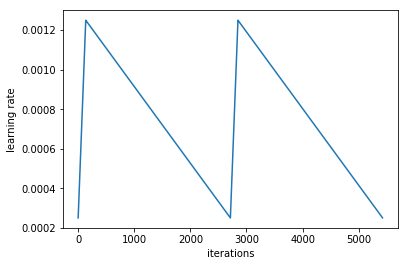

In [202]:
##change
# learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))
learner.fit(lrs/16,2,cycle_len=8,use_clr=(5,20))

###add
learner.sched.plot_lr()

In [24]:
learner.save('ResNet34_256_1')

In [25]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [26]:

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [27]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.54797 0.63341 0.59986 0.53167 0.58492 0.56614 0.51018 0.60899 0.47832 0.58876 0.47707 0.55674 0.49454
 0.57657 0.50495 0.78067 0.44802 0.40851 0.46701 0.56528 0.53972 0.51776 0.50533 0.5876  0.60054 0.49749
 0.51488 0.52517]
F1 macro:  0.6725970709982524
F1 macro (th = 0.5):  0.6552146358112086
F1 micro:  0.7743441745841304


/home/lc3352/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [28]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.45226 0.03733 0.10792 0.04538 0.05407 0.07295 0.02918 0.08399 0.00172 0.00118 0.00118 0.02907 0.02199
 0.01362 0.03551 0.00011 0.01277 0.00751 0.03529 0.0428  0.00375 0.12594 0.0251  0.09161 0.01083 0.31377
 0.01008 0.00011]
Fractions (true):  [0.41686 0.03948 0.11682 0.04881 0.05932 0.08056 0.03068 0.08796 0.00236 0.00129 0.00086 0.03443 0.02199
 0.01749 0.03583 0.00086 0.01727 0.00912 0.03411 0.04377 0.0059  0.12347 0.02628 0.09579 0.01094 0.26861
 0.00965 0.00064]


In [29]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [30]:
def save_pred(pred, th=0.2, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [133]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.44052 0.05367 0.10921 0.07332 0.08366 0.1316  0.08041 0.11921 0.00162 0.00325 0.00171 0.04726 0.04743
 0.02401 0.03965 0.      0.03854 0.01871 0.03845 0.09451 0.01111 0.16877 0.04187 0.1187  0.01453 0.28841
 0.05401 0.02401]


In [32]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [33]:
def Count_soft(preds,th=0.2,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [34]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.64611 0.48584 0.67059 0.39032 0.3567  0.50709 0.42073 0.57733 0.18181 0.20591 0.15159 0.44477 0.32743
 0.51605 0.45349 0.17538 0.422   0.47095 0.50156 0.4964  0.40475 0.56434 0.44803 0.60367 0.54565 0.58819
 0.40771 0.1515 ]
Fractions:  [0.36276 0.04358 0.07512 0.05768 0.07298 0.074   0.04222 0.0746  0.00837 0.00914 0.00778 0.04273 0.04222
 0.01427 0.04384 0.00641 0.02786 0.01333 0.02743 0.05828 0.00957 0.12536 0.02829 0.0746  0.01    0.22099
 0.02786 0.00573]
Fractions (th = 0.5):  [0.4994  0.04256 0.12673 0.03751 0.04469 0.07623 0.02641 0.09733 0.00051 0.00077 0.00043 0.03572 0.01726
 0.01461 0.03871 0.      0.01513 0.01128 0.02777 0.05683 0.00427 0.1733  0.02205 0.10614 0.01102 0.36182
 0.01427 0.00009]


In [35]:
save_pred(pred_t,th_t,'protein_classification_1.csv')

In [134]:
plot_pred = pred_t

In [36]:
save_pred(pred_t,th,'protein_classification_2.csv')
save_pred(pred_t,0.5,'protein_classification_3.csv')

In [37]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_4.csv')

In [38]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [39]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_5.csv')

Thresholds:  [0.59142 0.52942 0.52987 0.42717 0.4084  0.49152 0.46899 0.52339 0.3833  0.46898 0.41886 0.50633 0.4432
 0.45392 0.56302 0.30251 0.48936 0.57371 0.50063 0.53589 0.47588 0.57103 0.46978 0.53619 0.53142 0.56067
 0.54804 0.29854]
Fractions:  [0.41583 0.04051 0.11639 0.04905 0.0582  0.07939 0.03111 0.08981 0.00154 0.00145 0.00085 0.03529 0.02196
 0.01692 0.03461 0.0006  0.01649 0.00632 0.0276  0.04751 0.0053  0.12049 0.02555 0.09477 0.01025 0.26363
 0.00991 0.00043]


In [40]:
#######################################
####add

In [88]:
preds_y = pred

thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(y > 0.5, preds_y > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))

Threshold 0.0000, F1: 0.0999
Threshold 0.0007, F1: 0.1000
Threshold 0.0013, F1: 0.1001
Threshold 0.0020, F1: 0.1002
Threshold 0.0027, F1: 0.1003
Threshold 0.0033, F1: 0.1005
Threshold 0.0040, F1: 0.1006
Threshold 0.0047, F1: 0.1007
Threshold 0.0053, F1: 0.1009
Threshold 0.0060, F1: 0.1010
Threshold 0.0067, F1: 0.1012
Threshold 0.0073, F1: 0.1014
Threshold 0.0080, F1: 0.1015
Threshold 0.0087, F1: 0.1017
Threshold 0.0093, F1: 0.1019
Threshold 0.0100, F1: 0.1021
Threshold 0.0107, F1: 0.1024
Threshold 0.0113, F1: 0.1026
Threshold 0.0120, F1: 0.1028
Threshold 0.0127, F1: 0.1030
Threshold 0.0133, F1: 0.1032
Threshold 0.0140, F1: 0.1035
Threshold 0.0147, F1: 0.1037
Threshold 0.0153, F1: 0.1040
Threshold 0.0160, F1: 0.1043
Threshold 0.0167, F1: 0.1045
Threshold 0.0173, F1: 0.1048
Threshold 0.0180, F1: 0.1051
Threshold 0.0187, F1: 0.1054
Threshold 0.0193, F1: 0.1057
Threshold 0.0200, F1: 0.1059
Threshold 0.0207, F1: 0.1062
Threshold 0.0213, F1: 0.1066
Threshold 0.0220, F1: 0.1069
Threshold 0.02

Threshold 0.1961, F1: 0.3115
Threshold 0.1968, F1: 0.3124
Threshold 0.1975, F1: 0.3136
Threshold 0.1981, F1: 0.3148
Threshold 0.1988, F1: 0.3157
Threshold 0.1995, F1: 0.3168
Threshold 0.2001, F1: 0.3183
Threshold 0.2008, F1: 0.3194
Threshold 0.2015, F1: 0.3207
Threshold 0.2021, F1: 0.3218
Threshold 0.2028, F1: 0.3234
Threshold 0.2035, F1: 0.3245
Threshold 0.2041, F1: 0.3257
Threshold 0.2048, F1: 0.3274
Threshold 0.2055, F1: 0.3286
Threshold 0.2061, F1: 0.3296
Threshold 0.2068, F1: 0.3305
Threshold 0.2075, F1: 0.3315
Threshold 0.2081, F1: 0.3326
Threshold 0.2088, F1: 0.3336
Threshold 0.2095, F1: 0.3345
Threshold 0.2101, F1: 0.3355
Threshold 0.2108, F1: 0.3369
Threshold 0.2115, F1: 0.3379
Threshold 0.2121, F1: 0.3389
Threshold 0.2128, F1: 0.3400
Threshold 0.2135, F1: 0.3412
Threshold 0.2141, F1: 0.3423
Threshold 0.2148, F1: 0.3434
Threshold 0.2155, F1: 0.3443
Threshold 0.2161, F1: 0.3458
Threshold 0.2168, F1: 0.3473
Threshold 0.2175, F1: 0.3490
Threshold 0.2181, F1: 0.3502
Threshold 0.21

Threshold 0.3963, F1: 0.5974
Threshold 0.3969, F1: 0.5980
Threshold 0.3976, F1: 0.5993
Threshold 0.3983, F1: 0.5995
Threshold 0.3989, F1: 0.6006
Threshold 0.3996, F1: 0.6014
Threshold 0.4003, F1: 0.6022
Threshold 0.4009, F1: 0.6025
Threshold 0.4016, F1: 0.6034
Threshold 0.4023, F1: 0.6041
Threshold 0.4029, F1: 0.6054
Threshold 0.4036, F1: 0.6059
Threshold 0.4043, F1: 0.6062
Threshold 0.4049, F1: 0.6070
Threshold 0.4056, F1: 0.6074
Threshold 0.4063, F1: 0.6085
Threshold 0.4069, F1: 0.6094
Threshold 0.4076, F1: 0.6111
Threshold 0.4083, F1: 0.6114
Threshold 0.4089, F1: 0.6115
Threshold 0.4096, F1: 0.6118
Threshold 0.4103, F1: 0.6120
Threshold 0.4109, F1: 0.6124
Threshold 0.4116, F1: 0.6130
Threshold 0.4123, F1: 0.6137
Threshold 0.4129, F1: 0.6141
Threshold 0.4136, F1: 0.6143
Threshold 0.4143, F1: 0.6148
Threshold 0.4149, F1: 0.6153
Threshold 0.4156, F1: 0.6160
Threshold 0.4163, F1: 0.6164
Threshold 0.4169, F1: 0.6147
Threshold 0.4176, F1: 0.6154
Threshold 0.4183, F1: 0.6159
Threshold 0.41

Threshold 0.5984, F1: 0.6422
Threshold 0.5991, F1: 0.6423
Threshold 0.5997, F1: 0.6413
Threshold 0.6004, F1: 0.6407
Threshold 0.6011, F1: 0.6354
Threshold 0.6017, F1: 0.6346
Threshold 0.6024, F1: 0.6329
Threshold 0.6031, F1: 0.6320
Threshold 0.6037, F1: 0.6321
Threshold 0.6044, F1: 0.6317
Threshold 0.6051, F1: 0.6308
Threshold 0.6057, F1: 0.6308
Threshold 0.6064, F1: 0.6305
Threshold 0.6071, F1: 0.6294
Threshold 0.6077, F1: 0.6283
Threshold 0.6084, F1: 0.6289
Threshold 0.6091, F1: 0.6278
Threshold 0.6097, F1: 0.6254
Threshold 0.6104, F1: 0.6253
Threshold 0.6111, F1: 0.6239
Threshold 0.6117, F1: 0.6235
Threshold 0.6124, F1: 0.6232
Threshold 0.6131, F1: 0.6229
Threshold 0.6137, F1: 0.6229
Threshold 0.6144, F1: 0.6240
Threshold 0.6151, F1: 0.6251
Threshold 0.6157, F1: 0.6248
Threshold 0.6164, F1: 0.6221
Threshold 0.6171, F1: 0.6219
Threshold 0.6177, F1: 0.6214
Threshold 0.6184, F1: 0.6210
Threshold 0.6191, F1: 0.6207
Threshold 0.6197, F1: 0.6208
Threshold 0.6204, F1: 0.6201
Threshold 0.62

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.7672, F1: 0.4530
Threshold 0.7678, F1: 0.4523
Threshold 0.7685, F1: 0.4416
Threshold 0.7692, F1: 0.4413
Threshold 0.7698, F1: 0.4371
Threshold 0.7705, F1: 0.4368
Threshold 0.7712, F1: 0.4365
Threshold 0.7718, F1: 0.4342
Threshold 0.7725, F1: 0.4336
Threshold 0.7732, F1: 0.4332
Threshold 0.7738, F1: 0.4293
Threshold 0.7745, F1: 0.4290
Threshold 0.7752, F1: 0.4278
Threshold 0.7759, F1: 0.4270
Threshold 0.7765, F1: 0.4264
Threshold 0.7772, F1: 0.4256
Threshold 0.7779, F1: 0.4240
Threshold 0.7785, F1: 0.4235
Threshold 0.7792, F1: 0.4227
Threshold 0.7799, F1: 0.4211
Threshold 0.7805, F1: 0.4196


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.7812, F1: 0.4191
Threshold 0.7819, F1: 0.4180
Threshold 0.7825, F1: 0.4171
Threshold 0.7832, F1: 0.4162
Threshold 0.7839, F1: 0.4156
Threshold 0.7845, F1: 0.4143
Threshold 0.7852, F1: 0.4121
Threshold 0.7859, F1: 0.4113
Threshold 0.7865, F1: 0.4034
Threshold 0.7872, F1: 0.4025
Threshold 0.7879, F1: 0.4010
Threshold 0.7885, F1: 0.4001
Threshold 0.7892, F1: 0.3987
Threshold 0.7899, F1: 0.3965
Threshold 0.7905, F1: 0.3951
Threshold 0.7912, F1: 0.3941
Threshold 0.7919, F1: 0.3926
Threshold 0.7925, F1: 0.3919
Threshold 0.7932, F1: 0.3915
Threshold 0.7939, F1: 0.3907
Threshold 0.7945, F1: 0.3897


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.7952, F1: 0.3885
Threshold 0.7959, F1: 0.3875
Threshold 0.7965, F1: 0.3867
Threshold 0.7972, F1: 0.3852
Threshold 0.7979, F1: 0.3841
Threshold 0.7985, F1: 0.3826
Threshold 0.7992, F1: 0.3815
Threshold 0.7999, F1: 0.3793
Threshold 0.8005, F1: 0.3786
Threshold 0.8012, F1: 0.3778
Threshold 0.8019, F1: 0.3760
Threshold 0.8025, F1: 0.3754
Threshold 0.8032, F1: 0.3746
Threshold 0.8039, F1: 0.3739
Threshold 0.8045, F1: 0.3731
Threshold 0.8052, F1: 0.3724
Threshold 0.8059, F1: 0.3713
Threshold 0.8065, F1: 0.3702
Threshold 0.8072, F1: 0.3697
Threshold 0.8079, F1: 0.3688
Threshold 0.8085, F1: 0.3677


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8092, F1: 0.3667
Threshold 0.8099, F1: 0.3656
Threshold 0.8105, F1: 0.3562
Threshold 0.8112, F1: 0.3549
Threshold 0.8119, F1: 0.3535
Threshold 0.8125, F1: 0.3527
Threshold 0.8132, F1: 0.3514
Threshold 0.8139, F1: 0.3500
Threshold 0.8145, F1: 0.3463
Threshold 0.8152, F1: 0.3457
Threshold 0.8159, F1: 0.3453
Threshold 0.8165, F1: 0.3448
Threshold 0.8172, F1: 0.3434
Threshold 0.8179, F1: 0.3427
Threshold 0.8185, F1: 0.3415
Threshold 0.8192, F1: 0.3407
Threshold 0.8199, F1: 0.3397
Threshold 0.8205, F1: 0.3384
Threshold 0.8212, F1: 0.3376
Threshold 0.8219, F1: 0.3326
Threshold 0.8225, F1: 0.3308
Threshold 0.8232, F1: 0.3295


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8239, F1: 0.3285
Threshold 0.8245, F1: 0.3273
Threshold 0.8252, F1: 0.3260
Threshold 0.8259, F1: 0.3252
Threshold 0.8266, F1: 0.3243
Threshold 0.8272, F1: 0.3233
Threshold 0.8279, F1: 0.3214
Threshold 0.8286, F1: 0.3208
Threshold 0.8292, F1: 0.3199
Threshold 0.8299, F1: 0.3189
Threshold 0.8306, F1: 0.3183
Threshold 0.8312, F1: 0.3175
Threshold 0.8319, F1: 0.3167
Threshold 0.8326, F1: 0.3151
Threshold 0.8332, F1: 0.3137
Threshold 0.8339, F1: 0.3133
Threshold 0.8346, F1: 0.3126
Threshold 0.8352, F1: 0.3111
Threshold 0.8359, F1: 0.3101
Threshold 0.8366, F1: 0.3090
Threshold 0.8372, F1: 0.3080
Threshold 0.8379, F1: 0.3062


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8386, F1: 0.3048
Threshold 0.8392, F1: 0.3031
Threshold 0.8399, F1: 0.3023
Threshold 0.8406, F1: 0.3013
Threshold 0.8412, F1: 0.3002
Threshold 0.8419, F1: 0.2991
Threshold 0.8426, F1: 0.2983
Threshold 0.8432, F1: 0.2975
Threshold 0.8439, F1: 0.2964
Threshold 0.8446, F1: 0.2958
Threshold 0.8452, F1: 0.2944
Threshold 0.8459, F1: 0.2926
Threshold 0.8466, F1: 0.2907
Threshold 0.8472, F1: 0.2891
Threshold 0.8479, F1: 0.2857
Threshold 0.8486, F1: 0.2845
Threshold 0.8492, F1: 0.2831
Threshold 0.8499, F1: 0.2794
Threshold 0.8506, F1: 0.2783
Threshold 0.8512, F1: 0.2775
Threshold 0.8519, F1: 0.2766
Threshold 0.8526, F1: 0.2752


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8532, F1: 0.2743
Threshold 0.8539, F1: 0.2736
Threshold 0.8546, F1: 0.2721
Threshold 0.8552, F1: 0.2703
Threshold 0.8559, F1: 0.2692
Threshold 0.8566, F1: 0.2684
Threshold 0.8572, F1: 0.2674
Threshold 0.8579, F1: 0.2661
Threshold 0.8586, F1: 0.2606
Threshold 0.8592, F1: 0.2598
Threshold 0.8599, F1: 0.2549
Threshold 0.8606, F1: 0.2534
Threshold 0.8612, F1: 0.2526
Threshold 0.8619, F1: 0.2517
Threshold 0.8626, F1: 0.2510
Threshold 0.8632, F1: 0.2504
Threshold 0.8639, F1: 0.2490
Threshold 0.8646, F1: 0.2475
Threshold 0.8652, F1: 0.2462
Threshold 0.8659, F1: 0.2452
Threshold 0.8666, F1: 0.2437
Threshold 0.8672, F1: 0.2374


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8679, F1: 0.2362
Threshold 0.8686, F1: 0.2344
Threshold 0.8692, F1: 0.2332
Threshold 0.8699, F1: 0.2317
Threshold 0.8706, F1: 0.2307
Threshold 0.8712, F1: 0.2297
Threshold 0.8719, F1: 0.2285
Threshold 0.8726, F1: 0.2272
Threshold 0.8732, F1: 0.2262
Threshold 0.8739, F1: 0.2248
Threshold 0.8746, F1: 0.2232
Threshold 0.8753, F1: 0.2216
Threshold 0.8759, F1: 0.2206
Threshold 0.8766, F1: 0.2185
Threshold 0.8773, F1: 0.2163
Threshold 0.8779, F1: 0.2147
Threshold 0.8786, F1: 0.2132
Threshold 0.8793, F1: 0.2117
Threshold 0.8799, F1: 0.2105
Threshold 0.8806, F1: 0.2095
Threshold 0.8813, F1: 0.2084
Threshold 0.8819, F1: 0.2074
Threshold 0.8826, F1: 0.2055


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8833, F1: 0.2041
Threshold 0.8839, F1: 0.2022
Threshold 0.8846, F1: 0.2009
Threshold 0.8853, F1: 0.2001
Threshold 0.8859, F1: 0.1986
Threshold 0.8866, F1: 0.1970
Threshold 0.8873, F1: 0.1952
Threshold 0.8879, F1: 0.1939
Threshold 0.8886, F1: 0.1923
Threshold 0.8893, F1: 0.1909
Threshold 0.8899, F1: 0.1890
Threshold 0.8906, F1: 0.1880
Threshold 0.8913, F1: 0.1868
Threshold 0.8919, F1: 0.1846
Threshold 0.8926, F1: 0.1839
Threshold 0.8933, F1: 0.1830
Threshold 0.8939, F1: 0.1815
Threshold 0.8946, F1: 0.1805
Threshold 0.8953, F1: 0.1792
Threshold 0.8959, F1: 0.1781
Threshold 0.8966, F1: 0.1767
Threshold 0.8973, F1: 0.1744


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.8979, F1: 0.1729
Threshold 0.8986, F1: 0.1707
Threshold 0.8993, F1: 0.1698
Threshold 0.8999, F1: 0.1681
Threshold 0.9006, F1: 0.1668
Threshold 0.9013, F1: 0.1573
Threshold 0.9019, F1: 0.1556
Threshold 0.9026, F1: 0.1543
Threshold 0.9033, F1: 0.1529
Threshold 0.9039, F1: 0.1516
Threshold 0.9046, F1: 0.1499
Threshold 0.9053, F1: 0.1483
Threshold 0.9059, F1: 0.1471
Threshold 0.9066, F1: 0.1453
Threshold 0.9073, F1: 0.1441
Threshold 0.9079, F1: 0.1426
Threshold 0.9086, F1: 0.1355
Threshold 0.9093, F1: 0.1337
Threshold 0.9099, F1: 0.1325
Threshold 0.9106, F1: 0.1305
Threshold 0.9113, F1: 0.1282
Threshold 0.9119, F1: 0.1267
Threshold 0.9126, F1: 0.1246


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.9133, F1: 0.1228
Threshold 0.9139, F1: 0.1210
Threshold 0.9146, F1: 0.1191
Threshold 0.9153, F1: 0.1174
Threshold 0.9159, F1: 0.1161
Threshold 0.9166, F1: 0.1131
Threshold 0.9173, F1: 0.1119
Threshold 0.9179, F1: 0.1107
Threshold 0.9186, F1: 0.1089
Threshold 0.9193, F1: 0.1069
Threshold 0.9199, F1: 0.1050
Threshold 0.9206, F1: 0.1034
Threshold 0.9213, F1: 0.1012
Threshold 0.9219, F1: 0.0990
Threshold 0.9226, F1: 0.0975
Threshold 0.9233, F1: 0.0959
Threshold 0.9239, F1: 0.0946
Threshold 0.9246, F1: 0.0930
Threshold 0.9253, F1: 0.0911
Threshold 0.9260, F1: 0.0897
Threshold 0.9266, F1: 0.0882
Threshold 0.9273, F1: 0.0859
Threshold 0.9280, F1: 0.0843


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.9286, F1: 0.0817
Threshold 0.9293, F1: 0.0808
Threshold 0.9300, F1: 0.0803
Threshold 0.9306, F1: 0.0784
Threshold 0.9313, F1: 0.0770
Threshold 0.9320, F1: 0.0762
Threshold 0.9326, F1: 0.0746
Threshold 0.9333, F1: 0.0739
Threshold 0.9340, F1: 0.0721
Threshold 0.9346, F1: 0.0707
Threshold 0.9353, F1: 0.0694
Threshold 0.9360, F1: 0.0691
Threshold 0.9366, F1: 0.0677
Threshold 0.9373, F1: 0.0662
Threshold 0.9380, F1: 0.0641
Threshold 0.9386, F1: 0.0622
Threshold 0.9393, F1: 0.0594
Threshold 0.9400, F1: 0.0585
Threshold 0.9406, F1: 0.0572
Threshold 0.9413, F1: 0.0565
Threshold 0.9420, F1: 0.0548
Threshold 0.9426, F1: 0.0540
Threshold 0.9433, F1: 0.0529
Threshold 0.9440, F1: 0.0512


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.9446, F1: 0.0490
Threshold 0.9453, F1: 0.0475
Threshold 0.9460, F1: 0.0463
Threshold 0.9466, F1: 0.0454
Threshold 0.9473, F1: 0.0442
Threshold 0.9480, F1: 0.0427
Threshold 0.9486, F1: 0.0408
Threshold 0.9493, F1: 0.0394
Threshold 0.9500, F1: 0.0370
Threshold 0.9506, F1: 0.0349
Threshold 0.9513, F1: 0.0338
Threshold 0.9520, F1: 0.0335
Threshold 0.9526, F1: 0.0322
Threshold 0.9533, F1: 0.0297
Threshold 0.9540, F1: 0.0290
Threshold 0.9546, F1: 0.0276
Threshold 0.9553, F1: 0.0258
Threshold 0.9560, F1: 0.0248
Threshold 0.9566, F1: 0.0238
Threshold 0.9573, F1: 0.0225
Threshold 0.9580, F1: 0.0218
Threshold 0.9586, F1: 0.0202
Threshold 0.9593, F1: 0.0197
Threshold 0.9600, F1: 0.0194
Threshold 0.9606, F1: 0.0182


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.9613, F1: 0.0174
Threshold 0.9620, F1: 0.0171
Threshold 0.9626, F1: 0.0155
Threshold 0.9633, F1: 0.0150
Threshold 0.9640, F1: 0.0135
Threshold 0.9646, F1: 0.0128
Threshold 0.9653, F1: 0.0126
Threshold 0.9660, F1: 0.0123
Threshold 0.9666, F1: 0.0109
Threshold 0.9673, F1: 0.0106
Threshold 0.9680, F1: 0.0095
Threshold 0.9686, F1: 0.0087
Threshold 0.9693, F1: 0.0079
Threshold 0.9700, F1: 0.0056
Threshold 0.9706, F1: 0.0053
Threshold 0.9713, F1: 0.0050
Threshold 0.9720, F1: 0.0044
Threshold 0.9726, F1: 0.0036
Threshold 0.9733, F1: 0.0029
Threshold 0.9740, F1: 0.0029
Threshold 0.9746, F1: 0.0025
Threshold 0.9753, F1: 0.0016
Threshold 0.9760, F1: 0.0016
Threshold 0.9767, F1: 0.0014


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold 0.9773, F1: 0.0014
Threshold 0.9780, F1: 0.0013
Threshold 0.9787, F1: 0.0012
Threshold 0.9793, F1: 0.0007
Threshold 0.9800, F1: 0.0006
Threshold 0.9807, F1: 0.0004
Threshold 0.9813, F1: 0.0004
Threshold 0.9820, F1: 0.0003
Threshold 0.9827, F1: 0.0002
Threshold 0.9833, F1: 0.0002
Threshold 0.9840, F1: 0.0001
Threshold 0.9847, F1: 0.0001
Threshold 0.9853, F1: 0.0001
Threshold 0.9860, F1: 0.0001
Threshold 0.9867, F1: 0.0001
Threshold 0.9873, F1: 0.0001
Threshold 0.9880, F1: 0.0001
Threshold 0.9887, F1: 0.0001
Threshold 0.9893, F1: 0.0001
Threshold 0.9900, F1: 0.0000
Threshold 0.9907, F1: 0.0000
Threshold 0.9913, F1: 0.0000
Threshold 0.9920, F1: 0.0000
Threshold 0.9927, F1: 0.0000
Threshold 0.9933, F1: 0.0000
Threshold 0.9940, F1: 0.0000
Threshold 0.9947, F1: 0.0000
Threshold 0.9953, F1: 0.0000
Threshold 0.9960, F1: 0.0000
Threshold 0.9967, F1: 0.0000
Threshold 0.9973, F1: 0.0000
Threshold 0.9980, F1: 0.0000
Threshold 0.9987, F1: 0.0000
Threshold 0.9993, F1: 0.0000
Threshold 1.00

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

In [43]:
print('Thresholds: ',best_threshold)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_single_best_threshold.csv')

Thresholds:  0.5250166777851901
Fractions:  [0.41583 0.04051 0.11639 0.04905 0.0582  0.07939 0.03111 0.08981 0.00154 0.00145 0.00085 0.03529 0.02196
 0.01692 0.03461 0.0006  0.01649 0.00632 0.0276  0.04751 0.0053  0.12049 0.02555 0.09477 0.01025 0.26363
 0.00991 0.00043]


In [170]:
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(preds_y)
        val_predict = (preds_y > test_threshold)
        score = f1_score(y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[0] 0.548549, F1: 0.655336


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[1] 0.685686, F1: 0.656202


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[2] 0.622623, F1: 0.657253


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[3] 0.503504, F1: 0.657554


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[4] 0.575576, F1: 0.658087


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[5] 0.555556, F1: 0.658670


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[6] 0.527528, F1: 0.658942


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[7] 0.603604, F1: 0.660461


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[8] 0.469469, F1: 0.661666


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[9] 0.614615, F1: 0.667448


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[10] 0.480480, F1: 0.670016


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[11] 0.568569, F1: 0.670624


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[12] 0.491491, F1: 0.671061


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[13] 0.587588, F1: 0.672239


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[14] 0.489489, F1: 0.672437


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[15] 0.261261, F1: 0.677899


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[16] 0.427427, F1: 0.678638


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[17] 0.390390, F1: 0.682272


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[18] 0.442442, F1: 0.682656


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[19] 0.581582, F1: 0.683283


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[20] 0.540541, F1: 0.685458


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[21] 0.511512, F1: 0.685619


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[22] 0.513514, F1: 0.686106


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[23] 0.587588, F1: 0.686873


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[24] 0.607608, F1: 0.687945


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[25] 0.482482, F1: 0.688039


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[26] 0.506507, F1: 0.688442


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

Threshold[27] 0.309309, F1: 0.688442
Best threshold: 
[0.54855 0.68569 0.62262 0.5035  0.57558 0.55556 0.52753 0.6036  0.46947 0.61461 0.48048 0.56857 0.49149
 0.58759 0.48949 0.26126 0.42743 0.39039 0.44244 0.58158 0.54054 0.51151 0.51351 0.58759 0.60761 0.48248
 0.50651 0.30931]
Best f1:
[0.65534 0.6562  0.65725 0.65755 0.65809 0.65867 0.65894 0.66046 0.66167 0.66745 0.67002 0.67062 0.67106
 0.67224 0.67244 0.6779  0.67864 0.68227 0.68266 0.68328 0.68546 0.68562 0.68611 0.68687 0.68794 0.68804
 0.68844 0.68844]


/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lc3352/anaconda3/lib/p

In [171]:
print('Thresholds: ',best_threshold)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_28_best_threshold.csv')

Thresholds:  [0.54855 0.68569 0.62262 0.5035  0.57558 0.55556 0.52753 0.6036  0.46947 0.61461 0.48048 0.56857 0.49149
 0.58759 0.48949 0.26126 0.42743 0.39039 0.44244 0.58158 0.54054 0.51151 0.51351 0.58759 0.60761 0.48248
 0.50651 0.30931]
Fractions:  [0.44052 0.05367 0.10921 0.07332 0.08366 0.1316  0.08041 0.11921 0.00162 0.00325 0.00171 0.04726 0.04743
 0.02401 0.03965 0.      0.03854 0.01871 0.03845 0.09451 0.01111 0.16877 0.04187 0.1187  0.01453 0.28841
 0.05401 0.02401]


In [172]:
sample_df = pd.read_csv(SAMPLE)

In [191]:
predicted = []
for j in range(len(pred_t)):
    label_predict = []
    for i in range(28):
         if (pred_t[j,i]>=best_threshold[i])or(pred_t[j,i]==np.max(pred_t[j,:])):      
            label_predict.append(i)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

In [192]:
np.shape(predicted)

(11702,)

In [193]:
sample_df['Predicted'] = predicted
sample_df.to_csv('submission28.csv', index=False)

In [50]:
train_labels = pd.read_csv("/home/lc3352/Desktop/Kaggle/input/train.csv")

In [58]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [59]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [60]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

Id        Target  Nucleoplasm  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0       [16, 0]            1   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [7, 1, 2, 0]            1   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0           [5]            0   
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0           [1]            0   
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0          [18]            0   

   Nuclear membrane  Nucleoli  Nucleoli fibrillar center  Nuclear speckles  \
0                 0         0                          0                 0   
1                 1         1                          0                 0   
2                 0         0                          0                 0   
3                 1         0                          0                 0   
4                 0         0                          0                 0   

   Nuclear bodies  Endoplasmic reticulum  Golgi apparatus      ...       \
0               0                      0                0      ...        
1               0                      0                1      ...        
2               1                      0                0      ...        
3               0                      0                0      ...        
4               0                      0                0      ...        

   Microtubule organizing center  Centrosome  Lipid droplets  Plasma membrane  \
0                              0           0               0                0   
1                              0           0               0                0   
2                              0           0               0                0   
3                              0           0               0                0   
4                              1           0               0                0   

   Cell junctions  Mitochondria  Aggresome  Cytosol  Cytoplasmic bodies  \
0               0             0          0        0                   0   
1               0             0          0        0                   0   
2               0             0          0        0                   0   
3               0             0          0        0                   0   
4               0             0          0        0                   0   

   Rods & rings  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 30 columns]

In [114]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)

In [116]:
np.shape(proba_predictions) 

(11702, 28)

In [201]:
 baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.to_csv("predictions.csv")

In [196]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

In [197]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [198]:
partitions[0]["train"][0:5]

array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
       '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'], dtype=object)

In [199]:
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]

/home/lc3352/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Percentage')

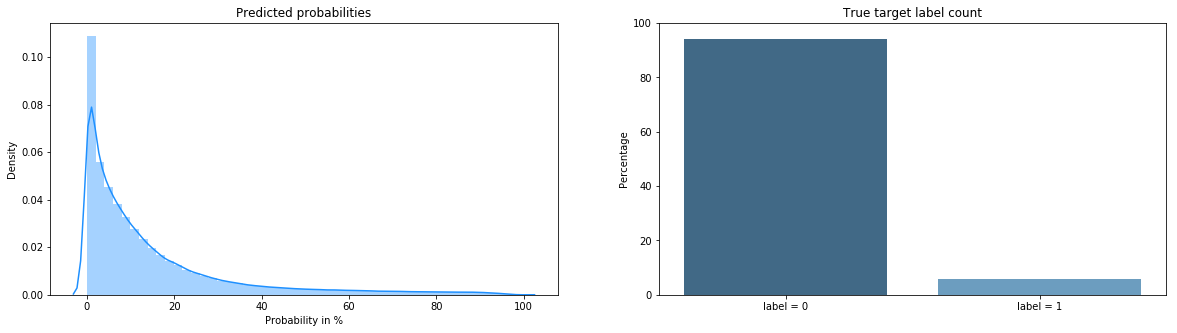

In [200]:
proba_predictions = baseline_proba_predictions.values
hot_values = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1],palette="Blues_d")
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

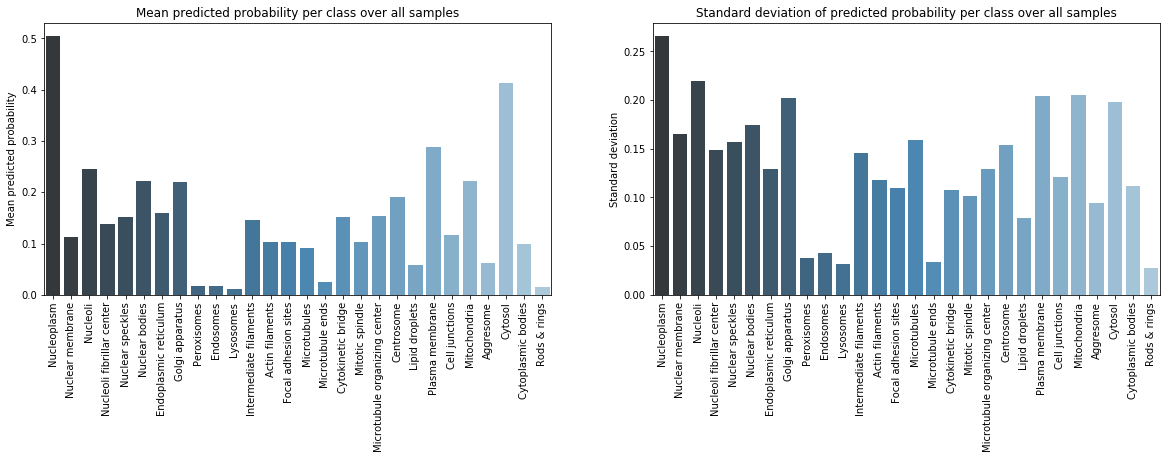

In [151]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=labels,
            y=mean_predictions,
            ax=ax[0],palette="Blues_d")
ax[0].set_xticklabels(labels=labels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1],palette="Blues_d")
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

Text(0.5, 1.0, 'Percentage of hot counts (ones) per target class')

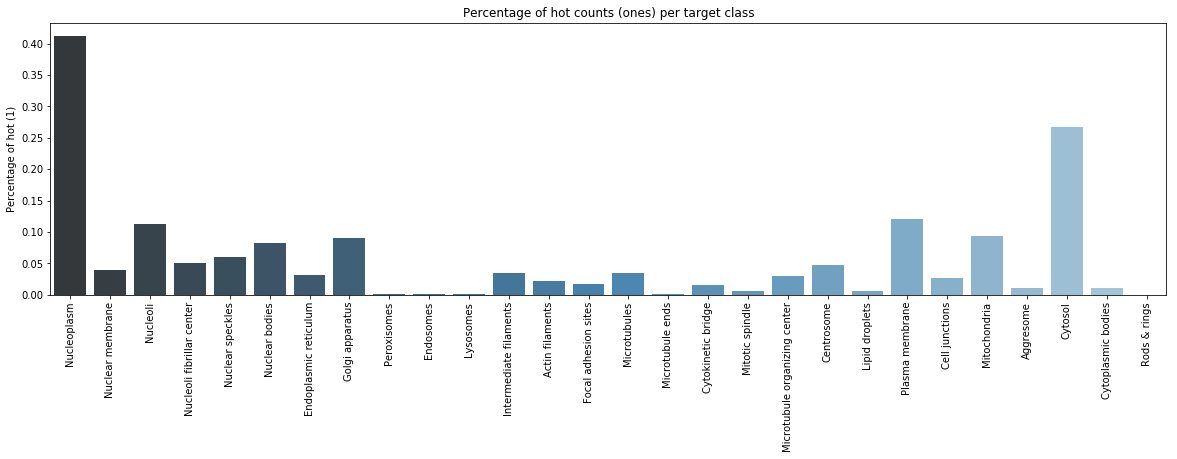

In [158]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax,palette="Blues_d")
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

In [127]:
feature = "Cytosol"

/home/lc3352/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 1)

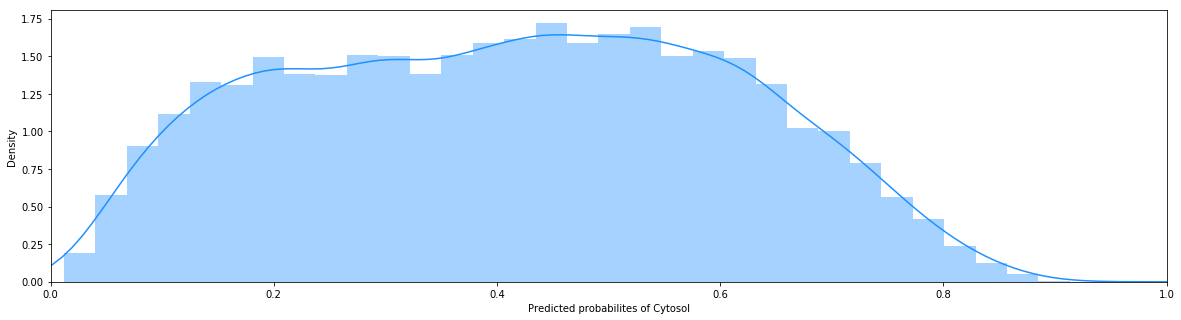

In [159]:
plt.figure(figsize=(20,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-10], color="DodgerBlue")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

In [110]:
pred

array([[0.85583, 0.10098, 0.20018, ..., 0.47426, 0.05639, 0.01317],
       [0.95851, 0.05741, 0.03993, ..., 0.05378, 0.00734, 0.00001],
       [0.14334, 0.01456, 0.40319, ..., 0.78927, 0.05743, 0.00352],
       ...,
       [0.11081, 0.14518, 0.02141, ..., 0.27014, 0.02091, 0.00025],
       [0.71849, 0.21054, 0.09012, ..., 0.04428, 0.0209 , 0.00062],
       [0.77858, 0.06706, 0.21601, ..., 0.21632, 0.06296, 0.04462]], dtype=float32)